Functions for Bayesian best fitting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.interpolate import interp1d
from scipy.special import factorial
import os
import sys
sys.path.append('/home/astridaurora/HESE-7-year-data-release/HESE-7-year-data-release')
from Astrid.effective_area import bin_edges_to_centers, bin_centers_to_edges, apply_energy_smearing
from simple_backend_setup import create_sampler_with_backend
import nuSIprop

import emcee
import corner

In [2]:
class SuppressOutput:
    """Suppress both Python and C++ prints to stdout and stderr."""
    def __enter__(self):
        # Save original stdout and stderr file descriptors
        self._original_stdout_fd = os.dup(1)
        self._original_stderr_fd = os.dup(2)

        # Open a null file descriptor (redirected to /dev/null)
        self._devnull = os.open(os.devnull, os.O_WRONLY)

        # Override stdout and stderr with the null file descriptor
        os.dup2(self._devnull, 1)
        os.dup2(self._devnull, 2)

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore original stdout and stderr file descriptors
        os.dup2(self._original_stdout_fd, 1)
        os.dup2(self._original_stderr_fd, 2)

        # Close the null file descriptor and original saved descriptors
        os.close(self._devnull)
        os.close(self._original_stdout_fd)
        os.close(self._original_stderr_fd)

In [ ]:
def chi2_poisson(data, predicted):
    # This is the Poisson Deviance which follow a Chi2 distribution?
        
    chi2_value = np.sum(2*(predicted - data) + 2*data*np.log(data/predicted))
    return chi2_value

def log_likelihood_poisson(data, predicted):
    # From Poisson distribution 
    #return np.sum(-predicted + data*np.log(predicted) - np.log(np.math.factorial(data)))
    return np.sum(-predicted + data*np.log(predicted) - np.log(factorial(data)))


def total_events(flx, eff, livetime, norm, delta_E, save_to_csv=False):
    # Interpolate `flx` to the same energy bins as `eff`
    flx_interpolated = pd.DataFrame(
    {col: interp1d(flx.index, flx[col], bounds_error=False, fill_value="extrapolate")(eff.index)
     for col in flx.columns},
    index=eff.index)
    
    if eff['nu_e'].any() < 0:
        print('Negative effective area found')
    if eff['nu_mu'].any() < 0:
        print('Negative effective area found')
    if eff['nu_tau'].any() < 0:
        print('Negative effective area found')
    

    total_events_df = flx_interpolated * eff * livetime * norm 
    negative_mask = total_events_df < 0
    total_events_df[negative_mask] = 0
        
    #total_events_df = flx * eff_interpolated * livetime
    total_events_df['total_events'] = delta_E * (total_events_df['nu_e'] + total_events_df['nu_mu'] + total_events_df['nu_tau'])
    #total_events_df.index = eff.index 

    if save_to_csv==True:
        total_events_df.to_csv('total_events.csv')

    return total_events_df

In [16]:
energy_bins = np.logspace(4, 7, 3*20+1)
energy_centers = bin_edges_to_centers(energy_bins)
energy_bins_low_resolution = np.logspace(4, 7, 20+1)
energy_centers_low_resolution = bin_edges_to_centers(energy_bins_low_resolution)

livetime12 = 12*365*24*3600

hese12_events_df = pd.read_csv('4_to_7_HESE12/20bins/hese12_20bins_df.csv', index_col=0)

# Replace all zeros with 1e-8
"""hese12_events_df.loc[hese12_events_df['events'] == 0, 'events'] = 1e-8
print(hese12_events_df)
for i in range(len(hese12_events_df)):
    if hese12_events_df['events'].values[i] < 1e-4:
        hese12_events_df['events'].values[i] = 0"""

print(hese12_events_df['events'].values)

background_df = pd.read_csv('4_to_7_HESE12/20bins/background_20bins_df.csv', index_col=0)
background_df.rename(columns={'background': 'events'}, inplace=True)


effective_area_df = pd.read_csv('4_to_7_HESE12/60bins/effective_area_4_to_7.csv', index_col=0)
#effective_area_df.index = effective_area_df.index * 1e9    # Convert to [eV]   
#effective_area_df['nu_e'] = effective_area_df['nu_e'] * 1e4
#effective_area_df['nu_mu'] = effective_area_df['nu_mu'] * 1e4
#effective_area_df['nu_tau'] = effective_area_df['nu_tau'] * 1e4
#effective_area_df['total'] = effective_area_df['nu_e'] + effective_area_df['nu_mu'] + effective_area_df['nu_tau']

print(effective_area_df)

[ 0  1 18 25 25 23 27 23  8  4  4  1  1  2  0  1  0  1  0  0]
                    nu_e      nu_mu     nu_tau
1.059254e+04    0.000000   0.000000   0.000000
1.188502e+04    0.000000   0.000000   0.000000
1.333521e+04    0.000650   0.000000   0.000000
1.496236e+04    0.001655   0.000000   0.000164
1.678804e+04    0.005214   0.000231   0.000910
1.883649e+04    0.022066   0.001210   0.002558
2.113489e+04    0.043136   0.004113   0.009679
2.371374e+04    0.093632   0.006964   0.016494
2.660725e+04    0.158180   0.013907   0.046911
2.985383e+04    0.259070   0.030709   0.078405
3.349654e+04    0.390221   0.054082   0.131141
3.758374e+04    0.553705   0.082374   0.226340
4.216965e+04    0.774678   0.129672   0.341698
4.731513e+04    1.092296   0.216925   0.507006
5.308844e+04    1.616033   0.291094   0.687900
5.956621e+04    2.114926   0.452367   0.961127
6.683439e+04    2.826941   0.654275   1.425661
7.498942e+04    3.440951   0.891118   1.751250
8.413951e+04    4.221091   1.235720   2.43153

In [7]:
M_phi = 25
g_phi = 0.05
mntot = 0.1
si = 2.5
norm = 4.0*1e-18

evolver = nuSIprop.pyprop(mphi = M_phi*1e6, # Mediator mass [eV]
			  g = g_phi, # Coupling
			  mntot = mntot, # Sum of neutrino masses [eV]
			  si = si, # Spectral index
			  norm = norm, # Normalization of the free-streaming flux at 100 TeV [Default = 1]
			  majorana = True, # Majorana neutrinos? [Default = True]
			  non_resonant = True, # Include non s-channel contributions? Relevant for couplings g>~0.1 [Default = True]
			  normal_ordering = True, # Normal neutrino mass ordering? [Default = True]
			  N_bins_E = 300, # Number of energy bins, uniformly distributed in log space [Default = 300]
			  lEmin = 13, # log_10 (E_min/eV) [Default = 13]
			  lEmax = 16, # log_10 (E_max/eV) [Default = 17]
			  zmax = 5, # Largest redshift at which sources are included [Default = 5]
			  flav = 2, # Flavor of interacting neutrinos [0=e, 1=mu, 2=tau. Default = 2]
			  phiphi = False # Consider double-scalar production? If set to true, the files xsec/alpha_phiphi.bin and xsec/alphatilde_phiphi.bin must exist [Default = False]
                          )

energies = evolver.get_energies()
bin_edges_high_resolution = bin_centers_to_edges(energies)
delta_E = np.diff(bin_edges_high_resolution)    # Delta E in eV   

In [17]:
def log_Jeffreys_prior(theta):
    #Mphi, g, mntot, si, norm = theta
    #Mphi, g, si, norm = theta
    Mphi, g, si = theta
    
    # Use log-uniform priors for better exploration
    if not (1e-4 < g < 1):
        return -np.inf
    if not (0.1 < Mphi < 1000):
        return -np.inf
    #if not (0.06 < mntot < 0.12):
    #    return -np.inf
    if not (2.0 < si < 3.0):
        return -np.inf
    #if not (1e-19 < norm < 1e-17):  # Much wider range
    #    return -np.inf
    
    # Log-uniform prior: log(1/x) = -log(x)
    #return -np.log(g) - np.log(Mphi) - np.log(norm)
    return -np.log(g) - np.log(Mphi)
    


def log_prior_uniform(theta):
    """
    Uniform prior (for comparison)
    """
    #Mphi, g, mntot, si, norm = theta
    #Mphi, g, si, norm = theta
    Mphi, g, si = theta
    
    # Check bounds
    if not (1e-4 < g < 1):
        return -np.inf
    if not (0.1 < Mphi < 1000):
        return -np.inf
    #if not (0.06 < mntot < 0.12):
    #    return -np.inf
    if not (2.0 < si < 3.0):
        return -np.inf
    #if not (1e-19 < norm < 1e-17):
    #    return -np.inf
    
    # Uniform prior (constant)
    return 0.0





def log_likelihood(theta):
    #Mphi, g, mntot, si, norm = theta
    #Mphi, g, si, norm = theta
    Mphi, g, si = theta

    #evolver.set_parameters(g=g, mphi=Mphi*1e6, mntot=mntot, si=si, norm=norm)
    #evolver.set_parameters(mphi=Mphi*1e6, g=g, si=si, norm=norm)
    evolver.set_parameters(mphi=Mphi*1e6, g=g, si=si)
    evolver.evolve()
    flux = evolver.get_flux_fla()

    flx_df = pd.DataFrame(flux.T, index=energies, columns=['nu_e', 'nu_mu', 'nu_tau'])
    flx_df.index = flx_df.index / 1e9

    nuSIprop_df = total_events(flx=effective_area_df, eff=flx_df, livetime=livetime12, norm=1e-4, delta_E=delta_E)
    nuSIprop_smeared = apply_energy_smearing(energies=nuSIprop_df.index.values, events=nuSIprop_df['total_events'].values, resolution=0.1)
        
    #events = nuSIprop_df['total_events']
    nuSIprop_binned_events, _ = np.histogram(nuSIprop_df.index.values, weights=nuSIprop_smeared, bins=energy_bins_low_resolution)

    predicted = nuSIprop_binned_events + background_df['events'].values
    #chi2 = chi2_poisson(data=hese12_events_df['events'].values, predicted=predicted)
    #return -0.5 * chi2
    return log_likelihood_poisson(data=hese12_events_df['events'].values.astype(int), predicted=predicted)



def log_posterior(theta):

    lp = log_prior_uniform(theta)
    #lp = log_Jeffreys_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)

    if np.random.random() < 0.03:  # Print 3% of calls
        #print(f"Testing: Mphi={theta[0]:.2f}, g={theta[1]:.2e}, mntot={theta[2]:.2f}, si={theta[3]:.2f}, norm={theta[4]:.2e}")
        #print(f"Testing: Mphi={theta[0]:.2f}, g={theta[1]:.2e}, si={theta[2]:.2f}, norm={theta[3]:.2e}")
        print(f"Testing: Mphi={theta[0]:.2f}, g={theta[1]:.2e}, si={theta[2]:.2f}")
        print(f"Log Prior: {lp:.2f}, Log Likelihood: {ll:.2f}")
    return lp + ll


In [6]:
def gelman_rubin(sampler, discard=0):
    """Calculate Gelman-Rubin statistic"""
    chains = sampler.get_chain(discard=discard)
    n_chains, n_steps, n_params = chains.shape
    
    # Within-chain variance
    W = np.var(chains, axis=1, ddof=1).mean(axis=0)
    
    # Between-chain variance
    chain_means = np.mean(chains, axis=1)
    B = n_steps * np.var(chain_means, axis=0, ddof=1)
    
    # Pooled variance
    V = (n_steps - 1) / n_steps * W + (n_chains + 1) / (n_chains * n_steps) * B
    
    # R-hat statistic
    R_hat = np.sqrt(V / W)
    
    return R_hat



def mcmc_diagnostics(sampler, samples, burnin=0):
    """Comprehensive MCMC diagnostics"""
    
    print("=== MCMC DIAGNOSTICS ===")
    
    # Acceptance rates
    # Good acceptance rates: 0.2-0.5
    # Too low (< 0.1): poor mixing
    # Too high (> 0.8): not exploring enough
    acc_rates = sampler.acceptance_fraction
    print(f"Acceptance rate: {np.mean(acc_rates):.3f} ± {np.std(acc_rates):.3f}")
    
    # Autocorrelation
    # Rule of thumb: want n_eff > 1000 for reliable results
    try:
        tau = sampler.get_autocorr_time()
        n_eff = len(samples) / np.max(tau)
        print(f"Autocorrelation times: {tau}")
        print(f"Effective sample size: {n_eff:.0f}")
    except:
        print("Autocorrelation calculation failed (chain too short)")
    
    # Gelman-Rubin
    try:
        R_hat = gelman_rubin(sampler, discard=burnin)
        print(f"Gelman-Rubin R-hat: {R_hat}")
        print(f"Converged (R-hat < 1.1): {np.all(R_hat < 1.1)}")
    except:
        print("Gelman-Rubin calculation failed")
    
    # Parameter statistics
    print(f"\nParameter means: {np.mean(samples, axis=0)}")
    print(f"Parameter stds: {np.std(samples, axis=0)}")
    
    # Sample quality
    print(f"\nTotal samples: {len(samples)}")
    print(f"Burn-in discarded: {burnin}")
    print(f"Final samples: {len(samples)}")
    
    return {
        'acceptance_rate': np.mean(acc_rates),
        'effective_samples': n_eff if 'n_eff' in locals() else None,
        'R_hat': R_hat if 'R_hat' in locals() else None
    }

Initialize the samplers and positions for each chain/walker, and each parameter dimension.

In [18]:
# Better initial positions with wider spread
nwalkers = 15  # More walkers
ndim = 3

# Much wider initial spread
pos = np.zeros((nwalkers, ndim))
for i in range(nwalkers):
    log_M_phi = np.random.uniform(-1, 3)      # M_phi, log space
    pos[i, 0] = 10**log_M_phi
    log_g = np.random.uniform(-4, 0)  # g, log space
    pos[i, 1] = 10**log_g
    #pos[i, 2] = np.random.uniform(0.06, 0.12)  # Sum of neutrino masses, linear space
    pos[i, 2] = np.random.uniform(2.0, 3.0)   # si, linear space
    #log_norm = np.random.uniform(-19, -17) # norm, log space
    #pos[i, 3] = 10**log_norm

print(pos)

[[1.90075440e-01 6.39344679e-02 2.79544081e+00]
 [4.08267101e-01 6.88758906e-04 2.27726658e+00]
 [7.81624636e-01 1.32774283e-03 2.48441772e+00]
 [2.07628609e+00 1.33560562e-03 2.05064171e+00]
 [2.12506370e+02 2.95735882e-02 2.13875174e+00]
 [5.98801773e+00 4.04497847e-04 2.44449990e+00]
 [4.19844767e-01 2.59645339e-01 2.37747675e+00]
 [6.51573541e-01 2.64481350e-01 2.08473378e+00]
 [1.88277254e+02 2.93918113e-01 2.18076512e+00]
 [3.88739808e-01 1.29257185e-04 2.62053549e+00]
 [5.38705021e+00 6.06489864e-03 2.38061120e+00]
 [5.73396621e+00 2.54180024e-02 2.85364893e+00]
 [1.73688641e+01 1.30967433e-04 2.95510295e+00]
 [5.60439482e-01 2.66836695e-03 2.82773027e+00]
 [3.13240788e+02 6.08613617e-04 2.82475970e+00]]


Same code as below, but with uniform prior instead of Jeffreys.

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

sampler.run_mcmc(pos, 2000, progress=True)

Testing: Mphi=5.39, g=6.06e-03, si=2.38
Log Prior: 0.00, Log Likelihood: -55.71


  0%|          | 4/2000 [01:07<9:40:32, 17.45s/it]

Testing: Mphi=3.08, g=6.04e-04, si=2.62
Log Prior: 0.00, Log Likelihood: -49.06
Testing: Mphi=212.08, g=3.07e-02, si=2.79
Log Prior: 0.00, Log Likelihood: -41.37


  0%|          | 8/2000 [02:29<10:41:42, 19.33s/it]

Testing: Mphi=29.70, g=1.98e-01, si=2.40
Log Prior: 0.00, Log Likelihood: -67.07


  0%|          | 10/2000 [03:09<10:57:21, 19.82s/it]

Testing: Mphi=10.39, g=2.47e-01, si=2.27
Log Prior: 0.00, Log Likelihood: -59.37


  1%|          | 11/2000 [03:29<10:55:39, 19.78s/it]

Testing: Mphi=249.46, g=1.14e-02, si=2.96
Log Prior: 0.00, Log Likelihood: -37.35
Testing: Mphi=205.29, g=9.91e-03, si=2.88
Log Prior: 0.00, Log Likelihood: -38.93


  1%|          | 12/2000 [03:46<10:32:38, 19.09s/it]

Testing: Mphi=7.18, g=4.77e-03, si=2.60
Log Prior: 0.00, Log Likelihood: -47.80


  1%|          | 13/2000 [04:05<10:29:06, 19.00s/it]

Testing: Mphi=88.25, g=3.08e-02, si=2.80
Log Prior: 0.00, Log Likelihood: -41.06


  1%|          | 14/2000 [04:26<10:52:08, 19.70s/it]

Testing: Mphi=5.56, g=1.00e-01, si=2.37
Log Prior: 0.00, Log Likelihood: -52.85


  1%|          | 15/2000 [04:49<11:19:30, 20.54s/it]

Testing: Mphi=3.59, g=3.81e-02, si=2.66
Log Prior: 0.00, Log Likelihood: -57.76


  1%|          | 19/2000 [06:25<12:33:21, 22.82s/it]

Testing: Mphi=14.41, g=2.25e-01, si=2.42
Log Prior: 0.00, Log Likelihood: -43.49


  1%|          | 20/2000 [06:45<12:08:53, 22.09s/it]

Testing: Mphi=229.80, g=3.61e-02, si=2.87
Log Prior: 0.00, Log Likelihood: -39.03


  1%|▏         | 27/2000 [08:53<9:10:46, 16.75s/it] 

Testing: Mphi=233.93, g=7.64e-02, si=2.60
Log Prior: 0.00, Log Likelihood: -50.57


  2%|▏         | 30/2000 [09:53<10:20:07, 18.89s/it]

Testing: Mphi=191.24, g=5.45e-02, si=2.77
Log Prior: 0.00, Log Likelihood: -41.97
Testing: Mphi=614.29, g=4.25e-02, si=2.77
Log Prior: 0.00, Log Likelihood: -42.27


  2%|▏         | 32/2000 [10:37<11:14:14, 20.56s/it]

Testing: Mphi=100.90, g=5.36e-02, si=2.68
Log Prior: 0.00, Log Likelihood: -45.93
Testing: Mphi=78.22, g=2.45e-02, si=2.91
Log Prior: 0.00, Log Likelihood: -38.22


  2%|▏         | 38/2000 [12:22<8:45:17, 16.06s/it] 

Testing: Mphi=52.61, g=4.82e-02, si=2.97
Log Prior: 0.00, Log Likelihood: -37.12


  2%|▏         | 40/2000 [13:08<10:34:53, 19.44s/it]

Testing: Mphi=169.11, g=2.75e-01, si=2.67
Log Prior: 0.00, Log Likelihood: -46.63


  2%|▏         | 43/2000 [14:15<11:35:57, 21.34s/it]

Testing: Mphi=113.01, g=3.09e-02, si=2.77
Log Prior: 0.00, Log Likelihood: -42.30


  2%|▏         | 44/2000 [14:30<10:35:16, 19.49s/it]

Testing: Mphi=381.53, g=2.00e-02, si=2.98
Log Prior: 0.00, Log Likelihood: -37.00
Testing: Mphi=305.03, g=1.35e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.12
Testing: Mphi=171.08, g=1.89e-01, si=2.81
Log Prior: 0.00, Log Likelihood: -40.67


  2%|▏         | 47/2000 [15:20<9:26:27, 17.40s/it] 

Testing: Mphi=5.41, g=1.93e-02, si=2.67
Log Prior: 0.00, Log Likelihood: -36.86
Testing: Mphi=490.42, g=2.64e-02, si=2.99
Log Prior: 0.00, Log Likelihood: -36.88


  3%|▎         | 53/2000 [16:59<8:54:51, 16.48s/it] 

Testing: Mphi=138.00, g=5.03e-02, si=2.79
Log Prior: 0.00, Log Likelihood: -41.40


  3%|▎         | 54/2000 [17:24<10:16:13, 19.00s/it]

Testing: Mphi=102.09, g=9.25e-02, si=2.59
Log Prior: 0.00, Log Likelihood: -50.73


  3%|▎         | 56/2000 [17:55<9:34:55, 17.74s/it] 

Testing: Mphi=78.82, g=5.49e-02, si=2.76
Log Prior: 0.00, Log Likelihood: -42.34


  3%|▎         | 59/2000 [18:46<9:13:47, 17.12s/it]

Testing: Mphi=513.27, g=2.11e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.31


  3%|▎         | 64/2000 [20:06<8:59:17, 16.71s/it]

Testing: Mphi=361.73, g=1.15e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.39


  3%|▎         | 69/2000 [21:19<7:55:01, 14.76s/it]

Testing: Mphi=483.67, g=1.84e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.71


  4%|▎         | 72/2000 [21:59<7:26:50, 13.91s/it]

Testing: Mphi=355.83, g=1.20e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.18


  4%|▍         | 75/2000 [22:45<7:35:15, 14.19s/it]

Testing: Mphi=19.22, g=3.53e-01, si=2.23
Log Prior: 0.00, Log Likelihood: -41.23


  4%|▍         | 79/2000 [23:59<9:31:20, 17.84s/it]

Testing: Mphi=302.48, g=1.24e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -40.28
Testing: Mphi=5.50, g=1.75e-02, si=2.83
Log Prior: 0.00, Log Likelihood: -33.38
Testing: Mphi=27.57, g=5.10e-01, si=2.35
Log Prior: 0.00, Log Likelihood: -39.50


  4%|▍         | 82/2000 [24:38<7:30:09, 14.08s/it]

Testing: Mphi=338.47, g=1.14e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.92


  4%|▍         | 84/2000 [25:10<7:58:20, 14.98s/it]

Testing: Mphi=469.64, g=9.58e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.14


  4%|▍         | 87/2000 [25:54<7:36:14, 14.31s/it]

Testing: Mphi=126.00, g=2.56e-01, si=2.81
Log Prior: 0.00, Log Likelihood: -40.73


  4%|▍         | 88/2000 [26:05<7:09:49, 13.49s/it]

Testing: Mphi=472.69, g=3.57e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.05


  5%|▍         | 94/2000 [27:40<7:56:34, 15.00s/it]

Testing: Mphi=5.31, g=2.54e-02, si=2.73
Log Prior: 0.00, Log Likelihood: -34.36


  5%|▍         | 95/2000 [27:54<7:45:17, 14.65s/it]

Testing: Mphi=29.27, g=5.48e-01, si=2.27
Log Prior: 0.00, Log Likelihood: -39.00


  5%|▍         | 97/2000 [28:22<7:26:22, 14.07s/it]

Testing: Mphi=89.97, g=1.10e-01, si=2.52
Log Prior: 0.00, Log Likelihood: -56.08


  5%|▌         | 100/2000 [29:08<7:41:59, 14.59s/it]

Testing: Mphi=505.97, g=7.06e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.07


  5%|▌         | 105/2000 [30:21<7:41:58, 14.63s/it]

Testing: Mphi=54.38, g=5.76e-01, si=2.31
Log Prior: 0.00, Log Likelihood: -64.00


  5%|▌         | 106/2000 [30:41<8:32:25, 16.23s/it]

Testing: Mphi=740.41, g=4.23e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.35


  5%|▌         | 107/2000 [30:58<8:41:26, 16.53s/it]

Testing: Mphi=281.54, g=1.82e-02, si=2.96
Log Prior: 0.00, Log Likelihood: -37.31


  5%|▌         | 108/2000 [31:11<8:07:57, 15.47s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.46729e-07, splus/mphi^2 = 4.57134e-07. The values of Gamma are as follows:
Gamma_s = 5.55073e-45
Gamma_t_u = 3.32056e-45
Gamma_tu = 1.13763e-45
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -5.09915e-46
Possible roundoff errors for g=0.00392191, mphi=9.88754e+08, mntot=0.1
  6%|▌         | 115/2000 [33:03<8:33:53, 16.36s/it]

Testing: Mphi=314.39, g=4.50e-01, si=2.75
Log Prior: 0.00, Log Likelihood: -42.77


  6%|▌         | 119/2000 [34:13<8:30:51, 16.30s/it]

Testing: Mphi=10.82, g=1.27e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -42.36


  6%|▋         | 128/2000 [36:35<7:56:30, 15.27s/it]

Testing: Mphi=77.36, g=5.78e-01, si=2.81
Log Prior: 0.00, Log Likelihood: -40.01


  7%|▋         | 133/2000 [37:40<6:45:03, 13.02s/it]

Testing: Mphi=923.52, g=3.04e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.97


  7%|▋         | 146/2000 [40:42<7:30:13, 14.57s/it]

Testing: Mphi=555.82, g=5.42e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.01
Testing: Mphi=314.84, g=6.12e-01, si=2.73
Log Prior: 0.00, Log Likelihood: -43.49


  7%|▋         | 149/2000 [41:27<7:27:40, 14.51s/it]

Testing: Mphi=416.94, g=4.27e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.44
Testing: Mphi=26.22, g=9.03e-02, si=2.90
Log Prior: 0.00, Log Likelihood: -38.95


  8%|▊         | 156/2000 [43:31<8:32:24, 16.67s/it]

Testing: Mphi=854.38, g=5.98e-02, si=2.97
Log Prior: 0.00, Log Likelihood: -37.14


  8%|▊         | 161/2000 [44:43<7:15:25, 14.21s/it]

Testing: Mphi=737.45, g=5.58e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.86


  8%|▊         | 163/2000 [45:16<7:36:08, 14.90s/it]

Testing: Mphi=5.39, g=1.73e-02, si=2.88
Log Prior: 0.00, Log Likelihood: -32.98


  9%|▉         | 175/2000 [48:26<8:00:56, 15.81s/it]

Testing: Mphi=76.60, g=6.62e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.86


  9%|▉         | 184/2000 [50:47<8:26:26, 16.73s/it]

Testing: Mphi=760.85, g=9.44e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.00


  9%|▉         | 186/2000 [51:28<9:22:24, 18.60s/it]

Testing: Mphi=165.68, g=5.21e-01, si=2.65
Log Prior: 0.00, Log Likelihood: -47.63


  9%|▉         | 187/2000 [51:51<9:55:56, 19.72s/it]

Testing: Mphi=4.75, g=1.29e-04, si=2.94
Log Prior: 0.00, Log Likelihood: -36.96
Testing: Mphi=791.68, g=6.22e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.04


  9%|▉         | 188/2000 [52:14<10:25:30, 20.71s/it]

Testing: Mphi=660.94, g=4.95e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.89


 10%|▉         | 190/2000 [52:40<8:14:11, 16.38s/it] 

Testing: Mphi=5.23, g=2.34e-02, si=2.83
Log Prior: 0.00, Log Likelihood: -33.29


 10%|▉         | 192/2000 [53:16<8:26:44, 16.82s/it]

Testing: Mphi=806.33, g=6.28e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.63


 10%|▉         | 195/2000 [54:06<8:18:42, 16.58s/it]

Testing: Mphi=4.85, g=3.18e-02, si=2.75
Log Prior: 0.00, Log Likelihood: -36.38


 10%|▉         | 199/2000 [55:08<8:07:22, 16.24s/it]

Testing: Mphi=574.77, g=3.83e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.26


 10%|█         | 203/2000 [56:08<7:32:19, 15.10s/it]

Testing: Mphi=577.87, g=7.51e-02, si=2.92
Log Prior: 0.00, Log Likelihood: -38.05


 10%|█         | 205/2000 [56:41<7:47:24, 15.62s/it]

Testing: Mphi=211.01, g=9.35e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.07


 10%|█         | 207/2000 [57:19<8:45:31, 17.59s/it]

Testing: Mphi=659.10, g=3.53e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -37.96


 10%|█         | 208/2000 [57:40<9:08:35, 18.37s/it]

Testing: Mphi=27.67, g=5.05e-01, si=2.37
Log Prior: 0.00, Log Likelihood: -39.44
Testing: Mphi=602.10, g=6.19e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.40


 11%|█         | 211/2000 [58:25<7:43:54, 15.56s/it]

Testing: Mphi=857.14, g=6.39e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.21
Testing: Mphi=697.88, g=9.00e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.05


 11%|█         | 213/2000 [58:58<7:52:05, 15.85s/it]

Testing: Mphi=207.20, g=2.37e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.10


 11%|█         | 217/2000 [1:00:04<7:54:51, 15.98s/it]

Testing: Mphi=488.27, g=5.81e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.09


 11%|█         | 219/2000 [1:00:38<7:56:49, 16.06s/it]

Testing: Mphi=919.87, g=5.56e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.13


 11%|█▏        | 227/2000 [1:02:38<7:11:50, 14.61s/it]

Testing: Mphi=84.65, g=9.19e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -36.81


 11%|█▏        | 228/2000 [1:02:51<6:54:36, 14.04s/it]

Testing: Mphi=369.90, g=6.36e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.64


 12%|█▏        | 232/2000 [1:03:49<7:04:57, 14.42s/it]

Testing: Mphi=98.60, g=2.97e-02, si=2.94
Log Prior: 0.00, Log Likelihood: -37.69


 12%|█▏        | 235/2000 [1:04:37<7:20:17, 14.97s/it]

Testing: Mphi=396.86, g=1.29e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.68


 12%|█▏        | 239/2000 [1:05:40<7:38:13, 15.61s/it]

Testing: Mphi=624.13, g=2.95e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.35


 12%|█▏        | 243/2000 [1:06:39<7:24:25, 15.18s/it]

Testing: Mphi=182.25, g=7.89e-03, si=2.93
Log Prior: 0.00, Log Likelihood: -37.92


 13%|█▎        | 254/2000 [1:09:17<6:16:06, 12.92s/it]

Testing: Mphi=5.27, g=7.21e-01, si=2.07
Log Prior: 0.00, Log Likelihood: -139.56


 13%|█▎        | 256/2000 [1:09:52<7:18:58, 15.10s/it]

Testing: Mphi=464.58, g=4.19e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.25


 14%|█▎        | 270/2000 [1:13:38<7:40:50, 15.98s/it]

Testing: Mphi=196.21, g=8.39e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.58


 14%|█▎        | 272/2000 [1:14:12<7:51:43, 16.38s/it]

Testing: Mphi=87.90, g=8.22e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.03


 14%|█▎        | 274/2000 [1:14:47<8:11:55, 17.10s/it]

Testing: Mphi=633.81, g=9.31e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.53


 14%|█▍        | 275/2000 [1:15:07<8:31:19, 17.79s/it]

Testing: Mphi=417.02, g=7.50e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.77


 14%|█▍        | 277/2000 [1:15:39<8:04:36, 16.88s/it]

Testing: Mphi=463.73, g=7.71e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.07
Testing: Mphi=802.35, g=8.73e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.90


 14%|█▍        | 279/2000 [1:16:09<7:31:26, 15.74s/it]

Testing: Mphi=475.75, g=7.68e-02, si=2.80
Log Prior: 0.00, Log Likelihood: -40.97


 14%|█▍        | 280/2000 [1:16:22<7:08:36, 14.95s/it]

Testing: Mphi=370.17, g=5.83e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.45


 14%|█▍        | 284/2000 [1:17:28<7:52:17, 16.51s/it]

Testing: Mphi=227.63, g=4.48e-02, si=2.84
Log Prior: 0.00, Log Likelihood: -39.84


 14%|█▍        | 287/2000 [1:18:09<6:59:21, 14.69s/it]

Testing: Mphi=775.21, g=2.96e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.45


 15%|█▍        | 291/2000 [1:19:08<6:39:17, 14.02s/it]

Testing: Mphi=394.72, g=6.25e-01, si=2.56
Log Prior: 0.00, Log Likelihood: -53.01


 15%|█▌        | 305/2000 [1:23:10<8:12:54, 17.45s/it]

Testing: Mphi=758.57, g=3.57e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.31


 15%|█▌        | 307/2000 [1:23:44<8:07:45, 17.29s/it]

Testing: Mphi=357.96, g=2.32e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.57


 16%|█▌        | 310/2000 [1:24:49<9:19:00, 19.85s/it]

Testing: Mphi=450.77, g=1.06e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.20


 16%|█▌        | 312/2000 [1:25:21<8:24:51, 17.95s/it]

Testing: Mphi=744.79, g=5.25e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.91


 16%|█▌        | 314/2000 [1:25:53<7:42:53, 16.47s/it]

Testing: Mphi=646.87, g=5.66e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.10


 16%|█▌        | 317/2000 [1:26:46<7:58:52, 17.07s/it]

Testing: Mphi=682.60, g=4.82e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.47


 16%|█▌        | 318/2000 [1:27:04<8:09:40, 17.47s/it]

Testing: Mphi=12.06, g=1.77e-01, si=2.66
Log Prior: 0.00, Log Likelihood: -42.20


 16%|█▋        | 325/2000 [1:28:37<6:25:42, 13.82s/it]

Testing: Mphi=691.46, g=7.29e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.48


 16%|█▋        | 328/2000 [1:29:13<5:47:51, 12.48s/it]

Testing: Mphi=144.93, g=1.79e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.17


 17%|█▋        | 337/2000 [1:31:22<7:10:34, 15.54s/it]

Testing: Mphi=457.59, g=7.68e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.04
Testing: Mphi=448.59, g=8.21e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.20


 17%|█▋        | 338/2000 [1:31:43<7:51:15, 17.01s/it]

Testing: Mphi=161.20, g=1.00e+00, si=2.87
Log Prior: 0.00, Log Likelihood: -38.86
Testing: Mphi=469.50, g=8.50e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.20


 17%|█▋        | 339/2000 [1:31:59<7:44:39, 16.78s/it]

Testing: Mphi=6.35, g=6.17e-02, si=2.80
Log Prior: 0.00, Log Likelihood: -36.71


 17%|█▋        | 345/2000 [1:33:35<7:27:49, 16.24s/it]

Testing: Mphi=298.25, g=2.95e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.35


 17%|█▋        | 349/2000 [1:34:35<6:55:50, 15.11s/it]

Testing: Mphi=754.17, g=8.83e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.41


 18%|█▊        | 359/2000 [1:37:11<6:50:04, 14.99s/it]

Testing: Mphi=405.96, g=7.74e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.96


 18%|█▊        | 360/2000 [1:37:27<6:59:13, 15.34s/it]

Testing: Mphi=777.66, g=1.84e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.57


 18%|█▊        | 361/2000 [1:37:49<7:54:52, 17.38s/it]

Testing: Mphi=672.09, g=6.09e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.70


 18%|█▊        | 363/2000 [1:38:21<7:39:53, 16.86s/it]

Testing: Mphi=544.93, g=5.31e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.04
Testing: Mphi=132.38, g=9.49e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.12


 18%|█▊        | 366/2000 [1:39:18<8:07:19, 17.89s/it]

Testing: Mphi=191.96, g=8.31e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.41


 19%|█▉        | 376/2000 [1:41:59<6:40:06, 14.78s/it]

Testing: Mphi=795.99, g=7.77e-02, si=3.00
Log Prior: 0.00, Log Likelihood: -36.81


 19%|█▉        | 378/2000 [1:42:31<6:40:29, 14.81s/it]

Testing: Mphi=668.34, g=2.21e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.39


 20%|█▉        | 392/2000 [1:46:29<7:18:13, 16.35s/it]

Testing: Mphi=207.30, g=5.27e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.18


 20%|█▉        | 399/2000 [1:48:14<6:48:16, 15.30s/it]

Testing: Mphi=446.70, g=8.29e-01, si=2.66
Log Prior: 0.00, Log Likelihood: -46.95


 20%|██        | 400/2000 [1:48:29<6:44:34, 15.17s/it]

Testing: Mphi=8.63, g=4.77e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -135.42


 20%|██        | 404/2000 [1:49:28<6:57:34, 15.70s/it]

Testing: Mphi=56.84, g=9.32e-01, si=2.53
Log Prior: 0.00, Log Likelihood: -37.75


 20%|██        | 405/2000 [1:49:47<7:20:59, 16.59s/it]

Testing: Mphi=532.19, g=5.35e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.16


 20%|██        | 407/2000 [1:50:22<7:37:01, 17.21s/it]

Testing: Mphi=266.12, g=4.09e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.04


 20%|██        | 409/2000 [1:50:52<6:57:37, 15.75s/it]

Testing: Mphi=222.36, g=2.15e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.94


 20%|██        | 410/2000 [1:51:01<6:00:46, 13.61s/it]

Testing: Mphi=312.84, g=9.16e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.37


 21%|██        | 411/2000 [1:51:13<5:45:06, 13.03s/it]

Testing: Mphi=96.78, g=3.05e-01, si=2.82
Log Prior: 0.00, Log Likelihood: -40.41


 21%|██        | 413/2000 [1:51:45<6:26:16, 14.60s/it]

Testing: Mphi=26.18, g=6.00e-02, si=2.77
Log Prior: 0.00, Log Likelihood: -42.26


 21%|██        | 418/2000 [1:53:05<7:15:36, 16.52s/it]

Testing: Mphi=252.00, g=3.86e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.78


 21%|██        | 419/2000 [1:53:20<6:56:21, 15.80s/it]

Testing: Mphi=182.28, g=5.25e-01, si=2.84
Log Prior: 0.00, Log Likelihood: -39.83


 21%|██        | 424/2000 [1:54:38<7:15:19, 16.57s/it]

Testing: Mphi=53.45, g=8.66e-01, si=2.57
Log Prior: 0.00, Log Likelihood: -37.76


 22%|██▏       | 430/2000 [1:56:27<7:41:55, 17.65s/it]

Testing: Mphi=301.29, g=5.55e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.22


 22%|██▏       | 439/2000 [1:59:11<8:01:07, 18.49s/it]

Testing: Mphi=343.96, g=7.15e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.23


 22%|██▏       | 447/2000 [2:01:20<6:57:29, 16.13s/it]

Testing: Mphi=975.69, g=8.72e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.61


 22%|██▏       | 448/2000 [2:01:38<7:13:36, 16.76s/it]

Testing: Mphi=177.59, g=5.43e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.80


 22%|██▎       | 450/2000 [2:02:11<7:06:51, 16.52s/it]

Testing: Mphi=224.12, g=4.65e-02, si=2.81
Log Prior: 0.00, Log Likelihood: -40.66


 23%|██▎       | 452/2000 [2:02:45<7:18:06, 16.98s/it]

Testing: Mphi=944.69, g=4.32e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.60


 23%|██▎       | 455/2000 [2:03:36<7:09:10, 16.67s/it]

Testing: Mphi=972.18, g=9.10e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.73


 23%|██▎       | 456/2000 [2:03:58<7:45:39, 18.10s/it]

Testing: Mphi=181.30, g=5.40e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.11


 23%|██▎       | 459/2000 [2:04:36<6:05:58, 14.25s/it]

Testing: Mphi=540.38, g=7.60e-01, si=2.77
Log Prior: 0.00, Log Likelihood: -42.01
Testing: Mphi=629.16, g=9.98e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.83


 24%|██▎       | 471/2000 [2:07:55<7:28:05, 17.58s/it]

Testing: Mphi=164.55, g=6.07e-01, si=2.80
Log Prior: 0.00, Log Likelihood: -41.17


 24%|██▎       | 474/2000 [2:08:34<6:07:35, 14.45s/it]

Testing: Mphi=351.82, g=8.24e-02, si=2.83
Log Prior: 0.00, Log Likelihood: -40.21
Testing: Mphi=140.98, g=8.79e-01, si=2.70
Log Prior: 0.00, Log Likelihood: -44.35


 24%|██▍       | 478/2000 [2:09:36<6:38:48, 15.72s/it]

Testing: Mphi=566.18, g=5.12e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.45


 24%|██▍       | 485/2000 [2:11:13<6:20:59, 15.09s/it]

Testing: Mphi=516.69, g=6.51e-02, si=2.86
Log Prior: 0.00, Log Likelihood: -39.49


 24%|██▍       | 489/2000 [2:12:12<5:32:47, 13.21s/it]

Testing: Mphi=370.13, g=2.68e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.41
Testing: Mphi=518.12, g=3.93e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.63


 24%|██▍       | 490/2000 [2:12:24<5:21:42, 12.78s/it]

Testing: Mphi=728.62, g=6.01e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.94
Testing: Mphi=633.15, g=5.29e-01, si=2.81
Log Prior: 0.00, Log Likelihood: -40.81


 25%|██▍       | 495/2000 [2:13:42<6:05:39, 14.58s/it]

Testing: Mphi=55.92, g=6.31e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -37.08


 25%|██▌       | 501/2000 [2:15:20<6:27:02, 15.49s/it]

Testing: Mphi=80.10, g=5.35e-02, si=2.75
Log Prior: 0.00, Log Likelihood: -43.05
Testing: Mphi=806.04, g=8.69e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -36.99


 25%|██▌       | 509/2000 [2:17:22<6:16:35, 15.15s/it]

Testing: Mphi=94.88, g=3.07e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.06


 26%|██▌       | 510/2000 [2:17:45<7:14:03, 17.48s/it]

Testing: Mphi=643.50, g=7.49e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.17


 26%|██▌       | 515/2000 [2:18:59<6:23:26, 15.49s/it]

Testing: Mphi=585.74, g=8.95e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.23


 26%|██▌       | 516/2000 [2:19:14<6:26:34, 15.63s/it]

Testing: Mphi=449.04, g=4.75e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -37.97
Testing: Mphi=109.20, g=8.66e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.13
Testing: Mphi=499.51, g=2.85e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.36


 26%|██▌       | 521/2000 [2:20:32<6:11:43, 15.08s/it]

Testing: Mphi=62.17, g=5.95e-01, si=2.71
Log Prior: 0.00, Log Likelihood: -41.48


 26%|██▌       | 522/2000 [2:20:44<5:49:57, 14.21s/it]

Testing: Mphi=313.48, g=5.40e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -40.16


 26%|██▌       | 524/2000 [2:21:23<6:51:22, 16.72s/it]

Testing: Mphi=66.75, g=6.88e-01, si=2.80
Log Prior: 0.00, Log Likelihood: -38.61


 26%|██▋       | 526/2000 [2:21:59<7:12:49, 17.62s/it]

Testing: Mphi=34.95, g=5.24e-01, si=2.58
Log Prior: 0.00, Log Likelihood: -38.21


 27%|██▋       | 533/2000 [2:24:04<6:59:44, 17.17s/it]

Testing: Mphi=241.44, g=6.56e-02, si=2.83
Log Prior: 0.00, Log Likelihood: -40.16


 27%|██▋       | 537/2000 [2:25:16<7:12:19, 17.73s/it]

Testing: Mphi=367.40, g=3.33e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.43


 27%|██▋       | 544/2000 [2:27:01<5:40:42, 14.04s/it]

Testing: Mphi=719.16, g=6.86e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.55


 27%|██▋       | 546/2000 [2:27:28<5:26:31, 13.47s/it]

Testing: Mphi=141.34, g=9.29e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -36.97


 28%|██▊       | 558/2000 [2:30:32<6:01:01, 15.02s/it]

Testing: Mphi=62.73, g=7.53e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -37.13


 28%|██▊       | 565/2000 [2:32:11<6:12:18, 15.57s/it]

Testing: Mphi=129.81, g=9.16e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.94


 29%|██▉       | 583/2000 [2:37:02<6:21:39, 16.16s/it]

Testing: Mphi=318.95, g=3.19e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.89


 29%|██▉       | 588/2000 [2:38:09<5:40:35, 14.47s/it]

Testing: Mphi=76.96, g=9.18e-02, si=2.82
Log Prior: 0.00, Log Likelihood: -40.45
Testing: Mphi=105.92, g=5.51e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.94


 29%|██▉       | 589/2000 [2:38:24<5:49:50, 14.88s/it]

Testing: Mphi=507.60, g=3.10e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.69


 30%|██▉       | 595/2000 [2:40:02<5:57:39, 15.27s/it]

Testing: Mphi=57.08, g=8.68e-01, si=2.55
Log Prior: 0.00, Log Likelihood: -37.93


 30%|███       | 601/2000 [2:41:49<6:34:38, 16.93s/it]

Testing: Mphi=439.49, g=2.61e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.24


 30%|███       | 603/2000 [2:42:19<6:14:31, 16.09s/it]

Testing: Mphi=185.42, g=2.73e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -40.14


 30%|███       | 604/2000 [2:42:30<5:36:43, 14.47s/it]

Testing: Mphi=75.88, g=3.06e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.73
Testing: Mphi=430.80, g=7.19e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.21


 30%|███       | 605/2000 [2:42:44<5:31:38, 14.26s/it]

Testing: Mphi=60.38, g=8.62e-01, si=2.55
Log Prior: 0.00, Log Likelihood: -38.75


 31%|███▏      | 626/2000 [2:48:32<6:15:49, 16.41s/it]

Testing: Mphi=477.59, g=2.88e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.90


 31%|███▏      | 627/2000 [2:48:50<6:25:13, 16.83s/it]

Testing: Mphi=68.88, g=3.93e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.19


 31%|███▏      | 629/2000 [2:49:32<7:10:03, 18.82s/it]

Testing: Mphi=861.46, g=6.44e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.38


 32%|███▏      | 632/2000 [2:50:17<6:11:58, 16.31s/it]

Testing: Mphi=762.24, g=2.85e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.35


 32%|███▏      | 635/2000 [2:51:11<6:31:49, 17.22s/it]

Testing: Mphi=318.53, g=3.44e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.59
Testing: Mphi=7.20, g=5.32e-02, si=2.79
Log Prior: 0.00, Log Likelihood: -37.17


 32%|███▏      | 639/2000 [2:52:18<5:59:05, 15.83s/it]

Testing: Mphi=810.41, g=2.62e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.49
Testing: Mphi=614.04, g=1.10e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.76


 32%|███▏      | 641/2000 [2:52:57<6:36:51, 17.52s/it]

Testing: Mphi=128.64, g=4.36e-02, si=2.87
Log Prior: 0.00, Log Likelihood: -39.09


 32%|███▏      | 643/2000 [2:53:28<6:17:58, 16.71s/it]

Testing: Mphi=402.31, g=3.68e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.76


 33%|███▎      | 651/2000 [2:56:04<7:16:21, 19.41s/it]

Testing: Mphi=674.83, g=1.52e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.30


 33%|███▎      | 653/2000 [2:56:41<7:04:43, 18.92s/it]

Testing: Mphi=588.77, g=6.27e-02, si=2.98
Log Prior: 0.00, Log Likelihood: -37.09


 33%|███▎      | 658/2000 [2:58:05<6:16:14, 16.82s/it]

Testing: Mphi=118.77, g=1.13e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.58


 33%|███▎      | 659/2000 [2:58:23<6:29:41, 17.44s/it]

Testing: Mphi=499.83, g=5.52e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.63


 33%|███▎      | 663/2000 [2:59:36<6:33:58, 17.68s/it]

Testing: Mphi=820.75, g=6.21e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.72


 34%|███▎      | 672/2000 [3:02:07<5:57:00, 16.13s/it]

Testing: Mphi=836.79, g=4.69e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.52
Testing: Mphi=50.05, g=1.60e-01, si=2.81
Log Prior: 0.00, Log Likelihood: -40.75


 34%|███▍      | 677/2000 [3:03:29<5:30:23, 14.98s/it]

Testing: Mphi=623.73, g=5.97e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.18


 34%|███▍      | 678/2000 [3:03:38<4:48:24, 13.09s/it]

Testing: Mphi=227.60, g=4.19e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.86


 34%|███▍      | 680/2000 [3:04:13<5:44:17, 15.65s/it]

Testing: Mphi=154.96, g=9.56e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -39.73


 34%|███▍      | 685/2000 [3:05:21<5:16:01, 14.42s/it]

Testing: Mphi=279.04, g=2.70e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.04


 34%|███▍      | 688/2000 [3:06:18<6:16:43, 17.23s/it]

Testing: Mphi=166.24, g=5.62e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.05


 35%|███▍      | 694/2000 [3:08:16<6:57:06, 19.16s/it]

Testing: Mphi=45.50, g=8.78e-02, si=2.82
Log Prior: 0.00, Log Likelihood: -40.55


 36%|███▌      | 710/2000 [3:13:11<6:58:59, 19.49s/it]

Testing: Mphi=639.60, g=2.37e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.52


 36%|███▌      | 713/2000 [3:13:54<5:47:48, 16.21s/it]

Testing: Mphi=708.77, g=7.41e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.57


 36%|███▌      | 715/2000 [3:14:23<5:22:45, 15.07s/it]

Testing: Mphi=54.53, g=1.59e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.01


 36%|███▌      | 717/2000 [3:14:49<4:58:18, 13.95s/it]

Testing: Mphi=710.68, g=2.89e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.74


 36%|███▌      | 718/2000 [3:15:10<5:38:22, 15.84s/it]

Testing: Mphi=152.06, g=8.38e-02, si=2.79
Log Prior: 0.00, Log Likelihood: -41.46


 36%|███▌      | 723/2000 [3:16:24<5:47:15, 16.32s/it]

Testing: Mphi=496.00, g=7.07e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.19


 36%|███▌      | 724/2000 [3:16:42<5:59:18, 16.90s/it]

Testing: Mphi=801.60, g=1.08e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.18


 36%|███▋      | 725/2000 [3:17:02<6:15:54, 17.69s/it]

Testing: Mphi=212.95, g=6.66e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.31


 37%|███▋      | 732/2000 [3:18:56<6:12:33, 17.63s/it]

Testing: Mphi=324.45, g=1.22e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.00
Testing: Mphi=470.74, g=3.70e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.79


 37%|███▋      | 734/2000 [3:19:31<5:58:46, 17.00s/it]

Testing: Mphi=431.69, g=6.17e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.73


 37%|███▋      | 745/2000 [3:22:34<5:30:44, 15.81s/it]

Testing: Mphi=422.18, g=3.46e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.78
Testing: Mphi=805.87, g=4.45e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.28


 37%|███▋      | 746/2000 [3:22:49<5:25:03, 15.55s/it]

Testing: Mphi=823.56, g=5.07e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.20


 37%|███▋      | 749/2000 [3:23:44<5:56:59, 17.12s/it]

Testing: Mphi=262.68, g=2.40e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.55


 38%|███▊      | 754/2000 [3:25:07<6:09:06, 17.77s/it]

Testing: Mphi=61.82, g=4.08e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.26


 38%|███▊      | 759/2000 [3:26:32<5:49:56, 16.92s/it]

Testing: Mphi=411.01, g=2.66e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.70


 38%|███▊      | 765/2000 [3:28:08<5:44:37, 16.74s/it]

Testing: Mphi=736.23, g=2.46e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.07


 39%|███▉      | 782/2000 [3:32:38<5:06:04, 15.08s/it]

Testing: Mphi=57.47, g=4.14e-02, si=2.81
Log Prior: 0.00, Log Likelihood: -40.92
Testing: Mphi=366.19, g=4.12e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.60


 39%|███▉      | 784/2000 [3:33:08<5:07:54, 15.19s/it]

Testing: Mphi=656.77, g=2.94e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.72


 39%|███▉      | 787/2000 [3:33:55<5:09:17, 15.30s/it]

Testing: Mphi=67.96, g=3.80e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.14


 40%|███▉      | 797/2000 [3:36:38<5:42:10, 17.07s/it]

Testing: Mphi=703.16, g=1.17e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -40.29


 40%|████      | 804/2000 [3:38:29<5:21:11, 16.11s/it]

Testing: Mphi=446.20, g=4.57e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.09


 40%|████      | 805/2000 [3:38:48<5:37:34, 16.95s/it]

Testing: Mphi=415.54, g=3.92e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.04


 40%|████      | 807/2000 [3:39:15<4:56:25, 14.91s/it]

Testing: Mphi=389.59, g=2.53e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.86
Testing: Mphi=657.77, g=3.72e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.01


 41%|████      | 817/2000 [3:42:04<5:43:22, 17.42s/it]

Testing: Mphi=807.14, g=9.93e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.46


 41%|████      | 818/2000 [3:42:26<6:10:24, 18.80s/it]

Testing: Mphi=448.78, g=3.86e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.67


 41%|████      | 821/2000 [3:43:13<5:34:41, 17.03s/it]

Testing: Mphi=106.11, g=9.82e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.74


 41%|████      | 822/2000 [3:43:26<5:13:11, 15.95s/it]

Testing: Mphi=765.08, g=3.84e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.83


 42%|████▏     | 835/2000 [3:47:02<5:51:08, 18.08s/it]

Testing: Mphi=392.40, g=9.37e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.47


 42%|████▏     | 843/2000 [3:48:56<4:35:37, 14.29s/it]

Testing: Mphi=729.63, g=6.47e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.86


 42%|████▏     | 848/2000 [3:50:22<5:08:39, 16.08s/it]

Testing: Mphi=989.63, g=2.55e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.60


 42%|████▏     | 849/2000 [3:50:43<5:36:12, 17.53s/it]

Testing: Mphi=638.43, g=3.86e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -37.98


 43%|████▎     | 851/2000 [3:51:17<5:34:03, 17.44s/it]

Testing: Mphi=519.08, g=4.44e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.42
Testing: Mphi=629.28, g=3.57e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -37.99


 43%|████▎     | 855/2000 [3:52:32<5:40:34, 17.85s/it]

Testing: Mphi=17.32, g=4.63e-02, si=2.78
Log Prior: 0.00, Log Likelihood: -42.68
Testing: Mphi=338.78, g=2.17e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.67


 43%|████▎     | 856/2000 [3:52:47<5:26:31, 17.13s/it]

Testing: Mphi=546.38, g=3.31e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.20


 43%|████▎     | 857/2000 [3:53:09<5:55:45, 18.68s/it]

Testing: Mphi=778.07, g=4.25e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.76


 43%|████▎     | 862/2000 [3:54:38<5:23:48, 17.07s/it]

Testing: Mphi=108.09, g=2.22e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -40.12


 43%|████▎     | 865/2000 [3:55:24<5:02:17, 15.98s/it]

Testing: Mphi=344.21, g=6.41e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.14


 44%|████▎     | 870/2000 [3:56:31<4:26:23, 14.14s/it]

Testing: Mphi=206.83, g=8.31e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -36.97


 44%|████▎     | 871/2000 [3:56:53<5:06:14, 16.28s/it]

Testing: Mphi=8.77, g=4.05e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -129.78


 44%|████▎     | 872/2000 [3:57:14<5:35:15, 17.83s/it]

Testing: Mphi=357.11, g=1.74e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.74


 44%|████▎     | 873/2000 [3:57:27<5:06:23, 16.31s/it]

Testing: Mphi=580.89, g=9.59e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.58


 44%|████▍     | 876/2000 [3:58:15<5:03:51, 16.22s/it]

Testing: Mphi=485.68, g=6.16e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.95


 44%|████▍     | 890/2000 [4:02:00<4:24:08, 14.28s/it]

Testing: Mphi=686.60, g=2.96e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32


 45%|████▍     | 893/2000 [4:03:06<5:56:25, 19.32s/it]

Testing: Mphi=746.01, g=8.39e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.09


 45%|████▍     | 895/2000 [4:03:39<5:29:42, 17.90s/it]

Testing: Mphi=564.77, g=4.30e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.76


 45%|████▍     | 897/2000 [4:04:13<5:18:18, 17.31s/it]

Testing: Mphi=245.66, g=3.80e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.26
Testing: Mphi=388.38, g=3.01e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.86
Testing: Mphi=954.28, g=3.73e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.79


 45%|████▍     | 899/2000 [4:04:51<5:31:14, 18.05s/it]

Testing: Mphi=528.27, g=4.32e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -37.96


 45%|████▌     | 902/2000 [4:05:32<4:32:22, 14.88s/it]

Testing: Mphi=848.60, g=7.15e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.94


 45%|████▌     | 907/2000 [4:06:52<4:44:58, 15.64s/it]

Testing: Mphi=140.36, g=1.37e-01, si=2.80
Log Prior: 0.00, Log Likelihood: -41.22


 46%|████▌     | 910/2000 [4:07:47<5:12:50, 17.22s/it]

Testing: Mphi=930.01, g=7.56e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.93


 46%|████▌     | 914/2000 [4:08:45<4:54:28, 16.27s/it]

Testing: Mphi=397.59, g=5.05e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.31


 46%|████▌     | 916/2000 [4:09:32<5:49:32, 19.35s/it]

Testing: Mphi=552.18, g=6.75e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.75


 46%|████▌     | 920/2000 [4:10:48<5:40:18, 18.91s/it]

Testing: Mphi=817.41, g=6.37e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.47


 46%|████▋     | 930/2000 [4:13:29<4:29:06, 15.09s/it]

Testing: Mphi=577.24, g=9.66e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.73


 47%|████▋     | 932/2000 [4:14:01<4:38:21, 15.64s/it]

Testing: Mphi=808.17, g=9.74e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.51


 47%|████▋     | 936/2000 [4:15:11<5:04:56, 17.20s/it]

Testing: Mphi=565.38, g=5.93e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.11
Testing: Mphi=639.38, g=7.54e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.04


 47%|████▋     | 940/2000 [4:16:30<5:28:47, 18.61s/it]

Testing: Mphi=796.88, g=2.51e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.55


 47%|████▋     | 943/2000 [4:17:36<6:06:11, 20.79s/it]

Testing: Mphi=749.55, g=4.39e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.73


 47%|████▋     | 949/2000 [4:19:08<4:47:39, 16.42s/it]

Testing: Mphi=523.58, g=7.85e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.96


 48%|████▊     | 960/2000 [4:22:20<5:01:08, 17.37s/it]

Testing: Mphi=699.14, g=6.30e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.49


 48%|████▊     | 961/2000 [4:22:42<5:23:59, 18.71s/it]

Testing: Mphi=388.61, g=5.15e-02, si=2.84
Log Prior: 0.00, Log Likelihood: -39.94
Testing: Mphi=145.16, g=6.45e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.38


 48%|████▊     | 963/2000 [4:23:17<5:08:53, 17.87s/it]

Testing: Mphi=537.86, g=4.04e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.29


 49%|████▉     | 988/2000 [4:29:37<4:42:06, 16.73s/it]

Testing: Mphi=180.32, g=7.84e-02, si=2.81
Log Prior: 0.00, Log Likelihood: -40.94


 50%|████▉     | 991/2000 [4:30:25<4:22:27, 15.61s/it]

Testing: Mphi=816.93, g=3.05e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.52


 50%|████▉     | 997/2000 [4:32:08<4:53:20, 17.55s/it]

Testing: Mphi=531.70, g=5.28e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.18


 50%|████▉     | 998/2000 [4:32:27<5:00:48, 18.01s/it]

Testing: Mphi=194.72, g=8.91e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.01


 50%|████▉     | 999/2000 [4:32:48<5:15:40, 18.92s/it]

Testing: Mphi=398.11, g=5.31e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.23


 51%|█████     | 1017/2000 [4:38:09<4:55:03, 18.01s/it]

Testing: Mphi=287.57, g=6.91e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.86


 51%|█████     | 1018/2000 [4:38:27<4:54:03, 17.97s/it]

Testing: Mphi=437.61, g=6.23e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.27


 51%|█████▏    | 1025/2000 [4:40:27<4:30:57, 16.67s/it]

Testing: Mphi=731.03, g=7.77e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.96


 51%|█████▏    | 1028/2000 [4:41:28<5:09:53, 19.13s/it]

Testing: Mphi=465.28, g=8.20e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.79


 51%|█████▏    | 1029/2000 [4:41:49<5:18:05, 19.66s/it]

Testing: Mphi=6.30, g=6.32e-02, si=2.79
Log Prior: 0.00, Log Likelihood: -36.90


 52%|█████▏    | 1033/2000 [4:42:56<4:35:38, 17.10s/it]

Testing: Mphi=655.04, g=4.70e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.01


 52%|█████▏    | 1036/2000 [4:43:47<4:39:23, 17.39s/it]

Testing: Mphi=803.60, g=4.38e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.02


 52%|█████▏    | 1039/2000 [4:44:38<4:33:27, 17.07s/it]

Testing: Mphi=572.78, g=9.23e-02, si=2.99
Log Prior: 0.00, Log Likelihood: -36.96


 52%|█████▏    | 1040/2000 [4:44:56<4:35:13, 17.20s/it]

Testing: Mphi=797.78, g=7.01e-01, si=2.82
Log Prior: 0.00, Log Likelihood: -40.57


 52%|█████▏    | 1049/2000 [4:47:28<4:12:10, 15.91s/it]

Testing: Mphi=345.91, g=5.70e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.02


 52%|█████▎    | 1050/2000 [4:47:43<4:05:19, 15.49s/it]

Testing: Mphi=311.43, g=5.88e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.42


 53%|█████▎    | 1052/2000 [4:48:15<4:09:10, 15.77s/it]

Testing: Mphi=471.82, g=8.98e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.29


 53%|█████▎    | 1059/2000 [4:50:25<4:58:59, 19.06s/it]

Testing: Mphi=112.25, g=2.71e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.08


 53%|█████▎    | 1063/2000 [4:51:42<4:59:32, 19.18s/it]

Testing: Mphi=563.33, g=9.31e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.59


 53%|█████▎    | 1064/2000 [4:52:03<5:06:17, 19.63s/it]

Testing: Mphi=73.57, g=1.39e-01, si=2.78
Log Prior: 0.00, Log Likelihood: -41.69


 53%|█████▎    | 1066/2000 [4:52:35<4:39:25, 17.95s/it]

Testing: Mphi=95.76, g=5.42e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.13


 53%|█████▎    | 1069/2000 [4:53:30<4:38:04, 17.92s/it]

Testing: Mphi=613.18, g=2.96e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.38


 54%|█████▎    | 1071/2000 [4:54:00<4:19:26, 16.76s/it]

Testing: Mphi=109.42, g=9.00e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.23


 54%|█████▍    | 1076/2000 [4:55:20<4:11:31, 16.33s/it]

Testing: Mphi=272.61, g=2.45e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.77


 54%|█████▍    | 1080/2000 [4:56:32<4:27:27, 17.44s/it]

Testing: Mphi=954.63, g=2.00e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.90
Testing: Mphi=361.88, g=2.42e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.75


 54%|█████▍    | 1083/2000 [4:57:29<4:36:16, 18.08s/it]

Testing: Mphi=716.40, g=6.11e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32


 54%|█████▍    | 1085/2000 [4:58:09<4:50:35, 19.06s/it]

Testing: Mphi=549.84, g=7.64e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.18


 54%|█████▍    | 1087/2000 [4:58:41<4:29:58, 17.74s/it]

Testing: Mphi=185.43, g=6.78e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.87


 54%|█████▍    | 1089/2000 [4:59:16<4:22:13, 17.27s/it]

Testing: Mphi=3.25, g=8.80e-01, si=2.84
Log Prior: 0.00, Log Likelihood: -141.86


 55%|█████▍    | 1091/2000 [4:59:44<3:57:25, 15.67s/it]

Testing: Mphi=605.71, g=7.94e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.07


 55%|█████▍    | 1093/2000 [5:00:19<4:11:56, 16.67s/it]

Testing: Mphi=443.43, g=7.56e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.00
Testing: Mphi=48.40, g=5.76e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -37.22


 55%|█████▍    | 1095/2000 [5:00:54<4:12:16, 16.73s/it]

Testing: Mphi=310.73, g=2.15e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.57


 55%|█████▌    | 1102/2000 [5:02:58<4:26:33, 17.81s/it]

Testing: Mphi=177.72, g=8.91e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.74


 55%|█████▌    | 1103/2000 [5:03:20<4:42:00, 18.86s/it]

Testing: Mphi=317.92, g=7.76e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.47


 55%|█████▌    | 1105/2000 [5:03:50<4:14:02, 17.03s/it]

Testing: Mphi=597.23, g=5.09e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.90


 55%|█████▌    | 1107/2000 [5:04:23<4:14:08, 17.08s/it]

Testing: Mphi=410.61, g=2.71e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.29
Testing: Mphi=450.71, g=6.75e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.01


 56%|█████▌    | 1112/2000 [5:05:47<4:09:59, 16.89s/it]

Testing: Mphi=679.21, g=1.81e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.32
Testing: Mphi=56.61, g=1.76e-01, si=2.82
Log Prior: 0.00, Log Likelihood: -40.39


 56%|█████▌    | 1115/2000 [5:06:39<4:19:58, 17.63s/it]

Testing: Mphi=209.13, g=9.58e-02, si=2.83
Log Prior: 0.00, Log Likelihood: -40.25


 56%|█████▌    | 1116/2000 [5:06:54<4:07:28, 16.80s/it]

Testing: Mphi=290.68, g=6.54e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.64


 56%|█████▌    | 1119/2000 [5:07:42<3:54:53, 16.00s/it]

Testing: Mphi=170.34, g=7.65e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.88


 56%|█████▌    | 1121/2000 [5:08:15<3:56:53, 16.17s/it]

Testing: Mphi=476.34, g=7.48e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.53
Testing: Mphi=585.18, g=4.34e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.28


 56%|█████▋    | 1128/2000 [5:10:13<4:02:44, 16.70s/it]

Testing: Mphi=203.27, g=6.24e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.46


 57%|█████▋    | 1131/2000 [5:10:58<3:46:46, 15.66s/it]

Testing: Mphi=273.63, g=9.72e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.67
Testing: Mphi=552.80, g=2.37e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.92


 57%|█████▋    | 1132/2000 [5:11:18<4:02:42, 16.78s/it]

Testing: Mphi=104.92, g=4.90e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.14


 57%|█████▋    | 1133/2000 [5:11:28<3:34:20, 14.83s/it]

Testing: Mphi=114.56, g=2.76e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.12


 57%|█████▋    | 1142/2000 [5:14:10<4:09:52, 17.47s/it]

Testing: Mphi=234.64, g=7.17e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.67


 57%|█████▋    | 1144/2000 [5:14:46<4:12:41, 17.71s/it]

Testing: Mphi=486.31, g=7.51e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.37


 57%|█████▋    | 1147/2000 [5:15:37<4:07:16, 17.39s/it]

Testing: Mphi=581.45, g=4.86e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.64


 58%|█████▊    | 1152/2000 [5:17:07<4:05:36, 17.38s/it]

Testing: Mphi=40.56, g=2.47e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -39.99


 58%|█████▊    | 1159/2000 [5:19:13<3:50:56, 16.48s/it]

Testing: Mphi=736.21, g=1.06e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.89


 59%|█████▉    | 1177/2000 [5:24:14<3:55:06, 17.14s/it]

Testing: Mphi=203.10, g=1.84e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.31


 59%|█████▉    | 1187/2000 [5:26:51<3:44:46, 16.59s/it]

Testing: Mphi=706.89, g=1.85e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.31


 59%|█████▉    | 1188/2000 [5:27:04<3:31:02, 15.59s/it]

Testing: Mphi=216.06, g=3.77e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.09


 60%|█████▉    | 1193/2000 [5:28:21<3:27:45, 15.45s/it]

Testing: Mphi=255.00, g=6.35e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.80


 60%|██████    | 1203/2000 [5:31:06<4:06:54, 18.59s/it]

Testing: Mphi=131.97, g=2.98e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.09


 60%|██████    | 1206/2000 [5:31:58<3:55:43, 17.81s/it]

Testing: Mphi=718.45, g=4.68e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.34


 61%|██████    | 1213/2000 [5:33:51<3:24:06, 15.56s/it]

Testing: Mphi=409.79, g=8.62e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.83


 61%|██████    | 1217/2000 [5:35:02<3:30:21, 16.12s/it]

Testing: Mphi=412.00, g=4.54e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.54


 61%|██████    | 1221/2000 [5:36:03<3:18:54, 15.32s/it]

Testing: Mphi=162.56, g=3.83e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.07


 61%|██████▏   | 1227/2000 [5:37:44<3:31:33, 16.42s/it]

Testing: Mphi=804.29, g=1.34e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.06
Testing: Mphi=223.46, g=6.46e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.23


 61%|██████▏   | 1228/2000 [5:37:59<3:24:40, 15.91s/it]

Testing: Mphi=550.36, g=6.94e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.18


 62%|██████▏   | 1232/2000 [5:39:08<3:32:57, 16.64s/it]

Testing: Mphi=633.33, g=3.29e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.86


 62%|██████▏   | 1243/2000 [5:42:02<3:30:04, 16.65s/it]

Testing: Mphi=606.42, g=3.54e-02, si=2.93
Log Prior: 0.00, Log Likelihood: -37.80


 62%|██████▏   | 1245/2000 [5:42:34<3:26:08, 16.38s/it]

Testing: Mphi=534.22, g=6.76e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.64


 63%|██████▎   | 1252/2000 [5:44:11<2:55:03, 14.04s/it]

Testing: Mphi=5.48, g=4.02e-02, si=2.78
Log Prior: 0.00, Log Likelihood: -32.72


 63%|██████▎   | 1256/2000 [5:45:15<3:09:35, 15.29s/it]

Testing: Mphi=410.75, g=1.40e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.02


 63%|██████▎   | 1258/2000 [5:45:52<3:25:14, 16.60s/it]

Testing: Mphi=536.81, g=8.91e-02, si=2.86
Log Prior: 0.00, Log Likelihood: -39.49


 63%|██████▎   | 1266/2000 [5:47:55<2:54:40, 14.28s/it]

Testing: Mphi=987.18, g=8.62e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.08


 64%|██████▎   | 1271/2000 [5:49:05<2:46:05, 13.67s/it]

Testing: Mphi=798.47, g=6.06e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.21


 64%|██████▎   | 1273/2000 [5:49:36<2:53:06, 14.29s/it]

Testing: Mphi=493.63, g=5.87e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.43
Testing: Mphi=376.31, g=1.06e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.34


 64%|██████▍   | 1279/2000 [5:51:06<2:58:13, 14.83s/it]

Testing: Mphi=263.46, g=2.70e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.94


 64%|██████▍   | 1282/2000 [5:51:56<3:11:46, 16.03s/it]

Testing: Mphi=825.50, g=8.26e-02, si=2.93
Log Prior: 0.00, Log Likelihood: -37.78


 64%|██████▍   | 1284/2000 [5:52:33<3:25:21, 17.21s/it]

Testing: Mphi=777.16, g=1.77e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.47


 64%|██████▍   | 1288/2000 [5:53:40<3:12:49, 16.25s/it]

Testing: Mphi=527.73, g=1.71e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -37.99


 65%|██████▍   | 1293/2000 [5:55:02<3:19:05, 16.90s/it]

Testing: Mphi=270.64, g=8.58e-01, si=2.77
Log Prior: 0.00, Log Likelihood: -42.04


 65%|██████▍   | 1294/2000 [5:55:16<3:05:56, 15.80s/it]

Testing: Mphi=743.64, g=5.47e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.02


 65%|██████▍   | 1295/2000 [5:55:36<3:23:03, 17.28s/it]

Testing: Mphi=541.69, g=9.44e-01, si=2.88
Log Prior: 0.00, Log Likelihood: -38.93


 65%|██████▍   | 1297/2000 [5:56:08<3:16:02, 16.73s/it]

Testing: Mphi=369.06, g=2.64e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.77


 65%|██████▍   | 1298/2000 [5:56:29<3:30:46, 18.02s/it]

Testing: Mphi=195.34, g=9.31e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.12


 65%|██████▌   | 1303/2000 [5:57:50<3:22:25, 17.43s/it]

Testing: Mphi=107.11, g=4.66e-02, si=2.80
Log Prior: 0.00, Log Likelihood: -40.96


 65%|██████▌   | 1306/2000 [5:58:35<3:00:47, 15.63s/it]

Testing: Mphi=194.87, g=5.47e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.71
Testing: Mphi=647.93, g=4.40e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.07


 65%|██████▌   | 1307/2000 [5:58:55<3:14:10, 16.81s/it]

Testing: Mphi=672.29, g=1.71e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.37


 65%|██████▌   | 1308/2000 [5:59:18<3:37:47, 18.88s/it]

Testing: Mphi=721.06, g=7.33e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.17


 66%|██████▌   | 1310/2000 [5:59:50<3:20:25, 17.43s/it]

Testing: Mphi=683.34, g=9.99e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.94


 66%|██████▌   | 1311/2000 [6:00:04<3:09:20, 16.49s/it]

Testing: Mphi=708.51, g=5.59e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.06


 66%|██████▌   | 1312/2000 [6:00:19<3:01:49, 15.86s/it]

Testing: Mphi=315.81, g=2.67e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.34


 66%|██████▌   | 1316/2000 [6:01:24<2:56:06, 15.45s/it]

Testing: Mphi=777.70, g=5.12e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.05


 66%|██████▌   | 1317/2000 [6:01:39<2:56:50, 15.54s/it]

Testing: Mphi=896.87, g=2.32e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.04


 66%|██████▌   | 1322/2000 [6:03:01<2:59:50, 15.92s/it]

Testing: Mphi=648.63, g=4.40e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.56


 66%|██████▌   | 1324/2000 [6:03:39<3:14:30, 17.26s/it]

Testing: Mphi=617.69, g=6.51e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.44


 66%|██████▋   | 1325/2000 [6:03:51<2:56:10, 15.66s/it]

Testing: Mphi=475.05, g=1.97e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.75


 66%|██████▋   | 1326/2000 [6:04:07<2:56:53, 15.75s/it]

Testing: Mphi=549.30, g=3.07e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.96


 66%|██████▋   | 1329/2000 [6:04:56<2:54:25, 15.60s/it]

Testing: Mphi=39.22, g=1.22e-01, si=2.79
Log Prior: 0.00, Log Likelihood: -41.34


 66%|██████▋   | 1330/2000 [6:05:14<3:02:31, 16.35s/it]

Testing: Mphi=740.10, g=3.46e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.96
Testing: Mphi=298.80, g=1.95e-01, si=2.84
Log Prior: 0.00, Log Likelihood: -39.81


 67%|██████▋   | 1334/2000 [6:06:13<2:38:15, 14.26s/it]

Testing: Mphi=104.36, g=8.64e-01, si=2.66
Log Prior: 0.00, Log Likelihood: -44.50


 67%|██████▋   | 1335/2000 [6:06:32<2:55:22, 15.82s/it]

Testing: Mphi=822.94, g=1.12e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -37.99


 67%|██████▋   | 1337/2000 [6:07:07<3:02:54, 16.55s/it]

Testing: Mphi=639.81, g=3.73e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.09


 67%|██████▋   | 1339/2000 [6:07:40<3:00:08, 16.35s/it]

Testing: Mphi=34.08, g=5.31e-02, si=2.78
Log Prior: 0.00, Log Likelihood: -41.69


 67%|██████▋   | 1345/2000 [6:09:08<2:52:34, 15.81s/it]

Testing: Mphi=672.54, g=3.75e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.17


 67%|██████▋   | 1347/2000 [6:09:39<2:51:24, 15.75s/it]

Testing: Mphi=22.90, g=8.00e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -108.73


 68%|██████▊   | 1350/2000 [6:10:37<3:16:17, 18.12s/it]

Testing: Mphi=444.06, g=6.53e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.88


 68%|██████▊   | 1352/2000 [6:11:03<2:47:48, 15.54s/it]

Testing: Mphi=191.50, g=6.93e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.30


 68%|██████▊   | 1357/2000 [6:12:31<2:57:38, 16.58s/it]

Testing: Mphi=783.40, g=4.73e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.18


 68%|██████▊   | 1365/2000 [6:14:39<3:01:15, 17.13s/it]

Testing: Mphi=203.32, g=2.15e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -40.32


 68%|██████▊   | 1369/2000 [6:15:46<2:51:08, 16.27s/it]

Testing: Mphi=334.11, g=7.54e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.35


 69%|██████▊   | 1373/2000 [6:17:02<3:05:05, 17.71s/it]

Testing: Mphi=698.21, g=3.66e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.73
Testing: Mphi=630.90, g=4.23e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.15


 69%|██████▊   | 1374/2000 [6:17:24<3:17:29, 18.93s/it]

Testing: Mphi=593.30, g=5.58e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.01


 69%|██████▉   | 1376/2000 [6:18:02<3:17:23, 18.98s/it]

Testing: Mphi=407.21, g=5.83e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.27


 69%|██████▉   | 1383/2000 [6:20:03<2:53:23, 16.86s/it]

Testing: Mphi=290.93, g=1.93e-01, si=2.81
Log Prior: 0.00, Log Likelihood: -40.89


 69%|██████▉   | 1388/2000 [6:21:12<2:19:41, 13.69s/it]

Testing: Mphi=498.86, g=2.97e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.53
Testing: Mphi=502.30, g=7.23e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.40


 70%|██████▉   | 1392/2000 [6:22:36<3:06:14, 18.38s/it]

Testing: Mphi=640.40, g=7.20e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.03


 70%|██████▉   | 1396/2000 [6:23:57<3:14:40, 19.34s/it]

Testing: Mphi=478.78, g=4.64e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.11


 70%|███████   | 1402/2000 [6:25:27<2:33:06, 15.36s/it]

Testing: Mphi=464.03, g=1.89e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.51
Testing: Mphi=265.83, g=9.17e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.55


 70%|███████   | 1405/2000 [6:26:07<2:23:37, 14.48s/it]

Testing: Mphi=82.69, g=1.59e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.53


 70%|███████   | 1410/2000 [6:27:42<2:51:36, 17.45s/it]

Testing: Mphi=607.72, g=6.29e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.94


 71%|███████   | 1411/2000 [6:27:59<2:52:19, 17.55s/it]

Testing: Mphi=596.59, g=2.98e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.25


 71%|███████   | 1414/2000 [6:28:46<2:36:13, 16.00s/it]

Testing: Mphi=666.81, g=2.29e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.30
Testing: Mphi=442.37, g=3.68e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.49


 71%|███████   | 1416/2000 [6:29:23<2:47:21, 17.19s/it]

Testing: Mphi=614.62, g=1.12e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32


 71%|███████   | 1421/2000 [6:30:55<3:02:04, 18.87s/it]

Testing: Mphi=5.51, g=3.80e-02, si=2.78
Log Prior: 0.00, Log Likelihood: -32.65


 71%|███████   | 1423/2000 [6:31:28<2:50:33, 17.74s/it]

Testing: Mphi=466.90, g=2.90e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.82
Testing: Mphi=692.24, g=2.83e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32


 71%|███████▏  | 1429/2000 [6:33:19<2:54:08, 18.30s/it]

Testing: Mphi=805.53, g=2.01e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.64


 72%|███████▏  | 1430/2000 [6:33:36<2:49:56, 17.89s/it]

Testing: Mphi=499.48, g=4.26e-01, si=2.83
Log Prior: 0.00, Log Likelihood: -40.12


 72%|███████▏  | 1431/2000 [6:33:54<2:49:09, 17.84s/it]

Testing: Mphi=740.90, g=2.77e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.20


 72%|███████▏  | 1432/2000 [6:34:14<2:55:38, 18.55s/it]

Testing: Mphi=815.12, g=8.77e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.00


 72%|███████▏  | 1448/2000 [6:38:44<2:25:10, 15.78s/it]

Testing: Mphi=58.43, g=4.01e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.43


 73%|███████▎  | 1453/2000 [6:40:07<2:25:18, 15.94s/it]

Testing: Mphi=70.69, g=8.49e-01, si=2.64
Log Prior: 0.00, Log Likelihood: -40.03


 73%|███████▎  | 1461/2000 [6:42:11<2:19:22, 15.52s/it]

Testing: Mphi=624.21, g=4.65e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.05


 73%|███████▎  | 1465/2000 [6:43:17<2:17:15, 15.39s/it]

Testing: Mphi=627.53, g=3.06e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.77


 74%|███████▎  | 1473/2000 [6:45:23<2:14:36, 15.32s/it]

Testing: Mphi=227.74, g=2.22e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.79


 74%|███████▎  | 1474/2000 [6:45:41<2:21:11, 16.11s/it]

Testing: Mphi=199.96, g=7.21e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.36


 74%|███████▍  | 1478/2000 [6:46:46<2:18:53, 15.97s/it]

Testing: Mphi=296.03, g=3.41e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.22
Testing: Mphi=899.08, g=2.16e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.38


 74%|███████▍  | 1484/2000 [6:48:43<2:38:47, 18.46s/it]

Testing: Mphi=629.09, g=1.81e-02, si=2.89
Log Prior: 0.00, Log Likelihood: -38.59


 74%|███████▍  | 1488/2000 [6:49:52<2:25:22, 17.04s/it]

Testing: Mphi=603.11, g=5.79e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.71


 75%|███████▌  | 1502/2000 [6:53:51<2:19:19, 16.79s/it]

Testing: Mphi=99.44, g=1.09e-01, si=2.79
Log Prior: 0.00, Log Likelihood: -41.35


 75%|███████▌  | 1503/2000 [6:54:07<2:17:43, 16.63s/it]

Testing: Mphi=553.20, g=8.28e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.75


 75%|███████▌  | 1507/2000 [6:55:14<2:12:26, 16.12s/it]

Testing: Mphi=216.16, g=1.46e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.87


 76%|███████▌  | 1510/2000 [6:56:13<2:31:58, 18.61s/it]

Testing: Mphi=644.97, g=5.46e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.59


 76%|███████▌  | 1513/2000 [6:57:11<2:30:51, 18.59s/it]

Testing: Mphi=807.27, g=5.72e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.41


 76%|███████▌  | 1514/2000 [6:57:29<2:29:20, 18.44s/it]

Testing: Mphi=155.82, g=1.95e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.84


 76%|███████▌  | 1516/2000 [6:58:05<2:23:59, 17.85s/it]

Testing: Mphi=397.21, g=2.12e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.42


 76%|███████▌  | 1517/2000 [6:58:26<2:31:40, 18.84s/it]

Testing: Mphi=824.50, g=5.85e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.45


 76%|███████▋  | 1527/2000 [7:01:27<2:23:57, 18.26s/it]

Testing: Mphi=585.97, g=9.21e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.93


 76%|███████▋  | 1529/2000 [7:02:03<2:20:43, 17.93s/it]

Testing: Mphi=314.96, g=3.56e-01, si=2.84
Log Prior: 0.00, Log Likelihood: -40.03


 77%|███████▋  | 1533/2000 [7:03:16<2:21:49, 18.22s/it]

Testing: Mphi=496.23, g=6.56e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.94


 77%|███████▋  | 1535/2000 [7:03:46<2:09:06, 16.66s/it]

Testing: Mphi=556.03, g=6.24e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.90
Testing: Mphi=426.51, g=8.61e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.84
Testing: Mphi=594.47, g=7.27e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.39


 77%|███████▋  | 1545/2000 [7:06:44<2:16:03, 17.94s/it]

Testing: Mphi=201.60, g=9.29e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.69


 77%|███████▋  | 1546/2000 [7:07:00<2:11:53, 17.43s/it]

Testing: Mphi=791.15, g=8.20e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.30
Testing: Mphi=137.10, g=2.86e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.55


 77%|███████▋  | 1547/2000 [7:07:22<2:21:31, 18.74s/it]

Testing: Mphi=95.72, g=9.78e-02, si=2.85
Log Prior: 0.00, Log Likelihood: -39.66


 77%|███████▋  | 1549/2000 [7:08:01<2:21:41, 18.85s/it]

Testing: Mphi=408.68, g=2.29e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.36


 78%|███████▊  | 1555/2000 [7:09:43<2:04:59, 16.85s/it]

Testing: Mphi=736.04, g=7.85e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.08
Testing: Mphi=513.69, g=6.33e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.31


 78%|███████▊  | 1557/2000 [7:10:13<1:56:29, 15.78s/it]

Testing: Mphi=261.03, g=9.71e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.28


 78%|███████▊  | 1564/2000 [7:12:03<2:04:20, 17.11s/it]

Testing: Mphi=191.77, g=5.14e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32
Testing: Mphi=803.27, g=4.26e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.67
Testing: Mphi=513.11, g=6.71e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.54


 78%|███████▊  | 1568/2000 [7:13:25<2:21:24, 19.64s/it]

Testing: Mphi=417.58, g=6.63e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.20


 79%|███████▊  | 1574/2000 [7:14:59<1:52:31, 15.85s/it]

Testing: Mphi=756.93, g=5.95e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.09


 79%|███████▉  | 1575/2000 [7:15:21<2:05:18, 17.69s/it]

Testing: Mphi=908.24, g=3.29e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.84
Testing: Mphi=122.26, g=9.36e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.27


 79%|███████▉  | 1577/2000 [7:15:52<1:56:37, 16.54s/it]

Testing: Mphi=668.90, g=8.51e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.87


 79%|███████▉  | 1582/2000 [7:17:37<2:15:33, 19.46s/it]

Testing: Mphi=521.74, g=4.08e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.81


 79%|███████▉  | 1587/2000 [7:19:03<1:57:08, 17.02s/it]

Testing: Mphi=131.95, g=6.90e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.38


 80%|███████▉  | 1591/2000 [7:20:13<1:59:33, 17.54s/it]

Testing: Mphi=590.19, g=5.68e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.12


 80%|███████▉  | 1594/2000 [7:21:02<1:50:28, 16.33s/it]

Testing: Mphi=381.61, g=2.13e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.33


 80%|███████▉  | 1595/2000 [7:21:15<1:44:33, 15.49s/it]

Testing: Mphi=239.69, g=6.73e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.66


 80%|████████  | 1600/2000 [7:22:46<1:59:29, 17.92s/it]

Testing: Mphi=347.35, g=7.11e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.28


 81%|████████  | 1617/2000 [7:27:34<1:44:29, 16.37s/it]

Testing: Mphi=971.24, g=4.65e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.80


 81%|████████  | 1618/2000 [7:27:55<1:53:19, 17.80s/it]

Testing: Mphi=411.84, g=7.31e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.95


 81%|████████  | 1621/2000 [7:28:33<1:30:32, 14.33s/it]

Testing: Mphi=10.85, g=4.68e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -126.27
Testing: Mphi=326.18, g=5.79e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.11


 81%|████████▏ | 1626/2000 [7:30:00<1:45:39, 16.95s/it]

Testing: Mphi=584.95, g=6.13e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.11


 81%|████████▏ | 1627/2000 [7:30:16<1:44:02, 16.74s/it]

Testing: Mphi=486.55, g=5.52e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.59


 81%|████████▏ | 1628/2000 [7:30:31<1:41:40, 16.40s/it]

Testing: Mphi=436.31, g=5.17e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.61


 81%|████████▏ | 1629/2000 [7:30:48<1:40:57, 16.33s/it]

Testing: Mphi=933.85, g=5.78e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.36
Testing: Mphi=671.20, g=5.20e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.04


 82%|████████▏ | 1638/2000 [7:33:19<1:41:23, 16.81s/it]

Testing: Mphi=820.45, g=5.92e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.19


 82%|████████▏ | 1641/2000 [7:34:11<1:40:13, 16.75s/it]

Testing: Mphi=547.43, g=5.09e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.31


 83%|████████▎ | 1658/2000 [7:39:29<1:54:08, 20.03s/it]

Testing: Mphi=30.05, g=2.66e-02, si=2.89
Log Prior: 0.00, Log Likelihood: -38.46


 83%|████████▎ | 1659/2000 [7:39:48<1:50:48, 19.50s/it]

Testing: Mphi=976.38, g=5.28e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.24


 83%|████████▎ | 1662/2000 [7:40:45<1:45:35, 18.74s/it]

Testing: Mphi=617.40, g=2.18e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.00


 83%|████████▎ | 1663/2000 [7:40:59<1:38:15, 17.49s/it]

Testing: Mphi=709.41, g=2.07e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.95


 83%|████████▎ | 1669/2000 [7:42:43<1:37:35, 17.69s/it]

Testing: Mphi=283.43, g=7.77e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.73


 84%|████████▎ | 1670/2000 [7:43:05<1:44:32, 19.01s/it]

Testing: Mphi=460.53, g=3.13e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.38


 84%|████████▎ | 1673/2000 [7:44:06<1:46:47, 19.60s/it]

Testing: Mphi=491.55, g=5.26e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.44
Testing: Mphi=299.11, g=7.92e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.16


 84%|████████▍ | 1678/2000 [7:45:32<1:35:51, 17.86s/it]

Testing: Mphi=306.46, g=1.53e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.62


 84%|████████▍ | 1681/2000 [7:46:30<1:37:07, 18.27s/it]

Testing: Mphi=471.85, g=6.04e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.17


 84%|████████▍ | 1684/2000 [7:47:24<1:32:54, 17.64s/it]

Testing: Mphi=556.51, g=3.70e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.25


 84%|████████▍ | 1685/2000 [7:47:41<1:31:47, 17.48s/it]

Testing: Mphi=639.58, g=3.89e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.62


 84%|████████▍ | 1686/2000 [7:47:56<1:27:25, 16.70s/it]

Testing: Mphi=908.45, g=4.25e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.53


 84%|████████▍ | 1687/2000 [7:48:12<1:25:14, 16.34s/it]

Testing: Mphi=375.54, g=7.60e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.05


 84%|████████▍ | 1689/2000 [7:48:46<1:25:51, 16.56s/it]

Testing: Mphi=647.96, g=6.96e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.84
Testing: Mphi=489.85, g=4.57e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.61


 84%|████████▍ | 1690/2000 [7:49:01<1:21:57, 15.86s/it]

Testing: Mphi=728.98, g=4.78e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.37


 85%|████████▍ | 1696/2000 [7:50:23<1:07:11, 13.26s/it]

Testing: Mphi=30.37, g=7.86e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -75.79


 85%|████████▍ | 1697/2000 [7:50:39<1:11:34, 14.17s/it]

Testing: Mphi=302.02, g=7.50e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.15


 85%|████████▌ | 1701/2000 [7:51:50<1:27:06, 17.48s/it]

Testing: Mphi=850.71, g=4.98e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.62


 85%|████████▌ | 1704/2000 [7:52:43<1:29:17, 18.10s/it]

Testing: Mphi=751.83, g=5.87e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.84


 85%|████████▌ | 1705/2000 [7:53:02<1:30:48, 18.47s/it]

Testing: Mphi=135.52, g=4.48e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.10


 85%|████████▌ | 1708/2000 [7:53:44<1:12:17, 14.86s/it]

Testing: Mphi=579.62, g=3.73e-02, si=2.97
Log Prior: 0.00, Log Likelihood: -37.27


 85%|████████▌ | 1709/2000 [7:53:57<1:09:15, 14.28s/it]

Testing: Mphi=121.46, g=3.79e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -36.97


 86%|████████▌ | 1717/2000 [7:56:04<1:18:52, 16.72s/it]

Testing: Mphi=306.03, g=5.75e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.06


 86%|████████▌ | 1719/2000 [7:56:38<1:18:26, 16.75s/it]

Testing: Mphi=419.85, g=5.84e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.68
Testing: Mphi=813.29, g=7.96e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.16


 86%|████████▌ | 1722/2000 [7:57:30<1:21:01, 17.49s/it]

Testing: Mphi=379.56, g=6.55e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.41


 86%|████████▋ | 1729/2000 [7:59:20<1:13:06, 16.19s/it]

Testing: Mphi=783.66, g=4.80e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.95


 87%|████████▋ | 1734/2000 [8:01:04<1:29:41, 20.23s/it]

Testing: Mphi=988.38, g=8.45e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.93
Testing: Mphi=287.42, g=7.94e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.46


 87%|████████▋ | 1737/2000 [8:02:02<1:24:32, 19.29s/it]

Testing: Mphi=63.83, g=7.88e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.18


 87%|████████▋ | 1744/2000 [8:03:59<1:03:28, 14.88s/it]

Testing: Mphi=452.80, g=2.13e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.91


 88%|████████▊ | 1751/2000 [8:06:00<1:11:42, 17.28s/it]

Testing: Mphi=878.22, g=6.83e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.07


 88%|████████▊ | 1752/2000 [8:06:20<1:15:06, 18.17s/it]

Testing: Mphi=301.51, g=6.16e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.69


 88%|████████▊ | 1753/2000 [8:06:40<1:17:06, 18.73s/it]

Testing: Mphi=948.89, g=8.89e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.07


 88%|████████▊ | 1756/2000 [8:07:37<1:15:12, 18.49s/it]

Testing: Mphi=801.72, g=1.90e-01, si=2.90
Log Prior: 0.00, Log Likelihood: -38.55


 88%|████████▊ | 1758/2000 [8:08:12<1:12:15, 17.92s/it]

Testing: Mphi=129.83, g=1.07e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.45


 88%|████████▊ | 1761/2000 [8:09:02<1:06:02, 16.58s/it]

Testing: Mphi=337.20, g=2.10e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.05
Testing: Mphi=209.80, g=7.41e-01, si=2.92
Log Prior: 0.00, Log Likelihood: -38.07
Testing: Mphi=911.43, g=3.11e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.85


 88%|████████▊ | 1764/2000 [8:09:56<1:07:28, 17.16s/it]

Testing: Mphi=197.90, g=6.44e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.43


 89%|████████▉ | 1775/2000 [8:12:59<1:06:15, 17.67s/it]

Testing: Mphi=98.30, g=5.70e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.46
Testing: Mphi=771.25, g=4.08e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.82


 89%|████████▉ | 1780/2000 [8:14:24<1:04:19, 17.54s/it]

Testing: Mphi=74.21, g=1.56e-01, si=2.81
Log Prior: 0.00, Log Likelihood: -40.78


 89%|████████▉ | 1783/2000 [8:15:13<1:00:38, 16.77s/it]

Testing: Mphi=102.26, g=5.37e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.55


 89%|████████▉ | 1784/2000 [8:15:29<59:39, 16.57s/it]  

Testing: Mphi=687.08, g=8.82e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.00


 89%|████████▉ | 1789/2000 [8:16:59<1:00:28, 17.20s/it]

Testing: Mphi=93.16, g=4.98e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.40


 90%|████████▉ | 1790/2000 [8:17:29<1:13:28, 20.99s/it]

Testing: Mphi=158.96, g=8.77e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32


 90%|████████▉ | 1796/2000 [8:19:03<54:47, 16.12s/it]  

Testing: Mphi=646.14, g=9.41e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.03
Testing: Mphi=10.33, g=3.68e-01, si=2.84
Log Prior: 0.00, Log Likelihood: -113.39


 90%|█████████ | 1800/2000 [8:20:15<56:48, 17.04s/it]

Testing: Mphi=314.04, g=3.94e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.15


 90%|█████████ | 1803/2000 [8:20:58<51:46, 15.77s/it]

Testing: Mphi=78.32, g=2.32e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.15
Testing: Mphi=616.08, g=8.56e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.58


 90%|█████████ | 1805/2000 [8:21:34<55:12, 16.99s/it]

Testing: Mphi=202.37, g=3.81e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.83


 90%|█████████ | 1809/2000 [8:22:50<1:00:05, 18.88s/it]

Testing: Mphi=742.18, g=3.22e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.53


 91%|█████████ | 1818/2000 [8:25:24<45:54, 15.14s/it]  

Testing: Mphi=645.71, g=7.17e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.74
Testing: Mphi=91.26, g=1.58e-01, si=2.81
Log Prior: 0.00, Log Likelihood: -40.89


 91%|█████████ | 1822/2000 [8:26:40<49:31, 16.69s/it]

Testing: Mphi=887.28, g=3.18e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.95


 91%|█████████ | 1823/2000 [8:27:03<54:49, 18.58s/it]

Testing: Mphi=698.07, g=9.03e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.56


 92%|█████████▏| 1830/2000 [8:29:19<54:49, 19.35s/it]

Testing: Mphi=519.17, g=5.70e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.27


 92%|█████████▏| 1836/2000 [8:30:58<43:33, 15.94s/it]

Testing: Mphi=371.64, g=1.86e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.07


 92%|█████████▏| 1844/2000 [8:33:24<45:14, 17.40s/it]

Testing: Mphi=593.06, g=9.18e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.02


 92%|█████████▏| 1848/2000 [8:34:40<47:21, 18.69s/it]

Testing: Mphi=781.68, g=1.61e-01, si=3.00
Log Prior: 0.00, Log Likelihood: -36.83


 92%|█████████▎| 1850/2000 [8:35:12<43:20, 17.33s/it]

Testing: Mphi=711.87, g=5.68e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.03


 93%|█████████▎| 1851/2000 [8:35:27<41:48, 16.84s/it]

Testing: Mphi=692.55, g=8.44e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.98


 93%|█████████▎| 1852/2000 [8:35:42<39:39, 16.08s/it]

Testing: Mphi=320.00, g=1.11e-01, si=2.86
Log Prior: 0.00, Log Likelihood: -39.46
Testing: Mphi=915.45, g=5.26e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -36.99


 93%|█████████▎| 1854/2000 [8:36:15<39:11, 16.11s/it]

Testing: Mphi=400.34, g=3.10e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.87


 93%|█████████▎| 1856/2000 [8:36:50<39:38, 16.52s/it]

Testing: Mphi=663.26, g=2.38e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.05


 93%|█████████▎| 1859/2000 [8:37:41<40:22, 17.18s/it]

Testing: Mphi=967.18, g=7.31e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.92


 93%|█████████▎| 1862/2000 [8:38:29<37:54, 16.48s/it]

Testing: Mphi=790.40, g=1.91e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.88


 93%|█████████▎| 1863/2000 [8:38:48<39:12, 17.17s/it]

Testing: Mphi=475.59, g=6.20e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.85


 94%|█████████▍| 1878/2000 [8:42:42<30:56, 15.22s/it]

Testing: Mphi=651.92, g=3.53e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.14


 94%|█████████▍| 1879/2000 [8:42:59<32:05, 15.91s/it]

Testing: Mphi=393.74, g=9.82e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.30


 94%|█████████▍| 1885/2000 [8:44:40<32:19, 16.87s/it]

Testing: Mphi=490.34, g=8.36e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.38


 94%|█████████▍| 1886/2000 [8:44:57<31:45, 16.71s/it]

Testing: Mphi=779.62, g=3.30e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.34


 94%|█████████▍| 1889/2000 [8:45:47<30:31, 16.50s/it]

Testing: Mphi=671.29, g=8.63e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.32


 95%|█████████▍| 1891/2000 [8:46:14<27:01, 14.88s/it]

Testing: Mphi=691.06, g=8.26e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.18


 95%|█████████▍| 1894/2000 [8:46:59<27:01, 15.29s/it]

Testing: Mphi=712.86, g=4.55e-01, si=2.98
Log Prior: 0.00, Log Likelihood: -37.05


 95%|█████████▍| 1895/2000 [8:47:19<29:01, 16.59s/it]

Testing: Mphi=451.98, g=1.88e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.44


 95%|█████████▌| 1903/2000 [8:49:37<28:42, 17.76s/it]

Testing: Mphi=481.20, g=4.80e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.48


 95%|█████████▌| 1904/2000 [8:49:50<26:08, 16.34s/it]

Testing: Mphi=217.59, g=1.47e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32


 95%|█████████▌| 1906/2000 [8:50:24<26:10, 16.71s/it]

Testing: Mphi=89.29, g=6.54e-01, si=2.89
Log Prior: 0.00, Log Likelihood: -38.32


 96%|█████████▌| 1921/2000 [8:54:09<19:40, 14.94s/it]

Testing: Mphi=315.17, g=9.08e-02, si=2.86
Log Prior: 0.00, Log Likelihood: -39.28


 96%|█████████▋| 1928/2000 [8:55:59<17:10, 14.31s/it]

Testing: Mphi=538.75, g=1.79e-02, si=2.95
Log Prior: 0.00, Log Likelihood: -37.50


 96%|█████████▋| 1930/2000 [8:56:32<18:11, 15.59s/it]

Testing: Mphi=116.10, g=6.51e-01, si=2.85
Log Prior: 0.00, Log Likelihood: -39.43


 97%|█████████▋| 1934/2000 [8:57:24<14:49, 13.47s/it]

Testing: Mphi=168.19, g=7.96e-01, si=2.87
Log Prior: 0.00, Log Likelihood: -39.09


 97%|█████████▋| 1936/2000 [8:57:51<14:18, 13.41s/it]

Testing: Mphi=336.64, g=4.96e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.63


 97%|█████████▋| 1942/2000 [8:59:22<14:51, 15.37s/it]

Testing: Mphi=396.56, g=7.94e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.61


 97%|█████████▋| 1947/2000 [9:00:37<13:46, 15.60s/it]

Testing: Mphi=562.67, g=6.75e-02, si=2.95
Log Prior: 0.00, Log Likelihood: -37.50


 97%|█████████▋| 1948/2000 [9:00:52<13:16, 15.31s/it]

Testing: Mphi=209.15, g=5.62e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32


 98%|█████████▊| 1951/2000 [9:01:52<14:57, 18.31s/it]

Testing: Mphi=774.32, g=8.94e-02, si=2.86
Log Prior: 0.00, Log Likelihood: -39.48


 98%|█████████▊| 1952/2000 [9:02:09<14:16, 17.85s/it]

Testing: Mphi=574.06, g=3.45e-01, si=2.91
Log Prior: 0.00, Log Likelihood: -38.17


 98%|█████████▊| 1957/2000 [9:03:33<12:58, 18.11s/it]

Testing: Mphi=198.65, g=7.33e-01, si=2.93
Log Prior: 0.00, Log Likelihood: -37.91


 99%|█████████▊| 1973/2000 [9:08:04<07:41, 17.09s/it]

Testing: Mphi=296.49, g=4.02e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.89


 99%|█████████▉| 1975/2000 [9:08:42<07:32, 18.09s/it]

Testing: Mphi=190.80, g=6.99e-01, si=2.94
Log Prior: 0.00, Log Likelihood: -37.59
Testing: Mphi=307.22, g=5.84e-01, si=2.97
Log Prior: 0.00, Log Likelihood: -37.17


 99%|█████████▉| 1983/2000 [9:11:16<05:25, 19.13s/it]

Testing: Mphi=517.58, g=4.06e-01, si=2.96
Log Prior: 0.00, Log Likelihood: -37.32
Testing: Mphi=580.62, g=3.38e-01, si=2.99
Log Prior: 0.00, Log Likelihood: -36.97


 99%|█████████▉| 1989/2000 [9:13:09<03:23, 18.47s/it]

Testing: Mphi=756.62, g=2.35e-01, si=2.95
Log Prior: 0.00, Log Likelihood: -37.52


100%|██████████| 2000/2000 [9:16:21<00:00, 16.69s/it]


State([[6.02389211e+01 3.18195167e-01 2.91364071e+00]
 [5.27996368e+02 4.86379150e-01 2.93055231e+00]
 [3.62502809e+02 9.99973752e-01 2.98294950e+00]
 [1.05877948e+02 5.32239916e-01 2.97062038e+00]
 [2.35562209e+02 8.53373643e-01 2.84328120e+00]
 [7.71736723e+02 5.22905227e-02 2.98416189e+00]
 [6.54057354e+02 3.29924513e-01 2.95230745e+00]
 [8.18017103e+02 3.84814193e-01 2.95933763e+00]
 [5.07763008e+02 3.18203876e-01 2.97070697e+00]
 [5.51086193e+00 3.94865456e-02 2.78114810e+00]
 [4.26813021e+02 9.91224613e-01 2.92163776e+00]
 [8.21610360e+02 3.87541183e-02 2.97394751e+00]
 [1.53110566e+02 7.58724385e-01 2.99370251e+00]
 [3.06864471e+02 5.09962964e-01 2.86532872e+00]
 [2.31334310e+02 4.94345314e-01 2.93397867e+00]], log_prob=[-38.10344293 -37.8491593  -36.99990308 -37.15955184 -39.77886948
 -36.99001977 -37.46987915 -37.35637129 -37.18193172 -32.65730445
 -38.00827855 -37.13430246 -36.8576318  -39.25532241 -37.78168475], blobs=None, random_state=('MT19937', array([2057579982, 3719563

Factorial term included. Norm fixed to 4e-18 (best value). 15 walkers.

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

sampler.run_mcmc(pos, 2000, progress=True)

Testing: Mphi=0.56, g=9.67e-03, si=2.26
Log Prior: 5.22, Log Likelihood: -87.28


  0%|          | 9/2000 [02:06<7:53:48, 14.28s/it]

Testing: Mphi=723.28, g=2.27e-02, si=2.83
Log Prior: -2.80, Log Likelihood: -40.06


  0%|          | 10/2000 [02:21<8:09:01, 14.74s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.70755e-07, splus/mphi^2 = 5.8405e-07. The values of Gamma are as follows:
Gamma_s = 2.94899e-47
Gamma_t_u = 1.75461e-47
Gamma_tu = 5.64856e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.92053e-49
Possible roundoff errors for g=0.000835242, mphi=9.17461e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 6.096e-07, splus/mphi^2 = 6.238e-07. The values of Gamma are as follows:
Gamma_s = 2.46951e-47
Gamma_t_u = 1.71426e-47
Gamma_tu = 4.95132e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -9.39174e-49
Possible roundoff errors for g=0.000835242, mphi=9.17461e+08, mntot=0.1
  1%|          | 12/2000 [02:58<9:11:26, 16.64s/it]

Testing: Mphi=28.49, g=4.17e-04, si=2.78
Log Prior: 4.43, Log Likelihood: -41.95


  1%|          | 17/2000 [04:27<9:20:40, 16.96s/it] 

Testing: Mphi=106.27, g=7.82e-03, si=2.85
Log Prior: 0.19, Log Likelihood: -39.70


  1%|          | 18/2000 [04:44<9:26:48, 17.16s/it]

Testing: Mphi=482.76, g=8.95e-03, si=2.68
Log Prior: -1.46, Log Likelihood: -46.02


  1%|          | 19/2000 [04:59<9:03:19, 16.46s/it]

Testing: Mphi=24.05, g=8.62e-03, si=2.86
Log Prior: 1.57, Log Likelihood: -39.85


  1%|          | 21/2000 [05:27<8:15:20, 15.02s/it]

Testing: Mphi=278.47, g=3.00e-02, si=2.81
Log Prior: -2.12, Log Likelihood: -40.70


  1%|          | 24/2000 [06:22<9:09:46, 16.69s/it]

Testing: Mphi=339.24, g=1.40e-02, si=2.98
Log Prior: -1.56, Log Likelihood: -36.99


  1%|▏         | 26/2000 [07:02<10:04:09, 18.36s/it]

Testing: Mphi=208.33, g=8.77e-02, si=2.85
Log Prior: -2.91, Log Likelihood: -39.60


  1%|▏         | 28/2000 [07:36<9:38:51, 17.61s/it] 

Testing: Mphi=2.63, g=7.55e-03, si=2.79
Log Prior: 3.92, Log Likelihood: -50.85


  2%|▏         | 30/2000 [08:10<9:29:39, 17.35s/it]

Testing: Mphi=5.13, g=2.57e-03, si=2.76
Log Prior: 4.33, Log Likelihood: -35.83


  2%|▏         | 33/2000 [09:01<8:53:09, 16.26s/it] 

Testing: Mphi=328.66, g=3.18e-02, si=2.94
Log Prior: -2.35, Log Likelihood: -37.75


  2%|▏         | 38/2000 [10:35<10:56:29, 20.08s/it]

Testing: Mphi=562.57, g=1.66e-02, si=2.84
Log Prior: -2.23, Log Likelihood: -40.01


  2%|▏         | 43/2000 [11:53<8:51:51, 16.31s/it] 

Testing: Mphi=7.25, g=1.01e-02, si=2.60
Log Prior: 2.62, Log Likelihood: -47.61


  2%|▎         | 50/2000 [13:42<8:20:10, 15.39s/it]

Testing: Mphi=205.40, g=6.61e-03, si=2.95
Log Prior: -0.31, Log Likelihood: -37.44


  3%|▎         | 52/2000 [14:15<8:42:37, 16.10s/it]

Testing: Mphi=125.80, g=1.12e-02, si=2.96
Log Prior: -0.34, Log Likelihood: -37.39


  3%|▎         | 53/2000 [14:37<9:33:24, 17.67s/it]

Testing: Mphi=402.86, g=3.16e-02, si=2.95
Log Prior: -2.54, Log Likelihood: -37.47


  3%|▎         | 54/2000 [14:57<9:54:06, 18.32s/it]

Testing: Mphi=934.65, g=1.76e-02, si=2.97
Log Prior: -2.80, Log Likelihood: -37.22


  3%|▎         | 59/2000 [16:25<9:07:18, 16.92s/it] 

Testing: Mphi=978.65, g=1.45e-01, si=2.99
Log Prior: -4.95, Log Likelihood: -36.90


  4%|▎         | 72/2000 [19:49<8:51:04, 16.53s/it]

Testing: Mphi=143.20, g=1.76e-03, si=2.92
Log Prior: 1.38, Log Likelihood: -38.07


  4%|▎         | 74/2000 [20:22<8:49:04, 16.48s/it]

Testing: Mphi=754.05, g=6.76e-02, si=2.96
Log Prior: -3.93, Log Likelihood: -37.32


  4%|▍         | 78/2000 [21:37<9:41:12, 18.14s/it]

Testing: Mphi=415.25, g=1.45e-02, si=2.89
Log Prior: -1.79, Log Likelihood: -38.62


  4%|▍         | 81/2000 [22:34<9:49:32, 18.43s/it] 

Testing: Mphi=362.73, g=3.11e-02, si=2.90
Log Prior: -2.42, Log Likelihood: -38.44


  5%|▍         | 93/2000 [25:47<7:50:09, 14.79s/it] 

Testing: Mphi=955.07, g=6.23e-02, si=2.97
Log Prior: -4.09, Log Likelihood: -37.12


  5%|▍         | 94/2000 [26:00<7:25:29, 14.02s/it]

Testing: Mphi=564.42, g=2.34e-01, si=2.94
Log Prior: -4.88, Log Likelihood: -37.60


  5%|▌         | 101/2000 [28:00<8:42:58, 16.52s/it]

Testing: Mphi=168.71, g=1.01e-03, si=2.91
Log Prior: 1.77, Log Likelihood: -38.35
Testing: Mphi=6.05, g=3.43e-03, si=2.88
Log Prior: 3.87, Log Likelihood: -34.51


  5%|▌         | 102/2000 [28:16<8:42:37, 16.52s/it]

Testing: Mphi=5.37, g=5.85e-03, si=2.85
Log Prior: 3.46, Log Likelihood: -33.65


  6%|▌         | 113/2000 [31:27<8:06:39, 15.47s/it] 

Testing: Mphi=5.01, g=8.06e-03, si=2.78
Log Prior: 3.21, Log Likelihood: -35.67


  6%|▌         | 114/2000 [31:51<9:23:41, 17.93s/it]

Testing: Mphi=171.52, g=2.18e-03, si=2.97
Log Prior: 0.98, Log Likelihood: -37.16


  6%|▌         | 118/2000 [33:04<9:37:42, 18.42s/it]

Testing: Mphi=717.20, g=2.45e-01, si=2.95
Log Prior: -5.17, Log Likelihood: -37.57
Testing: Mphi=155.96, g=5.58e-03, si=2.90
Log Prior: 0.14, Log Likelihood: -38.44


  6%|▌         | 119/2000 [33:20<9:20:27, 17.88s/it]

Testing: Mphi=420.09, g=1.43e-01, si=2.92
Log Prior: -4.09, Log Likelihood: -38.14


  6%|▋         | 129/2000 [36:29<9:27:02, 18.18s/it] 

Testing: Mphi=110.70, g=6.19e-03, si=2.87
Log Prior: 0.38, Log Likelihood: -39.15


  7%|▋         | 132/2000 [37:28<9:35:53, 18.50s/it] 

Testing: Mphi=373.94, g=1.58e-01, si=2.88
Log Prior: -4.08, Log Likelihood: -38.97


  7%|▋         | 133/2000 [37:47<9:45:36, 18.82s/it]

Testing: Mphi=155.98, g=9.40e-03, si=2.97
Log Prior: -0.38, Log Likelihood: -37.20
Testing: Mphi=19.45, g=5.82e-03, si=2.96
Log Prior: 2.18, Log Likelihood: -37.41


  7%|▋         | 134/2000 [38:07<9:54:19, 19.11s/it]

Testing: Mphi=262.31, g=6.31e-03, si=2.87
Log Prior: -0.50, Log Likelihood: -39.17
Testing: Mphi=574.34, g=1.06e-02, si=2.97
Log Prior: -1.80, Log Likelihood: -37.13
Testing: Mphi=6.23, g=1.31e-03, si=2.99
Log Prior: 4.81, Log Likelihood: -34.16


  7%|▋         | 135/2000 [38:27<10:01:26, 19.35s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.81557e-07, splus/mphi^2 = 5.95103e-07. The values of Gamma are as follows:
Gamma_s = 1.99167e-46
Gamma_t_u = 1.23127e-46
Gamma_tu = 3.03685e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.14008e-47
Possible roundoff errors for g=0.00133534, mphi=9.19426e+08, mntot=0.1
  7%|▋         | 142/2000 [40:19<8:52:55, 17.21s/it] 

Testing: Mphi=5.81, g=7.25e-04, si=2.88
Log Prior: 5.47, Log Likelihood: -34.39


  7%|▋         | 143/2000 [40:33<8:23:47, 16.28s/it]

Testing: Mphi=5.89, g=8.26e-03, si=2.87
Log Prior: 3.02, Log Likelihood: -34.04


  7%|▋         | 146/2000 [41:25<8:45:03, 16.99s/it]

Testing: Mphi=111.54, g=2.11e-02, si=2.95
Log Prior: -0.86, Log Likelihood: -37.50


  8%|▊         | 153/2000 [43:36<9:31:41, 18.57s/it]

Testing: Mphi=6.50, g=4.85e-03, si=2.89
Log Prior: 3.46, Log Likelihood: -36.01


  8%|▊         | 154/2000 [43:56<9:43:12, 18.96s/it]

Testing: Mphi=766.30, g=3.07e-02, si=2.98
Log Prior: -3.16, Log Likelihood: -37.01


  8%|▊         | 162/2000 [45:52<7:00:06, 13.71s/it] 

Testing: Mphi=693.32, g=2.02e-02, si=2.94
Log Prior: -2.64, Log Likelihood: -37.61
Testing: Mphi=88.52, g=9.43e-04, si=2.97
Log Prior: 2.48, Log Likelihood: -37.21


  8%|▊         | 164/2000 [46:26<7:54:16, 15.50s/it]

Testing: Mphi=44.57, g=6.61e-03, si=2.96
Log Prior: 1.22, Log Likelihood: -37.32


  8%|▊         | 165/2000 [46:38<7:24:42, 14.54s/it]

Testing: Mphi=5.43, g=5.81e-03, si=2.82
Log Prior: 3.46, Log Likelihood: -34.04
Testing: Mphi=5.82, g=6.47e-03, si=2.91
Log Prior: 3.28, Log Likelihood: -33.45


  8%|▊         | 170/2000 [48:03<8:24:09, 16.53s/it]

Testing: Mphi=3.97, g=6.06e-03, si=2.96
Log Prior: 3.73, Log Likelihood: -39.86


  9%|▊         | 171/2000 [48:26<9:21:44, 18.43s/it]

Testing: Mphi=5.57, g=8.60e-03, si=2.81
Log Prior: 3.04, Log Likelihood: -34.31


  9%|▉         | 177/2000 [50:13<9:04:01, 17.91s/it] Negative cross section when computing Gamma; for sminus/mphi^2 = 5.04894e-07, splus/mphi^2 = 5.16654e-07. The values of Gamma are as follows:
Gamma_s = 4.61607e-46
Gamma_t_u = 2.86919e-46
Gamma_tu = 8.95458e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.05076e-46
Possible roundoff errors for g=0.00182137, mphi=9.75467e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.28689e-07, splus/mphi^2 = 5.41003e-07. The values of Gamma are as follows:
Gamma_s = 5.06142e-46
Gamma_t_u = 3.34171e-46
Gamma_tu = 7.70569e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -7.1315e-47
Possible roundoff errors for g=0.00182137, mphi=9.75467e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.03263e-07, splus/mphi^2 = 5.14986e-07. The values of Gamma are as follows:
Gamma_s = 3.36674e-46
Gamma_t_u = 2.18324e-46
Gamma_tu = 6.33907e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -9.55253e-47
Po

Testing: Mphi=241.81, g=9.44e-03, si=2.96
Log Prior: -0.83, Log Likelihood: -37.42


  9%|▉         | 186/2000 [52:44<8:45:37, 17.39s/it]

Testing: Mphi=52.79, g=5.80e-03, si=2.84
Log Prior: 1.18, Log Likelihood: -39.99
Testing: Mphi=537.14, g=1.23e-03, si=2.91
Log Prior: 0.42, Log Likelihood: -38.24


  9%|▉         | 188/2000 [53:23<9:14:35, 18.36s/it]

Testing: Mphi=399.90, g=2.95e-02, si=2.93
Log Prior: -2.47, Log Likelihood: -37.88


 10%|▉         | 190/2000 [53:59<8:54:17, 17.71s/it]

Testing: Mphi=45.16, g=8.83e-03, si=2.99
Log Prior: 0.92, Log Likelihood: -36.87


 10%|▉         | 193/2000 [54:54<9:23:17, 18.70s/it]

Testing: Mphi=72.74, g=1.98e-02, si=2.96
Log Prior: -0.36, Log Likelihood: -37.42


 10%|▉         | 199/2000 [56:53<9:51:59, 19.72s/it] 

Testing: Mphi=1.90, g=1.66e-03, si=2.97
Log Prior: 5.76, Log Likelihood: -40.98


 10%|█         | 201/2000 [57:23<8:30:02, 17.01s/it]

Testing: Mphi=768.31, g=1.18e-02, si=2.95
Log Prior: -2.21, Log Likelihood: -37.50


 10%|█         | 202/2000 [57:41<8:35:11, 17.19s/it]

Testing: Mphi=244.20, g=1.87e-02, si=2.91
Log Prior: -1.52, Log Likelihood: -38.19


 10%|█         | 203/2000 [57:58<8:38:42, 17.32s/it]

Testing: Mphi=53.37, g=6.78e-03, si=2.91
Log Prior: 1.02, Log Likelihood: -38.23


 10%|█         | 206/2000 [58:56<9:26:11, 18.94s/it]

Testing: Mphi=72.84, g=9.80e-04, si=2.95
Log Prior: 2.64, Log Likelihood: -37.59


 10%|█         | 210/2000 [59:58<7:53:48, 15.88s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.52379e-07, splus/mphi^2 = 5.65245e-07. The values of Gamma are as follows:
Gamma_s = 3.75766e-47
Gamma_t_u = 2.2387e-47
Gamma_tu = 5.36159e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -6.83938e-48
Possible roundoff errors for g=0.000909459, mphi=9.32597e+08, mntot=0.1
 11%|█         | 213/2000 [1:00:51<8:33:18, 17.23s/it]

Testing: Mphi=401.27, g=3.07e-02, si=2.99
Log Prior: -2.51, Log Likelihood: -36.89


 11%|█         | 216/2000 [1:01:38<7:35:48, 15.33s/it]

Testing: Mphi=5.56, g=5.66e-03, si=2.91
Log Prior: 3.46, Log Likelihood: -33.00


 11%|█         | 217/2000 [1:01:54<7:40:55, 15.51s/it]

Testing: Mphi=4.75, g=6.33e-04, si=2.82
Log Prior: 5.81, Log Likelihood: -37.12


 11%|█         | 218/2000 [1:02:08<7:28:31, 15.10s/it]

Testing: Mphi=71.95, g=7.52e-03, si=2.85
Log Prior: 0.61, Log Likelihood: -39.74


 11%|█         | 224/2000 [1:03:35<7:26:00, 15.07s/it]

Testing: Mphi=580.68, g=8.34e-03, si=2.94
Log Prior: -1.58, Log Likelihood: -37.64


 12%|█▏        | 231/2000 [1:05:28<7:21:35, 14.98s/it]

Testing: Mphi=126.37, g=1.74e-02, si=2.97
Log Prior: -0.79, Log Likelihood: -37.20


 12%|█▏        | 233/2000 [1:06:05<8:07:06, 16.54s/it]

Testing: Mphi=4.86, g=6.33e-03, si=2.84
Log Prior: 3.48, Log Likelihood: -35.65


 12%|█▏        | 239/2000 [1:07:41<8:24:13, 17.18s/it]

Testing: Mphi=995.06, g=1.30e-02, si=2.94
Log Prior: -2.56, Log Likelihood: -37.76


 12%|█▏        | 241/2000 [1:08:13<8:07:08, 16.62s/it]

Testing: Mphi=256.49, g=2.08e-02, si=2.97
Log Prior: -1.67, Log Likelihood: -37.23


 12%|█▏        | 246/2000 [1:09:33<7:22:29, 15.14s/it]

Testing: Mphi=653.83, g=6.34e-02, si=2.96
Log Prior: -3.72, Log Likelihood: -37.29
Testing: Mphi=704.12, g=4.41e-03, si=2.89
Log Prior: -1.13, Log Likelihood: -38.69


 12%|█▎        | 250/2000 [1:10:35<7:05:05, 14.57s/it]

Testing: Mphi=5.22, g=5.04e-03, si=2.94
Log Prior: 3.64, Log Likelihood: -33.19


 13%|█▎        | 256/2000 [1:12:19<8:16:46, 17.09s/it]

Testing: Mphi=304.75, g=1.27e-01, si=2.99
Log Prior: -3.66, Log Likelihood: -36.93


 13%|█▎        | 258/2000 [1:12:54<8:28:46, 17.52s/it]

Testing: Mphi=61.35, g=1.18e-02, si=2.96
Log Prior: 0.32, Log Likelihood: -37.30


 13%|█▎        | 260/2000 [1:13:33<8:54:12, 18.42s/it]

Testing: Mphi=60.35, g=4.52e-03, si=2.94
Log Prior: 1.30, Log Likelihood: -37.63


 13%|█▎        | 264/2000 [1:14:52<8:58:19, 18.61s/it] 

Testing: Mphi=5.36, g=4.55e-03, si=2.93
Log Prior: 3.71, Log Likelihood: -32.97


 14%|█▎        | 271/2000 [1:16:58<8:42:07, 18.12s/it]

Testing: Mphi=235.62, g=7.06e-02, si=2.97
Log Prior: -2.81, Log Likelihood: -37.22


 14%|█▎        | 273/2000 [1:17:29<8:01:55, 16.74s/it]

Testing: Mphi=531.98, g=1.19e-01, si=2.97
Log Prior: -4.15, Log Likelihood: -37.19


 14%|█▎        | 274/2000 [1:17:48<8:23:36, 17.51s/it]

Testing: Mphi=772.01, g=1.75e-01, si=2.98
Log Prior: -4.90, Log Likelihood: -37.06
Testing: Mphi=28.41, g=1.25e-03, si=2.95
Log Prior: 3.34, Log Likelihood: -37.46


 14%|█▍        | 276/2000 [1:18:20<7:54:31, 16.51s/it]

Testing: Mphi=6.38, g=2.12e-04, si=2.95
Log Prior: 6.61, Log Likelihood: -36.50


 14%|█▍        | 277/2000 [1:18:43<8:43:41, 18.24s/it]

Testing: Mphi=5.13, g=1.03e-03, si=2.89
Log Prior: 5.24, Log Likelihood: -34.03


 14%|█▍        | 279/2000 [1:19:15<8:11:18, 17.13s/it]

Testing: Mphi=38.73, g=1.91e-02, si=2.92
Log Prior: 0.30, Log Likelihood: -37.91
Testing: Mphi=5.70, g=2.15e-02, si=2.94
Log Prior: 2.10, Log Likelihood: -32.56


 14%|█▍        | 280/2000 [1:19:34<8:24:17, 17.59s/it]

Testing: Mphi=258.86, g=1.57e-02, si=2.92
Log Prior: -1.40, Log Likelihood: -37.97


 15%|█▍        | 291/2000 [1:23:01<9:24:54, 19.83s/it]

Testing: Mphi=217.97, g=2.95e-03, si=2.95
Log Prior: 0.44, Log Likelihood: -37.57
Testing: Mphi=558.27, g=9.18e-02, si=2.91
Log Prior: -3.94, Log Likelihood: -38.25


 15%|█▍        | 294/2000 [1:23:57<8:58:35, 18.94s/it]

Testing: Mphi=2.14, g=6.79e-03, si=2.93
Log Prior: 4.23, Log Likelihood: -44.80


 15%|█▍        | 295/2000 [1:24:11<8:10:57, 17.28s/it]

Testing: Mphi=121.51, g=2.91e-02, si=2.94
Log Prior: -1.26, Log Likelihood: -37.71


 15%|█▌        | 300/2000 [1:25:42<8:46:58, 18.60s/it]

Testing: Mphi=104.89, g=2.89e-02, si=2.92
Log Prior: -1.11, Log Likelihood: -38.06


 15%|█▌        | 304/2000 [1:27:02<9:20:43, 19.84s/it]

Testing: Mphi=10.42, g=3.46e-03, si=2.97
Log Prior: 3.32, Log Likelihood: -38.31
Testing: Mphi=261.29, g=1.17e-01, si=2.99
Log Prior: -3.42, Log Likelihood: -36.89


 16%|█▌        | 316/2000 [1:30:26<7:21:06, 15.72s/it]

Testing: Mphi=4.35, g=6.69e-04, si=2.97
Log Prior: 5.84, Log Likelihood: -37.80


 16%|█▌        | 319/2000 [1:31:23<8:18:44, 17.80s/it]

Testing: Mphi=186.55, g=3.77e-03, si=2.93
Log Prior: 0.35, Log Likelihood: -37.81


 16%|█▌        | 323/2000 [1:32:36<8:10:43, 17.56s/it]

Testing: Mphi=5.37, g=5.45e-03, si=2.98
Log Prior: 3.53, Log Likelihood: -32.63


 16%|█▋        | 328/2000 [1:33:58<7:46:41, 16.75s/it]

Testing: Mphi=84.10, g=8.63e-03, si=2.95
Log Prior: 0.32, Log Likelihood: -37.53


 17%|█▋        | 332/2000 [1:34:56<6:58:47, 15.06s/it]

Testing: Mphi=333.13, g=2.03e-03, si=2.88
Log Prior: 0.39, Log Likelihood: -38.80


 17%|█▋        | 333/2000 [1:35:15<7:26:00, 16.05s/it]

Testing: Mphi=24.15, g=1.22e-02, si=2.93
Log Prior: 1.22, Log Likelihood: -38.27
Testing: Mphi=5.71, g=1.10e-02, si=2.59
Log Prior: 2.76, Log Likelihood: -41.30


 17%|█▋        | 337/2000 [1:36:18<6:54:51, 14.97s/it]

Testing: Mphi=46.18, g=3.07e-02, si=2.80
Log Prior: -0.35, Log Likelihood: -40.95


 17%|█▋        | 338/2000 [1:36:39<7:38:18, 16.55s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.18538e-07, splus/mphi^2 = 5.30616e-07. The values of Gamma are as follows:
Gamma_s = 9.89829e-47
Gamma_t_u = 6.00959e-47
Gamma_tu = 1.52372e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.20345e-48
Possible roundoff errors for g=0.00129643, mphi=9.39118e+08, mntot=0.1
 17%|█▋        | 343/2000 [1:38:22<9:05:11, 19.74s/it]

Testing: Mphi=5.72, g=5.02e-02, si=2.63
Log Prior: 1.25, Log Likelihood: -34.34


 17%|█▋        | 349/2000 [1:40:19<8:36:34, 18.77s/it]

Testing: Mphi=494.81, g=2.72e-01, si=3.00
Log Prior: -4.90, Log Likelihood: -36.80


 18%|█▊        | 358/2000 [1:43:10<8:44:09, 19.15s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.63064e-07, splus/mphi^2 = 5.76179e-07. The values of Gamma are as follows:
Gamma_s = 6.96576e-46
Gamma_t_u = 4.45358e-46
Gamma_tu = 1.06013e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.16817e-48
Possible roundoff errors for g=0.00187092, mphi=9.34402e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.4847e-07, splus/mphi^2 = 5.61246e-07. The values of Gamma are as follows:
Gamma_s = 4.85185e-46
Gamma_t_u = 3.00976e-46
Gamma_tu = 6.88068e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.05788e-47
Possible roundoff errors for g=0.00187092, mphi=9.34402e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.74319e-07, splus/mphi^2 = 5.87696e-07. The values of Gamma are as follows:
Gamma_s = 5.31994e-46
Gamma_t_u = 3.55033e-46
Gamma_tu = 8.14561e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.95817e-47
P

Testing: Mphi=5.39, g=4.15e-03, si=2.89
Log Prior: 3.80, Log Likelihood: -33.22


 18%|█▊        | 362/2000 [1:44:28<8:50:56, 19.45s/it]

Testing: Mphi=6.36, g=7.22e-02, si=2.54
Log Prior: 0.78, Log Likelihood: -38.25


 18%|█▊        | 363/2000 [1:44:49<9:09:37, 20.15s/it]

Testing: Mphi=393.50, g=9.77e-04, si=2.92
Log Prior: 0.96, Log Likelihood: -38.03


 19%|█▊        | 374/2000 [1:48:22<8:12:40, 18.18s/it]

Testing: Mphi=5.34, g=7.27e-03, si=2.92
Log Prior: 3.25, Log Likelihood: -32.99


 19%|█▉        | 381/2000 [1:50:31<8:20:34, 18.55s/it]

Testing: Mphi=5.59, g=4.04e-03, si=2.92
Log Prior: 3.79, Log Likelihood: -33.06


 19%|█▉        | 383/2000 [1:51:04<7:56:07, 17.67s/it]

Testing: Mphi=105.44, g=3.38e-03, si=2.97
Log Prior: 1.03, Log Likelihood: -37.18


 19%|█▉        | 385/2000 [1:51:44<8:13:34, 18.34s/it]

Testing: Mphi=49.41, g=1.38e-01, si=2.93
Log Prior: -1.92, Log Likelihood: -37.78


 19%|█▉        | 389/2000 [1:52:58<8:31:44, 19.06s/it]

Testing: Mphi=36.45, g=9.73e-02, si=2.96
Log Prior: -1.27, Log Likelihood: -37.26
Testing: Mphi=6.03, g=1.86e-02, si=2.89
Log Prior: 2.19, Log Likelihood: -33.85


 20%|█▉        | 393/2000 [1:54:14<8:02:14, 18.01s/it]

Testing: Mphi=9.53, g=1.10e-02, si=2.95
Log Prior: 2.26, Log Likelihood: -37.66


 20%|█▉        | 395/2000 [1:54:48<7:54:32, 17.74s/it]

Testing: Mphi=104.37, g=4.85e-03, si=2.87
Log Prior: 0.68, Log Likelihood: -39.06


 20%|█▉        | 397/2000 [1:55:16<6:58:35, 15.67s/it]

Testing: Mphi=66.93, g=3.83e-02, si=2.93
Log Prior: -0.94, Log Likelihood: -37.84


 20%|██        | 403/2000 [1:57:18<9:12:21, 20.75s/it]

Testing: Mphi=58.38, g=7.88e-03, si=2.94
Log Prior: 0.78, Log Likelihood: -37.70


 20%|██        | 407/2000 [1:58:45<9:36:53, 21.73s/it]

Testing: Mphi=80.25, g=1.35e-02, si=2.89
Log Prior: -0.08, Log Likelihood: -38.66


 20%|██        | 409/2000 [1:59:30<9:39:16, 21.85s/it] 

Testing: Mphi=5.21, g=6.20e-03, si=2.93
Log Prior: 3.43, Log Likelihood: -33.21


 21%|██        | 421/2000 [2:03:46<9:10:54, 20.93s/it] 

Testing: Mphi=5.14, g=4.04e-02, si=2.81
Log Prior: 1.57, Log Likelihood: -34.09


 21%|██▏       | 426/2000 [2:05:35<9:17:22, 21.25s/it]

Testing: Mphi=4.87, g=1.43e-02, si=2.87
Log Prior: 2.66, Log Likelihood: -35.24


 21%|██▏       | 428/2000 [2:06:14<8:46:27, 20.09s/it]

Testing: Mphi=6.71, g=2.15e-03, si=3.00
Log Prior: 4.24, Log Likelihood: -35.87


 22%|██▏       | 432/2000 [2:07:24<7:53:41, 18.13s/it]

Testing: Mphi=5.81, g=1.90e-03, si=2.99
Log Prior: 4.51, Log Likelihood: -33.00


 22%|██▏       | 441/2000 [2:10:19<8:28:26, 19.57s/it]

Testing: Mphi=6.47, g=6.63e-03, si=2.84
Log Prior: 3.15, Log Likelihood: -36.76
Testing: Mphi=240.39, g=1.75e-01, si=2.89
Log Prior: -3.74, Log Likelihood: -38.60


 22%|██▏       | 445/2000 [2:11:27<7:24:37, 17.16s/it]

Testing: Mphi=42.38, g=2.76e-02, si=2.97
Log Prior: -0.16, Log Likelihood: -37.17


 23%|██▎       | 453/2000 [2:14:15<8:52:36, 20.66s/it]

Testing: Mphi=0.90, g=3.79e-03, si=2.94
Log Prior: 5.68, Log Likelihood: -37.59
Testing: Mphi=216.94, g=3.29e-02, si=2.87
Log Prior: -1.96, Log Likelihood: -39.20


 23%|██▎       | 455/2000 [2:14:54<8:30:46, 19.84s/it]

Testing: Mphi=3.98, g=5.61e-04, si=2.94
Log Prior: 6.10, Log Likelihood: -38.18


 23%|██▎       | 461/2000 [2:16:51<8:05:50, 18.94s/it]

Testing: Mphi=7.98, g=2.44e-03, si=2.90
Log Prior: 3.94, Log Likelihood: -37.74


 23%|██▎       | 463/2000 [2:17:32<8:19:12, 19.49s/it]

Testing: Mphi=919.60, g=4.67e-03, si=2.91
Log Prior: -1.46, Log Likelihood: -38.18


 23%|██▎       | 466/2000 [2:18:39<8:56:57, 21.00s/it]

Testing: Mphi=6.37, g=7.37e-02, si=2.92
Log Prior: 0.76, Log Likelihood: -41.77


 23%|██▎       | 469/2000 [2:19:31<7:43:12, 18.15s/it]

Testing: Mphi=5.35, g=1.28e-02, si=2.91
Log Prior: 2.68, Log Likelihood: -33.02


 24%|██▎       | 472/2000 [2:20:21<7:19:11, 17.25s/it]

Testing: Mphi=5.64, g=3.36e-02, si=2.94
Log Prior: 1.66, Log Likelihood: -32.25


 24%|██▍       | 477/2000 [2:21:39<6:33:57, 15.52s/it]

Testing: Mphi=5.67, g=3.05e-02, si=2.80
Log Prior: 1.75, Log Likelihood: -32.86


 24%|██▍       | 478/2000 [2:22:01<7:22:22, 17.44s/it]

Testing: Mphi=539.95, g=2.95e-01, si=3.00
Log Prior: -5.07, Log Likelihood: -36.83


 24%|██▍       | 482/2000 [2:23:14<7:36:45, 18.05s/it]

Testing: Mphi=5.60, g=3.25e-02, si=2.81
Log Prior: 1.70, Log Likelihood: -32.58


 24%|██▍       | 488/2000 [2:25:06<8:01:07, 19.09s/it]

Testing: Mphi=8.83, g=6.33e-02, si=2.69
Log Prior: 0.58, Log Likelihood: -40.24


 25%|██▍       | 491/2000 [2:25:59<7:42:59, 18.41s/it]

Testing: Mphi=89.93, g=9.56e-02, si=2.92
Log Prior: -2.15, Log Likelihood: -38.11


 25%|██▍       | 494/2000 [2:26:56<7:48:37, 18.67s/it]

Testing: Mphi=229.30, g=1.74e-01, si=2.96
Log Prior: -3.69, Log Likelihood: -37.34


 25%|██▌       | 500/2000 [2:28:28<6:39:46, 15.99s/it]

Testing: Mphi=48.66, g=3.79e-02, si=2.93
Log Prior: -0.61, Log Likelihood: -37.94


 25%|██▌       | 506/2000 [2:29:54<6:09:21, 14.83s/it]

Testing: Mphi=52.91, g=6.90e-01, si=2.81
Log Prior: -3.60, Log Likelihood: -37.25


 26%|██▌       | 511/2000 [2:31:07<5:51:28, 14.16s/it]

Testing: Mphi=5.65, g=5.58e-02, si=2.66
Log Prior: 1.15, Log Likelihood: -34.94
Testing: Mphi=44.61, g=5.15e-02, si=2.97
Log Prior: -0.83, Log Likelihood: -37.09


 26%|██▌       | 513/2000 [2:31:47<7:00:11, 16.95s/it]

Testing: Mphi=5.63, g=3.76e-03, si=2.87
Log Prior: 3.86, Log Likelihood: -33.48


 26%|██▌       | 516/2000 [2:32:44<7:29:37, 18.18s/it]

Testing: Mphi=236.82, g=3.69e-02, si=2.94
Log Prior: -2.17, Log Likelihood: -37.66


Negative cross section when computing Gamma; for sminus/mphi^2 = 4.64212e-07, splus/mphi^2 = 4.75025e-07. The values of Gamma are as follows:
Gamma_s = 3.45567e-47
Gamma_t_u = 1.99944e-47
Gamma_tu = 6.19488e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -6.13553e-48
Possible roundoff errors for g=0.00107038, mphi=9.69957e+08, mntot=0.1
 26%|██▌       | 517/2000 [2:33:01<7:22:03, 17.89s/it]

Testing: Mphi=5.46, g=2.67e-02, si=2.84
Log Prior: 1.93, Log Likelihood: -32.64


 26%|██▌       | 521/2000 [2:34:16<7:52:35, 19.17s/it]

Testing: Mphi=16.06, g=8.36e-04, si=2.87
Log Prior: 4.31, Log Likelihood: -39.50


 26%|██▋       | 525/2000 [2:35:26<7:07:19, 17.38s/it]

Testing: Mphi=7.42, g=1.88e-02, si=2.88
Log Prior: 1.97, Log Likelihood: -38.34


 27%|██▋       | 531/2000 [2:37:07<7:13:55, 17.72s/it]

Testing: Mphi=103.74, g=8.64e-02, si=2.97
Log Prior: -2.19, Log Likelihood: -37.25


 27%|██▋       | 535/2000 [2:38:18<7:18:18, 17.95s/it]

Testing: Mphi=4.77, g=2.39e-02, si=2.76
Log Prior: 2.17, Log Likelihood: -37.07


 27%|██▋       | 540/2000 [2:39:51<7:34:19, 18.67s/it]

Testing: Mphi=63.23, g=1.23e-03, si=2.87
Log Prior: 2.56, Log Likelihood: -39.16
Testing: Mphi=2.89, g=1.85e-03, si=2.91
Log Prior: 5.23, Log Likelihood: -42.39
Testing: Mphi=5.84, g=6.11e-03, si=2.93
Log Prior: 3.33, Log Likelihood: -33.38
Testing: Mphi=3.70, g=1.68e-03, si=2.89
Log Prior: 5.08, Log Likelihood: -39.16


 27%|██▋       | 543/2000 [2:40:44<7:13:15, 17.84s/it]

Testing: Mphi=13.50, g=3.00e-03, si=2.88
Log Prior: 3.21, Log Likelihood: -39.84


 27%|██▋       | 544/2000 [2:41:00<7:03:27, 17.45s/it]

Testing: Mphi=255.80, g=1.52e-03, si=2.94
Log Prior: 0.94, Log Likelihood: -37.72


 27%|██▋       | 546/2000 [2:41:32<6:43:16, 16.64s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.03963e-07, splus/mphi^2 = 5.15702e-07. The values of Gamma are as follows:
Gamma_s = 1.04834e-48
Gamma_t_u = 7.67663e-49
Gamma_tu = 1.45019e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.05526e-49
Possible roundoff errors for g=0.000427336, mphi=9.63632e+08, mntot=0.1
 28%|██▊       | 553/2000 [2:43:19<5:47:49, 14.42s/it]

Testing: Mphi=5.95, g=1.39e-02, si=2.99
Log Prior: 2.49, Log Likelihood: -33.11


 28%|██▊       | 559/2000 [2:45:07<7:05:24, 17.71s/it]

Testing: Mphi=6.21, g=9.51e-03, si=3.00
Log Prior: 2.83, Log Likelihood: -33.96


 28%|██▊       | 560/2000 [2:45:17<6:15:18, 15.64s/it]

Testing: Mphi=6.46, g=1.91e-03, si=2.99
Log Prior: 4.39, Log Likelihood: -34.97


 28%|██▊       | 565/2000 [2:46:50<7:09:47, 17.97s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.37321e-07, splus/mphi^2 = 5.49837e-07. The values of Gamma are as follows:
Gamma_s = 2.0466e-47
Gamma_t_u = 1.22277e-47
Gamma_tu = 2.99535e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.56224e-48
Possible roundoff errors for g=0.000841446, mphi=9.01558e+08, mntot=0.1
 28%|██▊       | 567/2000 [2:47:27<7:19:28, 18.40s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.62662e-07, splus/mphi^2 = 5.75768e-07. The values of Gamma are as follows:
Gamma_s = 2.54891e-48
Gamma_t_u = 1.85541e-48
Gamma_tu = 3.83345e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -5.28296e-50
Possible roundoff errors for g=0.000494136, mphi=9.22543e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.89179e-07, splus/mphi^2 = 6.02903e-07. The values of Gamma are as follows:
Gamma_s = 2.79482e-48
Gamma_t_u = 1.87797e-48
Gamma_tu = 4.337e-49
Gamm

Testing: Mphi=64.30, g=4.63e-02, si=2.96
Log Prior: -1.09, Log Likelihood: -37.40


 29%|██▊       | 573/2000 [2:49:11<6:39:50, 16.81s/it]

Testing: Mphi=344.74, g=2.21e-01, si=2.97
Log Prior: -4.33, Log Likelihood: -37.27


 29%|██▉       | 575/2000 [2:49:47<6:40:22, 16.86s/it]

Testing: Mphi=570.28, g=4.80e-01, si=2.98
Log Prior: -5.61, Log Likelihood: -37.05


 29%|██▉       | 581/2000 [2:51:35<7:07:51, 18.09s/it]

Testing: Mphi=112.21, g=1.72e-01, si=2.96
Log Prior: -2.96, Log Likelihood: -37.28


 29%|██▉       | 582/2000 [2:51:53<7:08:59, 18.15s/it]

Testing: Mphi=142.09, g=2.21e-01, si=2.99
Log Prior: -3.45, Log Likelihood: -36.90


 29%|██▉       | 584/2000 [2:52:26<6:49:57, 17.37s/it]

Testing: Mphi=5.02, g=2.34e-02, si=2.80
Log Prior: 2.14, Log Likelihood: -34.70


 30%|██▉       | 594/2000 [2:55:30<6:42:17, 17.17s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 6.11536e-07, splus/mphi^2 = 6.2578e-07. The values of Gamma are as follows:
Gamma_s = 6.09844e-49
Gamma_t_u = 4.03804e-49
Gamma_tu = 1.1246e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.06096e-50
Possible roundoff errors for g=0.000332224, mphi=9.26615e+08, mntot=0.1
 30%|██▉       | 595/2000 [2:55:51<7:10:39, 18.39s/it]

Testing: Mphi=55.54, g=1.30e-01, si=2.92
Log Prior: -1.97, Log Likelihood: -38.11


 30%|██▉       | 599/2000 [2:57:05<7:23:29, 18.99s/it]

Testing: Mphi=350.53, g=5.60e-01, si=2.90
Log Prior: -5.28, Log Likelihood: -38.46


 30%|███       | 602/2000 [2:57:56<6:52:11, 17.69s/it]

Testing: Mphi=274.43, g=6.82e-01, si=2.96
Log Prior: -5.23, Log Likelihood: -37.29


 30%|███       | 605/2000 [2:58:48<6:27:31, 16.67s/it]

Testing: Mphi=27.03, g=7.98e-02, si=2.93
Log Prior: -0.77, Log Likelihood: -38.12


 30%|███       | 606/2000 [2:59:08<6:48:50, 17.60s/it]

Testing: Mphi=5.15, g=8.56e-04, si=2.91
Log Prior: 5.42, Log Likelihood: -34.04


 31%|███       | 611/2000 [3:00:28<6:10:15, 15.99s/it]

Testing: Mphi=5.73, g=3.68e-02, si=2.88
Log Prior: 1.55, Log Likelihood: -32.39


 31%|███       | 613/2000 [3:01:01<6:11:49, 16.08s/it]

Testing: Mphi=5.17, g=3.50e-02, si=2.80
Log Prior: 1.71, Log Likelihood: -33.41
Testing: Mphi=230.60, g=1.62e-02, si=2.99
Log Prior: -1.32, Log Likelihood: -36.96


 31%|███       | 615/2000 [3:01:37<6:28:50, 16.85s/it]

Testing: Mphi=5.13, g=4.46e-03, si=2.85
Log Prior: 3.78, Log Likelihood: -34.05


 31%|███       | 617/2000 [3:02:14<6:47:30, 17.68s/it]

Testing: Mphi=269.29, g=6.83e-01, si=2.96
Log Prior: -5.21, Log Likelihood: -37.28


 31%|███       | 619/2000 [3:02:52<6:58:13, 18.17s/it]

Testing: Mphi=5.92, g=1.26e-02, si=2.90
Log Prior: 2.60, Log Likelihood: -33.74


 31%|███       | 623/2000 [3:04:01<6:49:30, 17.84s/it]

Testing: Mphi=6.15, g=6.42e-03, si=2.98
Log Prior: 3.23, Log Likelihood: -33.83


 31%|███▏      | 626/2000 [3:04:52<6:29:46, 17.02s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.63103e-07, splus/mphi^2 = 4.7389e-07. The values of Gamma are as follows:
Gamma_s = 2.48302e-46
Gamma_t_u = 1.71536e-46
Gamma_tu = 4.07025e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -6.01587e-47
Possible roundoff errors for g=0.00176576, mphi=9.82363e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 4.96223e-07, splus/mphi^2 = 5.07782e-07. The values of Gamma are as follows:
Gamma_s = 2.85089e-46
Gamma_t_u = 1.96413e-46
Gamma_tu = 4.71491e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.59939e-47
Possible roundoff errors for g=0.00176576, mphi=9.82363e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.1961e-07, splus/mphi^2 = 5.31713e-07. The values of Gamma are as follows:
Gamma_s = 3.12593e-46
Gamma_t_u = 1.90616e-46
Gamma_tu = 4.55947e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -7.03036e-47
Po

Testing: Mphi=982.36, g=1.77e-03, si=2.95
Log Prior: -0.55, Log Likelihood: -37.44


 32%|███▏      | 634/2000 [3:07:11<6:04:06, 15.99s/it]

Testing: Mphi=619.92, g=6.65e-01, si=2.96
Log Prior: -6.02, Log Likelihood: -37.40


 32%|███▏      | 645/2000 [3:10:07<5:38:14, 14.98s/it]

Testing: Mphi=5.35, g=6.53e-03, si=2.90
Log Prior: 3.35, Log Likelihood: -33.18


 32%|███▏      | 648/2000 [3:11:09<7:01:52, 18.72s/it]

Testing: Mphi=5.06, g=2.66e-02, si=2.78
Log Prior: 2.01, Log Likelihood: -34.42


 33%|███▎      | 653/2000 [3:12:36<6:19:08, 16.89s/it]

Testing: Mphi=4.91, g=1.73e-02, si=2.82
Log Prior: 2.47, Log Likelihood: -35.42


 33%|███▎      | 657/2000 [3:13:52<6:45:00, 18.09s/it]

Testing: Mphi=55.33, g=2.60e-01, si=2.99
Log Prior: -2.66, Log Likelihood: -36.87


 33%|███▎      | 661/2000 [3:15:10<7:20:00, 19.72s/it]

Testing: Mphi=5.95, g=6.25e-03, si=2.91
Log Prior: 3.29, Log Likelihood: -33.68


 33%|███▎      | 662/2000 [3:15:31<7:30:59, 20.22s/it]

Testing: Mphi=633.41, g=4.20e-01, si=2.99
Log Prior: -5.58, Log Likelihood: -36.89


 34%|███▍      | 675/2000 [3:19:19<7:01:17, 19.08s/it]

Testing: Mphi=215.45, g=2.00e-01, si=2.95
Log Prior: -3.76, Log Likelihood: -37.49
Testing: Mphi=95.65, g=1.06e-02, si=2.98
Log Prior: -0.02, Log Likelihood: -37.00


 34%|███▍      | 676/2000 [3:19:35<6:42:20, 18.23s/it]

Testing: Mphi=5.39, g=8.50e-03, si=2.86
Log Prior: 3.08, Log Likelihood: -33.53


 34%|███▍      | 679/2000 [3:20:34<6:45:23, 18.41s/it]

Testing: Mphi=608.84, g=2.32e-01, si=2.96
Log Prior: -4.95, Log Likelihood: -37.37
Testing: Mphi=5.76, g=3.20e-02, si=2.78
Log Prior: 1.69, Log Likelihood: -33.18


 34%|███▍      | 682/2000 [3:21:25<6:14:30, 17.05s/it]

Testing: Mphi=315.72, g=1.22e-01, si=2.94
Log Prior: -3.65, Log Likelihood: -37.63
Testing: Mphi=5.29, g=1.20e-02, si=2.86
Log Prior: 2.76, Log Likelihood: -33.58


 34%|███▍      | 686/2000 [3:22:49<7:15:51, 19.90s/it]

Testing: Mphi=5.70, g=3.06e-02, si=2.94
Log Prior: 1.75, Log Likelihood: -32.26


 34%|███▍      | 688/2000 [3:23:25<6:56:27, 19.04s/it]

Testing: Mphi=470.01, g=3.67e-02, si=2.96
Log Prior: -2.85, Log Likelihood: -37.40


 35%|███▍      | 691/2000 [3:24:17<6:37:19, 18.21s/it]

Testing: Mphi=327.13, g=1.74e-01, si=2.96
Log Prior: -4.04, Log Likelihood: -37.42


 35%|███▍      | 697/2000 [3:25:52<5:42:20, 15.76s/it]

Testing: Mphi=17.12, g=8.70e-02, si=2.85
Log Prior: -0.40, Log Likelihood: -41.37


 35%|███▌      | 700/2000 [3:26:36<5:08:33, 14.24s/it]

Testing: Mphi=3.62, g=7.89e-03, si=2.95
Log Prior: 3.56, Log Likelihood: -38.90
Testing: Mphi=437.25, g=9.74e-03, si=2.95
Log Prior: -1.45, Log Likelihood: -37.46


 35%|███▌      | 707/2000 [3:28:27<5:51:43, 16.32s/it]

Testing: Mphi=42.92, g=1.03e-01, si=2.91
Log Prior: -1.49, Log Likelihood: -38.07


 35%|███▌      | 708/2000 [3:28:46<6:08:36, 17.12s/it]

Testing: Mphi=5.47, g=2.83e-02, si=2.76
Log Prior: 1.86, Log Likelihood: -33.35


 36%|███▌      | 710/2000 [3:29:12<5:20:06, 14.89s/it]

Testing: Mphi=5.54, g=2.95e-03, si=2.87
Log Prior: 4.11, Log Likelihood: -33.48


 36%|███▌      | 711/2000 [3:29:28<5:30:29, 15.38s/it]

Testing: Mphi=9.99, g=5.58e-02, si=2.64
Log Prior: 0.58, Log Likelihood: -47.03


 36%|███▌      | 714/2000 [3:30:18<5:46:40, 16.17s/it]

Testing: Mphi=897.12, g=1.44e-02, si=2.99
Log Prior: -2.56, Log Likelihood: -36.91


 36%|███▌      | 716/2000 [3:30:54<5:55:40, 16.62s/it]

Testing: Mphi=5.51, g=3.67e-02, si=2.76
Log Prior: 1.60, Log Likelihood: -32.77


 36%|███▌      | 717/2000 [3:31:12<6:04:22, 17.04s/it]

Testing: Mphi=34.53, g=2.92e-01, si=2.98
Log Prior: -2.31, Log Likelihood: -37.48


 36%|███▌      | 721/2000 [3:32:24<6:17:23, 17.70s/it]

Testing: Mphi=1.25, g=1.12e-02, si=2.92
Log Prior: 4.28, Log Likelihood: -38.71


 36%|███▋      | 726/2000 [3:33:57<6:10:34, 17.45s/it]

Testing: Mphi=10.27, g=5.36e-02, si=2.62
Log Prior: 0.60, Log Likelihood: -49.15


 36%|███▋      | 729/2000 [3:34:53<6:16:18, 17.76s/it]

Testing: Mphi=82.92, g=5.44e-01, si=2.95
Log Prior: -3.81, Log Likelihood: -37.37


 36%|███▋      | 730/2000 [3:35:15<6:40:32, 18.92s/it]

Testing: Mphi=5.33, g=1.56e-03, si=2.90
Log Prior: 4.79, Log Likelihood: -33.40


 37%|███▋      | 732/2000 [3:35:52<6:41:48, 19.01s/it]

Testing: Mphi=5.47, g=4.60e-02, si=2.84
Log Prior: 1.38, Log Likelihood: -33.57


 37%|███▋      | 734/2000 [3:36:25<6:14:13, 17.74s/it]

Testing: Mphi=4.92, g=7.08e-04, si=2.94
Log Prior: 5.66, Log Likelihood: -34.76


 37%|███▋      | 741/2000 [3:38:16<5:25:48, 15.53s/it]

Testing: Mphi=5.43, g=3.45e-02, si=2.85
Log Prior: 1.67, Log Likelihood: -32.31


 37%|███▋      | 742/2000 [3:38:31<5:25:18, 15.52s/it]

Testing: Mphi=4.48, g=2.60e-03, si=2.99
Log Prior: 4.45, Log Likelihood: -37.21


 37%|███▋      | 743/2000 [3:38:47<5:27:48, 15.65s/it]

Testing: Mphi=4.93, g=2.06e-02, si=2.87
Log Prior: 2.29, Log Likelihood: -34.66


 38%|███▊      | 752/2000 [3:41:18<6:25:54, 18.55s/it]

Testing: Mphi=5.90, g=2.34e-02, si=2.86
Log Prior: 1.98, Log Likelihood: -33.46


 38%|███▊      | 753/2000 [3:41:36<6:25:11, 18.53s/it]

Testing: Mphi=5.76, g=4.93e-02, si=2.68
Log Prior: 1.26, Log Likelihood: -33.83


 38%|███▊      | 755/2000 [3:42:14<6:27:48, 18.69s/it]

Testing: Mphi=5.68, g=1.43e-03, si=2.86
Log Prior: 4.81, Log Likelihood: -33.93


 38%|███▊      | 756/2000 [3:42:31<6:16:34, 18.16s/it]

Testing: Mphi=5.30, g=1.71e-02, si=2.87
Log Prior: 2.40, Log Likelihood: -33.11


 38%|███▊      | 757/2000 [3:42:49<6:16:29, 18.17s/it]

Testing: Mphi=5.45, g=1.75e-02, si=2.88
Log Prior: 2.35, Log Likelihood: -32.94


 38%|███▊      | 759/2000 [3:43:29<6:34:47, 19.09s/it]

Testing: Mphi=7.31, g=5.24e-02, si=2.96
Log Prior: 0.96, Log Likelihood: -36.63


 38%|███▊      | 760/2000 [3:43:49<6:41:34, 19.43s/it]

Testing: Mphi=31.87, g=2.05e-01, si=2.88
Log Prior: -1.88, Log Likelihood: -39.14


 38%|███▊      | 761/2000 [3:44:05<6:21:09, 18.46s/it]

Testing: Mphi=5.85, g=2.75e-02, si=2.86
Log Prior: 1.83, Log Likelihood: -32.97


 38%|███▊      | 770/2000 [3:46:36<5:42:59, 16.73s/it]

Testing: Mphi=324.69, g=2.00e-01, si=2.85
Log Prior: -4.17, Log Likelihood: -39.67


 39%|███▊      | 773/2000 [3:47:32<6:14:18, 18.30s/it]

Testing: Mphi=37.28, g=1.23e-01, si=2.82
Log Prior: -1.52, Log Likelihood: -40.34


 39%|███▉      | 776/2000 [3:48:28<6:20:43, 18.66s/it]

Testing: Mphi=117.95, g=1.76e-01, si=2.99
Log Prior: -3.03, Log Likelihood: -36.90


 39%|███▉      | 778/2000 [3:49:02<6:02:20, 17.79s/it]

Testing: Mphi=574.57, g=7.20e-02, si=2.98
Log Prior: -3.72, Log Likelihood: -37.00


 39%|███▉      | 781/2000 [3:50:02<6:27:35, 19.08s/it]

Testing: Mphi=12.23, g=5.32e-02, si=2.86
Log Prior: 0.43, Log Likelihood: -40.98


 40%|███▉      | 797/2000 [3:54:47<5:57:14, 17.82s/it]

Testing: Mphi=6.14, g=5.21e-02, si=2.74
Log Prior: 1.14, Log Likelihood: -34.46


 40%|████      | 800/2000 [3:55:45<6:15:14, 18.76s/it]

Testing: Mphi=101.96, g=5.92e-02, si=2.76
Log Prior: -1.80, Log Likelihood: -42.68


 40%|████      | 802/2000 [3:56:26<6:33:15, 19.70s/it]

Testing: Mphi=101.27, g=5.82e-01, si=2.98
Log Prior: -4.08, Log Likelihood: -37.05


 40%|████      | 804/2000 [3:57:06<6:37:39, 19.95s/it]

Testing: Mphi=5.16, g=3.81e-02, si=2.86
Log Prior: 1.63, Log Likelihood: -33.63


 40%|████      | 809/2000 [3:58:35<5:49:26, 17.60s/it]

Testing: Mphi=213.27, g=4.17e-02, si=2.97
Log Prior: -2.19, Log Likelihood: -37.25


 40%|████      | 810/2000 [3:58:51<5:40:17, 17.16s/it]

Testing: Mphi=5.31, g=6.80e-02, si=2.88
Log Prior: 1.02, Log Likelihood: -45.24
Testing: Mphi=5.38, g=2.64e-03, si=2.88
Log Prior: 4.25, Log Likelihood: -33.38


 41%|████      | 815/2000 [4:00:15<5:29:27, 16.68s/it]

Testing: Mphi=133.59, g=9.54e-01, si=2.98
Log Prior: -4.85, Log Likelihood: -36.94


 41%|████      | 817/2000 [4:00:51<5:40:18, 17.26s/it]

Testing: Mphi=264.68, g=3.67e-01, si=2.93
Log Prior: -4.58, Log Likelihood: -37.84
Testing: Mphi=4.94, g=2.96e-02, si=2.76
Log Prior: 1.92, Log Likelihood: -35.42


 41%|████      | 820/2000 [4:01:51<6:08:13, 18.72s/it]

Testing: Mphi=6.02, g=4.48e-02, si=2.74
Log Prior: 1.31, Log Likelihood: -33.70


 41%|████      | 821/2000 [4:02:13<6:24:41, 19.58s/it]

Testing: Mphi=103.15, g=7.34e-01, si=2.98
Log Prior: -4.33, Log Likelihood: -37.03


 41%|████      | 823/2000 [4:02:48<6:05:28, 18.63s/it]

Testing: Mphi=5.78, g=4.79e-03, si=2.93
Log Prior: 3.59, Log Likelihood: -33.26
Testing: Mphi=5.79, g=4.44e-02, si=2.81
Log Prior: 1.36, Log Likelihood: -32.95


 41%|████▏     | 827/2000 [4:03:49<5:14:42, 16.10s/it]

Testing: Mphi=5.56, g=3.54e-02, si=2.96
Log Prior: 1.63, Log Likelihood: -32.44


 42%|████▏     | 830/2000 [4:04:40<5:18:49, 16.35s/it]

Testing: Mphi=5.61, g=2.43e-02, si=2.88
Log Prior: 1.99, Log Likelihood: -32.57


 42%|████▏     | 831/2000 [4:04:59<5:30:54, 16.98s/it]

Testing: Mphi=16.95, g=8.02e-02, si=2.85
Log Prior: -0.31, Log Likelihood: -41.36


 42%|████▏     | 835/2000 [4:06:11<5:36:24, 17.33s/it]

Testing: Mphi=115.04, g=7.23e-01, si=2.96
Log Prior: -4.42, Log Likelihood: -37.33


 42%|████▏     | 836/2000 [4:06:27<5:30:46, 17.05s/it]

Testing: Mphi=9.06, g=4.55e-02, si=2.85
Log Prior: 0.89, Log Likelihood: -38.23


 42%|████▏     | 842/2000 [4:08:23<6:14:53, 19.42s/it]

Testing: Mphi=173.38, g=4.29e-02, si=2.91
Log Prior: -2.01, Log Likelihood: -38.26


 42%|████▏     | 844/2000 [4:09:02<6:11:53, 19.30s/it]

Testing: Mphi=306.67, g=6.46e-01, si=2.93
Log Prior: -5.29, Log Likelihood: -37.82


 42%|████▏     | 845/2000 [4:09:19<5:57:16, 18.56s/it]

Testing: Mphi=44.83, g=3.55e-01, si=2.89
Log Prior: -2.77, Log Likelihood: -38.34


 42%|████▎     | 850/2000 [4:10:51<5:43:54, 17.94s/it]

Testing: Mphi=129.61, g=8.15e-01, si=2.91
Log Prior: -4.66, Log Likelihood: -38.10


 43%|████▎     | 853/2000 [4:11:58<6:40:49, 20.97s/it]

Testing: Mphi=5.31, g=4.17e-02, si=2.85
Log Prior: 1.51, Log Likelihood: -33.32


 43%|████▎     | 865/2000 [4:15:35<5:33:52, 17.65s/it]

Testing: Mphi=0.18, g=3.68e-03, si=2.96
Log Prior: 7.30, Log Likelihood: -37.42
Testing: Mphi=62.21, g=3.65e-01, si=2.86
Log Prior: -3.12, Log Likelihood: -39.18
Testing: Mphi=6.42, g=6.57e-02, si=2.54
Log Prior: 0.86, Log Likelihood: -37.97


 43%|████▎     | 868/2000 [4:16:33<5:57:39, 18.96s/it]

Testing: Mphi=6.68, g=3.53e-02, si=2.79
Log Prior: 1.45, Log Likelihood: -36.93
Testing: Mphi=6.00, g=5.82e-02, si=2.86
Log Prior: 1.05, Log Likelihood: -36.00


 43%|████▎     | 869/2000 [4:16:49<5:38:01, 17.93s/it]

Testing: Mphi=6.04, g=4.87e-02, si=2.91
Log Prior: 1.22, Log Likelihood: -34.16


 44%|████▍     | 875/2000 [4:18:24<4:38:14, 14.84s/it]

Testing: Mphi=33.37, g=2.69e-01, si=2.80
Log Prior: -2.19, Log Likelihood: -40.55
Testing: Mphi=5.67, g=3.07e-02, si=2.78
Log Prior: 1.75, Log Likelihood: -33.10


 44%|████▍     | 876/2000 [4:18:38<4:35:12, 14.69s/it]

Testing: Mphi=4.77, g=2.29e-03, si=2.84
Log Prior: 4.52, Log Likelihood: -36.38


 44%|████▍     | 877/2000 [4:18:58<5:05:52, 16.34s/it]

Testing: Mphi=2.22, g=1.57e-02, si=2.96
Log Prior: 3.36, Log Likelihood: -47.83


 44%|████▍     | 883/2000 [4:20:46<5:47:44, 18.68s/it]

Testing: Mphi=20.54, g=1.13e-01, si=2.92
Log Prior: -0.84, Log Likelihood: -40.10


 44%|████▍     | 884/2000 [4:20:57<5:07:39, 16.54s/it]

Testing: Mphi=99.61, g=5.09e-01, si=2.94
Log Prior: -3.93, Log Likelihood: -37.60


 44%|████▍     | 886/2000 [4:21:41<6:04:30, 19.63s/it]

Testing: Mphi=18.87, g=8.98e-02, si=2.87
Log Prior: -0.53, Log Likelihood: -40.41


 44%|████▍     | 890/2000 [4:22:55<5:37:29, 18.24s/it]

Testing: Mphi=5.87, g=3.93e-04, si=2.95
Log Prior: 6.07, Log Likelihood: -34.76


 45%|████▍     | 891/2000 [4:23:15<5:47:02, 18.78s/it]

Testing: Mphi=5.87, g=5.37e-03, si=2.83
Log Prior: 3.46, Log Likelihood: -34.60
Testing: Mphi=5.54, g=1.94e-02, si=2.95
Log Prior: 2.23, Log Likelihood: -32.41


 45%|████▍     | 895/2000 [4:24:35<5:50:14, 19.02s/it]

Testing: Mphi=128.40, g=2.04e-01, si=2.98
Log Prior: -3.27, Log Likelihood: -37.04


 45%|████▍     | 896/2000 [4:24:54<5:47:52, 18.91s/it]

Testing: Mphi=37.38, g=5.70e-01, si=2.96
Log Prior: -3.06, Log Likelihood: -40.18


 45%|████▌     | 906/2000 [4:28:00<5:41:48, 18.75s/it]

Testing: Mphi=41.31, g=5.14e-01, si=2.91
Log Prior: -3.06, Log Likelihood: -37.33


 46%|████▌     | 912/2000 [4:29:55<5:57:21, 19.71s/it]

Testing: Mphi=148.66, g=1.12e-01, si=3.00
Log Prior: -2.82, Log Likelihood: -36.84


 46%|████▌     | 915/2000 [4:30:47<5:23:25, 17.89s/it]

Testing: Mphi=58.46, g=1.57e-02, si=2.99
Log Prior: 0.08, Log Likelihood: -36.95


 46%|████▌     | 917/2000 [4:31:16<4:46:54, 15.90s/it]

Testing: Mphi=25.20, g=1.22e-01, si=2.91
Log Prior: -1.12, Log Likelihood: -39.48


 46%|████▋     | 926/2000 [4:33:56<5:30:40, 18.47s/it]

Testing: Mphi=155.26, g=8.28e-01, si=2.98
Log Prior: -4.86, Log Likelihood: -36.97


 47%|████▋     | 932/2000 [4:35:46<5:27:42, 18.41s/it]

Testing: Mphi=5.43, g=4.20e-02, si=2.87
Log Prior: 1.48, Log Likelihood: -33.06


 47%|████▋     | 935/2000 [4:36:37<5:13:25, 17.66s/it]

Testing: Mphi=16.56, g=1.89e-01, si=2.86
Log Prior: -1.14, Log Likelihood: -41.11


 47%|████▋     | 937/2000 [4:37:06<4:44:28, 16.06s/it]

Testing: Mphi=504.82, g=5.38e-01, si=2.99
Log Prior: -5.60, Log Likelihood: -36.90


 47%|████▋     | 940/2000 [4:38:08<5:32:50, 18.84s/it]

Testing: Mphi=5.91, g=2.41e-02, si=2.93
Log Prior: 1.95, Log Likelihood: -32.89
Testing: Mphi=5.79, g=8.97e-03, si=2.94
Log Prior: 2.96, Log Likelihood: -33.18


 48%|████▊     | 950/2000 [4:41:08<5:27:39, 18.72s/it]

Testing: Mphi=5.42, g=2.52e-02, si=2.85
Log Prior: 1.99, Log Likelihood: -32.70


 48%|████▊     | 951/2000 [4:41:33<6:01:58, 20.70s/it]

Testing: Mphi=56.22, g=6.61e-01, si=2.91
Log Prior: -3.61, Log Likelihood: -37.05


 48%|████▊     | 958/2000 [4:43:39<5:12:30, 17.99s/it]

Testing: Mphi=7.35, g=1.17e-02, si=2.93
Log Prior: 2.46, Log Likelihood: -37.72


 48%|████▊     | 961/2000 [4:44:31<5:00:59, 17.38s/it]

Testing: Mphi=10.23, g=5.91e-02, si=2.87
Log Prior: 0.50, Log Likelihood: -40.66


 48%|████▊     | 962/2000 [4:44:46<4:47:27, 16.62s/it]

Testing: Mphi=6.47, g=4.54e-02, si=2.85
Log Prior: 1.23, Log Likelihood: -35.12


 48%|████▊     | 968/2000 [4:46:34<5:02:36, 17.59s/it]

Testing: Mphi=5.02, g=5.76e-02, si=2.81
Log Prior: 1.24, Log Likelihood: -41.85


 48%|████▊     | 969/2000 [4:46:52<5:05:59, 17.81s/it]

Testing: Mphi=183.94, g=2.14e-02, si=2.90
Log Prior: -1.37, Log Likelihood: -38.53


 49%|████▊     | 971/2000 [4:47:28<5:07:56, 17.96s/it]

Testing: Mphi=6.00, g=2.17e-02, si=2.92
Log Prior: 2.04, Log Likelihood: -33.34


 49%|████▉     | 976/2000 [4:48:53<4:43:07, 16.59s/it]

Testing: Mphi=6.12, g=3.85e-02, si=2.88
Log Prior: 1.45, Log Likelihood: -33.29


 49%|████▉     | 977/2000 [4:49:12<4:58:34, 17.51s/it]

Testing: Mphi=22.50, g=2.63e-01, si=2.88
Log Prior: -1.78, Log Likelihood: -40.41
Testing: Mphi=5.18, g=1.11e-02, si=2.89
Log Prior: 2.85, Log Likelihood: -33.45


 49%|████▉     | 978/2000 [4:49:27<4:43:31, 16.65s/it]

Testing: Mphi=69.75, g=9.09e-01, si=2.88
Log Prior: -4.15, Log Likelihood: -37.12


 49%|████▉     | 980/2000 [4:50:05<5:03:59, 17.88s/it]

Testing: Mphi=78.64, g=1.59e-01, si=2.95
Log Prior: -2.53, Log Likelihood: -37.46


 49%|████▉     | 982/2000 [4:50:46<5:24:19, 19.12s/it]

Testing: Mphi=4.90, g=3.68e-02, si=2.86
Log Prior: 1.71, Log Likelihood: -35.88
Testing: Mphi=168.94, g=4.52e-01, si=2.94
Log Prior: -4.34, Log Likelihood: -37.70


 49%|████▉     | 984/2000 [4:51:24<5:23:01, 19.08s/it]

Testing: Mphi=58.39, g=7.53e-01, si=2.88
Log Prior: -3.78, Log Likelihood: -37.14
Testing: Mphi=28.14, g=4.78e-02, si=2.94
Log Prior: -0.30, Log Likelihood: -37.62


 50%|████▉     | 995/2000 [4:54:33<4:39:03, 16.66s/it]

Testing: Mphi=224.17, g=3.42e-01, si=3.00
Log Prior: -4.34, Log Likelihood: -36.84


 50%|████▉     | 996/2000 [4:54:55<5:04:11, 18.18s/it]

Testing: Mphi=5.19, g=1.21e-03, si=2.95
Log Prior: 5.07, Log Likelihood: -33.31


 50%|████▉     | 998/2000 [4:55:35<5:21:43, 19.26s/it]

Testing: Mphi=961.62, g=6.53e-01, si=2.98
Log Prior: -6.44, Log Likelihood: -37.07


 50%|█████     | 1000/2000 [4:56:10<5:02:49, 18.17s/it]

Testing: Mphi=7.12, g=4.85e-02, si=2.91
Log Prior: 1.06, Log Likelihood: -36.67


 50%|█████     | 1001/2000 [4:56:26<4:53:31, 17.63s/it]

Testing: Mphi=3.48, g=5.87e-04, si=2.94
Log Prior: 6.19, Log Likelihood: -37.69


 50%|█████     | 1005/2000 [4:57:39<4:58:14, 17.98s/it]

Testing: Mphi=118.73, g=4.29e-02, si=2.99
Log Prior: -1.63, Log Likelihood: -36.85


 50%|█████     | 1007/2000 [4:58:16<4:52:41, 17.69s/it]

Testing: Mphi=175.00, g=2.75e-01, si=2.97
Log Prior: -3.87, Log Likelihood: -37.14


 51%|█████     | 1013/2000 [5:00:03<4:38:35, 16.94s/it]

Testing: Mphi=90.46, g=3.79e-01, si=2.88
Log Prior: -3.54, Log Likelihood: -38.85
Testing: Mphi=6.91, g=5.62e-02, si=2.85
Log Prior: 0.95, Log Likelihood: -36.95


 51%|█████▏    | 1025/2000 [5:03:46<4:59:02, 18.40s/it]

Testing: Mphi=944.38, g=9.76e-01, si=2.98
Log Prior: -6.83, Log Likelihood: -37.09


 52%|█████▏    | 1030/2000 [5:05:10<4:38:12, 17.21s/it]

Testing: Mphi=5.67, g=4.37e-04, si=2.93
Log Prior: 6.00, Log Likelihood: -34.63


 52%|█████▏    | 1031/2000 [5:05:27<4:34:27, 16.99s/it]

Testing: Mphi=328.19, g=3.37e-01, si=2.94
Log Prior: -4.71, Log Likelihood: -37.61


 52%|█████▏    | 1033/2000 [5:06:10<5:09:37, 19.21s/it]

Testing: Mphi=968.34, g=9.99e-01, si=2.99
Log Prior: -6.87, Log Likelihood: -36.97


 52%|█████▏    | 1034/2000 [5:06:32<5:21:33, 19.97s/it]

Testing: Mphi=49.48, g=4.69e-03, si=2.98
Log Prior: 1.46, Log Likelihood: -37.05


 52%|█████▏    | 1036/2000 [5:07:08<5:06:35, 19.08s/it]

Testing: Mphi=7.52, g=1.24e-02, si=2.95
Log Prior: 2.37, Log Likelihood: -37.40
Testing: Mphi=352.28, g=4.21e-01, si=2.96
Log Prior: -5.00, Log Likelihood: -37.32


 52%|█████▏    | 1037/2000 [5:07:25<4:57:26, 18.53s/it]

Testing: Mphi=10.27, g=2.28e-02, si=2.95
Log Prior: 1.45, Log Likelihood: -38.74


 52%|█████▏    | 1043/2000 [5:09:10<4:41:25, 17.64s/it]

Testing: Mphi=5.57, g=1.26e-03, si=2.92
Log Prior: 4.96, Log Likelihood: -33.29


 53%|█████▎    | 1051/2000 [5:11:29<4:31:10, 17.14s/it]

Testing: Mphi=32.16, g=2.62e-01, si=2.85
Log Prior: -2.13, Log Likelihood: -39.51
Testing: Mphi=569.69, g=6.30e-01, si=2.97
Log Prior: -5.88, Log Likelihood: -37.13


 53%|█████▎    | 1055/2000 [5:12:51<5:07:36, 19.53s/it]

Testing: Mphi=86.56, g=2.07e-01, si=2.97
Log Prior: -2.89, Log Likelihood: -37.21


 53%|█████▎    | 1058/2000 [5:13:43<4:46:49, 18.27s/it]

Testing: Mphi=13.90, g=4.15e-03, si=2.95
Log Prior: 2.85, Log Likelihood: -38.33
Testing: Mphi=331.48, g=3.11e-01, si=2.98
Log Prior: -4.64, Log Likelihood: -37.04


 53%|█████▎    | 1062/2000 [5:15:06<5:18:12, 20.35s/it]

Testing: Mphi=261.70, g=2.86e-01, si=2.96
Log Prior: -4.32, Log Likelihood: -37.38


 53%|█████▎    | 1063/2000 [5:15:26<5:15:57, 20.23s/it]

Testing: Mphi=5.24, g=3.75e-04, si=2.99
Log Prior: 6.23, Log Likelihood: -34.56


 53%|█████▎    | 1067/2000 [5:16:42<5:04:39, 19.59s/it]

Testing: Mphi=28.73, g=2.28e-03, si=2.91
Log Prior: 2.72, Log Likelihood: -38.10


 54%|█████▎    | 1072/2000 [5:18:16<4:41:55, 18.23s/it]

Testing: Mphi=5.74, g=1.29e-03, si=2.90
Log Prior: 4.90, Log Likelihood: -33.64


 54%|█████▍    | 1075/2000 [5:19:18<5:03:50, 19.71s/it]

Testing: Mphi=41.95, g=1.19e-01, si=2.94
Log Prior: -1.61, Log Likelihood: -37.68


 54%|█████▍    | 1076/2000 [5:19:38<5:03:43, 19.72s/it]

Testing: Mphi=47.64, g=1.76e-01, si=2.98
Log Prior: -2.13, Log Likelihood: -36.95


 54%|█████▍    | 1078/2000 [5:20:17<4:59:43, 19.50s/it]

Testing: Mphi=18.46, g=4.61e-02, si=2.96
Log Prior: 0.16, Log Likelihood: -37.69


 54%|█████▍    | 1080/2000 [5:21:02<5:16:30, 20.64s/it]

Testing: Mphi=5.61, g=1.71e-02, si=2.85
Log Prior: 2.34, Log Likelihood: -33.36


 54%|█████▍    | 1082/2000 [5:21:35<4:40:53, 18.36s/it]

Testing: Mphi=18.66, g=7.35e-04, si=2.94
Log Prior: 4.29, Log Likelihood: -37.70


 54%|█████▍    | 1084/2000 [5:22:09<4:28:08, 17.56s/it]

Testing: Mphi=5.18, g=5.38e-03, si=2.88
Log Prior: 3.58, Log Likelihood: -33.83


 54%|█████▍    | 1086/2000 [5:22:54<5:02:11, 19.84s/it]

Testing: Mphi=5.57, g=2.20e-03, si=2.94
Log Prior: 4.40, Log Likelihood: -32.86
Testing: Mphi=12.34, g=1.39e-01, si=2.93
Log Prior: -0.54, Log Likelihood: -41.36


 54%|█████▍    | 1087/2000 [5:23:14<5:04:48, 20.03s/it]

Testing: Mphi=82.50, g=7.01e-02, si=2.97
Log Prior: -1.75, Log Likelihood: -37.23


 54%|█████▍    | 1089/2000 [5:23:56<5:07:05, 20.23s/it]

Testing: Mphi=234.85, g=2.42e-01, si=2.98
Log Prior: -4.04, Log Likelihood: -37.00


 55%|█████▍    | 1094/2000 [5:25:18<4:13:05, 16.76s/it]

Testing: Mphi=5.88, g=1.49e-02, si=2.92
Log Prior: 2.43, Log Likelihood: -33.27


 55%|█████▍    | 1095/2000 [5:25:36<4:20:58, 17.30s/it]

Testing: Mphi=5.09, g=1.33e-03, si=2.90
Log Prior: 4.99, Log Likelihood: -34.07


 55%|█████▌    | 1100/2000 [5:26:45<3:41:30, 14.77s/it]

Testing: Mphi=30.41, g=1.54e-01, si=2.99
Log Prior: -1.55, Log Likelihood: -37.36


 55%|█████▌    | 1104/2000 [5:27:57<4:14:05, 17.01s/it]

Testing: Mphi=18.00, g=4.05e-04, si=2.96
Log Prior: 4.92, Log Likelihood: -37.45


 56%|█████▌    | 1112/2000 [5:30:44<5:21:37, 21.73s/it]

Testing: Mphi=5.55, g=1.35e-02, si=2.91
Log Prior: 2.59, Log Likelihood: -32.90


 56%|█████▌    | 1115/2000 [5:31:40<4:45:11, 19.33s/it]

Testing: Mphi=6.10, g=3.91e-03, si=2.97
Log Prior: 3.74, Log Likelihood: -33.87


 56%|█████▌    | 1118/2000 [5:32:19<3:39:36, 14.94s/it]

Testing: Mphi=542.22, g=1.97e-01, si=2.95
Log Prior: -4.67, Log Likelihood: -37.47
Testing: Mphi=64.74, g=6.47e-02, si=2.89
Log Prior: -1.43, Log Likelihood: -38.79


 56%|█████▌    | 1121/2000 [5:33:11<3:57:32, 16.21s/it]

Testing: Mphi=31.20, g=9.69e-03, si=2.93
Log Prior: 1.20, Log Likelihood: -37.68


 56%|█████▋    | 1125/2000 [5:34:33<4:38:33, 19.10s/it]

Testing: Mphi=23.29, g=2.47e-04, si=2.97
Log Prior: 5.16, Log Likelihood: -37.26


 56%|█████▋    | 1128/2000 [5:35:06<3:14:40, 13.39s/it]

Testing: Mphi=209.19, g=6.64e-02, si=2.99
Log Prior: -2.63, Log Likelihood: -36.94


 56%|█████▋    | 1130/2000 [5:35:39<3:37:11, 14.98s/it]

Testing: Mphi=1.00, g=1.29e-02, si=2.95
Log Prior: 4.35, Log Likelihood: -37.88


 57%|█████▋    | 1138/2000 [5:37:38<3:51:24, 16.11s/it]

Testing: Mphi=1.61, g=1.41e-02, si=2.93
Log Prior: 3.79, Log Likelihood: -41.02


 57%|█████▋    | 1143/2000 [5:39:10<4:06:14, 17.24s/it]

Testing: Mphi=4.81, g=3.38e-03, si=2.92
Log Prior: 4.12, Log Likelihood: -35.15


 58%|█████▊    | 1151/2000 [5:41:40<4:26:22, 18.83s/it]

Testing: Mphi=7.80, g=1.35e-03, si=2.95
Log Prior: 4.55, Log Likelihood: -37.15


 58%|█████▊    | 1152/2000 [5:42:05<4:54:13, 20.82s/it]

Testing: Mphi=2.88, g=1.83e-02, si=2.91
Log Prior: 2.94, Log Likelihood: -45.37


 58%|█████▊    | 1157/2000 [5:43:40<4:40:34, 19.97s/it]

Testing: Mphi=31.76, g=1.07e-01, si=2.96
Log Prior: -1.23, Log Likelihood: -37.31


 58%|█████▊    | 1158/2000 [5:44:01<4:46:01, 20.38s/it]

Testing: Mphi=12.34, g=2.59e-02, si=2.99
Log Prior: 1.14, Log Likelihood: -38.03


 58%|█████▊    | 1160/2000 [5:44:28<3:59:47, 17.13s/it]

Testing: Mphi=21.88, g=5.86e-03, si=2.98
Log Prior: 2.05, Log Likelihood: -37.45


 58%|█████▊    | 1163/2000 [5:45:22<4:11:21, 18.02s/it]

Testing: Mphi=295.40, g=1.49e-02, si=2.98
Log Prior: -1.48, Log Likelihood: -37.04


 58%|█████▊    | 1164/2000 [5:45:41<4:13:45, 18.21s/it]

Testing: Mphi=268.52, g=1.24e-01, si=2.96
Log Prior: -3.51, Log Likelihood: -37.29


 58%|█████▊    | 1166/2000 [5:46:09<3:45:47, 16.24s/it]

Testing: Mphi=5.73, g=4.18e-02, si=2.95
Log Prior: 1.43, Log Likelihood: -33.10


 58%|█████▊    | 1168/2000 [5:46:41<3:40:19, 15.89s/it]

Testing: Mphi=5.50, g=1.98e-02, si=2.90
Log Prior: 2.22, Log Likelihood: -32.63


 59%|█████▊    | 1173/2000 [5:48:13<4:09:28, 18.10s/it]

Testing: Mphi=37.13, g=3.74e-01, si=2.90
Log Prior: -2.63, Log Likelihood: -37.77
Testing: Mphi=461.86, g=2.32e-02, si=2.97
Log Prior: -2.37, Log Likelihood: -37.13


 59%|█████▊    | 1174/2000 [5:48:28<3:55:08, 17.08s/it]

Testing: Mphi=50.45, g=5.29e-01, si=2.89
Log Prior: -3.28, Log Likelihood: -37.41


 59%|█████▉    | 1175/2000 [5:48:47<4:03:23, 17.70s/it]

Testing: Mphi=102.72, g=4.05e-01, si=2.98
Log Prior: -3.73, Log Likelihood: -36.99
Testing: Mphi=486.01, g=2.43e-02, si=2.97
Log Prior: -2.47, Log Likelihood: -37.15


 59%|█████▉    | 1181/2000 [5:50:43<4:29:25, 19.74s/it]

Testing: Mphi=6.48, g=2.19e-03, si=2.96
Log Prior: 4.25, Log Likelihood: -35.28


 59%|█████▉    | 1184/2000 [5:51:35<4:05:41, 18.07s/it]

Testing: Mphi=52.23, g=7.70e-01, si=2.78
Log Prior: -3.69, Log Likelihood: -37.65


 59%|█████▉    | 1185/2000 [5:51:55<4:12:51, 18.62s/it]

Testing: Mphi=15.41, g=2.25e-03, si=2.99
Log Prior: 3.36, Log Likelihood: -37.87


 59%|█████▉    | 1186/2000 [5:52:04<3:34:35, 15.82s/it]

Testing: Mphi=59.21, g=8.80e-01, si=2.75
Log Prior: -3.95, Log Likelihood: -37.57


 59%|█████▉    | 1187/2000 [5:52:26<3:59:19, 17.66s/it]

Testing: Mphi=2.53, g=1.30e-02, si=2.89
Log Prior: 3.41, Log Likelihood: -49.62


 60%|█████▉    | 1192/2000 [5:53:52<3:57:39, 17.65s/it]

Testing: Mphi=21.34, g=3.93e-01, si=2.99
Log Prior: -2.13, Log Likelihood: -51.98


 60%|█████▉    | 1193/2000 [5:54:14<4:16:44, 19.09s/it]

Testing: Mphi=52.21, g=8.55e-01, si=2.74
Log Prior: -3.80, Log Likelihood: -39.02
Testing: Mphi=9.61, g=2.00e-02, si=2.96
Log Prior: 1.65, Log Likelihood: -37.62


 60%|█████▉    | 1199/2000 [5:55:58<3:40:22, 16.51s/it]

Testing: Mphi=1.62, g=8.32e-03, si=2.90
Log Prior: 4.31, Log Likelihood: -40.92


 60%|██████    | 1201/2000 [5:56:39<4:03:45, 18.30s/it]

Testing: Mphi=38.04, g=1.89e-01, si=2.98
Log Prior: -1.97, Log Likelihood: -37.16


 60%|██████    | 1202/2000 [5:56:56<3:58:29, 17.93s/it]

Testing: Mphi=6.14, g=2.28e-02, si=2.92
Log Prior: 1.96, Log Likelihood: -33.72


 61%|██████    | 1216/2000 [6:01:04<4:00:13, 18.38s/it]

Testing: Mphi=160.08, g=6.16e-03, si=2.97
Log Prior: 0.01, Log Likelihood: -37.12


 61%|██████    | 1219/2000 [6:02:01<4:02:24, 18.62s/it]

Testing: Mphi=33.10, g=2.13e-02, si=2.96
Log Prior: 0.35, Log Likelihood: -37.20


 61%|██████    | 1220/2000 [6:02:24<4:20:59, 20.08s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.63538e-07, splus/mphi^2 = 5.76665e-07. The values of Gamma are as follows:
Gamma_s = 5.21984e-46
Gamma_t_u = 3.47032e-46
Gamma_tu = 8.79912e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -5.84606e-48
Possible roundoff errors for g=0.0017197, mphi=9.12748e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.74803e-07, splus/mphi^2 = 5.88192e-07. The values of Gamma are as follows:
Gamma_s = 3.98653e-46
Gamma_t_u = 2.36363e-46
Gamma_tu = 6.01277e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.92211e-48
Possible roundoff errors for g=0.0017197, mphi=9.12748e+08, mntot=0.1
 61%|██████▏   | 1226/2000 [6:04:07<3:39:49, 17.04s/it]

Testing: Mphi=100.30, g=8.71e-01, si=2.95
Log Prior: -4.47, Log Likelihood: -37.16


 61%|██████▏   | 1227/2000 [6:04:20<3:25:47, 15.97s/it]

Testing: Mphi=19.07, g=3.05e-01, si=2.90
Log Prior: -1.76, Log Likelihood: -44.52
Testing: Mphi=5.14, g=2.37e-02, si=2.98
Log Prior: 2.11, Log Likelihood: -33.04


 62%|██████▏   | 1243/2000 [6:08:58<3:14:40, 15.43s/it]

Testing: Mphi=165.85, g=7.59e-01, si=2.88
Log Prior: -4.83, Log Likelihood: -38.73


 62%|██████▏   | 1244/2000 [6:09:15<3:18:04, 15.72s/it]

Testing: Mphi=21.16, g=2.31e-01, si=2.97
Log Prior: -1.58, Log Likelihood: -40.62


 62%|██████▎   | 1250/2000 [6:11:15<4:07:53, 19.83s/it]

Testing: Mphi=5.08, g=2.20e-02, si=2.98
Log Prior: 2.19, Log Likelihood: -33.34


 63%|██████▎   | 1254/2000 [6:12:12<3:15:28, 15.72s/it]

Testing: Mphi=2.61, g=2.48e-03, si=3.00
Log Prior: 5.04, Log Likelihood: -45.73


 63%|██████▎   | 1257/2000 [6:13:08<3:39:40, 17.74s/it]

Testing: Mphi=6.66, g=1.37e-03, si=2.87
Log Prior: 4.70, Log Likelihood: -36.87


 63%|██████▎   | 1260/2000 [6:14:08<3:56:44, 19.20s/it]

Testing: Mphi=26.36, g=3.14e-01, si=2.97
Log Prior: -2.11, Log Likelihood: -38.78
Testing: Mphi=6.22, g=8.64e-04, si=2.99
Log Prior: 5.23, Log Likelihood: -34.15


 63%|██████▎   | 1262/2000 [6:14:37<3:23:04, 16.51s/it]

Testing: Mphi=250.45, g=5.05e-01, si=2.96
Log Prior: -4.84, Log Likelihood: -37.27


 63%|██████▎   | 1267/2000 [6:16:08<3:42:01, 18.17s/it]

Testing: Mphi=5.24, g=8.86e-04, si=2.97
Log Prior: 5.37, Log Likelihood: -33.46


 64%|██████▎   | 1274/2000 [6:18:06<3:23:34, 16.82s/it]

Testing: Mphi=5.47, g=5.78e-03, si=2.94
Log Prior: 3.45, Log Likelihood: -32.82


 64%|██████▍   | 1280/2000 [6:19:49<3:20:45, 16.73s/it]

Testing: Mphi=23.58, g=2.58e-01, si=2.94
Log Prior: -1.81, Log Likelihood: -39.70


 64%|██████▍   | 1283/2000 [6:20:46<3:46:19, 18.94s/it]

Testing: Mphi=88.10, g=5.47e-04, si=2.97
Log Prior: 3.03, Log Likelihood: -37.17


 64%|██████▍   | 1290/2000 [6:22:50<3:36:28, 18.29s/it]

Testing: Mphi=54.90, g=1.36e-02, si=2.98
Log Prior: 0.29, Log Likelihood: -37.03


 65%|██████▍   | 1293/2000 [6:23:57<4:05:52, 20.87s/it]

Testing: Mphi=0.78, g=1.74e-03, si=3.00
Log Prior: 6.60, Log Likelihood: -36.80
Testing: Mphi=5.39, g=2.87e-02, si=2.98
Log Prior: 1.87, Log Likelihood: -32.29


 65%|██████▍   | 1295/2000 [6:24:37<3:55:54, 20.08s/it]

Testing: Mphi=40.77, g=5.48e-03, si=2.95
Log Prior: 1.50, Log Likelihood: -37.53


 65%|██████▍   | 1296/2000 [6:24:56<3:50:54, 19.68s/it]

Testing: Mphi=3.77, g=4.63e-03, si=2.97
Log Prior: 4.05, Log Likelihood: -38.86


 65%|██████▌   | 1306/2000 [6:27:52<3:30:02, 18.16s/it]

Testing: Mphi=5.23, g=3.93e-03, si=2.95
Log Prior: 3.88, Log Likelihood: -33.12


 66%|██████▌   | 1312/2000 [6:29:56<3:41:29, 19.32s/it]

Testing: Mphi=5.35, g=1.27e-02, si=2.95
Log Prior: 2.69, Log Likelihood: -32.76


 66%|██████▌   | 1315/2000 [6:30:56<3:43:59, 19.62s/it]

Testing: Mphi=55.56, g=3.05e-01, si=2.92
Log Prior: -2.83, Log Likelihood: -37.97


 66%|██████▋   | 1326/2000 [6:34:21<3:25:05, 18.26s/it]

Testing: Mphi=46.61, g=4.91e-01, si=2.89
Log Prior: -3.13, Log Likelihood: -37.46


 66%|██████▋   | 1329/2000 [6:35:12<3:17:40, 17.68s/it]

Testing: Mphi=4.95, g=8.01e-04, si=2.99
Log Prior: 5.53, Log Likelihood: -34.20


 67%|██████▋   | 1332/2000 [6:36:16<3:44:37, 20.18s/it]

Testing: Mphi=0.55, g=6.12e-04, si=2.97
Log Prior: 8.00, Log Likelihood: -37.19


 67%|██████▋   | 1340/2000 [6:38:41<3:28:57, 19.00s/it]

Testing: Mphi=69.25, g=3.12e-02, si=2.99
Log Prior: -0.77, Log Likelihood: -36.92


 68%|██████▊   | 1353/2000 [6:42:10<3:14:42, 18.06s/it]

Testing: Mphi=195.67, g=1.45e-01, si=2.88
Log Prior: -3.35, Log Likelihood: -39.01


 68%|██████▊   | 1354/2000 [6:42:34<3:35:30, 20.02s/it]

Testing: Mphi=56.89, g=8.51e-01, si=2.80
Log Prior: -3.88, Log Likelihood: -37.89


 68%|██████▊   | 1357/2000 [6:43:34<3:33:36, 19.93s/it]

Testing: Mphi=44.29, g=6.54e-01, si=2.85
Log Prior: -3.37, Log Likelihood: -38.21
Testing: Mphi=5.63, g=7.48e-04, si=2.96
Log Prior: 5.47, Log Likelihood: -33.34


 68%|██████▊   | 1363/2000 [6:45:30<3:24:26, 19.26s/it]

Testing: Mphi=5.95, g=7.68e-04, si=2.96
Log Prior: 5.39, Log Likelihood: -33.87


 68%|██████▊   | 1364/2000 [6:45:51<3:28:17, 19.65s/it]

Testing: Mphi=0.87, g=1.14e-03, si=2.93
Log Prior: 6.91, Log Likelihood: -37.79


 68%|██████▊   | 1366/2000 [6:46:31<3:30:19, 19.90s/it]

Testing: Mphi=11.75, g=3.71e-02, si=2.92
Log Prior: 0.83, Log Likelihood: -39.79


 68%|██████▊   | 1368/2000 [6:47:07<3:21:17, 19.11s/it]

Testing: Mphi=5.17, g=6.16e-02, si=2.98
Log Prior: 1.14, Log Likelihood: -44.82


 68%|██████▊   | 1370/2000 [6:47:44<3:16:06, 18.68s/it]

Testing: Mphi=4.45, g=9.22e-04, si=2.97
Log Prior: 5.50, Log Likelihood: -37.45


 69%|██████▊   | 1374/2000 [6:48:55<3:02:53, 17.53s/it]

Testing: Mphi=157.64, g=1.43e-02, si=2.99
Log Prior: -0.81, Log Likelihood: -36.88


 69%|██████▉   | 1375/2000 [6:49:10<2:52:25, 16.55s/it]

Testing: Mphi=60.34, g=4.14e-02, si=2.98
Log Prior: -0.91, Log Likelihood: -37.04
Testing: Mphi=151.89, g=1.43e-02, si=2.99
Log Prior: -0.78, Log Likelihood: -36.93


 69%|██████▉   | 1377/2000 [6:49:47<3:02:31, 17.58s/it]

Testing: Mphi=0.40, g=1.34e-02, si=2.99
Log Prior: 5.24, Log Likelihood: -36.85


 69%|██████▉   | 1379/2000 [6:50:17<2:46:29, 16.09s/it]

Testing: Mphi=281.41, g=2.59e-02, si=2.99
Log Prior: -1.99, Log Likelihood: -36.93


 69%|██████▉   | 1380/2000 [6:50:35<2:53:45, 16.82s/it]

Testing: Mphi=432.96, g=5.73e-02, si=2.96
Log Prior: -3.21, Log Likelihood: -37.33


 69%|██████▉   | 1381/2000 [6:50:54<2:58:45, 17.33s/it]

Testing: Mphi=43.79, g=4.13e-02, si=2.96
Log Prior: -0.59, Log Likelihood: -37.31


 69%|██████▉   | 1386/2000 [6:52:06<2:39:26, 15.58s/it]

Testing: Mphi=7.12, g=5.66e-03, si=2.95
Log Prior: 3.21, Log Likelihood: -37.35


 70%|██████▉   | 1393/2000 [6:54:01<2:58:42, 17.66s/it]

Testing: Mphi=16.35, g=1.22e-01, si=2.95
Log Prior: -0.69, Log Likelihood: -40.71


 70%|██████▉   | 1395/2000 [6:54:36<2:52:26, 17.10s/it]

Testing: Mphi=5.17, g=2.14e-03, si=2.97
Log Prior: 4.50, Log Likelihood: -33.29


 70%|███████   | 1401/2000 [6:56:21<2:56:32, 17.68s/it]

Testing: Mphi=5.36, g=2.59e-03, si=2.95
Log Prior: 4.28, Log Likelihood: -32.88


 70%|███████   | 1406/2000 [6:57:43<2:49:24, 17.11s/it]

Testing: Mphi=213.90, g=1.19e-01, si=2.86
Log Prior: -3.23, Log Likelihood: -39.43


 71%|███████   | 1411/2000 [6:59:05<2:43:06, 16.62s/it]

Testing: Mphi=11.15, g=2.07e-02, si=2.91
Log Prior: 1.47, Log Likelihood: -39.80
Testing: Mphi=49.69, g=3.56e-01, si=2.95
Log Prior: -2.87, Log Likelihood: -37.47


 71%|███████   | 1413/2000 [6:59:45<2:55:48, 17.97s/it]

Testing: Mphi=88.76, g=6.47e-01, si=2.93
Log Prior: -4.05, Log Likelihood: -37.64


 71%|███████   | 1415/2000 [7:00:20<2:50:25, 17.48s/it]

Testing: Mphi=9.14, g=5.51e-02, si=2.70
Log Prior: 0.69, Log Likelihood: -41.79


 71%|███████   | 1416/2000 [7:00:38<2:52:20, 17.71s/it]

Testing: Mphi=59.78, g=5.83e-02, si=2.90
Log Prior: -1.25, Log Likelihood: -38.47


 71%|███████   | 1418/2000 [7:01:11<2:42:24, 16.74s/it]

Testing: Mphi=966.21, g=4.49e-01, si=2.93
Log Prior: -6.07, Log Likelihood: -37.94


 71%|███████▏  | 1426/2000 [7:03:33<2:53:13, 18.11s/it]

Testing: Mphi=6.06, g=7.98e-04, si=2.94
Log Prior: 5.33, Log Likelihood: -34.17


 71%|███████▏  | 1428/2000 [7:04:12<3:01:43, 19.06s/it]

Testing: Mphi=161.47, g=1.42e-02, si=2.96
Log Prior: -0.83, Log Likelihood: -37.28


 71%|███████▏  | 1429/2000 [7:04:26<2:48:17, 17.68s/it]

Testing: Mphi=5.59, g=7.56e-03, si=2.96
Log Prior: 3.16, Log Likelihood: -32.73


 72%|███████▏  | 1431/2000 [7:05:02<2:48:53, 17.81s/it]

Testing: Mphi=814.56, g=3.00e-02, si=2.97
Log Prior: -3.20, Log Likelihood: -37.23


 72%|███████▏  | 1432/2000 [7:05:19<2:47:23, 17.68s/it]

Testing: Mphi=3.92, g=3.46e-03, si=2.84
Log Prior: 4.30, Log Likelihood: -40.75


 72%|███████▏  | 1433/2000 [7:05:40<2:57:10, 18.75s/it]

Testing: Mphi=230.18, g=1.46e-01, si=2.93
Log Prior: -3.51, Log Likelihood: -37.83


 72%|███████▏  | 1436/2000 [7:06:38<3:00:48, 19.23s/it]

Testing: Mphi=5.61, g=6.54e-03, si=2.91
Log Prior: 3.31, Log Likelihood: -33.10


 72%|███████▏  | 1445/2000 [7:09:17<2:44:50, 17.82s/it]

Testing: Mphi=138.10, g=1.24e-03, si=2.99
Log Prior: 1.77, Log Likelihood: -36.98


 72%|███████▎  | 1450/2000 [7:10:44<2:36:42, 17.10s/it]

Testing: Mphi=170.02, g=1.07e-01, si=2.92
Log Prior: -2.90, Log Likelihood: -38.01


 73%|███████▎  | 1458/2000 [7:13:05<2:36:43, 17.35s/it]

Testing: Mphi=5.58, g=1.12e-03, si=2.99
Log Prior: 5.08, Log Likelihood: -32.93


 74%|███████▎  | 1472/2000 [7:17:21<2:33:34, 17.45s/it]

Testing: Mphi=4.86, g=3.38e-04, si=2.79
Log Prior: 6.41, Log Likelihood: -38.33


 74%|███████▎  | 1474/2000 [7:18:07<2:57:48, 20.28s/it]

Testing: Mphi=125.69, g=7.32e-01, si=2.98
Log Prior: -4.52, Log Likelihood: -36.99


 74%|███████▍  | 1484/2000 [7:21:19<2:36:37, 18.21s/it]

Testing: Mphi=46.52, g=6.08e-02, si=2.96
Log Prior: -1.04, Log Likelihood: -37.26


 74%|███████▍  | 1485/2000 [7:21:37<2:36:13, 18.20s/it]

Testing: Mphi=140.93, g=2.91e-01, si=2.85
Log Prior: -3.71, Log Likelihood: -39.57


 74%|███████▍  | 1487/2000 [7:22:20<2:50:18, 19.92s/it]

Testing: Mphi=5.33, g=2.95e-02, si=2.74
Log Prior: 1.85, Log Likelihood: -33.67


 74%|███████▍  | 1488/2000 [7:22:39<2:48:07, 19.70s/it]

Testing: Mphi=5.13, g=3.48e-03, si=2.88
Log Prior: 4.03, Log Likelihood: -33.83
Testing: Mphi=75.33, g=3.73e-03, si=2.91
Log Prior: 1.27, Log Likelihood: -38.20
Testing: Mphi=5.21, g=5.47e-02, si=2.51
Log Prior: 1.26, Log Likelihood: -38.19


 75%|███████▍  | 1491/2000 [7:23:37<2:45:03, 19.46s/it]

Testing: Mphi=1.56, g=1.72e-03, si=2.96
Log Prior: 5.92, Log Likelihood: -39.01


 75%|███████▍  | 1495/2000 [7:24:52<2:34:10, 18.32s/it]

Testing: Mphi=33.52, g=1.90e-03, si=2.93
Log Prior: 2.76, Log Likelihood: -37.84


 75%|███████▍  | 1497/2000 [7:25:28<2:32:43, 18.22s/it]

Testing: Mphi=5.71, g=1.83e-03, si=2.97
Log Prior: 4.56, Log Likelihood: -32.99


 75%|███████▌  | 1500/2000 [7:26:23<2:30:49, 18.10s/it]

Testing: Mphi=462.33, g=9.56e-01, si=2.95
Log Prior: -6.09, Log Likelihood: -37.46


 75%|███████▌  | 1503/2000 [7:27:29<2:54:44, 21.10s/it]

Testing: Mphi=5.39, g=1.31e-02, si=2.83
Log Prior: 2.65, Log Likelihood: -33.85


 75%|███████▌  | 1506/2000 [7:28:23<2:37:30, 19.13s/it]

Testing: Mphi=4.38, g=9.33e-04, si=2.96
Log Prior: 5.50, Log Likelihood: -37.88


 75%|███████▌  | 1507/2000 [7:28:39<2:28:16, 18.05s/it]

Testing: Mphi=18.80, g=5.87e-03, si=2.94
Log Prior: 2.20, Log Likelihood: -37.75


 75%|███████▌  | 1508/2000 [7:28:57<2:29:33, 18.24s/it]

Testing: Mphi=5.60, g=4.05e-03, si=2.91
Log Prior: 3.79, Log Likelihood: -33.08


 76%|███████▌  | 1510/2000 [7:29:37<2:33:55, 18.85s/it]

Testing: Mphi=24.22, g=6.57e-03, si=2.98
Log Prior: 1.84, Log Likelihood: -37.47


 76%|███████▌  | 1512/2000 [7:30:16<2:36:17, 19.22s/it]

Testing: Mphi=5.42, g=1.43e-02, si=2.80
Log Prior: 2.56, Log Likelihood: -34.18


 76%|███████▌  | 1521/2000 [7:33:03<2:12:31, 16.60s/it]

Testing: Mphi=8.70, g=1.44e-03, si=3.00
Log Prior: 4.38, Log Likelihood: -36.40


 76%|███████▌  | 1522/2000 [7:33:23<2:20:38, 17.65s/it]

Testing: Mphi=0.80, g=1.52e-02, si=2.78
Log Prior: 4.41, Log Likelihood: -41.88


 76%|███████▋  | 1526/2000 [7:34:39<2:23:48, 18.20s/it]

Testing: Mphi=5.65, g=1.26e-03, si=2.93
Log Prior: 4.95, Log Likelihood: -33.24


 77%|███████▋  | 1535/2000 [7:37:28<2:25:51, 18.82s/it]

Testing: Mphi=5.74, g=1.89e-02, si=2.84
Log Prior: 2.22, Log Likelihood: -33.55


 77%|███████▋  | 1538/2000 [7:38:30<2:37:22, 20.44s/it]

Testing: Mphi=207.87, g=1.99e-02, si=2.94
Log Prior: -1.42, Log Likelihood: -37.75


 77%|███████▋  | 1539/2000 [7:38:48<2:32:01, 19.79s/it]

Testing: Mphi=200.92, g=2.47e-01, si=2.90
Log Prior: -3.90, Log Likelihood: -38.44


 78%|███████▊  | 1550/2000 [7:42:24<2:26:34, 19.54s/it]

Testing: Mphi=446.15, g=2.41e-01, si=2.97
Log Prior: -4.68, Log Likelihood: -37.24


 78%|███████▊  | 1552/2000 [7:43:06<2:31:49, 20.33s/it]

Testing: Mphi=524.73, g=3.26e-01, si=2.74
Log Prior: -5.14, Log Likelihood: -43.19


 78%|███████▊  | 1555/2000 [7:43:59<2:18:18, 18.65s/it]

Testing: Mphi=13.21, g=5.64e-03, si=2.96
Log Prior: 2.60, Log Likelihood: -38.12


 78%|███████▊  | 1562/2000 [7:46:10<2:15:16, 18.53s/it]

Testing: Mphi=61.88, g=4.44e-02, si=2.95
Log Prior: -1.01, Log Likelihood: -37.53


 78%|███████▊  | 1566/2000 [7:47:18<2:06:30, 17.49s/it]

Testing: Mphi=371.87, g=1.04e-03, si=2.97
Log Prior: 0.95, Log Likelihood: -37.19


 79%|███████▉  | 1576/2000 [7:50:27<1:59:57, 16.98s/it]

Testing: Mphi=39.78, g=1.56e-01, si=2.98
Log Prior: -1.82, Log Likelihood: -37.05


 79%|███████▉  | 1580/2000 [7:51:43<2:04:44, 17.82s/it]

Testing: Mphi=5.54, g=1.70e-03, si=2.97
Log Prior: 4.66, Log Likelihood: -32.81


 79%|███████▉  | 1585/2000 [7:53:15<2:04:46, 18.04s/it]

Testing: Mphi=5.39, g=3.46e-03, si=2.94
Log Prior: 3.98, Log Likelihood: -32.86


 79%|███████▉  | 1587/2000 [7:53:52<2:04:29, 18.09s/it]

Testing: Mphi=7.30, g=7.07e-03, si=2.75
Log Prior: 2.96, Log Likelihood: -41.61
Testing: Mphi=6.16, g=3.61e-03, si=2.98
Log Prior: 3.81, Log Likelihood: -33.82
Testing: Mphi=5.17, g=2.07e-02, si=2.97
Log Prior: 2.23, Log Likelihood: -32.97


 79%|███████▉  | 1589/2000 [7:54:33<2:12:02, 19.27s/it]

Testing: Mphi=57.68, g=5.66e-01, si=2.90
Log Prior: -3.49, Log Likelihood: -37.46


 80%|███████▉  | 1595/2000 [7:56:19<2:06:44, 18.78s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.74885e-07, splus/mphi^2 = 5.88276e-07. The values of Gamma are as follows:
Gamma_s = 4.50107e-49
Gamma_t_u = 2.65688e-49
Gamma_tu = 6.35106e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -5.51973e-50
Possible roundoff errors for g=0.000308025, mphi=8.71605e+08, mntot=0.1
 80%|███████▉  | 1598/2000 [7:57:09<1:55:37, 17.26s/it]

Testing: Mphi=5.75, g=6.31e-03, si=2.90
Log Prior: 3.32, Log Likelihood: -33.41


 80%|███████▉  | 1599/2000 [7:57:25<1:53:29, 16.98s/it]

Testing: Mphi=54.68, g=2.12e-02, si=2.96
Log Prior: -0.15, Log Likelihood: -37.35


 80%|████████  | 1604/2000 [7:58:57<1:57:22, 17.78s/it]

Testing: Mphi=3.76, g=1.82e-02, si=2.97
Log Prior: 2.68, Log Likelihood: -40.67
Testing: Mphi=343.30, g=2.61e-01, si=2.94
Log Prior: -4.49, Log Likelihood: -37.61


 80%|████████  | 1605/2000 [7:59:15<1:58:31, 18.00s/it]

Testing: Mphi=71.41, g=2.25e-01, si=3.00
Log Prior: -2.78, Log Likelihood: -36.83


 81%|████████  | 1611/2000 [8:01:05<1:55:28, 17.81s/it]

Testing: Mphi=31.62, g=4.03e-01, si=2.93
Log Prior: -2.54, Log Likelihood: -38.02


 81%|████████  | 1616/2000 [8:02:39<1:59:13, 18.63s/it]

Testing: Mphi=96.91, g=3.80e-01, si=2.94
Log Prior: -3.61, Log Likelihood: -37.59


 81%|████████  | 1621/2000 [8:04:18<2:00:01, 19.00s/it]

Testing: Mphi=7.63, g=4.11e-03, si=2.93
Log Prior: 3.46, Log Likelihood: -37.54


 81%|████████  | 1622/2000 [8:04:39<2:02:08, 19.39s/it]

Testing: Mphi=29.70, g=9.10e-02, si=2.96
Log Prior: -0.99, Log Likelihood: -37.37
Testing: Mphi=172.08, g=9.32e-02, si=2.93
Log Prior: -2.77, Log Likelihood: -37.89
Testing: Mphi=5.87, g=2.55e-02, si=2.80
Log Prior: 1.90, Log Likelihood: -33.91


 81%|████████▏ | 1626/2000 [8:05:52<1:54:26, 18.36s/it]

Testing: Mphi=6.00, g=6.61e-04, si=2.93
Log Prior: 5.53, Log Likelihood: -34.32


 81%|████████▏ | 1629/2000 [8:06:48<1:57:14, 18.96s/it]

Testing: Mphi=24.01, g=2.93e-02, si=2.87
Log Prior: 0.35, Log Likelihood: -39.66


 82%|████████▏ | 1631/2000 [8:07:27<1:58:17, 19.23s/it]

Testing: Mphi=139.76, g=5.48e-01, si=2.97
Log Prior: -4.34, Log Likelihood: -37.20


 82%|████████▏ | 1632/2000 [8:07:45<1:55:10, 18.78s/it]

Testing: Mphi=24.69, g=3.82e-02, si=2.95
Log Prior: 0.06, Log Likelihood: -37.84


 82%|████████▏ | 1635/2000 [8:08:39<1:48:19, 17.81s/it]

Testing: Mphi=6.62, g=1.86e-02, si=2.98
Log Prior: 2.10, Log Likelihood: -35.57
Testing: Mphi=5.03, g=6.21e-03, si=2.90
Log Prior: 3.47, Log Likelihood: -34.16


 82%|████████▏ | 1637/2000 [8:09:20<1:55:30, 19.09s/it]

Testing: Mphi=4.67, g=2.52e-02, si=2.97
Log Prior: 2.14, Log Likelihood: -36.61


 82%|████████▏ | 1643/2000 [8:11:17<1:55:00, 19.33s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.84348e-07, splus/mphi^2 = 4.9563e-07. The values of Gamma are as follows:
Gamma_s = 7.84769e-46
Gamma_t_u = 5.50685e-46
Gamma_tu = 1.53239e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.72631e-46
Possible roundoff errors for g=0.00227646, mphi=9.60576e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.20669e-07, splus/mphi^2 = 5.32797e-07. The values of Gamma are as follows:
Gamma_s = 1.23539e-45
Gamma_t_u = 6.68684e-46
Gamma_tu = 1.771e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -7.62565e-47
Possible roundoff errors for g=0.00227646, mphi=9.60576e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 6.11733e-07, splus/mphi^2 = 6.25982e-07. The values of Gamma are as follows:
Gamma_s = 1.70531e-45
Gamma_t_u = 1.09944e-45
Gamma_tu = 3.53026e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.32442e-47
Po

Testing: Mphi=417.14, g=6.28e-02, si=2.94
Log Prior: -3.27, Log Likelihood: -37.60


 84%|████████▎ | 1670/2000 [8:19:10<1:36:00, 17.46s/it]

Testing: Mphi=12.11, g=2.67e-02, si=2.95
Log Prior: 1.13, Log Likelihood: -38.85
Testing: Mphi=38.25, g=2.76e-02, si=2.80
Log Prior: -0.05, Log Likelihood: -41.09


 84%|████████▎ | 1671/2000 [8:19:30<1:39:23, 18.13s/it]

Testing: Mphi=125.87, g=7.93e-02, si=2.91
Log Prior: -2.30, Log Likelihood: -38.32


 84%|████████▎ | 1674/2000 [8:20:20<1:34:46, 17.44s/it]

Testing: Mphi=217.63, g=1.46e-02, si=2.94
Log Prior: -1.15, Log Likelihood: -37.69


 84%|████████▍ | 1676/2000 [8:20:55<1:34:05, 17.43s/it]

Testing: Mphi=5.73, g=1.69e-02, si=2.64
Log Prior: 2.34, Log Likelihood: -38.75


 84%|████████▍ | 1682/2000 [8:22:42<1:34:37, 17.85s/it]

Testing: Mphi=5.73, g=3.39e-02, si=2.81
Log Prior: 1.64, Log Likelihood: -32.72


 84%|████████▍ | 1684/2000 [8:23:15<1:32:54, 17.64s/it]

Testing: Mphi=331.94, g=9.77e-02, si=2.97
Log Prior: -3.48, Log Likelihood: -37.25


 84%|████████▍ | 1687/2000 [8:23:58<1:20:57, 15.52s/it]

Testing: Mphi=4.53, g=5.98e-02, si=2.88
Log Prior: 1.30, Log Likelihood: -55.57


 85%|████████▍ | 1696/2000 [8:26:26<1:23:09, 16.41s/it]

Testing: Mphi=5.33, g=3.50e-02, si=2.92
Log Prior: 1.68, Log Likelihood: -32.59


 85%|████████▍ | 1697/2000 [8:26:42<1:22:53, 16.42s/it]

Testing: Mphi=5.40, g=2.38e-02, si=2.87
Log Prior: 2.05, Log Likelihood: -32.65


 85%|████████▌ | 1700/2000 [8:27:33<1:26:53, 17.38s/it]

Testing: Mphi=904.18, g=2.87e-01, si=2.97
Log Prior: -5.56, Log Likelihood: -37.14


 85%|████████▌ | 1704/2000 [8:28:45<1:24:46, 17.18s/it]

Testing: Mphi=31.07, g=3.95e-02, si=2.88
Log Prior: -0.21, Log Likelihood: -38.80


 85%|████████▌ | 1707/2000 [8:29:40<1:30:43, 18.58s/it]

Testing: Mphi=5.80, g=1.80e-02, si=2.94
Log Prior: 2.26, Log Likelihood: -32.90


 85%|████████▌ | 1709/2000 [8:30:16<1:29:08, 18.38s/it]

Testing: Mphi=6.09, g=3.18e-03, si=2.96
Log Prior: 3.94, Log Likelihood: -33.85


 86%|████████▌ | 1711/2000 [8:31:01<1:37:10, 20.17s/it]

Testing: Mphi=5.78, g=9.62e-03, si=2.91
Log Prior: 2.89, Log Likelihood: -33.36


 86%|████████▌ | 1714/2000 [8:31:59<1:31:34, 19.21s/it]

Testing: Mphi=5.72, g=4.11e-02, si=2.83
Log Prior: 1.45, Log Likelihood: -32.62


 86%|████████▌ | 1716/2000 [8:32:39<1:32:06, 19.46s/it]

Testing: Mphi=409.63, g=2.98e-02, si=2.83
Log Prior: -2.50, Log Likelihood: -40.20


 86%|████████▌ | 1720/2000 [8:34:02<1:33:55, 20.13s/it]

Testing: Mphi=27.76, g=4.19e-02, si=2.96
Log Prior: -0.15, Log Likelihood: -37.31
Testing: Mphi=6.06, g=4.51e-02, si=2.88
Log Prior: 1.30, Log Likelihood: -33.52


 86%|████████▌ | 1721/2000 [8:34:23<1:34:33, 20.34s/it]

Testing: Mphi=4.94, g=2.60e-02, si=2.93
Log Prior: 2.05, Log Likelihood: -34.31


 86%|████████▌ | 1724/2000 [8:35:17<1:24:39, 18.41s/it]

Testing: Mphi=355.43, g=1.47e-01, si=2.96
Log Prior: -3.95, Log Likelihood: -37.36


 86%|████████▋ | 1727/2000 [8:36:16<1:23:29, 18.35s/it]

Testing: Mphi=534.68, g=9.63e-02, si=2.95
Log Prior: -3.94, Log Likelihood: -37.43


 86%|████████▋ | 1728/2000 [8:36:41<1:32:50, 20.48s/it]

Testing: Mphi=5.29, g=3.43e-02, si=2.88
Log Prior: 1.71, Log Likelihood: -32.59


 86%|████████▋ | 1729/2000 [8:37:00<1:29:44, 19.87s/it]

Testing: Mphi=512.70, g=9.43e-03, si=2.94
Log Prior: -1.58, Log Likelihood: -37.70
Testing: Mphi=245.74, g=5.73e-03, si=2.97
Log Prior: -0.34, Log Likelihood: -37.16


 86%|████████▋ | 1730/2000 [8:37:20<1:30:04, 20.02s/it]

Testing: Mphi=37.99, g=5.26e-02, si=2.96
Log Prior: -0.69, Log Likelihood: -37.25
Testing: Mphi=817.43, g=3.10e-03, si=2.94
Log Prior: -0.93, Log Likelihood: -37.74


 87%|████████▋ | 1732/2000 [8:37:58<1:26:54, 19.46s/it]

Testing: Mphi=6.46, g=4.26e-02, si=2.85
Log Prior: 1.29, Log Likelihood: -34.94


 87%|████████▋ | 1734/2000 [8:38:38<1:26:25, 19.49s/it]

Testing: Mphi=266.39, g=2.79e-01, si=2.98
Log Prior: -4.31, Log Likelihood: -36.99


 87%|████████▋ | 1737/2000 [8:39:37<1:24:43, 19.33s/it]

Testing: Mphi=797.41, g=6.84e-03, si=2.89
Log Prior: -1.70, Log Likelihood: -38.60
Testing: Mphi=65.14, g=7.90e-02, si=2.94
Log Prior: -1.64, Log Likelihood: -37.61


 87%|████████▋ | 1743/2000 [8:41:34<1:25:22, 19.93s/it]

Testing: Mphi=174.54, g=3.22e-02, si=2.99
Log Prior: -1.73, Log Likelihood: -36.94


 87%|████████▋ | 1748/2000 [8:43:11<1:23:07, 19.79s/it]

Testing: Mphi=7.53, g=5.63e-02, si=2.75
Log Prior: 0.86, Log Likelihood: -37.27
Testing: Mphi=5.58, g=3.75e-02, si=2.81
Log Prior: 1.56, Log Likelihood: -32.47


 87%|████████▋ | 1749/2000 [8:43:32<1:24:16, 20.14s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.80832e-07, splus/mphi^2 = 5.94362e-07. The values of Gamma are as follows:
Gamma_s = 4.12103e-46
Gamma_t_u = 3.01835e-46
Gamma_tu = 7.20619e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -3.9567e-48
Possible roundoff errors for g=0.00160304, mphi=9.19999e+08, mntot=0.1
 88%|████████▊ | 1750/2000 [8:43:52<1:23:40, 20.08s/it]

Testing: Mphi=9.42, g=1.98e-02, si=2.82
Log Prior: 1.68, Log Likelihood: -40.31


 88%|████████▊ | 1751/2000 [8:44:10<1:20:33, 19.41s/it]

Testing: Mphi=5.82, g=6.58e-02, si=2.81
Log Prior: 0.96, Log Likelihood: -38.58


 88%|████████▊ | 1754/2000 [8:45:08<1:18:07, 19.06s/it]

Testing: Mphi=6.12, g=1.80e-02, si=2.96
Log Prior: 2.21, Log Likelihood: -33.68


 88%|████████▊ | 1757/2000 [8:45:58<1:11:54, 17.76s/it]

Testing: Mphi=375.59, g=7.26e-02, si=2.96
Log Prior: -3.31, Log Likelihood: -37.27


Negative cross section when computing Gamma; for sminus/mphi^2 = 5.46083e-07, splus/mphi^2 = 5.58803e-07. The values of Gamma are as follows:
Gamma_s = 1.05542e-45
Gamma_t_u = 6.32104e-46
Gamma_tu = 1.8361e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.169e-46
Possible roundoff errors for g=0.0022277, mphi=8.94296e+08, mntot=0.1
 88%|████████▊ | 1761/2000 [8:47:10<1:06:35, 16.72s/it]

Testing: Mphi=5.93, g=1.88e-02, si=2.96
Log Prior: 2.19, Log Likelihood: -33.07


 88%|████████▊ | 1763/2000 [8:47:43<1:06:02, 16.72s/it]

Testing: Mphi=3.36, g=3.65e-04, si=2.95
Log Prior: 6.70, Log Likelihood: -36.89


 88%|████████▊ | 1765/2000 [8:48:20<1:10:35, 18.02s/it]

Testing: Mphi=10.25, g=5.87e-03, si=2.92
Log Prior: 2.81, Log Likelihood: -39.09


 89%|████████▉ | 1776/2000 [8:51:31<1:05:05, 17.44s/it]

Testing: Mphi=603.27, g=9.10e-02, si=2.93
Log Prior: -4.00, Log Likelihood: -37.80


 89%|████████▉ | 1778/2000 [8:52:13<1:10:54, 19.16s/it]

Testing: Mphi=5.48, g=3.14e-02, si=2.75
Log Prior: 1.76, Log Likelihood: -33.23


 89%|████████▉ | 1779/2000 [8:52:36<1:14:16, 20.16s/it]

Testing: Mphi=166.91, g=4.86e-03, si=2.81
Log Prior: 0.21, Log Likelihood: -40.93


 89%|████████▉ | 1780/2000 [8:52:54<1:11:33, 19.51s/it]

Testing: Mphi=834.20, g=1.33e-02, si=2.97
Log Prior: -2.41, Log Likelihood: -37.12
Testing: Mphi=2.59, g=7.40e-03, si=2.99
Log Prior: 3.95, Log Likelihood: -46.40


 89%|████████▉ | 1782/2000 [8:53:29<1:08:12, 18.77s/it]

Testing: Mphi=5.27, g=1.29e-02, si=2.94
Log Prior: 2.69, Log Likelihood: -32.94


 90%|████████▉ | 1790/2000 [8:55:39<57:33, 16.44s/it]  

Testing: Mphi=760.45, g=9.06e-03, si=2.97
Log Prior: -1.93, Log Likelihood: -37.14


 90%|████████▉ | 1793/2000 [8:56:30<58:47, 17.04s/it]

Testing: Mphi=650.47, g=1.13e-02, si=2.97
Log Prior: -2.00, Log Likelihood: -37.14
Testing: Mphi=415.24, g=2.46e-01, si=2.95
Log Prior: -4.63, Log Likelihood: -37.51


 90%|████████▉ | 1796/2000 [8:57:20<55:06, 16.21s/it]  

Testing: Mphi=369.24, g=2.48e-01, si=2.94
Log Prior: -4.52, Log Likelihood: -37.69


 90%|█████████ | 1803/2000 [8:59:07<49:45, 15.15s/it]

Testing: Mphi=516.37, g=7.98e-02, si=2.96
Log Prior: -3.72, Log Likelihood: -37.34


 90%|█████████ | 1805/2000 [8:59:53<1:02:04, 19.10s/it]

Testing: Mphi=5.36, g=1.81e-02, si=2.91
Log Prior: 2.33, Log Likelihood: -32.64


 90%|█████████ | 1806/2000 [9:00:13<1:02:35, 19.36s/it]

Testing: Mphi=74.65, g=4.53e-02, si=2.93
Log Prior: -1.22, Log Likelihood: -37.80


 90%|█████████ | 1809/2000 [9:01:23<1:11:09, 22.36s/it]

Testing: Mphi=71.32, g=1.73e-02, si=2.98
Log Prior: -0.21, Log Likelihood: -37.03


 91%|█████████ | 1817/2000 [9:03:44<53:59, 17.70s/it]  

Testing: Mphi=299.23, g=8.08e-02, si=2.98
Log Prior: -3.19, Log Likelihood: -37.08


 91%|█████████ | 1821/2000 [9:04:59<55:54, 18.74s/it]

Testing: Mphi=5.83, g=3.53e-02, si=2.78
Log Prior: 1.58, Log Likelihood: -33.11


 91%|█████████ | 1823/2000 [9:05:44<1:01:06, 20.72s/it]

Testing: Mphi=5.74, g=4.44e-03, si=2.97
Log Prior: 3.67, Log Likelihood: -32.89
Testing: Mphi=5.24, g=2.35e-02, si=2.90
Log Prior: 2.09, Log Likelihood: -32.73


 91%|█████████▏| 1827/2000 [9:06:49<49:07, 17.04s/it]  

Testing: Mphi=5.46, g=6.85e-03, si=2.98
Log Prior: 3.29, Log Likelihood: -32.61


 91%|█████████▏| 1828/2000 [9:07:04<46:34, 16.25s/it]

Testing: Mphi=5.26, g=4.37e-02, si=2.89
Log Prior: 1.47, Log Likelihood: -34.21


 92%|█████████▏| 1830/2000 [9:07:40<49:31, 17.48s/it]

Testing: Mphi=165.80, g=1.71e-01, si=2.83
Log Prior: -3.35, Log Likelihood: -40.21


 92%|█████████▏| 1834/2000 [9:08:48<44:57, 16.25s/it]

Testing: Mphi=188.28, g=2.44e-02, si=2.97
Log Prior: -1.53, Log Likelihood: -37.23


 92%|█████████▏| 1841/2000 [9:10:49<42:06, 15.89s/it]

Testing: Mphi=4.68, g=4.74e-02, si=2.86
Log Prior: 1.51, Log Likelihood: -43.33
Testing: Mphi=28.23, g=2.12e-02, si=2.91
Log Prior: 0.51, Log Likelihood: -38.06


 92%|█████████▏| 1848/2000 [9:13:00<46:04, 18.19s/it]

Testing: Mphi=114.67, g=1.04e-02, si=2.99
Log Prior: -0.17, Log Likelihood: -36.94


 93%|█████████▎| 1852/2000 [9:14:09<44:35, 18.08s/it]

Testing: Mphi=12.09, g=8.42e-03, si=2.93
Log Prior: 2.28, Log Likelihood: -39.12
Testing: Mphi=7.36, g=6.59e-04, si=2.95
Log Prior: 5.33, Log Likelihood: -36.96


 93%|█████████▎| 1856/2000 [9:15:22<45:23, 18.91s/it]

Testing: Mphi=5.54, g=4.13e-02, si=2.86
Log Prior: 1.48, Log Likelihood: -32.70


 93%|█████████▎| 1860/2000 [9:16:26<37:27, 16.05s/it]

Testing: Mphi=228.14, g=8.28e-03, si=2.98
Log Prior: -0.64, Log Likelihood: -37.04


 93%|█████████▎| 1861/2000 [9:16:43<38:24, 16.58s/it]

Testing: Mphi=366.62, g=1.13e-02, si=2.97
Log Prior: -1.42, Log Likelihood: -37.15


 93%|█████████▎| 1862/2000 [9:16:59<37:34, 16.34s/it]

Testing: Mphi=421.36, g=5.40e-02, si=3.00
Log Prior: -3.12, Log Likelihood: -36.83


 93%|█████████▎| 1863/2000 [9:17:17<38:27, 16.84s/it]

Testing: Mphi=52.51, g=4.29e-03, si=2.98
Log Prior: 1.49, Log Likelihood: -36.98


 93%|█████████▎| 1866/2000 [9:18:11<37:42, 16.88s/it]

Testing: Mphi=376.32, g=5.80e-01, si=2.98
Log Prior: -5.39, Log Likelihood: -37.09


 93%|█████████▎| 1868/2000 [9:18:45<36:57, 16.80s/it]

Testing: Mphi=5.80, g=2.71e-02, si=2.89
Log Prior: 1.85, Log Likelihood: -32.68
Testing: Mphi=5.48, g=4.32e-02, si=2.83
Log Prior: 1.44, Log Likelihood: -33.00


 94%|█████████▎| 1871/2000 [9:19:41<38:23, 17.85s/it]

Testing: Mphi=68.06, g=2.12e-04, si=3.00
Log Prior: 4.24, Log Likelihood: -36.80


 94%|█████████▎| 1872/2000 [9:19:55<35:41, 16.73s/it]

Testing: Mphi=33.18, g=7.47e-04, si=2.98
Log Prior: 3.70, Log Likelihood: -37.00


 94%|█████████▎| 1873/2000 [9:20:08<33:25, 15.79s/it]

Testing: Mphi=5.37, g=3.76e-02, si=2.86
Log Prior: 1.60, Log Likelihood: -32.58


 94%|█████████▍| 1877/2000 [9:21:16<34:10, 16.67s/it]

Testing: Mphi=72.82, g=2.82e-02, si=2.99
Log Prior: -0.72, Log Likelihood: -36.85


 94%|█████████▍| 1881/2000 [9:22:20<32:28, 16.37s/it]

Testing: Mphi=584.45, g=1.37e-02, si=2.96
Log Prior: -2.08, Log Likelihood: -37.30


 94%|█████████▍| 1882/2000 [9:22:31<29:08, 14.82s/it]

Testing: Mphi=5.48, g=2.17e-03, si=2.98
Log Prior: 4.43, Log Likelihood: -32.70


 95%|█████████▍| 1893/2000 [9:25:38<29:38, 16.62s/it]

Testing: Mphi=102.70, g=3.19e-02, si=2.82
Log Prior: -1.19, Log Likelihood: -40.58


 95%|█████████▍| 1897/2000 [9:26:54<32:24, 18.88s/it]

Testing: Mphi=369.21, g=1.19e-03, si=2.99
Log Prior: 0.82, Log Likelihood: -36.87


 95%|█████████▍| 1899/2000 [9:27:25<28:12, 16.76s/it]

Testing: Mphi=5.24, g=1.59e-02, si=2.94
Log Prior: 2.49, Log Likelihood: -32.85
Testing: Mphi=633.36, g=2.47e-02, si=2.96
Log Prior: -2.75, Log Likelihood: -37.29
Testing: Mphi=37.36, g=2.74e-02, si=2.96
Log Prior: -0.02, Log Likelihood: -37.18


 95%|█████████▌| 1900/2000 [9:27:47<30:55, 18.55s/it]

Testing: Mphi=5.53, g=2.53e-02, si=2.91
Log Prior: 1.97, Log Likelihood: -32.30


 95%|█████████▌| 1901/2000 [9:28:00<27:43, 16.80s/it]

Testing: Mphi=127.36, g=6.42e-04, si=3.00
Log Prior: 2.50, Log Likelihood: -36.83


 95%|█████████▌| 1902/2000 [9:28:14<26:20, 16.13s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.70291e-07, splus/mphi^2 = 5.83575e-07. The values of Gamma are as follows:
Gamma_s = 3.785e-46
Gamma_t_u = 2.52848e-46
Gamma_tu = 7.28694e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.00323e-47
Possible roundoff errors for g=0.00158189, mphi=9.17835e+08, mntot=0.1


Testing: Mphi=49.06, g=6.31e-02, si=2.89
Log Prior: -1.13, Log Likelihood: -38.75


 95%|█████████▌| 1906/2000 [9:29:27<27:57, 17.85s/it]

Testing: Mphi=40.21, g=1.47e-01, si=2.84
Log Prior: -1.78, Log Likelihood: -39.79


 95%|█████████▌| 1907/2000 [9:29:41<26:01, 16.79s/it]

Testing: Mphi=39.91, g=7.58e-04, si=2.97
Log Prior: 3.50, Log Likelihood: -37.16


 95%|█████████▌| 1909/2000 [9:30:18<27:01, 17.82s/it]

Testing: Mphi=5.62, g=8.49e-02, si=2.47
Log Prior: 0.74, Log Likelihood: -45.01


 96%|█████████▌| 1917/2000 [9:32:47<25:34, 18.48s/it]

Testing: Mphi=6.10, g=1.86e-02, si=2.88
Log Prior: 2.18, Log Likelihood: -34.20


 96%|█████████▌| 1920/2000 [9:33:32<21:59, 16.49s/it]

Testing: Mphi=166.36, g=2.14e-02, si=2.88
Log Prior: -1.27, Log Likelihood: -38.98


 96%|█████████▋| 1927/2000 [9:35:47<23:29, 19.31s/it]

Testing: Mphi=639.38, g=8.13e-02, si=2.97
Log Prior: -3.95, Log Likelihood: -37.23


 96%|█████████▋| 1930/2000 [9:36:44<22:17, 19.10s/it]

Testing: Mphi=25.64, g=1.01e-01, si=2.95
Log Prior: -0.95, Log Likelihood: -38.21


 97%|█████████▋| 1941/2000 [9:39:33<15:01, 15.28s/it]

Testing: Mphi=256.31, g=2.12e-02, si=2.98
Log Prior: -1.69, Log Likelihood: -37.01


 97%|█████████▋| 1945/2000 [9:40:37<14:38, 15.96s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.86653e-07, splus/mphi^2 = 4.97989e-07. The values of Gamma are as follows:
Gamma_s = 2.59375e-47
Gamma_t_u = 1.80513e-47
Gamma_tu = 4.97939e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.08178e-47
Possible roundoff errors for g=0.000967187, mphi=9.58298e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.21458e-07, splus/mphi^2 = 5.33605e-07. The values of Gamma are as follows:
Gamma_s = 2.97802e-47
Gamma_t_u = 1.97518e-47
Gamma_tu = 4.08409e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.36579e-48
Possible roundoff errors for g=0.000967187, mphi=9.58298e+08, mntot=0.1
 97%|█████████▋| 1947/2000 [9:41:08<13:45, 15.58s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.81055e-07, splus/mphi^2 = 5.9459e-07. The values of Gamma are as follows:
Gamma_s = 7.86614e-48
Gamma_t_u = 5.22633e-48
Gamma_tu = 1.08109e-48
Gamm

Testing: Mphi=5.47, g=1.41e-02, si=2.97
Log Prior: 2.56, Log Likelihood: -32.54


 98%|█████████▊| 1951/2000 [9:42:20<13:52, 17.00s/it]

Testing: Mphi=6.00, g=3.27e-02, si=2.96
Log Prior: 1.63, Log Likelihood: -32.84


 98%|█████████▊| 1954/2000 [9:43:13<13:16, 17.31s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.02517e-07, splus/mphi^2 = 5.14222e-07. The values of Gamma are as follows:
Gamma_s = 3.90532e-49
Gamma_t_u = 2.68552e-49
Gamma_tu = 8.5206e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.83902e-50
Possible roundoff errors for g=0.000340404, mphi=9.9893e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.52784e-07, splus/mphi^2 = 5.6566e-07. The values of Gamma are as follows:
Gamma_s = 6.43752e-49
Gamma_t_u = 4.69096e-49
Gamma_tu = 8.81066e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.03742e-50
Possible roundoff errors for g=0.000340404, mphi=9.9893e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.50999e-07, splus/mphi^2 = 5.63833e-07. The values of Gamma are as follows:
Gamma_s = 4.69523e-49
Gamma_t_u = 2.67389e-49
Gamma_tu = 7.44274e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -6.44992e-50
Pos

Testing: Mphi=872.57, g=5.61e-04, si=2.96
Log Prior: 0.71, Log Likelihood: -37.29


 98%|█████████▊| 1963/2000 [9:45:52<11:26, 18.55s/it]

Testing: Mphi=586.24, g=1.52e-01, si=2.96
Log Prior: -4.49, Log Likelihood: -37.30


 98%|█████████▊| 1964/2000 [9:46:09<10:52, 18.12s/it]

Testing: Mphi=5.62, g=3.15e-02, si=2.92
Log Prior: 1.73, Log Likelihood: -32.18


 99%|█████████▉| 1980/2000 [9:50:33<06:19, 18.95s/it]

Testing: Mphi=5.36, g=6.40e-04, si=2.94
Log Prior: 5.67, Log Likelihood: -33.80


 99%|█████████▉| 1982/2000 [9:51:19<06:24, 21.34s/it]

Testing: Mphi=229.74, g=3.08e-01, si=2.84
Log Prior: -4.26, Log Likelihood: -39.84
Testing: Mphi=153.52, g=2.57e-01, si=2.99
Log Prior: -3.67, Log Likelihood: -36.85


 99%|█████████▉| 1983/2000 [9:51:39<05:55, 20.92s/it]

Testing: Mphi=402.97, g=6.93e-03, si=2.95
Log Prior: -1.03, Log Likelihood: -37.51


100%|█████████▉| 1993/2000 [9:54:28<02:00, 17.17s/it]

Testing: Mphi=4.93, g=7.64e-03, si=2.90
Log Prior: 3.28, Log Likelihood: -34.74
Testing: Mphi=862.58, g=1.82e-01, si=2.95
Log Prior: -5.06, Log Likelihood: -37.43
Testing: Mphi=5.29, g=2.25e-03, si=2.94
Log Prior: 4.43, Log Likelihood: -33.07


100%|██████████| 2000/2000 [9:56:37<00:00, 17.90s/it]


State([[5.47249967e+00 6.75935692e-04 2.99214767e+00]
 [3.67778108e+02 1.35125952e-04 2.91860419e+00]
 [5.81659993e+00 4.00102923e-03 2.92169854e+00]
 [5.33540873e+00 4.10136152e-03 2.94984312e+00]
 [1.05551179e+02 1.29305166e-02 2.94046148e+00]
 [5.95802538e+00 2.66057318e-02 2.95632603e+00]
 [6.13407982e+00 2.69009115e-03 2.90790837e+00]
 [5.94220595e+00 4.86050710e-02 2.80616715e+00]
 [5.21924200e+00 3.91471440e-03 2.94699747e+00]
 [4.37438353e+01 4.14591175e-04 2.98511321e+00]
 [3.70367655e+02 5.58821321e-02 2.92509646e+00]
 [3.47062508e+01 9.97597167e-02 2.86871240e+00]
 [5.39927619e+00 5.83400470e-04 2.95715540e+00]
 [4.29317411e+01 7.05654030e-02 2.96419764e+00]
 [3.46370690e+02 1.83162339e-03 2.96970067e+00]], log_prob=[-27.73668698 -35.07478683 -29.63430196 -29.0385048  -37.98228561
 -31.00645204 -30.29197692 -32.33083712 -29.25537549 -32.96543845
 -40.98153817 -40.27818044 -28.02485142 -38.33427335 -36.7418882 ], blobs=None, random_state=('MT19937', array([   7856191, 1110730

In [92]:
sampler = create_sampler_with_backend(nwalkers, ndim, log_posterior)

print("Running MCMC...")
sampler.run_mcmc(pos, 2000, progress=True)

Sampler created with backend: mcmc_backend.h5
Progress will be saved automatically
Running MCMC...


  0%|          | 2/2000 [00:24<6:47:49, 12.25s/it]

Testing: Mphi=434.72, g=3.06e-01, si=2.49
Log Prior: -4.89, Log Likelihood: -58.88


  0%|          | 3/2000 [00:44<8:40:47, 15.65s/it]Traceback (most recent call last):
  File "/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_943/3337839165.py", line 83, in log_posterior
    ll = log_likelihood(theta)
  File "/tmp/ipykernel_943/3337839165.py", line 58, in log_likelihood
    evolver.evolve()
KeyboardInterrupt
  0%|          | 3/2000 [00:51<9:27:40, 17.06s/it]

emcee: Exception while calling your likelihood function:
  params: [6.25153231 0.00954809 2.63672997]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

Testing with updated log likelihood. Factorial term omitted.

In [74]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

print("Running MCMC...")
sampler.run_mcmc(pos, 5000, progress=True)

Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 7/5000 [00:01<13:04,  6.37it/s]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 10/5000 [00:01<16:09,  5.15it/s]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 17/5000 [00:04<21:17,  3.90it/s]/home/astr

Testing: Mphi=1.04, g=1.04e-02, si=2.45, norm=1.73e-19
Log Prior: 47.73, Log Likelihood: 233.08


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 23/5000 [00:17<2:15:21,  1.63s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 25/5000 [00:19<2:01:46,  1.47s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 26/5000 [00:22<2:20:30,  1.69s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 27/5000 [00:25<2:38:25,  1

Testing: Mphi=24.11, g=3.64e-02, si=2.10, norm=2.75e-19
Log Prior: 42.87, Log Likelihood: 246.84


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 71/5000 [03:12<10:45:34,  7.86s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 72/5000 [03:19<10:34:24,  7.72s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue

Testing: Mphi=4.55, g=3.13e-02, si=2.36, norm=2.37e-19
Log Prior: 44.83, Log Likelihood: 233.05


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 74/5000 [03:40<12:36:03,  9.21s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 75/5000 [03:49<12:25:33,  9.08s/it]

Testing: Mphi=41.71, g=8.30e-02, si=2.15, norm=2.60e-19
Log Prior: 41.55, Log Likelihood: 245.50


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Testing: Mphi=86.32, g=6.12e-02, si=2.12, norm=3.26e-19
Log Prior: 40.90, Log Likelihood: 249.70


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 76/5000 [04:07<15:57:24, 11.67s/it]

Testing: Mphi=447.93, g=2.94e-01, si=2.41, norm=8.49e-19
Log Prior: 36.73, Log Likelihood: 270.76


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 77/5000 [04:19<16:24:09, 11.99s/it]

Testing: Mphi=243.90, g=1.99e-01, si=2.21, norm=5.90e-19
Log Prior: 38.09, Log Likelihood: 261.73


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 78/5000 [04:36<18:29:04, 13.52s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 79/5000 [04:51<18:46:43, 13.74s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue

Testing: Mphi=171.28, g=6.24e-02, si=2.29, norm=4.74e-19
Log Prior: 39.82, Log Likelihood: 256.93


  2%|▏         | 87/5000 [07:31<25:44:54, 18.87s/it]

Testing: Mphi=87.42, g=1.72e-02, si=2.32, norm=5.66e-19
Log Prior: 41.61, Log Likelihood: 260.93
Testing: Mphi=526.20, g=5.92e-01, si=2.74, norm=9.20e-19
Log Prior: 35.79, Log Likelihood: 271.58


  2%|▏         | 88/5000 [07:51<26:16:25, 19.26s/it]

Testing: Mphi=101.31, g=2.27e-01, si=2.31, norm=6.79e-19
Log Prior: 38.70, Log Likelihood: 265.25


  2%|▏         | 95/5000 [10:08<27:02:35, 19.85s/it]

Testing: Mphi=84.21, g=2.19e-04, si=2.30, norm=5.53e-19
Log Prior: 46.03, Log Likelihood: 260.46


  2%|▏         | 96/5000 [10:24<25:25:35, 18.67s/it]

Testing: Mphi=4.89, g=2.76e-03, si=2.27, norm=5.29e-19
Log Prior: 46.39, Log Likelihood: 258.64
Testing: Mphi=572.90, g=3.55e-01, si=2.30, norm=8.40e-19
Log Prior: 36.30, Log Likelihood: 269.88


  2%|▏         | 100/5000 [11:41<26:49:50, 19.71s/it]

Testing: Mphi=626.19, g=5.26e-01, si=2.56, norm=1.07e-18
Log Prior: 35.58, Log Likelihood: 276.80


  2%|▏         | 101/5000 [12:03<27:50:33, 20.46s/it]

Testing: Mphi=95.15, g=5.32e-03, si=2.42, norm=5.71e-19
Log Prior: 42.69, Log Likelihood: 260.67
Testing: Mphi=901.05, g=7.10e-01, si=2.68, norm=1.50e-18
Log Prior: 34.58, Log Likelihood: 285.94


  2%|▏         | 102/5000 [12:24<27:59:26, 20.57s/it]

Testing: Mphi=481.97, g=2.36e-01, si=2.37, norm=8.51e-19
Log Prior: 36.87, Log Likelihood: 270.64


  2%|▏         | 106/5000 [13:41<26:56:53, 19.82s/it]

Testing: Mphi=726.13, g=1.49e-01, si=2.43, norm=9.36e-19
Log Prior: 36.83, Log Likelihood: 273.18


  2%|▏         | 110/5000 [14:54<25:45:32, 18.96s/it]

Testing: Mphi=893.58, g=7.07e-01, si=2.69, norm=1.51e-18
Log Prior: 34.58, Log Likelihood: 286.15
Testing: Mphi=854.02, g=6.42e-01, si=2.46, norm=1.12e-18
Log Prior: 35.03, Log Likelihood: 277.62


  2%|▏         | 114/5000 [15:59<23:53:10, 17.60s/it]

Testing: Mphi=135.70, g=6.27e-02, si=2.30, norm=6.49e-19
Log Prior: 39.74, Log Likelihood: 264.16
Testing: Mphi=900.34, g=7.56e-01, si=2.68, norm=1.49e-18
Log Prior: 34.52, Log Likelihood: 285.84
Testing: Mphi=484.01, g=7.79e-01, si=2.72, norm=1.30e-18
Log Prior: 35.26, Log Likelihood: 282.00


  2%|▏         | 116/5000 [16:38<25:38:00, 18.89s/it]

Testing: Mphi=833.13, g=5.61e-01, si=2.11, norm=1.40e-18
Log Prior: 34.96, Log Likelihood: 268.41


  2%|▏         | 122/5000 [18:27<23:37:53, 17.44s/it]

Testing: Mphi=481.12, g=3.26e-01, si=2.66, norm=1.01e-18
Log Prior: 36.38, Log Likelihood: 274.96


  2%|▏         | 124/5000 [19:10<26:18:56, 19.43s/it]

Testing: Mphi=709.41, g=7.59e-01, si=2.59, norm=1.33e-18
Log Prior: 34.87, Log Likelihood: 282.60
Testing: Mphi=706.03, g=6.11e-01, si=2.56, norm=1.23e-18
Log Prior: 35.18, Log Likelihood: 280.42


  3%|▎         | 126/5000 [19:51<27:01:12, 19.96s/it]

Testing: Mphi=764.19, g=9.67e-01, si=2.41, norm=1.14e-18
Log Prior: 34.71, Log Likelihood: 277.59


  3%|▎         | 130/5000 [21:16<28:05:00, 20.76s/it]

Testing: Mphi=847.36, g=6.78e-01, si=2.42, norm=1.33e-18
Log Prior: 34.81, Log Likelihood: 280.78


  3%|▎         | 133/5000 [22:24<30:12:59, 22.35s/it]

Testing: Mphi=783.33, g=7.39e-01, si=2.65, norm=1.28e-18
Log Prior: 34.84, Log Likelihood: 281.77


  3%|▎         | 138/5000 [24:17<29:15:26, 21.66s/it]

Testing: Mphi=736.80, g=5.76e-01, si=2.59, norm=1.36e-18
Log Prior: 35.09, Log Likelihood: 283.02


  3%|▎         | 142/5000 [25:57<30:22:00, 22.50s/it]

Testing: Mphi=355.42, g=5.05e-01, si=2.50, norm=1.25e-18
Log Prior: 36.03, Log Likelihood: 280.59


  3%|▎         | 144/5000 [26:39<29:02:11, 21.53s/it]

Testing: Mphi=951.27, g=7.47e-01, si=2.83, norm=1.88e-18
Log Prior: 34.25, Log Likelihood: 292.01


  3%|▎         | 147/5000 [27:41<28:24:24, 21.07s/it]

Testing: Mphi=422.84, g=4.44e-01, si=2.86, norm=1.90e-18
Log Prior: 35.57, Log Likelihood: 292.18


  3%|▎         | 149/5000 [28:15<25:59:27, 19.29s/it]

Testing: Mphi=990.44, g=7.78e-01, si=2.86, norm=1.93e-18
Log Prior: 34.14, Log Likelihood: 292.72


  3%|▎         | 150/5000 [28:37<27:07:42, 20.14s/it]

Testing: Mphi=940.77, g=5.85e-01, si=2.93, norm=2.21e-18
Log Prior: 34.35, Log Likelihood: 295.76


  3%|▎         | 159/5000 [31:28<25:50:38, 19.22s/it]

Testing: Mphi=489.59, g=8.32e-01, si=2.75, norm=1.95e-18
Log Prior: 34.77, Log Likelihood: 292.34


  3%|▎         | 163/5000 [32:48<27:33:07, 20.51s/it]

Testing: Mphi=476.31, g=9.89e-01, si=2.88, norm=2.15e-18
Log Prior: 34.53, Log Likelihood: 295.08


  3%|▎         | 165/5000 [33:22<25:23:47, 18.91s/it]

Testing: Mphi=301.87, g=6.54e-02, si=2.83, norm=1.69e-18
Log Prior: 37.94, Log Likelihood: 289.25


  3%|▎         | 166/5000 [33:38<24:03:06, 17.91s/it]

Testing: Mphi=552.31, g=4.51e-01, si=2.68, norm=1.76e-18
Log Prior: 35.36, Log Likelihood: 289.69


  3%|▎         | 169/5000 [34:35<25:11:40, 18.77s/it]

Testing: Mphi=302.25, g=3.85e-01, si=2.95, norm=2.08e-18
Log Prior: 35.96, Log Likelihood: 294.38


  3%|▎         | 172/5000 [35:33<24:59:09, 18.63s/it]

Testing: Mphi=214.43, g=7.38e-01, si=2.84, norm=2.25e-18
Log Prior: 35.57, Log Likelihood: 295.84


  3%|▎         | 173/5000 [35:57<27:10:55, 20.27s/it]

Testing: Mphi=544.87, g=7.09e-01, si=2.69, norm=1.92e-18
Log Prior: 34.84, Log Likelihood: 291.52


  4%|▎         | 175/5000 [36:46<29:51:07, 22.27s/it]

Testing: Mphi=140.52, g=8.93e-01, si=2.74, norm=2.44e-18
Log Prior: 35.72, Log Likelihood: 296.30


  4%|▎         | 176/5000 [37:10<30:28:44, 22.75s/it]

Testing: Mphi=550.22, g=5.29e-01, si=2.91, norm=2.16e-18
Log Prior: 35.00, Log Likelihood: 295.24


  4%|▎         | 182/5000 [39:10<27:41:07, 20.69s/it]

Testing: Mphi=497.83, g=4.64e-01, si=2.97, norm=2.50e-18
Log Prior: 35.08, Log Likelihood: 298.34


  4%|▎         | 184/5000 [39:46<26:03:39, 19.48s/it]

Testing: Mphi=18.12, g=2.52e-01, si=2.96, norm=1.66e-18
Log Prior: 39.42, Log Likelihood: 272.09


  4%|▍         | 191/5000 [42:08<25:38:58, 19.20s/it]

Testing: Mphi=138.64, g=7.42e-01, si=2.77, norm=2.37e-18
Log Prior: 35.95, Log Likelihood: 296.16


  4%|▍         | 192/5000 [42:27<25:30:04, 19.09s/it]

Testing: Mphi=411.04, g=5.08e-01, si=2.87, norm=2.41e-18
Log Prior: 35.23, Log Likelihood: 297.24


  4%|▍         | 193/5000 [42:46<25:39:51, 19.22s/it]

Testing: Mphi=442.60, g=6.72e-01, si=2.93, norm=2.63e-18
Log Prior: 34.78, Log Likelihood: 299.02
Testing: Mphi=396.72, g=6.41e-01, si=2.95, norm=2.89e-18
Log Prior: 34.85, Log Likelihood: 300.32


  4%|▍         | 194/5000 [43:04<25:04:45, 18.79s/it]

Testing: Mphi=332.50, g=1.39e-01, si=2.94, norm=2.13e-18
Log Prior: 36.85, Log Likelihood: 294.95


  4%|▍         | 196/5000 [43:38<23:35:32, 17.68s/it]

Testing: Mphi=307.89, g=2.78e-01, si=2.89, norm=2.23e-18
Log Prior: 36.20, Log Likelihood: 295.87
Testing: Mphi=577.55, g=8.84e-01, si=2.91, norm=2.54e-18
Log Prior: 34.28, Log Likelihood: 298.38


  4%|▍         | 199/5000 [44:43<27:23:58, 20.55s/it]

Testing: Mphi=256.84, g=2.74e-01, si=2.86, norm=2.25e-18
Log Prior: 36.38, Log Likelihood: 295.88


  4%|▍         | 208/5000 [47:45<30:19:19, 22.78s/it]

Testing: Mphi=956.28, g=8.33e-01, si=2.91, norm=3.57e-18
Log Prior: 33.49, Log Likelihood: 300.55


  4%|▍         | 222/5000 [52:01<22:45:11, 17.14s/it]

Testing: Mphi=524.50, g=8.05e-01, si=2.96, norm=2.52e-18
Log Prior: 34.48, Log Likelihood: 298.45


  5%|▍         | 229/5000 [54:06<24:10:49, 18.25s/it]

Testing: Mphi=254.03, g=1.76e-01, si=2.89, norm=3.28e-18
Log Prior: 36.46, Log Likelihood: 300.39


  5%|▍         | 230/5000 [54:30<26:34:38, 20.06s/it]

Testing: Mphi=241.65, g=1.65e-01, si=2.89, norm=2.43e-18
Log Prior: 36.87, Log Likelihood: 297.47
Testing: Mphi=188.34, g=8.30e-01, si=2.86, norm=4.03e-18
Log Prior: 35.00, Log Likelihood: 298.51


  5%|▍         | 231/5000 [54:52<27:19:59, 20.63s/it]

Testing: Mphi=152.14, g=1.11e-01, si=2.88, norm=3.25e-18
Log Prior: 37.44, Log Likelihood: 300.19


  5%|▍         | 236/5000 [56:08<21:11:22, 16.01s/it]

Testing: Mphi=141.40, g=5.20e-01, si=2.86, norm=3.56e-18
Log Prior: 35.88, Log Likelihood: 299.77


  5%|▍         | 237/5000 [56:22<20:15:49, 15.32s/it]

Testing: Mphi=238.85, g=2.78e-01, si=2.97, norm=3.45e-18
Log Prior: 36.01, Log Likelihood: 301.42


  5%|▍         | 239/5000 [56:56<21:37:44, 16.35s/it]

Testing: Mphi=519.89, g=4.21e-01, si=2.86, norm=2.92e-18
Log Prior: 34.99, Log Likelihood: 299.56
Testing: Mphi=667.47, g=8.16e-01, si=2.82, norm=3.14e-18
Log Prior: 34.00, Log Likelihood: 299.21
Testing: Mphi=301.25, g=7.85e-02, si=2.92, norm=2.51e-18
Log Prior: 37.36, Log Likelihood: 298.17


  5%|▍         | 240/5000 [57:14<22:10:17, 16.77s/it]

Testing: Mphi=503.68, g=3.06e-01, si=2.91, norm=2.94e-18
Log Prior: 35.33, Log Likelihood: 300.14


  5%|▍         | 241/5000 [57:35<23:55:25, 18.10s/it]

Testing: Mphi=431.83, g=1.13e-01, si=2.93, norm=2.65e-18
Log Prior: 36.58, Log Likelihood: 299.07


  5%|▍         | 245/5000 [58:45<23:34:44, 17.85s/it]

Testing: Mphi=728.16, g=3.93e-01, si=2.85, norm=2.45e-18
Log Prior: 34.89, Log Likelihood: 297.34
Testing: Mphi=238.42, g=4.54e-01, si=2.92, norm=3.54e-18
Log Prior: 35.50, Log Likelihood: 300.85


  5%|▍         | 247/5000 [59:25<24:32:29, 18.59s/it]

Testing: Mphi=217.17, g=2.80e-02, si=2.97, norm=3.11e-18
Log Prior: 38.51, Log Likelihood: 301.08


  5%|▌         | 250/5000 [1:00:14<22:17:10, 16.89s/it]

Testing: Mphi=787.38, g=5.87e-01, si=2.94, norm=3.91e-18
Log Prior: 33.95, Log Likelihood: 300.41


  5%|▌         | 254/5000 [1:01:37<25:48:08, 19.57s/it]

Testing: Mphi=426.50, g=6.57e-01, si=2.91, norm=2.49e-18
Log Prior: 34.90, Log Likelihood: 298.01
Testing: Mphi=333.62, g=2.16e-02, si=2.78, norm=2.83e-18
Log Prior: 38.43, Log Likelihood: 297.99


  5%|▌         | 255/5000 [1:02:01<27:49:28, 21.11s/it]

Testing: Mphi=236.32, g=7.61e-01, si=2.90, norm=4.07e-18
Log Prior: 34.85, Log Likelihood: 299.16


  5%|▌         | 260/5000 [1:03:31<24:11:54, 18.38s/it]

Testing: Mphi=71.42, g=8.33e-01, si=2.84, norm=3.68e-18
Log Prior: 36.06, Log Likelihood: 300.49


  5%|▌         | 268/5000 [1:06:09<26:48:40, 20.40s/it]

Testing: Mphi=274.25, g=7.82e-01, si=2.88, norm=3.32e-18
Log Prior: 34.88, Log Likelihood: 300.25


  5%|▌         | 270/5000 [1:06:45<25:19:15, 19.27s/it]

Testing: Mphi=143.64, g=4.13e-02, si=2.97, norm=3.44e-18
Log Prior: 38.43, Log Likelihood: 301.46


  6%|▌         | 275/5000 [1:08:19<23:12:40, 17.68s/it]

Testing: Mphi=284.15, g=9.87e-02, si=2.84, norm=2.73e-18
Log Prior: 37.11, Log Likelihood: 298.73


  6%|▌         | 276/5000 [1:08:31<21:07:47, 16.10s/it]

Testing: Mphi=83.98, g=2.69e-01, si=2.88, norm=3.21e-18
Log Prior: 37.16, Log Likelihood: 300.24


  6%|▌         | 277/5000 [1:08:44<19:41:26, 15.01s/it]

Testing: Mphi=492.44, g=5.78e-01, si=2.87, norm=3.21e-18
Log Prior: 34.63, Log Likelihood: 300.07


  6%|▌         | 281/5000 [1:09:48<20:40:43, 15.78s/it]

Testing: Mphi=257.44, g=9.55e-01, si=2.95, norm=3.84e-18
Log Prior: 34.60, Log Likelihood: 300.74


  6%|▌         | 287/5000 [1:11:31<22:24:30, 17.12s/it]

Testing: Mphi=135.88, g=6.34e-02, si=2.91, norm=2.63e-18
Log Prior: 38.32, Log Likelihood: 298.88
Testing: Mphi=228.06, g=6.11e-01, si=2.90, norm=3.78e-18
Log Prior: 35.18, Log Likelihood: 299.97


  6%|▌         | 290/5000 [1:12:29<24:32:47, 18.76s/it]

Testing: Mphi=170.20, g=5.48e-01, si=2.85, norm=3.02e-18
Log Prior: 35.81, Log Likelihood: 299.52


  6%|▌         | 291/5000 [1:12:49<24:47:54, 18.96s/it]

Testing: Mphi=284.28, g=9.19e-01, si=2.95, norm=3.80e-18
Log Prior: 34.54, Log Likelihood: 300.80


  6%|▌         | 295/5000 [1:14:09<26:09:15, 20.01s/it]

Testing: Mphi=402.44, g=7.47e-01, si=2.94, norm=4.04e-18
Log Prior: 34.34, Log Likelihood: 300.02


  6%|▌         | 298/5000 [1:14:57<22:15:21, 17.04s/it]

Testing: Mphi=73.48, g=7.61e-01, si=2.95, norm=4.41e-18
Log Prior: 35.94, Log Likelihood: 300.15
Testing: Mphi=303.50, g=7.09e-01, si=2.90, norm=3.58e-18
Log Prior: 34.80, Log Likelihood: 300.44


  6%|▌         | 300/5000 [1:15:36<24:44:39, 18.95s/it]

Testing: Mphi=26.19, g=7.20e-01, si=2.95, norm=4.38e-18
Log Prior: 37.03, Log Likelihood: 257.04


  6%|▌         | 304/5000 [1:16:56<25:07:37, 19.26s/it]

Testing: Mphi=56.78, g=6.16e-02, si=2.80, norm=3.25e-18
Log Prior: 39.01, Log Likelihood: 298.84


  6%|▌         | 307/5000 [1:18:06<28:37:48, 21.96s/it]

Testing: Mphi=74.55, g=4.64e-02, si=2.89, norm=2.45e-18
Log Prior: 39.31, Log Likelihood: 297.62


  6%|▌         | 312/5000 [1:19:48<26:28:32, 20.33s/it]

Testing: Mphi=100.62, g=4.51e-02, si=2.80, norm=3.12e-18
Log Prior: 38.80, Log Likelihood: 298.78


  6%|▋         | 315/5000 [1:20:56<28:57:28, 22.25s/it]

Testing: Mphi=105.32, g=9.27e-01, si=2.77, norm=3.36e-18
Log Prior: 35.65, Log Likelihood: 299.01


  6%|▋         | 321/5000 [1:22:31<21:13:56, 16.34s/it]

Testing: Mphi=864.02, g=5.31e-01, si=2.98, norm=3.78e-18
Log Prior: 33.99, Log Likelihood: 301.24


  6%|▋         | 323/5000 [1:23:03<20:33:13, 15.82s/it]

Testing: Mphi=11.19, g=3.64e-02, si=2.82, norm=2.72e-18
Log Prior: 41.34, Log Likelihood: 296.93


  7%|▋         | 327/5000 [1:24:07<19:47:59, 15.25s/it]

Testing: Mphi=617.84, g=4.17e-01, si=2.94, norm=3.41e-18
Log Prior: 34.67, Log Likelihood: 301.11


  7%|▋         | 329/5000 [1:24:58<26:25:02, 20.36s/it]

Testing: Mphi=613.45, g=5.05e-02, si=2.88, norm=2.72e-18
Log Prior: 37.01, Log Likelihood: 299.05


  7%|▋         | 330/5000 [1:25:18<26:12:09, 20.20s/it]

Testing: Mphi=710.09, g=3.64e-01, si=2.94, norm=3.40e-18
Log Prior: 34.67, Log Likelihood: 301.17


  7%|▋         | 341/5000 [1:28:56<24:41:51, 19.08s/it]

Testing: Mphi=119.41, g=2.11e-02, si=2.90, norm=2.66e-18
Log Prior: 39.54, Log Likelihood: 298.93


  7%|▋         | 342/5000 [1:29:16<24:55:51, 19.27s/it]

Testing: Mphi=77.99, g=1.65e-01, si=2.97, norm=3.08e-18
Log Prior: 37.77, Log Likelihood: 300.99


  7%|▋         | 344/5000 [1:29:54<24:33:42, 18.99s/it]

Testing: Mphi=284.58, g=8.38e-01, si=2.91, norm=3.31e-18
Log Prior: 34.78, Log Likelihood: 300.79
Testing: Mphi=214.69, g=5.96e-01, si=2.92, norm=3.23e-18
Log Prior: 35.42, Log Likelihood: 300.75


  7%|▋         | 353/5000 [1:32:48<24:46:26, 19.19s/it]

Testing: Mphi=669.88, g=2.62e-01, si=2.89, norm=3.61e-18
Log Prior: 34.99, Log Likelihood: 300.12


  7%|▋         | 355/5000 [1:33:25<23:49:41, 18.47s/it]

Testing: Mphi=50.84, g=1.84e-02, si=2.89, norm=2.84e-18
Log Prior: 40.47, Log Likelihood: 299.62


  7%|▋         | 356/5000 [1:33:42<23:18:01, 18.06s/it]

Testing: Mphi=38.05, g=1.36e-03, si=2.94, norm=3.17e-18
Log Prior: 43.26, Log Likelihood: 300.98


  7%|▋         | 362/5000 [1:35:28<23:58:28, 18.61s/it]

Testing: Mphi=384.65, g=5.39e-01, si=2.97, norm=3.37e-18
Log Prior: 34.90, Log Likelihood: 301.40


  7%|▋         | 364/5000 [1:36:01<22:54:47, 17.79s/it]

Testing: Mphi=36.91, g=3.13e-03, si=2.92, norm=3.07e-18
Log Prior: 42.48, Log Likelihood: 300.66


  7%|▋         | 366/5000 [1:36:38<23:31:01, 18.27s/it]

Testing: Mphi=808.18, g=2.15e-01, si=2.93, norm=3.60e-18
Log Prior: 35.01, Log Likelihood: 300.85


  7%|▋         | 367/5000 [1:36:55<23:13:05, 18.04s/it]

Testing: Mphi=315.03, g=2.40e-01, si=2.78, norm=2.98e-18
Log Prior: 36.03, Log Likelihood: 298.23


  7%|▋         | 371/5000 [1:38:06<22:44:45, 17.69s/it]

Testing: Mphi=458.02, g=1.21e-02, si=2.77, norm=2.71e-18
Log Prior: 38.74, Log Likelihood: 297.61


  7%|▋         | 372/5000 [1:38:28<24:09:38, 18.79s/it]

Testing: Mphi=344.05, g=3.35e-01, si=2.86, norm=3.21e-18
Log Prior: 35.53, Log Likelihood: 299.99
Testing: Mphi=672.83, g=7.16e-03, si=2.98, norm=2.28e-18
Log Prior: 39.05, Log Likelihood: 296.49


  8%|▊         | 381/5000 [1:41:16<22:01:44, 17.17s/it]

Testing: Mphi=401.98, g=7.64e-03, si=2.95, norm=2.59e-18
Log Prior: 39.37, Log Likelihood: 298.81


  8%|▊         | 390/5000 [1:44:13<25:18:08, 19.76s/it]

Testing: Mphi=107.87, g=1.61e-02, si=2.92, norm=3.20e-18
Log Prior: 39.73, Log Likelihood: 300.79


  8%|▊         | 391/5000 [1:44:35<26:28:01, 20.67s/it]

Testing: Mphi=205.85, g=6.11e-02, si=2.88, norm=2.78e-18
Log Prior: 37.89, Log Likelihood: 299.31


  8%|▊         | 392/5000 [1:44:55<26:12:51, 20.48s/it]

Testing: Mphi=151.44, g=7.47e-01, si=2.88, norm=2.86e-18
Log Prior: 35.67, Log Likelihood: 299.57


  8%|▊         | 396/5000 [1:46:13<24:50:38, 19.43s/it]

Testing: Mphi=44.88, g=6.08e-01, si=2.76, norm=4.91e-18
Log Prior: 36.55, Log Likelihood: 299.16


  8%|▊         | 402/5000 [1:48:06<24:52:28, 19.48s/it]

Testing: Mphi=68.93, g=6.23e-01, si=2.73, norm=5.13e-18
Log Prior: 36.05, Log Likelihood: 289.30


  8%|▊         | 405/5000 [1:48:58<22:31:26, 17.65s/it]

Testing: Mphi=106.26, g=1.69e-01, si=2.90, norm=3.03e-18
Log Prior: 37.45, Log Likelihood: 300.24


  8%|▊         | 414/5000 [1:51:26<22:41:26, 17.81s/it]

Testing: Mphi=157.41, g=8.92e-02, si=2.95, norm=3.34e-18
Log Prior: 37.60, Log Likelihood: 301.16


  8%|▊         | 415/5000 [1:51:47<23:56:11, 18.79s/it]

Testing: Mphi=101.71, g=6.72e-01, si=2.85, norm=2.69e-18
Log Prior: 36.23, Log Likelihood: 298.56


  8%|▊         | 419/5000 [1:53:04<24:33:57, 19.31s/it]

Testing: Mphi=128.39, g=2.76e-01, si=2.98, norm=3.85e-18
Log Prior: 36.53, Log Likelihood: 301.20


  8%|▊         | 425/5000 [1:54:46<20:27:40, 16.10s/it]

Testing: Mphi=230.47, g=1.78e-01, si=2.99, norm=3.61e-18
Log Prior: 36.45, Log Likelihood: 301.56


  9%|▊         | 427/5000 [1:55:14<19:00:22, 14.96s/it]

Testing: Mphi=85.09, g=4.45e-01, si=2.85, norm=2.75e-18
Log Prior: 36.80, Log Likelihood: 298.85


  9%|▊         | 429/5000 [1:55:44<18:52:38, 14.87s/it]

Testing: Mphi=18.78, g=5.74e-02, si=2.90, norm=3.33e-18
Log Prior: 40.17, Log Likelihood: 300.09


  9%|▊         | 430/5000 [1:56:05<21:20:46, 16.82s/it]

Testing: Mphi=254.84, g=2.96e-01, si=2.88, norm=2.92e-18
Log Prior: 36.05, Log Likelihood: 299.77


  9%|▊         | 435/5000 [1:57:35<22:35:59, 17.82s/it]

Testing: Mphi=243.17, g=1.09e-01, si=2.93, norm=3.66e-18
Log Prior: 36.88, Log Likelihood: 300.73


  9%|▉         | 438/5000 [1:58:28<21:47:48, 17.20s/it]

Testing: Mphi=322.30, g=8.84e-02, si=2.92, norm=3.38e-18
Log Prior: 36.88, Log Likelihood: 300.88


  9%|▉         | 439/5000 [1:58:46<22:14:09, 17.55s/it]

Testing: Mphi=53.48, g=8.71e-04, si=2.90, norm=3.26e-18
Log Prior: 43.33, Log Likelihood: 300.54


  9%|▉         | 442/5000 [1:59:33<20:28:21, 16.17s/it]

Testing: Mphi=326.53, g=6.15e-01, si=2.99, norm=2.95e-18
Log Prior: 35.06, Log Likelihood: 300.77


  9%|▉         | 443/5000 [1:59:54<22:29:36, 17.77s/it]

Testing: Mphi=55.79, g=3.41e-01, si=2.92, norm=3.13e-18
Log Prior: 37.36, Log Likelihood: 300.54
Testing: Mphi=565.04, g=6.66e-01, si=2.95, norm=3.02e-18
Log Prior: 34.41, Log Likelihood: 300.70


  9%|▉         | 444/5000 [2:00:15<23:51:55, 18.86s/it]

Testing: Mphi=253.00, g=4.79e-01, si=2.96, norm=2.85e-18
Log Prior: 35.60, Log Likelihood: 300.24


  9%|▉         | 447/5000 [2:01:12<23:44:30, 18.77s/it]

Testing: Mphi=51.19, g=6.01e-01, si=2.96, norm=3.11e-18
Log Prior: 36.89, Log Likelihood: 298.47


  9%|▉         | 450/5000 [2:02:05<22:21:33, 17.69s/it]

Testing: Mphi=631.31, g=4.35e-02, si=3.00, norm=3.28e-18
Log Prior: 36.95, Log Likelihood: 301.57


  9%|▉         | 453/5000 [2:03:05<23:00:22, 18.21s/it]

Testing: Mphi=30.39, g=6.68e-03, si=2.87, norm=2.97e-18
Log Prior: 41.95, Log Likelihood: 299.92
Testing: Mphi=35.08, g=5.95e-01, si=2.71, norm=5.45e-18
Log Prior: 36.71, Log Likelihood: 300.33


  9%|▉         | 459/5000 [2:04:39<19:18:27, 15.31s/it]

Testing: Mphi=19.85, g=8.30e-02, si=2.88, norm=2.61e-18
Log Prior: 39.99, Log Likelihood: 297.54


  9%|▉         | 468/5000 [2:07:29<23:59:08, 19.05s/it]

Testing: Mphi=172.27, g=7.42e-03, si=2.91, norm=2.66e-18
Log Prior: 40.22, Log Likelihood: 299.01


  9%|▉         | 469/5000 [2:07:52<25:36:32, 20.35s/it]

Testing: Mphi=195.26, g=1.64e-01, si=2.83, norm=3.53e-18
Log Prior: 36.72, Log Likelihood: 299.18


  9%|▉         | 474/5000 [2:09:23<23:59:01, 19.08s/it]

Testing: Mphi=187.91, g=1.20e-01, si=2.99, norm=3.44e-18
Log Prior: 37.10, Log Likelihood: 301.66
Testing: Mphi=44.48, g=8.31e-01, si=2.63, norm=6.40e-18
Log Prior: 35.98, Log Likelihood: 300.65


 10%|▉         | 482/5000 [2:11:44<22:18:43, 17.78s/it]

Testing: Mphi=132.08, g=8.52e-01, si=2.93, norm=3.28e-18
Log Prior: 35.53, Log Likelihood: 300.89


 10%|▉         | 487/5000 [2:13:15<22:56:07, 18.30s/it]

Testing: Mphi=293.93, g=7.12e-03, si=2.89, norm=2.88e-18
Log Prior: 39.65, Log Likelihood: 299.73


 10%|▉         | 488/5000 [2:13:32<22:46:57, 18.18s/it]

Testing: Mphi=135.77, g=5.07e-01, si=2.87, norm=3.10e-18
Log Prior: 36.08, Log Likelihood: 299.95


 10%|▉         | 489/5000 [2:13:55<24:14:41, 19.35s/it]

Testing: Mphi=150.33, g=8.99e-01, si=2.94, norm=3.28e-18
Log Prior: 35.35, Log Likelihood: 300.97
Testing: Mphi=147.41, g=5.52e-01, si=2.86, norm=3.09e-18
Log Prior: 35.92, Log Likelihood: 299.92


 10%|▉         | 498/5000 [2:16:26<19:26:00, 15.54s/it]

Testing: Mphi=44.99, g=1.88e-01, si=2.98, norm=3.17e-18
Log Prior: 38.16, Log Likelihood: 301.24
Testing: Mphi=506.48, g=2.28e-01, si=2.87, norm=2.71e-18
Log Prior: 35.70, Log Likelihood: 298.99


 10%|█         | 504/5000 [2:17:55<16:33:57, 13.26s/it]

Testing: Mphi=39.85, g=7.25e-01, si=2.67, norm=5.80e-18
Log Prior: 36.33, Log Likelihood: 300.59


 10%|█         | 506/5000 [2:18:29<18:36:48, 14.91s/it]

Testing: Mphi=6.02, g=2.41e-02, si=2.99, norm=3.38e-18
Log Prior: 42.16, Log Likelihood: 304.57


 10%|█         | 509/5000 [2:19:06<16:45:05, 13.43s/it]

Testing: Mphi=66.58, g=1.75e-02, si=2.92, norm=3.09e-18
Log Prior: 40.16, Log Likelihood: 300.58


 10%|█         | 512/5000 [2:20:01<20:48:03, 16.69s/it]

Testing: Mphi=302.51, g=4.08e-02, si=2.93, norm=3.32e-18
Log Prior: 37.73, Log Likelihood: 300.98


 10%|█         | 515/5000 [2:20:54<21:12:02, 17.02s/it]

Testing: Mphi=101.62, g=1.25e-01, si=2.96, norm=3.22e-18
Log Prior: 37.74, Log Likelihood: 301.24


 11%|█         | 529/5000 [2:24:46<20:41:16, 16.66s/it]

Testing: Mphi=231.88, g=2.22e-01, si=2.95, norm=3.02e-18
Log Prior: 36.40, Log Likelihood: 300.68


 11%|█         | 530/5000 [2:25:07<22:17:17, 17.95s/it]

Testing: Mphi=123.25, g=2.37e-01, si=2.85, norm=4.14e-18
Log Prior: 36.65, Log Likelihood: 297.61


 11%|█         | 531/5000 [2:25:32<24:49:30, 20.00s/it]

Testing: Mphi=597.27, g=1.12e-01, si=2.92, norm=3.28e-18
Log Prior: 36.05, Log Likelihood: 300.82


 11%|█         | 533/5000 [2:26:08<23:04:16, 18.59s/it]

Testing: Mphi=170.67, g=7.19e-02, si=2.91, norm=3.66e-18
Log Prior: 37.64, Log Likelihood: 300.50


 11%|█         | 544/5000 [2:28:53<18:25:19, 14.88s/it]

Testing: Mphi=7.11, g=1.63e-02, si=2.87, norm=2.73e-18
Log Prior: 42.59, Log Likelihood: 299.24


 11%|█▏        | 563/5000 [2:33:59<21:03:00, 17.08s/it]

Testing: Mphi=102.13, g=2.83e-01, si=2.97, norm=3.24e-18
Log Prior: 36.91, Log Likelihood: 301.37


 11%|█▏        | 564/5000 [2:34:20<22:21:07, 18.14s/it]

Testing: Mphi=113.36, g=3.12e-01, si=2.97, norm=3.15e-18
Log Prior: 36.73, Log Likelihood: 301.20


 11%|█▏        | 565/5000 [2:34:36<21:38:14, 17.56s/it]

Testing: Mphi=5.93, g=1.57e-02, si=2.95, norm=3.06e-18
Log Prior: 42.70, Log Likelihood: 303.89


 11%|█▏        | 567/5000 [2:35:19<23:50:36, 19.36s/it]

Testing: Mphi=27.27, g=2.85e-02, si=2.99, norm=3.89e-18
Log Prior: 40.34, Log Likelihood: 301.17
Testing: Mphi=220.44, g=2.52e-01, si=2.98, norm=3.21e-18
Log Prior: 36.26, Log Likelihood: 301.35


 12%|█▏        | 586/5000 [2:40:38<18:31:06, 15.10s/it]

Testing: Mphi=859.12, g=5.13e-02, si=2.97, norm=2.96e-18
Log Prior: 36.57, Log Likelihood: 300.70
Testing: Mphi=320.87, g=5.10e-03, si=2.89, norm=3.43e-18
Log Prior: 39.72, Log Likelihood: 300.35


 12%|█▏        | 602/5000 [2:45:34<23:43:00, 19.41s/it]

Testing: Mphi=10.75, g=6.90e-03, si=2.99, norm=3.34e-18
Log Prior: 42.84, Log Likelihood: 300.25
Testing: Mphi=580.80, g=1.28e-01, si=2.90, norm=3.18e-18
Log Prior: 35.98, Log Likelihood: 300.52
Testing: Mphi=322.82, g=1.24e-02, si=2.96, norm=3.18e-18
Log Prior: 38.91, Log Likelihood: 301.16


 12%|█▏        | 603/5000 [2:45:58<25:24:30, 20.80s/it]

Testing: Mphi=30.05, g=9.65e-01, si=2.59, norm=6.70e-18
Log Prior: 36.18, Log Likelihood: 263.81


 12%|█▏        | 608/5000 [2:47:33<23:33:24, 19.31s/it]

Testing: Mphi=74.38, g=3.62e-01, si=2.96, norm=3.60e-18
Log Prior: 36.87, Log Likelihood: 301.23


 12%|█▏        | 610/5000 [2:48:14<23:39:18, 19.40s/it]

Testing: Mphi=43.25, g=7.99e-02, si=2.93, norm=2.09e-18
Log Prior: 39.47, Log Likelihood: 294.53
Testing: Mphi=431.50, g=2.14e-02, si=2.98, norm=2.79e-18
Log Prior: 38.20, Log Likelihood: 300.05


 12%|█▏        | 612/5000 [2:48:48<22:07:39, 18.15s/it]

Testing: Mphi=11.19, g=2.61e-02, si=2.92, norm=3.34e-18
Log Prior: 41.47, Log Likelihood: 299.33
Testing: Mphi=0.34, g=4.59e-03, si=2.99, norm=3.30e-18
Log Prior: 46.72, Log Likelihood: 301.57


 12%|█▏        | 613/5000 [2:49:07<22:33:46, 18.52s/it]

Testing: Mphi=114.46, g=8.04e-01, si=2.99, norm=3.56e-18
Log Prior: 35.65, Log Likelihood: 301.49


 12%|█▏        | 614/5000 [2:49:22<21:13:57, 17.43s/it]

Testing: Mphi=910.85, g=4.10e-02, si=2.91, norm=2.99e-18
Log Prior: 36.73, Log Likelihood: 300.23


 13%|█▎        | 627/5000 [2:53:03<20:47:20, 17.11s/it]

Testing: Mphi=38.92, g=3.24e-02, si=2.92, norm=3.10e-18
Log Prior: 40.08, Log Likelihood: 300.67


 13%|█▎        | 628/5000 [2:53:20<20:40:27, 17.02s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.80001e-07, splus/mphi^2 = 4.91182e-07. The values of Gamma are as follows:
Gamma_s = 2.81479e-48
Gamma_t_u = 2.19202e-48
Gamma_tu = 5.63044e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -9.33965e-49
Possible roundoff errors for g=0.000557665, mphi=9.5387e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.28016e-07, splus/mphi^2 = 5.40315e-07. The values of Gamma are as follows:
Gamma_s = 4.63989e-48
Gamma_t_u = 3.53621e-48
Gamma_tu = 8.70899e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.00087e-49
Possible roundoff errors for g=0.000557665, mphi=9.5387e+08, mntot=0.1
 13%|█▎        | 630/5000 [2:53:49<19:14:59, 15.86s/it]

Testing: Mphi=185.80, g=7.12e-01, si=3.00, norm=3.71e-18
Log Prior: 35.25, Log Likelihood: 301.58
Testing: Mphi=5.95, g=2.13e-02, si=2.92, norm=3.57e-18
Log Prior: 42.24, Log Likelihood: 304.95


Negative cross section when computing Gamma; for sminus/mphi^2 = 5.19938e-07, splus/mphi^2 = 5.32049e-07. The values of Gamma are as follows:
Gamma_s = 3.11623e-47
Gamma_t_u = 1.92084e-47
Gamma_tu = 2.91689e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.20992e-48
Possible roundoff errors for g=0.000902974, mphi=9.50248e+08, mntot=0.1
 13%|█▎        | 637/5000 [2:55:48<20:18:58, 16.76s/it]

Testing: Mphi=551.37, g=7.17e-02, si=2.92, norm=2.82e-18
Log Prior: 36.73, Log Likelihood: 299.80
Testing: Mphi=137.24, g=6.73e-01, si=2.99, norm=3.50e-18
Log Prior: 35.67, Log Likelihood: 301.65


 13%|█▎        | 644/5000 [2:57:53<21:37:16, 17.87s/it]

Testing: Mphi=81.32, g=6.48e-03, si=2.90, norm=3.39e-18
Log Prior: 40.87, Log Likelihood: 300.64


 13%|█▎        | 648/5000 [2:59:22<25:38:22, 21.21s/it]

Testing: Mphi=262.36, g=5.71e-01, si=2.71, norm=5.19e-18
Log Prior: 34.79, Log Likelihood: 283.16


 13%|█▎        | 651/5000 [3:00:20<23:43:33, 19.64s/it]

Testing: Mphi=889.63, g=1.42e-01, si=2.77, norm=2.86e-18
Log Prior: 35.55, Log Likelihood: 297.86


 13%|█▎        | 653/5000 [3:01:00<24:20:35, 20.16s/it]

Testing: Mphi=176.79, g=4.96e-03, si=2.87, norm=3.81e-18
Log Prior: 40.24, Log Likelihood: 299.44
Testing: Mphi=214.98, g=1.70e-02, si=2.90, norm=3.59e-18
Log Prior: 38.87, Log Likelihood: 300.47


 13%|█▎        | 654/5000 [3:01:17<23:07:59, 19.16s/it]

Testing: Mphi=19.77, g=1.71e-02, si=2.97, norm=3.20e-18
Log Prior: 41.37, Log Likelihood: 301.18


 13%|█▎        | 655/5000 [3:01:35<22:40:14, 18.78s/it]

Testing: Mphi=209.50, g=8.29e-02, si=2.92, norm=3.32e-18
Log Prior: 37.39, Log Likelihood: 300.87


 13%|█▎        | 667/5000 [3:05:24<22:02:12, 18.31s/it]

Testing: Mphi=523.53, g=1.07e-01, si=2.95, norm=2.86e-18
Log Prior: 36.37, Log Likelihood: 300.18


 13%|█▎        | 670/5000 [3:06:32<25:36:28, 21.29s/it]

Testing: Mphi=187.59, g=2.08e-02, si=2.88, norm=2.87e-18
Log Prior: 39.03, Log Likelihood: 299.64


 14%|█▎        | 680/5000 [3:09:53<22:34:52, 18.82s/it]

Testing: Mphi=54.71, g=3.35e-03, si=2.89, norm=3.70e-18
Log Prior: 41.83, Log Likelihood: 299.99


 14%|█▎        | 684/5000 [3:11:29<26:35:15, 22.18s/it]

Testing: Mphi=401.27, g=1.97e-02, si=2.94, norm=4.50e-18
Log Prior: 37.88, Log Likelihood: 298.09


 14%|█▎        | 686/5000 [3:12:13<26:42:49, 22.29s/it]

Testing: Mphi=500.22, g=4.11e-04, si=2.82, norm=2.73e-18
Log Prior: 42.03, Log Likelihood: 298.45


 14%|█▎        | 687/5000 [3:12:34<26:07:59, 21.81s/it]

Testing: Mphi=21.97, g=5.14e-01, si=2.74, norm=4.18e-18
Log Prior: 37.59, Log Likelihood: 274.37


 14%|█▍        | 688/5000 [3:12:54<25:41:37, 21.45s/it]

Testing: Mphi=190.04, g=6.00e-01, si=2.95, norm=2.81e-18
Log Prior: 35.68, Log Likelihood: 299.99


 14%|█▍        | 689/5000 [3:13:13<24:35:49, 20.54s/it]

Testing: Mphi=175.88, g=2.75e-01, si=2.80, norm=3.66e-18
Log Prior: 36.27, Log Likelihood: 297.97


 14%|█▍        | 692/5000 [3:14:09<22:54:20, 19.14s/it]

Testing: Mphi=269.14, g=3.79e-01, si=2.97, norm=3.20e-18
Log Prior: 35.66, Log Likelihood: 301.23


 14%|█▍        | 694/5000 [3:14:51<24:25:11, 20.42s/it]

Testing: Mphi=90.92, g=2.30e-01, si=2.84, norm=2.41e-18
Log Prior: 37.53, Log Likelihood: 297.05


 14%|█▍        | 695/5000 [3:15:15<25:44:31, 21.53s/it]

Testing: Mphi=220.51, g=1.99e-02, si=2.99, norm=3.65e-18
Log Prior: 38.67, Log Likelihood: 301.57


 14%|█▍        | 698/5000 [3:16:07<22:14:05, 18.61s/it]

Testing: Mphi=98.37, g=4.03e-01, si=2.92, norm=2.74e-18
Log Prior: 36.76, Log Likelihood: 299.45


 14%|█▍        | 708/5000 [3:19:14<22:38:54, 19.00s/it]

Testing: Mphi=414.38, g=3.75e-03, si=2.85, norm=3.02e-18
Log Prior: 39.90, Log Likelihood: 299.56


 14%|█▍        | 710/5000 [3:19:59<24:37:10, 20.66s/it]

Testing: Mphi=42.85, g=8.42e-03, si=2.97, norm=4.20e-18
Log Prior: 41.03, Log Likelihood: 299.95


 14%|█▍        | 711/5000 [3:20:18<23:59:30, 20.14s/it]

Testing: Mphi=146.01, g=1.34e-01, si=2.88, norm=2.84e-18
Log Prior: 37.43, Log Likelihood: 299.52


 14%|█▍        | 712/5000 [3:20:39<24:05:39, 20.23s/it]

Testing: Mphi=198.71, g=2.67e-01, si=2.90, norm=3.73e-18
Log Prior: 36.16, Log Likelihood: 300.23
Testing: Mphi=343.91, g=3.55e-01, si=2.89, norm=3.28e-18
Log Prior: 35.45, Log Likelihood: 300.38


 14%|█▍        | 714/5000 [3:21:14<22:29:44, 18.90s/it]

Testing: Mphi=210.68, g=4.72e-01, si=2.91, norm=3.50e-18
Log Prior: 35.59, Log Likelihood: 300.72


 14%|█▍        | 725/5000 [3:24:21<20:41:44, 17.43s/it]

Testing: Mphi=19.16, g=4.46e-02, si=2.93, norm=3.63e-18
Log Prior: 40.32, Log Likelihood: 300.66
Testing: Mphi=508.64, g=2.03e-01, si=2.94, norm=3.16e-18
Log Prior: 35.66, Log Likelihood: 300.92


 15%|█▍        | 737/5000 [3:28:17<22:41:26, 19.16s/it]

Testing: Mphi=16.34, g=2.44e-02, si=2.94, norm=3.44e-18
Log Prior: 41.13, Log Likelihood: 300.12


 15%|█▍        | 738/5000 [3:28:44<25:10:39, 21.27s/it]

Testing: Mphi=36.85, g=4.18e-02, si=2.87, norm=3.20e-18
Log Prior: 39.85, Log Likelihood: 300.15
Testing: Mphi=61.11, g=5.27e-01, si=2.86, norm=4.19e-18
Log Prior: 36.54, Log Likelihood: 298.76


 15%|█▍        | 742/5000 [3:30:01<24:11:44, 20.46s/it]

Testing: Mphi=49.21, g=7.60e-01, si=2.58, norm=4.63e-18
Log Prior: 36.29, Log Likelihood: 299.97


 15%|█▍        | 746/5000 [3:31:17<22:21:47, 18.93s/it]

Testing: Mphi=912.02, g=2.84e-01, si=2.84, norm=2.98e-18
Log Prior: 34.80, Log Likelihood: 299.32
Testing: Mphi=22.15, g=6.09e-01, si=2.88, norm=5.23e-18
Log Prior: 37.19, Log Likelihood: 263.11


 15%|█▍        | 748/5000 [3:31:54<22:04:27, 18.69s/it]

Testing: Mphi=11.34, g=3.56e-02, si=2.88, norm=3.90e-18
Log Prior: 40.99, Log Likelihood: 297.43


 15%|█▍        | 749/5000 [3:32:14<22:50:51, 19.35s/it]

Testing: Mphi=19.82, g=1.75e-02, si=2.97, norm=4.54e-18
Log Prior: 40.99, Log Likelihood: 298.39


 15%|█▌        | 750/5000 [3:32:36<23:46:43, 20.14s/it]

Testing: Mphi=151.63, g=6.68e-03, si=2.89, norm=3.69e-18
Log Prior: 40.13, Log Likelihood: 300.00


 15%|█▌        | 751/5000 [3:32:55<23:17:18, 19.73s/it]

Testing: Mphi=143.01, g=6.73e-03, si=2.89, norm=3.68e-18
Log Prior: 40.18, Log Likelihood: 300.10


 15%|█▌        | 753/5000 [3:33:33<23:03:19, 19.54s/it]

Testing: Mphi=130.48, g=3.12e-01, si=2.96, norm=2.82e-18
Log Prior: 36.70, Log Likelihood: 300.08


 15%|█▌        | 763/5000 [3:36:09<17:57:14, 15.25s/it]

Testing: Mphi=569.49, g=1.92e-02, si=2.97, norm=2.90e-18
Log Prior: 37.99, Log Likelihood: 300.45


 15%|█▌        | 766/5000 [3:36:51<16:20:50, 13.90s/it]

Testing: Mphi=62.41, g=5.67e-01, si=2.93, norm=5.38e-18
Log Prior: 36.20, Log Likelihood: 294.10


 15%|█▌        | 768/5000 [3:37:32<20:04:29, 17.08s/it]

Testing: Mphi=201.92, g=3.90e-01, si=2.93, norm=3.72e-18
Log Prior: 35.77, Log Likelihood: 300.63


 15%|█▌        | 772/5000 [3:38:42<20:42:25, 17.63s/it]

Testing: Mphi=6.73, g=1.92e-02, si=2.97, norm=3.23e-18
Log Prior: 42.32, Log Likelihood: 302.01


 16%|█▌        | 781/5000 [3:41:22<18:54:50, 16.14s/it]

Testing: Mphi=397.69, g=6.01e-03, si=2.83, norm=3.12e-18
Log Prior: 39.44, Log Likelihood: 299.36


 16%|█▌        | 784/5000 [3:42:23<22:06:29, 18.88s/it]

Testing: Mphi=29.36, g=1.11e-02, si=2.95, norm=3.01e-18
Log Prior: 41.47, Log Likelihood: 300.79


 16%|█▌        | 785/5000 [3:42:49<24:22:49, 20.82s/it]

Testing: Mphi=18.71, g=2.62e-01, si=2.95, norm=4.63e-18
Log Prior: 38.32, Log Likelihood: 296.69


 16%|█▌        | 789/5000 [3:44:09<23:16:19, 19.90s/it]

Testing: Mphi=162.59, g=1.51e-01, si=2.93, norm=3.74e-18
Log Prior: 36.92, Log Likelihood: 300.70


 16%|█▌        | 791/5000 [3:44:48<22:49:03, 19.52s/it]

Testing: Mphi=4.99, g=2.04e-02, si=2.61, norm=3.25e-18
Log Prior: 42.55, Log Likelihood: 299.40
Testing: Mphi=195.55, g=1.03e-01, si=2.92, norm=3.57e-18
Log Prior: 37.17, Log Likelihood: 300.73


 16%|█▌        | 797/5000 [3:46:40<21:09:36, 18.12s/it]

Testing: Mphi=420.17, g=5.17e-01, si=2.94, norm=2.88e-18
Log Prior: 35.01, Log Likelihood: 300.18


 16%|█▌        | 803/5000 [3:48:34<20:58:56, 18.00s/it]

Testing: Mphi=570.55, g=1.44e-01, si=2.83, norm=2.83e-18
Log Prior: 36.00, Log Likelihood: 298.85


 16%|█▌        | 805/5000 [3:49:09<20:23:22, 17.50s/it]

Testing: Mphi=7.13, g=2.24e-02, si=2.94, norm=3.72e-18
Log Prior: 41.97, Log Likelihood: 301.26


 16%|█▌        | 809/5000 [3:50:23<21:27:54, 18.44s/it]

Testing: Mphi=404.37, g=2.25e-01, si=2.91, norm=3.11e-18
Log Prior: 35.80, Log Likelihood: 300.58


 16%|█▋        | 815/5000 [3:52:25<22:05:46, 19.01s/it]

Testing: Mphi=5.30, g=2.40e-02, si=2.93, norm=3.98e-18
Log Prior: 42.13, Log Likelihood: 305.37


 16%|█▋        | 820/5000 [3:54:28<28:13:09, 24.30s/it]

Testing: Mphi=389.04, g=1.87e-01, si=2.92, norm=3.35e-18
Log Prior: 35.95, Log Likelihood: 300.84


 16%|█▋        | 821/5000 [3:54:46<26:10:04, 22.54s/it]

Testing: Mphi=157.97, g=5.63e-03, si=2.88, norm=2.76e-18
Log Prior: 40.55, Log Likelihood: 299.25


 16%|█▋        | 824/5000 [3:55:45<23:37:13, 20.36s/it]

Testing: Mphi=315.05, g=2.37e-02, si=2.93, norm=3.43e-18
Log Prior: 38.21, Log Likelihood: 301.01
Testing: Mphi=98.32, g=1.17e-01, si=2.95, norm=3.71e-18
Log Prior: 37.69, Log Likelihood: 300.93
Testing: Mphi=587.87, g=3.54e-02, si=2.73, norm=2.28e-18
Log Prior: 37.58, Log Likelihood: 295.03


 17%|█▋        | 835/5000 [3:59:31<23:07:48, 19.99s/it]

Testing: Mphi=18.34, g=3.08e-01, si=2.85, norm=4.64e-18
Log Prior: 38.18, Log Likelihood: 294.95


 17%|█▋        | 836/5000 [3:59:46<21:23:11, 18.49s/it]

Testing: Mphi=11.13, g=1.48e-01, si=2.82, norm=4.11e-18
Log Prior: 39.53, Log Likelihood: 294.91


 17%|█▋        | 838/5000 [4:00:23<21:28:18, 18.57s/it]

Testing: Mphi=3.65, g=3.06e-02, si=2.96, norm=5.10e-18
Log Prior: 42.01, Log Likelihood: 292.92


 17%|█▋        | 841/5000 [4:01:17<21:25:50, 18.55s/it]

Testing: Mphi=223.43, g=1.54e-02, si=2.88, norm=3.11e-18
Log Prior: 39.08, Log Likelihood: 300.18


 17%|█▋        | 844/5000 [4:02:18<21:44:41, 18.84s/it]

Testing: Mphi=40.25, g=3.94e-02, si=2.93, norm=3.51e-18
Log Prior: 39.73, Log Likelihood: 301.05
Testing: Mphi=9.52, g=3.17e-02, si=2.97, norm=3.48e-18
Log Prior: 41.40, Log Likelihood: 301.22


 17%|█▋        | 846/5000 [4:02:58<22:22:23, 19.39s/it]

Testing: Mphi=87.04, g=9.58e-03, si=2.88, norm=3.54e-18
Log Prior: 40.36, Log Likelihood: 300.08


 17%|█▋        | 857/5000 [4:06:19<20:28:22, 17.79s/it]

Testing: Mphi=222.26, g=4.71e-01, si=2.95, norm=3.57e-18
Log Prior: 35.52, Log Likelihood: 301.16


 17%|█▋        | 859/5000 [4:06:54<20:26:03, 17.76s/it]

Testing: Mphi=16.02, g=2.06e-01, si=2.89, norm=4.20e-18
Log Prior: 38.82, Log Likelihood: 296.04


 17%|█▋        | 869/5000 [4:10:04<20:44:28, 18.08s/it]

Testing: Mphi=102.80, g=4.68e-03, si=2.90, norm=3.12e-18
Log Prior: 41.04, Log Likelihood: 300.39


 17%|█▋        | 870/5000 [4:10:27<22:13:47, 19.38s/it]

Testing: Mphi=177.13, g=9.21e-01, si=2.94, norm=3.59e-18
Log Prior: 35.07, Log Likelihood: 300.97


 17%|█▋        | 871/5000 [4:10:43<21:19:53, 18.60s/it]

Testing: Mphi=136.09, g=2.80e-03, si=2.98, norm=3.71e-18
Log Prior: 41.10, Log Likelihood: 301.35


 17%|█▋        | 873/5000 [4:11:15<19:55:00, 17.37s/it]

Testing: Mphi=36.32, g=2.26e-02, si=2.89, norm=3.99e-18
Log Prior: 40.26, Log Likelihood: 299.36


 18%|█▊        | 876/5000 [4:12:16<21:57:34, 19.17s/it]

Testing: Mphi=86.49, g=1.64e-02, si=2.94, norm=3.35e-18
Log Prior: 39.89, Log Likelihood: 301.06
Testing: Mphi=38.00, g=7.65e-01, si=2.66, norm=6.42e-18
Log Prior: 36.22, Log Likelihood: 299.86


 18%|█▊        | 878/5000 [4:12:58<22:57:17, 20.05s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.65851e-07, splus/mphi^2 = 5.79031e-07. The values of Gamma are as follows:
Gamma_s = 2.17309e-50
Gamma_t_u = 1.36959e-50
Gamma_tu = 4.02839e-51
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -3.35812e-51
Possible roundoff errors for g=0.000148657, mphi=9.09409e+08, mntot=0.1
 18%|█▊        | 880/5000 [4:13:33<21:10:55, 18.51s/it]

Testing: Mphi=419.54, g=1.46e-01, si=2.95, norm=2.64e-18
Log Prior: 36.36, Log Likelihood: 299.17
Testing: Mphi=92.95, g=4.31e-01, si=2.88, norm=3.54e-18
Log Prior: 36.49, Log Likelihood: 300.17


 18%|█▊        | 882/5000 [4:14:15<22:36:55, 19.77s/it]

Testing: Mphi=5.90, g=3.11e-02, si=2.96, norm=4.22e-18
Log Prior: 41.70, Log Likelihood: 304.95


 18%|█▊        | 884/5000 [4:14:50<20:47:27, 18.18s/it]

Testing: Mphi=146.07, g=5.37e-02, si=2.89, norm=3.41e-18
Log Prior: 38.16, Log Likelihood: 300.39


 18%|█▊        | 886/5000 [4:15:30<21:47:03, 19.06s/it]

Testing: Mphi=1.12, g=4.16e-02, si=2.87, norm=4.40e-18
Log Prior: 43.03, Log Likelihood: 281.51


 18%|█▊        | 888/5000 [4:16:13<23:07:24, 20.24s/it]

Testing: Mphi=5.76, g=2.09e-02, si=2.87, norm=3.81e-18
Log Prior: 42.23, Log Likelihood: 304.95
Testing: Mphi=155.21, g=6.04e-01, si=2.91, norm=3.55e-18
Log Prior: 35.64, Log Likelihood: 300.62


 18%|█▊        | 899/5000 [4:19:43<21:30:33, 18.88s/it]

Testing: Mphi=136.84, g=1.16e-02, si=2.92, norm=3.55e-18
Log Prior: 39.72, Log Likelihood: 300.73


 18%|█▊        | 900/5000 [4:20:07<23:17:32, 20.45s/it]

Testing: Mphi=135.79, g=1.66e-01, si=2.93, norm=3.59e-18
Log Prior: 37.05, Log Likelihood: 300.89


 18%|█▊        | 901/5000 [4:20:29<23:48:57, 20.92s/it]

Testing: Mphi=27.59, g=8.82e-01, si=2.61, norm=6.97e-18
Log Prior: 36.31, Log Likelihood: 264.47
Testing: Mphi=53.48, g=4.67e-02, si=2.96, norm=3.48e-18
Log Prior: 39.29, Log Likelihood: 301.31


 18%|█▊        | 917/5000 [4:25:35<19:49:26, 17.48s/it]

Testing: Mphi=88.34, g=1.08e-01, si=2.94, norm=3.65e-18
Log Prior: 37.90, Log Likelihood: 300.88


 18%|█▊        | 918/5000 [4:25:57<21:23:07, 18.86s/it]

Testing: Mphi=46.21, g=6.25e-01, si=2.71, norm=5.81e-18
Log Prior: 36.32, Log Likelihood: 294.05


 18%|█▊        | 920/5000 [4:26:37<22:06:22, 19.51s/it]

Testing: Mphi=132.47, g=1.48e-01, si=2.98, norm=3.38e-18
Log Prior: 37.26, Log Likelihood: 301.54
Testing: Mphi=49.40, g=2.37e-02, si=2.96, norm=3.62e-18
Log Prior: 40.00, Log Likelihood: 301.30


 18%|█▊        | 922/5000 [4:27:14<20:54:17, 18.45s/it]

Testing: Mphi=67.76, g=1.85e-01, si=2.97, norm=3.72e-18
Log Prior: 37.60, Log Likelihood: 301.31


 18%|█▊        | 924/5000 [4:27:55<21:51:26, 19.30s/it]

Testing: Mphi=17.92, g=1.73e-02, si=2.87, norm=3.33e-18
Log Prior: 41.42, Log Likelihood: 299.91


 18%|█▊        | 925/5000 [4:28:16<22:29:49, 19.87s/it]

Testing: Mphi=42.93, g=1.45e-01, si=2.92, norm=3.51e-18
Log Prior: 38.36, Log Likelihood: 300.82
Testing: Mphi=23.10, g=2.01e-02, si=2.88, norm=3.91e-18
Log Prior: 40.85, Log Likelihood: 298.76
Testing: Mphi=63.55, g=1.75e-01, si=2.97, norm=3.74e-18
Log Prior: 37.72, Log Likelihood: 301.24


 19%|█▊        | 927/5000 [4:29:04<24:54:13, 22.01s/it]

Testing: Mphi=124.20, g=5.02e-01, si=2.82, norm=3.00e-18
Log Prior: 36.22, Log Likelihood: 299.04


 19%|█▊        | 928/5000 [4:29:30<26:10:00, 23.13s/it]

Testing: Mphi=14.48, g=3.02e-02, si=2.87, norm=4.03e-18
Log Prior: 40.88, Log Likelihood: 297.11
Testing: Mphi=92.20, g=2.52e-01, si=2.99, norm=3.96e-18
Log Prior: 36.92, Log Likelihood: 301.01


 19%|█▊        | 933/5000 [4:31:22<26:27:53, 23.43s/it]

Testing: Mphi=48.10, g=1.31e-01, si=2.92, norm=3.06e-18
Log Prior: 38.49, Log Likelihood: 300.62


 19%|█▊        | 934/5000 [4:31:45<26:06:29, 23.12s/it]

Testing: Mphi=420.62, g=7.53e-03, si=2.94, norm=3.28e-18
Log Prior: 39.11, Log Likelihood: 301.08


 19%|█▊        | 936/5000 [4:32:34<26:58:13, 23.89s/it]

Testing: Mphi=38.48, g=5.67e-02, si=2.90, norm=3.68e-18
Log Prior: 39.36, Log Likelihood: 300.40


 19%|█▉        | 939/5000 [4:33:32<23:44:41, 21.05s/it]

Testing: Mphi=186.97, g=9.53e-02, si=2.97, norm=3.72e-18
Log Prior: 37.25, Log Likelihood: 301.28


 19%|█▉        | 940/5000 [4:33:51<23:13:43, 20.60s/it]

Testing: Mphi=5.43, g=1.58e-02, si=2.91, norm=3.18e-18
Log Prior: 42.75, Log Likelihood: 304.59


 19%|█▉        | 941/5000 [4:34:12<23:15:14, 20.62s/it]

Testing: Mphi=33.14, g=8.15e-03, si=2.92, norm=3.31e-18
Log Prior: 41.56, Log Likelihood: 301.00


 19%|█▉        | 942/5000 [4:34:32<23:09:43, 20.55s/it]

Testing: Mphi=49.34, g=1.27e-01, si=2.91, norm=3.67e-18
Log Prior: 38.31, Log Likelihood: 300.54


 19%|█▉        | 946/5000 [4:35:51<21:43:18, 19.29s/it]

Testing: Mphi=161.99, g=8.49e-01, si=2.80, norm=2.60e-18
Log Prior: 35.57, Log Likelihood: 297.74


 19%|█▉        | 949/5000 [4:36:42<19:08:15, 17.01s/it]

Testing: Mphi=51.16, g=4.55e-02, si=2.84, norm=4.19e-18
Log Prior: 39.17, Log Likelihood: 296.91


 19%|█▉        | 952/5000 [4:37:33<19:14:11, 17.11s/it]

Testing: Mphi=38.20, g=3.99e-03, si=2.89, norm=3.37e-18
Log Prior: 42.11, Log Likelihood: 300.49


 19%|█▉        | 958/5000 [4:39:20<19:02:05, 16.95s/it]

Testing: Mphi=5.46, g=3.52e-02, si=2.83, norm=4.36e-18
Log Prior: 41.62, Log Likelihood: 305.07


 19%|█▉        | 968/5000 [4:42:31<20:27:10, 18.26s/it]

Testing: Mphi=43.81, g=5.65e-02, si=2.94, norm=3.40e-18
Log Prior: 39.32, Log Likelihood: 301.18


 19%|█▉        | 971/5000 [4:43:25<20:31:13, 18.34s/it]

Testing: Mphi=21.46, g=3.64e-01, si=2.74, norm=5.01e-18
Log Prior: 37.78, Log Likelihood: 296.55


 20%|█▉        | 975/5000 [4:44:30<18:21:52, 16.43s/it]

Testing: Mphi=45.29, g=5.87e-02, si=2.94, norm=3.42e-18
Log Prior: 39.24, Log Likelihood: 301.18


 20%|█▉        | 978/5000 [4:45:24<19:13:45, 17.21s/it]

Testing: Mphi=215.24, g=9.31e-02, si=2.99, norm=3.19e-18
Log Prior: 37.29, Log Likelihood: 301.36


 20%|█▉        | 981/5000 [4:46:28<22:09:05, 19.84s/it]

Testing: Mphi=5.04, g=2.98e-03, si=2.75, norm=4.58e-18
Log Prior: 44.12, Log Likelihood: 298.88


 20%|█▉        | 982/5000 [4:46:47<22:07:54, 19.83s/it]

Testing: Mphi=84.25, g=3.02e-01, si=2.89, norm=3.12e-18
Log Prior: 37.07, Log Likelihood: 300.24


 20%|█▉        | 984/5000 [4:47:24<20:57:23, 18.79s/it]

Testing: Mphi=234.73, g=7.08e-02, si=2.96, norm=2.96e-18
Log Prior: 37.55, Log Likelihood: 300.59


 20%|█▉        | 985/5000 [4:47:47<22:28:00, 20.14s/it]

Testing: Mphi=54.40, g=3.51e-03, si=2.99, norm=3.24e-18
Log Prior: 41.93, Log Likelihood: 301.49


 20%|█▉        | 989/5000 [4:48:58<20:51:34, 18.72s/it]

Testing: Mphi=48.28, g=5.72e-01, si=2.72, norm=5.89e-18
Log Prior: 36.35, Log Likelihood: 288.83


 20%|█▉        | 992/5000 [4:49:55<20:09:53, 18.11s/it]

Testing: Mphi=30.65, g=6.28e-01, si=2.66, norm=6.66e-18
Log Prior: 36.59, Log Likelihood: 299.17


 20%|█▉        | 997/5000 [4:51:31<22:04:48, 19.86s/it]

Testing: Mphi=353.86, g=1.06e-01, si=2.98, norm=3.63e-18
Log Prior: 36.53, Log Likelihood: 301.52
Testing: Mphi=76.79, g=6.02e-02, si=2.93, norm=3.56e-18
Log Prior: 38.64, Log Likelihood: 300.90


 20%|█▉        | 998/5000 [4:51:52<22:12:00, 19.97s/it]

Testing: Mphi=5.27, g=2.39e-04, si=2.82, norm=3.73e-18
Log Prior: 46.81, Log Likelihood: 300.48


Negative cross section when computing Gamma; for sminus/mphi^2 = 5.2296e-07, splus/mphi^2 = 5.35141e-07. The values of Gamma are as follows:
Gamma_s = 2.98927e-48
Gamma_t_u = 1.80789e-48
Gamma_tu = 4.92458e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.23342e-50
Possible roundoff errors for g=0.000503236, mphi=9.5847e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.60362e-07, splus/mphi^2 = 5.73414e-07. The values of Gamma are as follows:
Gamma_s = 3.43215e-48
Gamma_t_u = 2.37321e-48
Gamma_tu = 6.02103e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.7004e-49
Possible roundoff errors for g=0.000503236, mphi=9.5847e+08, mntot=0.1
 20%|██        | 1000/5000 [4:52:38<23:41:11, 21.32s/it]

Testing: Mphi=165.45, g=3.67e-01, si=2.77, norm=5.28e-18
Log Prior: 35.68, Log Likelihood: 285.78


 20%|██        | 1002/5000 [4:53:26<24:57:44, 22.48s/it]

Testing: Mphi=5.40, g=1.41e-02, si=2.81, norm=4.00e-18
Log Prior: 42.64, Log Likelihood: 303.67


 20%|██        | 1011/5000 [4:56:08<19:30:03, 17.60s/it]

Testing: Mphi=37.35, g=1.29e-03, si=2.86, norm=2.89e-18
Log Prior: 43.42, Log Likelihood: 299.52


 20%|██        | 1012/5000 [4:56:21<18:04:49, 16.32s/it]

Testing: Mphi=388.58, g=5.32e-01, si=2.97, norm=3.95e-18
Log Prior: 34.74, Log Likelihood: 300.75


 20%|██        | 1015/5000 [4:57:12<18:12:59, 16.46s/it]

Testing: Mphi=626.51, g=5.41e-02, si=2.91, norm=3.41e-18
Log Prior: 36.70, Log Likelihood: 300.70


 20%|██        | 1019/5000 [4:58:10<15:58:36, 14.45s/it]

Testing: Mphi=367.41, g=1.32e-01, si=2.95, norm=3.18e-18
Log Prior: 36.41, Log Likelihood: 301.06


 20%|██        | 1024/5000 [4:59:49<20:51:16, 18.88s/it]

Testing: Mphi=148.15, g=7.17e-02, si=2.90, norm=3.59e-18
Log Prior: 37.80, Log Likelihood: 300.39


 20%|██        | 1025/5000 [5:00:03<19:22:56, 17.55s/it]

Testing: Mphi=562.50, g=6.79e-03, si=2.97, norm=3.35e-18
Log Prior: 38.90, Log Likelihood: 301.46


 21%|██        | 1026/5000 [5:00:25<20:36:49, 18.67s/it]

Testing: Mphi=30.64, g=6.17e-01, si=2.67, norm=6.17e-18
Log Prior: 36.69, Log Likelihood: 298.80


 21%|██        | 1028/5000 [5:00:58<19:27:57, 17.64s/it]

Testing: Mphi=31.70, g=1.49e-03, si=2.94, norm=3.67e-18
Log Prior: 43.20, Log Likelihood: 300.97


 21%|██        | 1038/5000 [5:03:58<19:29:10, 17.71s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.26516e-07, splus/mphi^2 = 5.3878e-07. The values of Gamma are as follows:
Gamma_s = 4.84838e-51
Gamma_t_u = 2.88886e-51
Gamma_tu = 1.11325e-51
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.08086e-52
Possible roundoff errors for g=0.000108463, mphi=9.53684e+08, mntot=0.1
 21%|██        | 1039/5000 [5:04:20<20:44:03, 18.84s/it]

Testing: Mphi=166.17, g=9.73e-02, si=2.96, norm=3.13e-18
Log Prior: 37.52, Log Likelihood: 301.03
Testing: Mphi=200.07, g=2.56e-03, si=2.94, norm=3.22e-18
Log Prior: 40.94, Log Likelihood: 301.03


 21%|██        | 1040/5000 [5:04:36<19:55:51, 18.12s/it]

Testing: Mphi=164.29, g=1.08e-01, si=2.95, norm=3.19e-18
Log Prior: 37.41, Log Likelihood: 301.08


 21%|██        | 1042/5000 [5:05:15<20:27:37, 18.61s/it]

Testing: Mphi=702.04, g=1.47e-03, si=2.93, norm=4.11e-18
Log Prior: 40.00, Log Likelihood: 299.62


 21%|██        | 1043/5000 [5:05:31<19:29:50, 17.74s/it]

Testing: Mphi=255.08, g=2.27e-02, si=2.85, norm=3.56e-18
Log Prior: 38.42, Log Likelihood: 299.43


 21%|██        | 1044/5000 [5:05:48<19:24:38, 17.66s/it]

Testing: Mphi=270.88, g=2.65e-01, si=2.90, norm=3.07e-18
Log Prior: 36.05, Log Likelihood: 300.28


 21%|██        | 1054/5000 [5:08:36<19:07:41, 17.45s/it]

Testing: Mphi=20.91, g=2.28e-03, si=2.98, norm=3.28e-18
Log Prior: 43.30, Log Likelihood: 301.38


 21%|██        | 1055/5000 [5:08:51<18:20:03, 16.73s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.81428e-07, splus/mphi^2 = 4.92642e-07. The values of Gamma are as follows:
Gamma_s = 3.68127e-50
Gamma_t_u = 2.75742e-50
Gamma_tu = 6.08083e-51
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.14586e-51
Possible roundoff errors for g=0.000190346, mphi=9.74641e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.29585e-07, splus/mphi^2 = 5.41921e-07. The values of Gamma are as follows:
Gamma_s = 6.06819e-50
Gamma_t_u = 4.58555e-50
Gamma_tu = 1.11159e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.07931e-51
Possible roundoff errors for g=0.000190346, mphi=9.74641e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.15859e-07, splus/mphi^2 = 5.27875e-07. The values of Gamma are as follows:
Gamma_s = 4.22666e-50
Gamma_t_u = 2.48482e-50
Gamma_tu = 6.26614e-51
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.72869e

Testing: Mphi=120.52, g=6.84e-01, si=2.99, norm=3.79e-18
Log Prior: 35.70, Log Likelihood: 301.32


 21%|██        | 1058/5000 [5:09:46<19:02:44, 17.39s/it]

Testing: Mphi=11.74, g=6.24e-03, si=2.94, norm=3.32e-18
Log Prior: 42.86, Log Likelihood: 299.85


 21%|██        | 1062/5000 [5:10:48<18:31:59, 16.94s/it]

Testing: Mphi=642.06, g=3.39e-03, si=3.00, norm=4.89e-18
Log Prior: 39.08, Log Likelihood: 296.92


 21%|██▏       | 1064/5000 [5:11:23<18:38:39, 17.05s/it]

Testing: Mphi=196.54, g=1.71e-03, si=2.86, norm=3.06e-18
Log Prior: 41.42, Log Likelihood: 299.73
Testing: Mphi=4.26, g=4.17e-02, si=2.90, norm=4.18e-18
Log Prior: 41.74, Log Likelihood: 289.04


 21%|██▏       | 1066/5000 [5:11:56<18:10:39, 16.63s/it]

Testing: Mphi=5.07, g=2.39e-02, si=2.99, norm=4.14e-18
Log Prior: 42.14, Log Likelihood: 304.40


 21%|██▏       | 1067/5000 [5:12:11<17:47:11, 16.28s/it]

Testing: Mphi=165.45, g=5.61e-02, si=2.99, norm=3.38e-18
Log Prior: 38.00, Log Likelihood: 301.65


 21%|██▏       | 1071/5000 [5:13:19<18:12:44, 16.69s/it]

Testing: Mphi=56.10, g=4.98e-01, si=3.00, norm=3.90e-18
Log Prior: 36.76, Log Likelihood: 301.09


 21%|██▏       | 1073/5000 [5:13:45<15:56:46, 14.62s/it]

Testing: Mphi=10.17, g=3.78e-03, si=2.93, norm=3.12e-18
Log Prior: 43.57, Log Likelihood: 299.94


 22%|██▏       | 1076/5000 [5:14:29<16:01:40, 14.70s/it]

Testing: Mphi=379.99, g=1.64e-03, si=2.87, norm=2.66e-18
Log Prior: 40.94, Log Likelihood: 298.69


 22%|██▏       | 1080/5000 [5:15:40<18:12:10, 16.72s/it]

Testing: Mphi=437.60, g=8.07e-03, si=2.98, norm=4.15e-18
Log Prior: 38.76, Log Likelihood: 300.35
Testing: Mphi=242.72, g=5.03e-01, si=2.92, norm=3.51e-18
Log Prior: 35.39, Log Likelihood: 300.88


 22%|██▏       | 1082/5000 [5:16:17<18:56:49, 17.41s/it]

Testing: Mphi=5.54, g=2.37e-02, si=2.90, norm=4.03e-18
Log Prior: 42.08, Log Likelihood: 305.34
Testing: Mphi=18.42, g=3.45e-03, si=2.89, norm=3.63e-18
Log Prior: 42.91, Log Likelihood: 300.02


 22%|██▏       | 1084/5000 [5:16:53<19:12:17, 17.66s/it]

Testing: Mphi=233.81, g=3.10e-01, si=2.83, norm=5.07e-18
Log Prior: 35.54, Log Likelihood: 290.52
Testing: Mphi=37.42, g=6.96e-01, si=2.65, norm=6.32e-18
Log Prior: 36.34, Log Likelihood: 300.43
Testing: Mphi=306.10, g=5.93e-01, si=2.94, norm=3.56e-18
Log Prior: 34.97, Log Likelihood: 300.99


 22%|██▏       | 1086/5000 [5:17:33<20:01:19, 18.42s/it]

Testing: Mphi=35.57, g=7.07e-01, si=2.65, norm=6.29e-18
Log Prior: 36.38, Log Likelihood: 299.94


 22%|██▏       | 1087/5000 [5:17:55<21:05:28, 19.40s/it]

Testing: Mphi=9.01, g=1.35e-02, si=2.87, norm=3.41e-18
Log Prior: 42.32, Log Likelihood: 300.75


 22%|██▏       | 1089/5000 [5:18:31<20:05:32, 18.49s/it]

Testing: Mphi=6.02, g=2.92e-02, si=2.99, norm=3.93e-18
Log Prior: 41.82, Log Likelihood: 304.94


 22%|██▏       | 1091/5000 [5:19:14<21:39:19, 19.94s/it]

Testing: Mphi=825.15, g=1.88e-03, si=2.79, norm=2.42e-18
Log Prior: 40.13, Log Likelihood: 296.60


 22%|██▏       | 1099/5000 [5:22:05<20:54:10, 19.29s/it]

Testing: Mphi=7.93, g=5.93e-02, si=2.75, norm=4.79e-18
Log Prior: 40.63, Log Likelihood: 296.63


 22%|██▏       | 1102/5000 [5:23:05<20:35:03, 19.01s/it]

Testing: Mphi=5.38, g=2.46e-02, si=2.93, norm=3.86e-18
Log Prior: 42.12, Log Likelihood: 305.58


 22%|██▏       | 1107/5000 [5:24:50<22:30:35, 20.82s/it]

Testing: Mphi=82.73, g=2.07e-02, si=2.93, norm=3.31e-18
Log Prior: 39.71, Log Likelihood: 300.92


 22%|██▏       | 1108/5000 [5:25:10<22:11:56, 20.53s/it]

Testing: Mphi=52.31, g=4.17e-02, si=2.95, norm=3.63e-18
Log Prior: 39.38, Log Likelihood: 301.13


 22%|██▏       | 1110/5000 [5:25:39<18:40:06, 17.28s/it]

Testing: Mphi=387.08, g=2.13e-03, si=2.97, norm=4.14e-18
Log Prior: 40.22, Log Likelihood: 300.12


 22%|██▏       | 1112/5000 [5:26:16<19:41:17, 18.23s/it]

Testing: Mphi=691.81, g=5.75e-01, si=2.89, norm=3.48e-18
Log Prior: 34.21, Log Likelihood: 300.31


 22%|██▏       | 1113/5000 [5:26:30<18:35:39, 17.22s/it]

Testing: Mphi=5.74, g=2.67e-02, si=2.96, norm=4.02e-18
Log Prior: 41.93, Log Likelihood: 305.43
Testing: Mphi=5.49, g=1.92e-02, si=2.93, norm=3.58e-18
Log Prior: 42.42, Log Likelihood: 305.47


 22%|██▏       | 1114/5000 [5:26:51<19:35:04, 18.14s/it]

Testing: Mphi=15.87, g=1.11e-02, si=2.88, norm=3.86e-18
Log Prior: 41.83, Log Likelihood: 298.13


 22%|██▏       | 1123/5000 [5:29:42<20:06:57, 18.68s/it]

Testing: Mphi=439.24, g=1.64e-03, si=2.95, norm=4.04e-18
Log Prior: 40.38, Log Likelihood: 300.19


 22%|██▎       | 1125/5000 [5:30:22<20:36:29, 19.15s/it]

Testing: Mphi=5.28, g=4.04e-02, si=2.81, norm=4.54e-18
Log Prior: 41.48, Log Likelihood: 304.55


 23%|██▎       | 1130/5000 [5:31:48<17:41:23, 16.46s/it]

Testing: Mphi=17.45, g=7.36e-03, si=2.90, norm=3.79e-18
Log Prior: 42.17, Log Likelihood: 299.59


 23%|██▎       | 1134/5000 [5:33:16<22:21:00, 20.81s/it]

Testing: Mphi=4.22, g=3.48e-02, si=2.84, norm=4.24e-18
Log Prior: 41.92, Log Likelihood: 292.05


 23%|██▎       | 1135/5000 [5:33:35<21:35:53, 20.12s/it]

Testing: Mphi=4.74, g=2.35e-02, si=2.90, norm=1.92e-18
Log Prior: 42.99, Log Likelihood: 287.90


 23%|██▎       | 1139/5000 [5:35:02<23:30:11, 21.91s/it]

Testing: Mphi=636.84, g=3.86e-01, si=2.95, norm=4.24e-18
Log Prior: 34.50, Log Likelihood: 299.50


 23%|██▎       | 1160/5000 [5:41:56<19:32:08, 18.31s/it]

Testing: Mphi=89.76, g=5.06e-01, si=2.85, norm=3.26e-18
Log Prior: 36.45, Log Likelihood: 299.88


 23%|██▎       | 1164/5000 [5:43:18<21:35:42, 20.27s/it]

Testing: Mphi=17.66, g=2.93e-03, si=2.90, norm=3.41e-18
Log Prior: 43.18, Log Likelihood: 300.33


 23%|██▎       | 1169/5000 [5:44:56<20:48:29, 19.55s/it]

Testing: Mphi=95.75, g=1.06e-02, si=2.92, norm=3.81e-18
Log Prior: 40.09, Log Likelihood: 300.37
Testing: Mphi=150.41, g=1.03e-02, si=2.87, norm=2.69e-18
Log Prior: 40.02, Log Likelihood: 298.85


 23%|██▎       | 1172/5000 [5:45:51<19:41:54, 18.53s/it]

Testing: Mphi=15.24, g=9.76e-03, si=2.94, norm=3.97e-18
Log Prior: 41.97, Log Likelihood: 299.08


 23%|██▎       | 1174/5000 [5:46:35<21:35:36, 20.32s/it]

Testing: Mphi=6.75, g=1.03e-03, si=2.87, norm=3.64e-18
Log Prior: 45.12, Log Likelihood: 301.62


 24%|██▎       | 1177/5000 [5:47:23<18:37:54, 17.55s/it]

Testing: Mphi=3.95, g=3.33e-03, si=2.92, norm=3.63e-18
Log Prior: 44.49, Log Likelihood: 297.38


 24%|██▎       | 1179/5000 [5:47:51<16:35:05, 15.63s/it]

Testing: Mphi=7.46, g=3.06e-02, si=2.76, norm=3.96e-18
Log Prior: 41.55, Log Likelihood: 298.00


 24%|██▎       | 1182/5000 [5:48:31<15:46:57, 14.88s/it]

Testing: Mphi=138.15, g=4.89e-03, si=2.87, norm=3.23e-18
Log Prior: 40.67, Log Likelihood: 300.15


 24%|██▎       | 1183/5000 [5:48:53<17:57:33, 16.94s/it]

Testing: Mphi=35.98, g=1.25e-01, si=2.99, norm=3.52e-18
Log Prior: 38.68, Log Likelihood: 301.67


 24%|██▎       | 1186/5000 [5:49:41<16:06:36, 15.21s/it]

Testing: Mphi=55.63, g=3.63e-01, si=2.98, norm=3.37e-18
Log Prior: 37.23, Log Likelihood: 301.31
Testing: Mphi=78.05, g=4.34e-03, si=2.97, norm=3.22e-18
Log Prior: 41.36, Log Likelihood: 301.32


 24%|██▍       | 1188/5000 [5:50:25<19:45:56, 18.67s/it]

Testing: Mphi=33.08, g=4.59e-04, si=2.87, norm=3.82e-18
Log Prior: 44.29, Log Likelihood: 299.31
Testing: Mphi=149.39, g=7.76e-04, si=2.99, norm=3.62e-18
Log Prior: 42.32, Log Likelihood: 301.56
Testing: Mphi=6.49, g=1.20e-03, si=2.85, norm=3.69e-18
Log Prior: 44.99, Log Likelihood: 302.04


 24%|██▍       | 1191/5000 [5:51:35<22:49:06, 21.57s/it]

Testing: Mphi=55.17, g=2.77e-03, si=2.89, norm=3.26e-18
Log Prior: 42.14, Log Likelihood: 300.47


 24%|██▍       | 1192/5000 [5:51:57<23:08:18, 21.87s/it]

Testing: Mphi=30.72, g=1.76e-01, si=2.96, norm=3.51e-18
Log Prior: 38.50, Log Likelihood: 300.78


 24%|██▍       | 1199/5000 [5:54:04<18:50:59, 17.85s/it]

Testing: Mphi=32.31, g=4.90e-01, si=2.71, norm=5.91e-18
Log Prior: 36.91, Log Likelihood: 297.17


 24%|██▍       | 1201/5000 [5:54:44<19:41:20, 18.66s/it]

Testing: Mphi=13.26, g=3.53e-02, si=2.94, norm=3.54e-18
Log Prior: 40.94, Log Likelihood: 300.10


 24%|██▍       | 1215/5000 [5:58:48<17:28:06, 16.61s/it]

Testing: Mphi=5.26, g=1.95e-03, si=2.94, norm=3.61e-18
Log Prior: 44.74, Log Likelihood: 304.89


 25%|██▍       | 1227/5000 [6:02:30<18:42:54, 17.86s/it]

Testing: Mphi=112.64, g=3.22e-01, si=2.95, norm=3.06e-18
Log Prior: 36.74, Log Likelihood: 300.86


 25%|██▍       | 1230/5000 [6:03:20<18:02:42, 17.23s/it]

Testing: Mphi=5.15, g=2.12e-03, si=2.93, norm=3.60e-18
Log Prior: 44.68, Log Likelihood: 304.47


 25%|██▍       | 1233/5000 [6:04:01<15:37:46, 14.94s/it]

Testing: Mphi=159.58, g=6.60e-01, si=2.81, norm=2.61e-18
Log Prior: 35.83, Log Likelihood: 297.80


 25%|██▍       | 1236/5000 [6:04:37<13:25:46, 12.84s/it]

Testing: Mphi=14.55, g=1.81e-03, si=2.95, norm=3.64e-18
Log Prior: 43.79, Log Likelihood: 300.38


 25%|██▍       | 1239/5000 [6:05:42<19:26:33, 18.61s/it]

Testing: Mphi=5.32, g=3.46e-02, si=2.96, norm=3.21e-18
Log Prior: 41.97, Log Likelihood: 302.76


 25%|██▌       | 1253/5000 [6:10:13<20:15:56, 19.47s/it]

Testing: Mphi=281.30, g=6.13e-02, si=2.94, norm=3.50e-18
Log Prior: 37.35, Log Likelihood: 301.11
Testing: Mphi=17.63, g=3.49e-01, si=2.82, norm=4.89e-18
Log Prior: 38.04, Log Likelihood: 289.44


 25%|██▌       | 1258/5000 [6:11:51<20:06:16, 19.34s/it]

Testing: Mphi=2.19, g=7.93e-03, si=2.93, norm=3.42e-18
Log Prior: 44.27, Log Likelihood: 291.67


 25%|██▌       | 1259/5000 [6:12:06<18:45:48, 18.06s/it]

Testing: Mphi=27.44, g=2.24e-02, si=3.00, norm=3.64e-18
Log Prior: 40.64, Log Likelihood: 301.68


 25%|██▌       | 1263/5000 [6:13:18<17:56:07, 17.28s/it]

Testing: Mphi=5.42, g=6.65e-03, si=2.87, norm=3.62e-18
Log Prior: 43.48, Log Likelihood: 304.80


 25%|██▌       | 1274/5000 [6:16:32<19:05:03, 18.44s/it]

Testing: Mphi=53.25, g=3.39e-02, si=2.95, norm=3.49e-18
Log Prior: 39.60, Log Likelihood: 301.22
Testing: Mphi=5.64, g=2.33e-03, si=2.79, norm=3.50e-18
Log Prior: 44.53, Log Likelihood: 303.75


 26%|██▌       | 1277/5000 [6:17:39<21:36:44, 20.90s/it]

Testing: Mphi=22.93, g=4.30e-03, si=2.92, norm=3.75e-18
Log Prior: 42.44, Log Likelihood: 300.18


 26%|██▌       | 1281/5000 [6:18:39<17:26:26, 16.88s/it]

Testing: Mphi=5.66, g=1.06e-02, si=2.93, norm=3.74e-18
Log Prior: 42.94, Log Likelihood: 305.15


 26%|██▌       | 1288/5000 [6:20:42<18:31:51, 17.97s/it]

Testing: Mphi=25.92, g=5.20e-01, si=2.74, norm=5.85e-18
Log Prior: 37.08, Log Likelihood: 296.17


 26%|██▌       | 1291/5000 [6:21:47<20:22:42, 19.78s/it]

Testing: Mphi=5.65, g=4.06e-03, si=2.86, norm=3.53e-18
Log Prior: 43.96, Log Likelihood: 304.72


 26%|██▌       | 1292/5000 [6:22:13<22:28:58, 21.83s/it]

Testing: Mphi=245.08, g=3.91e-04, si=2.96, norm=3.64e-18
Log Prior: 42.50, Log Likelihood: 301.20


 26%|██▌       | 1295/5000 [6:23:17<22:05:25, 21.46s/it]

Testing: Mphi=5.60, g=2.02e-03, si=2.83, norm=3.50e-18
Log Prior: 44.68, Log Likelihood: 304.37


 26%|██▌       | 1301/5000 [6:25:02<19:27:18, 18.93s/it]

Testing: Mphi=7.56, g=2.36e-03, si=2.76, norm=3.56e-18
Log Prior: 44.20, Log Likelihood: 298.33


 26%|██▌       | 1302/5000 [6:25:22<19:29:38, 18.98s/it]

Testing: Mphi=33.74, g=1.79e-01, si=2.99, norm=3.10e-18
Log Prior: 38.52, Log Likelihood: 300.78
Testing: Mphi=35.71, g=6.62e-01, si=2.67, norm=6.23e-18
Log Prior: 36.45, Log Likelihood: 300.33


 26%|██▌       | 1303/5000 [6:25:48<21:41:51, 21.13s/it]

Testing: Mphi=5.49, g=3.41e-03, si=2.75, norm=3.46e-18
Log Prior: 44.18, Log Likelihood: 303.34


 26%|██▌       | 1306/5000 [6:26:50<21:44:59, 21.20s/it]

Testing: Mphi=23.08, g=1.16e-01, si=2.97, norm=3.31e-18
Log Prior: 39.27, Log Likelihood: 299.46


 26%|██▌       | 1308/5000 [6:27:35<22:17:05, 21.73s/it]

Testing: Mphi=11.35, g=1.38e-01, si=2.87, norm=4.20e-18
Log Prior: 39.56, Log Likelihood: 295.67


 26%|██▋       | 1314/5000 [6:29:35<20:52:19, 20.39s/it]

Testing: Mphi=5.35, g=1.56e-03, si=2.76, norm=3.39e-18
Log Prior: 45.01, Log Likelihood: 303.24


 26%|██▋       | 1316/5000 [6:30:12<19:41:17, 19.24s/it]

Testing: Mphi=314.43, g=2.48e-03, si=2.95, norm=3.74e-18
Log Prior: 40.38, Log Likelihood: 300.96


 26%|██▋       | 1317/5000 [6:30:31<19:35:04, 19.14s/it]

Testing: Mphi=13.15, g=1.15e-03, si=2.85, norm=3.70e-18
Log Prior: 44.33, Log Likelihood: 298.67


 26%|██▋       | 1322/5000 [6:32:06<20:41:50, 20.26s/it]

Testing: Mphi=32.03, g=5.85e-01, si=2.78, norm=5.86e-18
Log Prior: 36.75, Log Likelihood: 299.38


 27%|██▋       | 1329/5000 [6:34:31<20:59:02, 20.58s/it]

Testing: Mphi=246.92, g=2.42e-03, si=2.97, norm=3.93e-18
Log Prior: 40.59, Log Likelihood: 300.79
Testing: Mphi=6.11, g=7.84e-02, si=2.96, norm=4.36e-18
Log Prior: 40.71, Log Likelihood: 293.71


 27%|██▋       | 1333/5000 [6:35:48<19:20:56, 19.00s/it]

Testing: Mphi=6.24, g=7.74e-03, si=2.85, norm=3.60e-18
Log Prior: 43.20, Log Likelihood: 303.05


 27%|██▋       | 1337/5000 [6:37:23<22:02:21, 21.66s/it]

Testing: Mphi=5.99, g=9.06e-03, si=2.82, norm=3.55e-18
Log Prior: 43.09, Log Likelihood: 303.55


 27%|██▋       | 1343/5000 [6:39:16<19:38:54, 19.34s/it]

Testing: Mphi=2.94, g=9.24e-03, si=2.91, norm=3.52e-18
Log Prior: 43.80, Log Likelihood: 294.88


 27%|██▋       | 1347/5000 [6:40:40<19:56:29, 19.65s/it]

Testing: Mphi=24.35, g=2.51e-03, si=2.90, norm=3.74e-18
Log Prior: 42.92, Log Likelihood: 299.81


 27%|██▋       | 1356/5000 [6:43:45<21:11:35, 20.94s/it]

Testing: Mphi=47.10, g=1.24e-03, si=2.92, norm=3.98e-18
Log Prior: 42.90, Log Likelihood: 299.80


 27%|██▋       | 1359/5000 [6:44:49<21:50:06, 21.59s/it]

Testing: Mphi=13.15, g=2.79e-03, si=2.86, norm=3.53e-18
Log Prior: 43.49, Log Likelihood: 299.03


 27%|██▋       | 1364/5000 [6:46:10<17:30:01, 17.33s/it]

Testing: Mphi=5.25, g=3.06e-02, si=2.92, norm=3.66e-18
Log Prior: 41.98, Log Likelihood: 304.87


 28%|██▊       | 1376/5000 [6:50:11<18:56:27, 18.82s/it]

Testing: Mphi=4.88, g=3.12e-02, si=2.95, norm=3.87e-18
Log Prior: 41.97, Log Likelihood: 302.31


 28%|██▊       | 1379/5000 [6:51:11<20:01:15, 19.90s/it]

Testing: Mphi=3.37, g=5.34e-03, si=2.95, norm=4.46e-18
Log Prior: 43.97, Log Likelihood: 299.46


 28%|██▊       | 1384/5000 [6:52:46<19:16:26, 19.19s/it]

Testing: Mphi=11.01, g=1.92e-02, si=2.88, norm=3.69e-18
Log Prior: 41.69, Log Likelihood: 298.40


 28%|██▊       | 1386/5000 [6:53:20<18:21:30, 18.29s/it]

Testing: Mphi=140.15, g=9.35e-02, si=2.88, norm=2.38e-18
Log Prior: 38.01, Log Likelihood: 297.11
Testing: Mphi=3.61, g=1.04e-02, si=2.89, norm=3.48e-18
Log Prior: 43.48, Log Likelihood: 297.23


 28%|██▊       | 1396/5000 [6:56:36<20:21:55, 20.34s/it]

Testing: Mphi=5.13, g=3.37e-02, si=2.96, norm=3.78e-18
Log Prior: 41.87, Log Likelihood: 303.85


 28%|██▊       | 1402/5000 [6:58:32<18:34:56, 18.59s/it]

Testing: Mphi=150.93, g=5.88e-04, si=2.97, norm=4.56e-18
Log Prior: 42.35, Log Likelihood: 298.31
Testing: Mphi=5.18, g=4.67e-02, si=2.99, norm=3.63e-18
Log Prior: 41.58, Log Likelihood: 299.42


 28%|██▊       | 1409/5000 [7:00:53<19:47:44, 19.85s/it]

Testing: Mphi=4.17, g=3.84e-03, si=2.81, norm=3.94e-18
Log Prior: 44.21, Log Likelihood: 296.56


 28%|██▊       | 1410/5000 [7:01:09<18:45:37, 18.81s/it]

Testing: Mphi=5.44, g=1.12e-02, si=2.93, norm=3.73e-18
Log Prior: 42.93, Log Likelihood: 305.35


 28%|██▊       | 1411/5000 [7:01:28<18:50:38, 18.90s/it]

Testing: Mphi=110.08, g=2.08e-02, si=2.95, norm=3.09e-18
Log Prior: 39.49, Log Likelihood: 300.90


 28%|██▊       | 1412/5000 [7:01:54<20:51:32, 20.93s/it]

Testing: Mphi=24.52, g=2.47e-02, si=2.92, norm=3.60e-18
Log Prior: 40.67, Log Likelihood: 300.38
Testing: Mphi=9.69, g=7.23e-04, si=2.98, norm=3.23e-18
Log Prior: 45.24, Log Likelihood: 301.40


 28%|██▊       | 1414/5000 [7:02:33<19:57:52, 20.04s/it]

Testing: Mphi=51.65, g=8.94e-01, si=2.80, norm=7.11e-18
Log Prior: 35.65, Log Likelihood: 298.43


 28%|██▊       | 1422/5000 [7:05:27<22:09:36, 22.30s/it]

Testing: Mphi=104.36, g=1.67e-02, si=2.92, norm=3.45e-18
Log Prior: 39.66, Log Likelihood: 300.84


 28%|██▊       | 1423/5000 [7:05:46<21:08:59, 21.29s/it]

Testing: Mphi=10.93, g=5.10e-03, si=2.97, norm=5.03e-18
Log Prior: 42.72, Log Likelihood: 293.80


 28%|██▊       | 1425/5000 [7:06:25<19:50:33, 19.98s/it]

Testing: Mphi=4.82, g=3.93e-02, si=2.88, norm=3.84e-18
Log Prior: 41.76, Log Likelihood: 299.85


 29%|██▊       | 1436/5000 [7:10:18<19:44:28, 19.94s/it]

Testing: Mphi=45.01, g=8.25e-01, si=2.85, norm=7.39e-18
Log Prior: 35.83, Log Likelihood: 298.69


 29%|██▉       | 1440/5000 [7:11:29<17:57:14, 18.16s/it]

Testing: Mphi=0.24, g=1.54e-02, si=2.98, norm=3.27e-18
Log Prior: 45.87, Log Likelihood: 300.85


 29%|██▉       | 1444/5000 [7:12:59<20:12:05, 20.45s/it]

Testing: Mphi=28.74, g=2.83e-03, si=2.92, norm=3.54e-18
Log Prior: 42.69, Log Likelihood: 300.84


 29%|██▉       | 1453/5000 [7:16:14<20:18:34, 20.61s/it]

Testing: Mphi=6.07, g=5.35e-03, si=2.91, norm=3.42e-18
Log Prior: 43.64, Log Likelihood: 304.22
Testing: Mphi=6.20, g=8.54e-03, si=3.00, norm=4.51e-18
Log Prior: 42.88, Log Likelihood: 302.31


 29%|██▉       | 1454/5000 [7:16:40<21:54:40, 22.25s/it]

Testing: Mphi=30.94, g=1.22e-03, si=2.94, norm=4.16e-18
Log Prior: 43.30, Log Likelihood: 299.61
Testing: Mphi=5.19, g=5.11e-03, si=2.90, norm=3.87e-18
Log Prior: 43.73, Log Likelihood: 304.55
Testing: Mphi=6.63, g=1.34e-03, si=2.96, norm=3.35e-18
Log Prior: 44.96, Log Likelihood: 302.57


 29%|██▉       | 1455/5000 [7:17:00<21:02:16, 21.36s/it]

Testing: Mphi=98.75, g=5.52e-03, si=2.92, norm=3.46e-18
Log Prior: 40.81, Log Likelihood: 300.90


 29%|██▉       | 1461/5000 [7:18:43<17:39:02, 17.96s/it]

Testing: Mphi=8.67, g=6.70e-02, si=2.88, norm=3.85e-18
Log Prior: 40.64, Log Likelihood: 301.37


 29%|██▉       | 1464/5000 [7:19:46<19:01:46, 19.37s/it]

Testing: Mphi=4.82, g=1.02e-04, si=2.68, norm=3.38e-18
Log Prior: 47.85, Log Likelihood: 295.56


 29%|██▉       | 1466/5000 [7:20:30<20:21:14, 20.73s/it]

Testing: Mphi=10.14, g=4.21e-02, si=2.99, norm=3.92e-18
Log Prior: 40.93, Log Likelihood: 299.63


 29%|██▉       | 1471/5000 [7:22:25<21:58:14, 22.41s/it]

Testing: Mphi=4.69, g=3.51e-03, si=2.91, norm=4.88e-18
Log Prior: 43.97, Log Likelihood: 299.47


 29%|██▉       | 1474/5000 [7:23:22<19:13:40, 19.63s/it]

Testing: Mphi=75.67, g=8.89e-03, si=2.92, norm=3.54e-18
Log Prior: 40.58, Log Likelihood: 300.78
Testing: Mphi=5.59, g=1.16e-02, si=2.83, norm=3.43e-18
Log Prior: 42.95, Log Likelihood: 304.53


 30%|██▉       | 1478/5000 [7:24:37<18:20:00, 18.74s/it]

Testing: Mphi=0.29, g=3.94e-04, si=2.88, norm=3.23e-18
Log Prior: 49.35, Log Likelihood: 300.25
Testing: Mphi=2.21, g=6.95e-03, si=2.98, norm=3.85e-18
Log Prior: 44.27, Log Likelihood: 293.24


 30%|██▉       | 1481/5000 [7:25:43<19:57:26, 20.42s/it]

Testing: Mphi=167.84, g=1.18e-01, si=2.96, norm=3.38e-18
Log Prior: 37.24, Log Likelihood: 301.29


 30%|██▉       | 1483/5000 [7:26:18<18:20:10, 18.77s/it]

Testing: Mphi=3.38, g=2.81e-04, si=2.93, norm=3.21e-18
Log Prior: 47.24, Log Likelihood: 299.38
Testing: Mphi=263.78, g=5.26e-02, si=2.96, norm=3.57e-18
Log Prior: 37.55, Log Likelihood: 301.34


 30%|██▉       | 1484/5000 [7:26:40<19:19:22, 19.78s/it]

Testing: Mphi=103.48, g=1.10e-03, si=2.97, norm=3.71e-18
Log Prior: 42.31, Log Likelihood: 301.32


 30%|██▉       | 1488/5000 [7:27:52<17:46:30, 18.22s/it]

Testing: Mphi=5.91, g=2.38e-03, si=2.97, norm=4.28e-18
Log Prior: 44.26, Log Likelihood: 303.80


 30%|██▉       | 1491/5000 [7:28:41<16:28:34, 16.90s/it]

Testing: Mphi=7.12, g=1.88e-03, si=2.67, norm=3.03e-18
Log Prior: 44.65, Log Likelihood: 297.21


 30%|██▉       | 1493/5000 [7:29:28<19:31:19, 20.04s/it]

Testing: Mphi=6.71, g=2.83e-02, si=2.72, norm=2.82e-18
Log Prior: 42.07, Log Likelihood: 299.97


 30%|██▉       | 1496/5000 [7:30:33<20:04:38, 20.63s/it]

Testing: Mphi=5.64, g=1.39e-02, si=2.94, norm=3.61e-18
Log Prior: 42.71, Log Likelihood: 305.29


 30%|██▉       | 1497/5000 [7:30:59<21:36:22, 22.20s/it]

Testing: Mphi=594.13, g=5.95e-01, si=2.82, norm=4.17e-18
Log Prior: 34.15, Log Likelihood: 296.54


 30%|███       | 1501/5000 [7:32:22<20:32:58, 21.14s/it]

Testing: Mphi=74.29, g=2.68e-02, si=2.96, norm=3.19e-18
Log Prior: 39.60, Log Likelihood: 301.18


 30%|███       | 1510/5000 [7:35:12<18:46:46, 19.37s/it]

Testing: Mphi=6.79, g=1.05e-04, si=2.89, norm=3.49e-18
Log Prior: 47.44, Log Likelihood: 300.60


 30%|███       | 1512/5000 [7:35:54<19:24:25, 20.03s/it]

Testing: Mphi=82.14, g=2.65e-02, si=2.99, norm=3.25e-18
Log Prior: 39.49, Log Likelihood: 301.48
Testing: Mphi=33.65, g=2.75e-02, si=2.85, norm=3.30e-18
Log Prior: 40.33, Log Likelihood: 299.90


 30%|███       | 1514/5000 [7:36:31<18:25:26, 19.03s/it]

Testing: Mphi=5.88, g=1.54e-02, si=2.92, norm=3.93e-18
Log Prior: 42.48, Log Likelihood: 304.69


 30%|███       | 1517/5000 [7:37:20<16:19:57, 16.88s/it]

Testing: Mphi=2.59, g=6.82e-04, si=2.80, norm=3.26e-18
Log Prior: 46.60, Log Likelihood: 287.81


 30%|███       | 1524/5000 [7:39:25<17:49:47, 18.47s/it]

Testing: Mphi=88.39, g=4.53e-04, si=2.92, norm=3.64e-18
Log Prior: 43.37, Log Likelihood: 300.64
Testing: Mphi=606.73, g=3.85e-01, si=2.98, norm=3.47e-18
Log Prior: 34.75, Log Likelihood: 301.53


 31%|███       | 1532/5000 [7:41:57<18:36:59, 19.33s/it]

Testing: Mphi=42.27, g=7.45e-01, si=2.74, norm=6.08e-18
Log Prior: 36.19, Log Likelihood: 300.35


 31%|███       | 1544/5000 [7:45:40<15:49:12, 16.48s/it]

Testing: Mphi=515.92, g=3.71e-01, si=2.98, norm=3.75e-18
Log Prior: 34.87, Log Likelihood: 301.37


 31%|███       | 1547/5000 [7:46:37<17:18:33, 18.05s/it]

Testing: Mphi=5.49, g=2.42e-02, si=2.98, norm=4.08e-18
Log Prior: 42.06, Log Likelihood: 305.57


 31%|███       | 1552/5000 [7:48:20<19:19:45, 20.18s/it]

Testing: Mphi=5.64, g=2.07e-02, si=2.83, norm=3.92e-18
Log Prior: 42.23, Log Likelihood: 304.63


 31%|███       | 1561/5000 [7:50:56<18:39:39, 19.53s/it]

Testing: Mphi=6.19, g=4.69e-02, si=2.66, norm=3.64e-18
Log Prior: 41.39, Log Likelihood: 303.02


 31%|███▏      | 1567/5000 [7:52:52<18:52:59, 19.80s/it]

Testing: Mphi=5.45, g=1.22e-02, si=2.83, norm=3.67e-18
Log Prior: 42.86, Log Likelihood: 304.63


 31%|███▏      | 1570/5000 [7:53:51<18:38:06, 19.56s/it]

Testing: Mphi=108.59, g=3.15e-02, si=2.82, norm=4.04e-18
Log Prior: 38.82, Log Likelihood: 297.13
Testing: Mphi=1.00, g=1.38e-02, si=2.99, norm=3.38e-18
Log Prior: 44.51, Log Likelihood: 300.92


 31%|███▏      | 1572/5000 [7:54:32<19:02:19, 19.99s/it]

Testing: Mphi=5.30, g=2.87e-03, si=2.80, norm=3.61e-18
Log Prior: 44.35, Log Likelihood: 303.74


 32%|███▏      | 1575/5000 [7:55:21<17:00:26, 17.88s/it]

Testing: Mphi=3.29, g=1.73e-02, si=2.87, norm=3.53e-18
Log Prior: 43.05, Log Likelihood: 295.05


 32%|███▏      | 1581/5000 [7:57:19<19:15:10, 20.27s/it]

Testing: Mphi=5.39, g=1.24e-02, si=2.80, norm=3.71e-18
Log Prior: 42.84, Log Likelihood: 304.00


 32%|███▏      | 1582/5000 [7:57:46<21:12:25, 22.34s/it]

Testing: Mphi=4.78, g=1.98e-03, si=2.78, norm=3.64e-18
Log Prior: 44.82, Log Likelihood: 301.22


 32%|███▏      | 1583/5000 [7:58:07<20:34:31, 21.68s/it]

Testing: Mphi=0.45, g=5.17e-03, si=2.91, norm=3.29e-18
Log Prior: 46.32, Log Likelihood: 300.75


 32%|███▏      | 1586/5000 [7:59:07<19:58:26, 21.06s/it]

Testing: Mphi=2.42, g=1.39e-02, si=2.99, norm=3.75e-18
Log Prior: 43.52, Log Likelihood: 289.91


 32%|███▏      | 1589/5000 [8:00:01<17:10:17, 18.12s/it]

Testing: Mphi=4.12, g=1.18e-03, si=2.86, norm=3.60e-18
Log Prior: 45.49, Log Likelihood: 297.38


 32%|███▏      | 1591/5000 [8:00:40<18:00:49, 19.02s/it]

Testing: Mphi=8.53, g=1.52e-03, si=2.69, norm=4.04e-18
Log Prior: 44.40, Log Likelihood: 293.43
Testing: Mphi=107.05, g=1.39e-02, si=2.75, norm=3.57e-18
Log Prior: 39.78, Log Likelihood: 296.68


 32%|███▏      | 1594/5000 [8:01:48<20:26:16, 21.60s/it]

Testing: Mphi=9.50, g=1.01e-01, si=2.78, norm=4.08e-18
Log Prior: 40.08, Log Likelihood: 297.61


 32%|███▏      | 1596/5000 [8:02:29<19:50:55, 20.99s/it]

Testing: Mphi=601.17, g=6.19e-01, si=2.93, norm=3.53e-18
Log Prior: 34.27, Log Likelihood: 300.98
Testing: Mphi=221.48, g=1.55e-02, si=2.90, norm=3.55e-18
Log Prior: 38.94, Log Likelihood: 300.44


 32%|███▏      | 1597/5000 [8:02:53<20:53:39, 22.10s/it]

Testing: Mphi=463.90, g=2.26e-02, si=2.97, norm=3.19e-18
Log Prior: 37.93, Log Likelihood: 301.27
Testing: Mphi=5.42, g=1.35e-02, si=2.79, norm=3.61e-18
Log Prior: 42.78, Log Likelihood: 304.09


 32%|███▏      | 1598/5000 [8:03:21<22:31:20, 23.83s/it]

Testing: Mphi=5.40, g=9.19e-04, si=2.68, norm=3.28e-18
Log Prior: 45.56, Log Likelihood: 301.41


 32%|███▏      | 1606/5000 [8:05:54<18:21:18, 19.47s/it]

Testing: Mphi=5.67, g=1.88e-02, si=2.77, norm=3.57e-18
Log Prior: 42.41, Log Likelihood: 303.98


 32%|███▏      | 1609/5000 [8:06:57<19:08:23, 20.32s/it]

Testing: Mphi=5.21, g=1.32e-03, si=2.74, norm=3.31e-18
Log Prior: 45.23, Log Likelihood: 302.49


 32%|███▏      | 1622/5000 [8:11:16<18:29:18, 19.70s/it]

Testing: Mphi=166.22, g=1.62e-02, si=2.96, norm=3.67e-18
Log Prior: 39.15, Log Likelihood: 301.25
Testing: Mphi=194.40, g=1.54e-02, si=2.89, norm=3.45e-18
Log Prior: 39.11, Log Likelihood: 300.33


 32%|███▏      | 1624/5000 [8:12:02<19:49:06, 21.13s/it]

Testing: Mphi=2.30, g=1.53e-02, si=2.93, norm=3.41e-18
Log Prior: 43.56, Log Likelihood: 288.42


 32%|███▎      | 1625/5000 [8:12:20<19:07:23, 20.40s/it]

Testing: Mphi=5.32, g=4.71e-03, si=2.64, norm=3.37e-18
Log Prior: 43.92, Log Likelihood: 300.74


 33%|███▎      | 1631/5000 [8:14:26<19:44:56, 21.10s/it]

Testing: Mphi=615.88, g=1.99e-02, si=2.99, norm=2.78e-18
Log Prior: 37.92, Log Likelihood: 300.06


 33%|███▎      | 1632/5000 [8:14:55<21:55:39, 23.44s/it]

Testing: Mphi=39.03, g=4.70e-02, si=2.88, norm=3.15e-18
Log Prior: 39.69, Log Likelihood: 300.24


 33%|███▎      | 1633/5000 [8:15:17<21:26:41, 22.93s/it]

Testing: Mphi=5.47, g=2.07e-02, si=2.79, norm=3.76e-18
Log Prior: 42.30, Log Likelihood: 304.41


 33%|███▎      | 1634/5000 [8:15:39<21:07:54, 22.60s/it]

Testing: Mphi=5.53, g=3.07e-02, si=2.92, norm=3.77e-18
Log Prior: 41.89, Log Likelihood: 305.64


 33%|███▎      | 1635/5000 [8:15:57<19:59:59, 21.40s/it]

Testing: Mphi=5.23, g=2.17e-02, si=2.79, norm=3.95e-18
Log Prior: 42.25, Log Likelihood: 303.80


 33%|███▎      | 1637/5000 [8:16:40<19:25:46, 20.80s/it]

Testing: Mphi=91.37, g=1.72e-01, si=2.91, norm=2.11e-18
Log Prior: 37.94, Log Likelihood: 294.73
Testing: Mphi=6.18, g=9.03e-03, si=2.79, norm=4.16e-18
Log Prior: 42.91, Log Likelihood: 300.69
Testing: Mphi=4.86, g=3.49e-02, si=2.80, norm=6.20e-18
Log Prior: 41.39, Log Likelihood: 295.74


 33%|███▎      | 1638/5000 [8:17:05<20:47:51, 22.27s/it]

Testing: Mphi=0.79, g=2.97e-03, si=2.98, norm=3.79e-18
Log Prior: 46.17, Log Likelihood: 301.23


 33%|███▎      | 1640/5000 [8:17:47<20:00:39, 21.44s/it]

Testing: Mphi=4.43, g=3.08e-02, si=2.85, norm=5.04e-18
Log Prior: 41.82, Log Likelihood: 296.72


 33%|███▎      | 1644/5000 [8:19:02<17:41:22, 18.98s/it]

Testing: Mphi=6.11, g=4.00e-02, si=2.92, norm=3.45e-18
Log Prior: 41.62, Log Likelihood: 303.96


 33%|███▎      | 1645/5000 [8:19:24<18:32:18, 19.89s/it]

Testing: Mphi=6.13, g=4.12e-02, si=2.92, norm=3.39e-18
Log Prior: 41.60, Log Likelihood: 303.59


 33%|███▎      | 1646/5000 [8:19:46<19:07:23, 20.53s/it]

Testing: Mphi=113.07, g=1.94e-02, si=2.85, norm=3.19e-18
Log Prior: 39.50, Log Likelihood: 299.71


 33%|███▎      | 1647/5000 [8:20:07<19:16:24, 20.69s/it]

Testing: Mphi=5.89, g=3.55e-02, si=2.91, norm=3.75e-18
Log Prior: 41.69, Log Likelihood: 305.23


 33%|███▎      | 1653/5000 [8:22:12<19:45:40, 21.25s/it]

Testing: Mphi=179.60, g=2.15e-01, si=2.98, norm=3.52e-18
Log Prior: 36.54, Log Likelihood: 301.56
Testing: Mphi=5.05, g=7.79e-03, si=2.66, norm=3.32e-18
Log Prior: 43.48, Log Likelihood: 300.44


 33%|███▎      | 1656/5000 [8:23:24<21:03:08, 22.66s/it]

Testing: Mphi=132.22, g=1.59e-01, si=2.90, norm=3.54e-18
Log Prior: 37.14, Log Likelihood: 300.54
Testing: Mphi=26.49, g=4.08e-01, si=2.87, norm=5.18e-18
Log Prior: 37.42, Log Likelihood: 298.69


 33%|███▎      | 1659/5000 [8:24:35<21:43:17, 23.41s/it]

Testing: Mphi=2.93, g=1.16e-02, si=2.83, norm=3.65e-18
Log Prior: 43.53, Log Likelihood: 293.49


 33%|███▎      | 1660/5000 [8:24:57<21:18:56, 22.98s/it]

Testing: Mphi=128.00, g=1.61e-01, si=2.98, norm=3.69e-18
Log Prior: 37.11, Log Likelihood: 301.38
Testing: Mphi=43.50, g=6.91e-01, si=2.84, norm=6.66e-18
Log Prior: 36.15, Log Likelihood: 297.51


 33%|███▎      | 1667/5000 [8:27:35<20:16:25, 21.90s/it]

Testing: Mphi=6.01, g=4.63e-02, si=2.85, norm=4.52e-18
Log Prior: 41.22, Log Likelihood: 303.84


 33%|███▎      | 1672/5000 [8:29:18<19:44:43, 21.36s/it]

Testing: Mphi=137.58, g=2.96e-01, si=2.96, norm=3.44e-18
Log Prior: 36.50, Log Likelihood: 301.36


 34%|███▎      | 1675/5000 [8:30:30<21:26:59, 23.22s/it]

Testing: Mphi=17.81, g=2.86e-01, si=2.96, norm=4.58e-18
Log Prior: 38.29, Log Likelihood: 294.27


 34%|███▎      | 1679/5000 [8:31:51<19:03:32, 20.66s/it]

Testing: Mphi=8.80, g=3.59e-02, si=2.71, norm=4.60e-18
Log Prior: 41.07, Log Likelihood: 291.37


 34%|███▎      | 1680/5000 [8:32:13<19:32:00, 21.18s/it]

Testing: Mphi=112.63, g=3.26e-02, si=2.92, norm=3.59e-18
Log Prior: 38.87, Log Likelihood: 300.70


 34%|███▎      | 1682/5000 [8:32:55<19:32:23, 21.20s/it]

Testing: Mphi=5.96, g=2.40e-02, si=2.97, norm=3.77e-18
Log Prior: 42.06, Log Likelihood: 305.09


 34%|███▎      | 1683/5000 [8:33:13<18:38:01, 20.22s/it]

Testing: Mphi=719.94, g=5.50e-02, si=2.97, norm=3.52e-18
Log Prior: 36.51, Log Likelihood: 301.44


 34%|███▎      | 1685/5000 [8:33:58<19:28:36, 21.15s/it]

Testing: Mphi=5.50, g=1.36e-02, si=2.97, norm=3.98e-18
Log Prior: 42.66, Log Likelihood: 305.35


 34%|███▎      | 1687/5000 [8:34:50<21:38:23, 23.51s/it]

Testing: Mphi=6.28, g=6.27e-02, si=2.96, norm=4.15e-18
Log Prior: 40.96, Log Likelihood: 299.45
Testing: Mphi=55.21, g=9.32e-01, si=2.99, norm=6.35e-18
Log Prior: 35.66, Log Likelihood: 298.43


 34%|███▍      | 1692/5000 [8:36:28<19:04:19, 20.76s/it]

Testing: Mphi=5.29, g=1.76e-02, si=2.85, norm=3.87e-18
Log Prior: 42.47, Log Likelihood: 304.57


 34%|███▍      | 1699/5000 [8:38:59<20:40:24, 22.55s/it]

Testing: Mphi=5.27, g=2.37e-02, si=2.78, norm=3.83e-18
Log Prior: 42.19, Log Likelihood: 304.18
Testing: Mphi=435.94, g=5.37e-02, si=2.82, norm=3.41e-18
Log Prior: 37.07, Log Likelihood: 298.94


 34%|███▍      | 1700/5000 [8:39:27<22:14:44, 24.27s/it]

Testing: Mphi=6.93, g=4.45e-02, si=2.92, norm=3.62e-18
Log Prior: 41.33, Log Likelihood: 301.55


 34%|███▍      | 1702/5000 [8:40:11<21:04:11, 23.00s/it]

Testing: Mphi=26.75, g=7.53e-02, si=2.88, norm=3.45e-18
Log Prior: 39.51, Log Likelihood: 299.97


 34%|███▍      | 1703/5000 [8:40:38<22:12:05, 24.24s/it]

Testing: Mphi=60.52, g=9.96e-02, si=2.89, norm=3.50e-18
Log Prior: 38.40, Log Likelihood: 300.26


 34%|███▍      | 1704/5000 [8:41:00<21:42:00, 23.70s/it]

Testing: Mphi=5.95, g=4.60e-02, si=2.99, norm=3.52e-18
Log Prior: 41.48, Log Likelihood: 302.55


 34%|███▍      | 1705/5000 [8:41:20<20:40:48, 22.59s/it]

Testing: Mphi=21.22, g=2.55e-01, si=2.95, norm=4.49e-18
Log Prior: 38.26, Log Likelihood: 296.71


 34%|███▍      | 1706/5000 [8:41:46<21:26:50, 23.44s/it]

Testing: Mphi=0.29, g=7.38e-04, si=2.92, norm=3.41e-18
Log Prior: 48.67, Log Likelihood: 300.86


 34%|███▍      | 1710/5000 [8:43:11<19:16:09, 21.08s/it]

Testing: Mphi=389.55, g=5.23e-02, si=2.83, norm=3.34e-18
Log Prior: 37.23, Log Likelihood: 299.34


 34%|███▍      | 1711/5000 [8:43:34<19:58:33, 21.86s/it]

Testing: Mphi=92.08, g=1.55e-02, si=2.87, norm=3.70e-18
Log Prior: 39.78, Log Likelihood: 299.60


 34%|███▍      | 1719/5000 [8:46:25<18:53:25, 20.73s/it]

Testing: Mphi=9.66, g=5.94e-02, si=2.80, norm=3.46e-18
Log Prior: 40.76, Log Likelihood: 298.66
Testing: Mphi=8.61, g=2.81e-02, si=2.88, norm=3.69e-18
Log Prior: 41.56, Log Likelihood: 301.02


 34%|███▍      | 1723/5000 [8:47:44<18:04:49, 19.86s/it]

Testing: Mphi=4.58, g=3.16e-02, si=2.90, norm=3.52e-18
Log Prior: 42.12, Log Likelihood: 297.60


 34%|███▍      | 1724/5000 [8:48:04<18:13:24, 20.03s/it]

Testing: Mphi=4.89, g=9.77e-03, si=2.75, norm=3.83e-18
Log Prior: 43.15, Log Likelihood: 300.87


 35%|███▍      | 1731/5000 [8:50:26<18:59:51, 20.92s/it]

Testing: Mphi=5.68, g=3.07e-02, si=2.90, norm=3.62e-18
Log Prior: 41.91, Log Likelihood: 305.50


 35%|███▍      | 1740/5000 [8:53:33<18:26:25, 20.36s/it]

Testing: Mphi=9.50, g=3.59e-02, si=2.93, norm=3.84e-18
Log Prior: 41.18, Log Likelihood: 300.33
Testing: Mphi=144.16, g=6.02e-04, si=2.92, norm=3.46e-18
Log Prior: 42.65, Log Likelihood: 300.77


 35%|███▍      | 1747/5000 [8:56:09<19:26:24, 21.51s/it]

Testing: Mphi=2.82, g=5.53e-04, si=2.95, norm=3.46e-18
Log Prior: 46.67, Log Likelihood: 294.53


 35%|███▍      | 1748/5000 [8:56:34<20:27:28, 22.65s/it]

Testing: Mphi=212.02, g=7.16e-02, si=2.93, norm=3.57e-18
Log Prior: 37.45, Log Likelihood: 300.89


 35%|███▍      | 1749/5000 [8:56:55<19:49:42, 21.96s/it]

Testing: Mphi=5.44, g=5.97e-03, si=2.93, norm=3.65e-18
Log Prior: 43.58, Log Likelihood: 305.31


 35%|███▌      | 1754/5000 [8:58:31<16:54:48, 18.76s/it]

Testing: Mphi=313.78, g=3.72e-01, si=2.95, norm=4.06e-18
Log Prior: 35.28, Log Likelihood: 300.20


 35%|███▌      | 1755/5000 [8:58:48<16:20:03, 18.12s/it]

Testing: Mphi=0.37, g=5.12e-04, si=3.00, norm=3.75e-18
Log Prior: 48.69, Log Likelihood: 301.51


 35%|███▌      | 1758/5000 [8:59:54<18:26:20, 20.48s/it]

Testing: Mphi=6.70, g=9.88e-04, si=2.90, norm=3.03e-18
Log Prior: 45.36, Log Likelihood: 301.61


 35%|███▌      | 1759/5000 [9:00:11<17:33:31, 19.50s/it]

Testing: Mphi=6.15, g=1.83e-02, si=2.97, norm=4.50e-18
Log Prior: 42.12, Log Likelihood: 302.71


 35%|███▌      | 1768/5000 [9:03:06<17:40:05, 19.68s/it]

Testing: Mphi=4.06, g=1.10e-02, si=2.82, norm=3.48e-18
Log Prior: 43.31, Log Likelihood: 295.56


 35%|███▌      | 1770/5000 [9:03:45<17:20:39, 19.33s/it]

Testing: Mphi=4.84, g=1.09e-02, si=2.77, norm=3.20e-18
Log Prior: 43.22, Log Likelihood: 301.14
Testing: Mphi=9.74, g=8.30e-02, si=2.95, norm=4.08e-18
Log Prior: 40.26, Log Likelihood: 297.91


 35%|███▌      | 1772/5000 [9:04:35<19:59:55, 22.30s/it]

Testing: Mphi=8.89, g=8.33e-02, si=2.95, norm=4.08e-18
Log Prior: 40.34, Log Likelihood: 299.85


 35%|███▌      | 1773/5000 [9:04:59<20:25:29, 22.79s/it]

Testing: Mphi=2.44, g=1.10e-02, si=2.89, norm=3.92e-18
Log Prior: 43.70, Log Likelihood: 289.56


 35%|███▌      | 1774/5000 [9:05:19<19:40:29, 21.96s/it]

Testing: Mphi=7.36, g=2.42e-02, si=2.69, norm=2.91e-18
Log Prior: 42.11, Log Likelihood: 298.02


 36%|███▌      | 1775/5000 [9:05:44<20:30:17, 22.89s/it]

Testing: Mphi=5.19, g=2.34e-02, si=2.87, norm=4.28e-18
Log Prior: 42.10, Log Likelihood: 304.32


 36%|███▌      | 1777/5000 [9:06:31<21:00:34, 23.47s/it]

Testing: Mphi=5.26, g=1.79e-02, si=2.77, norm=3.13e-18
Log Prior: 42.67, Log Likelihood: 303.37


 36%|███▌      | 1778/5000 [9:06:53<20:33:42, 22.97s/it]

Testing: Mphi=28.83, g=1.27e-01, si=2.95, norm=4.25e-18
Log Prior: 38.70, Log Likelihood: 299.10


 36%|███▌      | 1782/5000 [9:08:17<19:41:33, 22.03s/it]

Testing: Mphi=4.17, g=1.83e-02, si=2.86, norm=4.23e-18
Log Prior: 42.58, Log Likelihood: 295.96


 36%|███▌      | 1784/5000 [9:08:56<18:27:03, 20.65s/it]

Testing: Mphi=5.73, g=4.24e-02, si=2.72, norm=4.31e-18
Log Prior: 41.40, Log Likelihood: 304.09


 36%|███▌      | 1794/5000 [9:12:13<18:12:56, 20.45s/it]

Testing: Mphi=5.64, g=7.31e-03, si=2.97, norm=3.92e-18
Log Prior: 43.27, Log Likelihood: 305.16


 36%|███▌      | 1795/5000 [9:12:31<17:35:14, 19.75s/it]

Testing: Mphi=7.23, g=4.44e-04, si=2.88, norm=2.37e-18
Log Prior: 46.33, Log Likelihood: 297.62


 36%|███▌      | 1798/5000 [9:13:44<20:21:58, 22.90s/it]

Testing: Mphi=667.22, g=6.75e-04, si=3.00, norm=3.27e-18
Log Prior: 41.06, Log Likelihood: 301.59


 36%|███▌      | 1807/5000 [9:16:42<17:06:30, 19.29s/it]

Testing: Mphi=45.54, g=4.59e-02, si=2.96, norm=3.73e-18
Log Prior: 39.39, Log Likelihood: 301.13


 36%|███▌      | 1809/5000 [9:17:28<18:58:52, 21.41s/it]

Testing: Mphi=83.31, g=7.28e-03, si=2.94, norm=3.82e-18
Log Prior: 40.61, Log Likelihood: 300.65


 36%|███▌      | 1812/5000 [9:18:35<19:19:44, 21.83s/it]

Testing: Mphi=3.97, g=3.03e-03, si=2.96, norm=3.61e-18
Log Prior: 44.58, Log Likelihood: 297.50
Testing: Mphi=8.73, g=5.26e-02, si=2.53, norm=3.01e-18
Log Prior: 41.12, Log Likelihood: 295.82


 37%|███▋      | 1828/5000 [9:23:29<16:08:07, 18.31s/it]

Testing: Mphi=6.42, g=4.58e-02, si=2.94, norm=5.36e-18
Log Prior: 40.99, Log Likelihood: 298.62


 37%|███▋      | 1830/5000 [9:24:04<15:44:11, 17.87s/it]

Testing: Mphi=3.01, g=1.95e-03, si=2.97, norm=3.55e-18
Log Prior: 45.32, Log Likelihood: 296.73
Testing: Mphi=3.13, g=3.03e-03, si=2.98, norm=3.60e-18
Log Prior: 44.82, Log Likelihood: 298.15


 37%|███▋      | 1834/5000 [9:25:27<17:40:07, 20.09s/it]

Testing: Mphi=4.80, g=6.08e-02, si=2.48, norm=3.63e-18
Log Prior: 41.39, Log Likelihood: 288.79


 37%|███▋      | 1838/5000 [9:26:46<16:48:15, 19.13s/it]

Testing: Mphi=7.90, g=3.40e-03, si=2.98, norm=3.61e-18
Log Prior: 43.78, Log Likelihood: 301.74


 37%|███▋      | 1840/5000 [9:27:23<16:00:34, 18.24s/it]

Testing: Mphi=3.41, g=2.06e-02, si=2.79, norm=3.62e-18
Log Prior: 42.82, Log Likelihood: 292.92


 37%|███▋      | 1847/5000 [9:29:33<16:24:25, 18.73s/it]

Testing: Mphi=795.45, g=2.99e-02, si=2.96, norm=3.01e-18
Log Prior: 37.18, Log Likelihood: 300.79


 37%|███▋      | 1848/5000 [9:29:51<16:14:50, 18.56s/it]

Testing: Mphi=5.17, g=3.36e-03, si=2.91, norm=3.16e-18
Log Prior: 44.35, Log Likelihood: 303.59


 37%|███▋      | 1853/5000 [9:31:46<19:46:07, 22.61s/it]

Testing: Mphi=355.04, g=4.62e-02, si=2.99, norm=3.19e-18
Log Prior: 37.49, Log Likelihood: 301.40


 37%|███▋      | 1856/5000 [9:32:42<16:49:53, 19.27s/it]

Testing: Mphi=0.51, g=7.59e-03, si=2.98, norm=4.00e-18
Log Prior: 45.61, Log Likelihood: 300.76


 37%|███▋      | 1858/5000 [9:33:22<17:17:49, 19.82s/it]

Testing: Mphi=17.74, g=7.60e-03, si=2.65, norm=3.49e-18
Log Prior: 42.20, Log Likelihood: 293.07


 37%|███▋      | 1859/5000 [9:33:40<16:51:15, 19.32s/it]

Testing: Mphi=269.45, g=5.01e-02, si=2.96, norm=3.70e-18
Log Prior: 37.53, Log Likelihood: 301.11


 37%|███▋      | 1870/5000 [9:37:23<17:19:11, 19.92s/it]

Testing: Mphi=267.26, g=1.64e-02, si=2.91, norm=3.43e-18
Log Prior: 38.74, Log Likelihood: 300.69


 38%|███▊      | 1875/5000 [9:39:07<17:30:19, 20.17s/it]

Testing: Mphi=5.33, g=5.18e-02, si=2.94, norm=5.23e-18
Log Prior: 41.08, Log Likelihood: 302.00


 38%|███▊      | 1877/5000 [9:39:45<16:38:18, 19.18s/it]

Testing: Mphi=73.22, g=3.24e-02, si=2.91, norm=4.47e-18
Log Prior: 39.08, Log Likelihood: 297.42


 38%|███▊      | 1878/5000 [9:40:05<16:52:15, 19.45s/it]

Testing: Mphi=11.25, g=1.91e-02, si=2.92, norm=4.26e-18
Log Prior: 41.53, Log Likelihood: 297.10


 38%|███▊      | 1883/5000 [9:41:43<17:06:08, 19.75s/it]

Testing: Mphi=8.31, g=1.04e-02, si=2.72, norm=4.03e-18
Log Prior: 42.50, Log Likelihood: 295.18


 38%|███▊      | 1884/5000 [9:42:02<16:56:35, 19.57s/it]

Testing: Mphi=4.11, g=2.93e-02, si=2.93, norm=4.58e-18
Log Prior: 42.04, Log Likelihood: 293.59


 38%|███▊      | 1885/5000 [9:42:22<17:02:40, 19.70s/it]

Testing: Mphi=0.20, g=9.62e-04, si=2.98, norm=3.66e-18
Log Prior: 48.73, Log Likelihood: 301.46
Testing: Mphi=0.94, g=2.16e-02, si=2.97, norm=3.93e-18
Log Prior: 43.97, Log Likelihood: 299.74


 38%|███▊      | 1887/5000 [9:43:03<17:06:43, 19.79s/it]

Testing: Mphi=5.21, g=3.82e-02, si=2.93, norm=5.00e-18
Log Prior: 41.45, Log Likelihood: 303.71


 38%|███▊      | 1891/5000 [9:44:39<19:16:02, 22.31s/it]

Testing: Mphi=0.23, g=8.72e-03, si=2.98, norm=4.63e-18
Log Prior: 46.12, Log Likelihood: 298.17


 38%|███▊      | 1893/5000 [9:45:25<19:23:28, 22.47s/it]

Testing: Mphi=725.53, g=3.76e-01, si=2.92, norm=2.61e-18
Log Prior: 34.88, Log Likelihood: 298.80


 38%|███▊      | 1896/5000 [9:46:23<17:34:57, 20.39s/it]

Testing: Mphi=400.56, g=1.57e-02, si=2.99, norm=3.66e-18
Log Prior: 38.31, Log Likelihood: 301.56


 38%|███▊      | 1897/5000 [9:46:43<17:22:52, 20.17s/it]

Testing: Mphi=5.21, g=3.90e-02, si=2.94, norm=5.09e-18
Log Prior: 41.41, Log Likelihood: 303.48


 38%|███▊      | 1898/5000 [9:47:03<17:22:19, 20.16s/it]

Testing: Mphi=0.23, g=1.68e-02, si=2.98, norm=3.93e-18
Log Prior: 45.63, Log Likelihood: 300.90


 38%|███▊      | 1903/5000 [9:48:33<15:53:41, 18.48s/it]

Testing: Mphi=565.05, g=1.52e-02, si=2.99, norm=3.54e-18
Log Prior: 38.03, Log Likelihood: 301.68


 38%|███▊      | 1904/5000 [9:48:53<16:13:23, 18.86s/it]

Testing: Mphi=5.78, g=1.36e-03, si=2.78, norm=3.66e-18
Log Prior: 45.00, Log Likelihood: 302.99


 38%|███▊      | 1910/5000 [9:50:39<15:45:29, 18.36s/it]

Testing: Mphi=0.64, g=2.63e-03, si=2.98, norm=3.71e-18
Log Prior: 46.53, Log Likelihood: 301.41


 38%|███▊      | 1913/5000 [9:51:35<16:31:58, 19.28s/it]

Testing: Mphi=10.45, g=1.70e-02, si=2.72, norm=3.94e-18
Log Prior: 41.81, Log Likelihood: 292.97


 38%|███▊      | 1916/5000 [9:52:37<17:23:13, 20.30s/it]

Testing: Mphi=5.16, g=3.30e-02, si=2.77, norm=4.04e-18
Log Prior: 41.82, Log Likelihood: 304.11


 38%|███▊      | 1920/5000 [9:54:01<17:09:22, 20.05s/it]

Testing: Mphi=4.91, g=1.37e-02, si=2.97, norm=4.03e-18
Log Prior: 42.75, Log Likelihood: 303.55


 38%|███▊      | 1922/5000 [9:54:48<18:38:11, 21.80s/it]

Testing: Mphi=357.95, g=1.95e-01, si=2.96, norm=3.45e-18
Log Prior: 35.96, Log Likelihood: 301.39


 38%|███▊      | 1925/5000 [9:55:48<18:05:08, 21.17s/it]

Testing: Mphi=1.86, g=1.54e-03, si=2.80, norm=3.62e-18
Log Prior: 46.01, Log Likelihood: 292.57


 39%|███▊      | 1927/5000 [9:56:29<17:42:20, 20.74s/it]

Testing: Mphi=6.17, g=2.69e-02, si=2.91, norm=3.39e-18
Log Prior: 42.02, Log Likelihood: 304.28
Testing: Mphi=4.01, g=3.98e-03, si=2.88, norm=3.49e-18
Log Prior: 44.33, Log Likelihood: 296.63


 39%|███▊      | 1928/5000 [9:56:46<16:46:37, 19.66s/it]

Testing: Mphi=463.26, g=2.52e-01, si=2.96, norm=3.36e-18
Log Prior: 35.47, Log Likelihood: 301.28
Testing: Mphi=5.02, g=5.13e-03, si=2.84, norm=3.67e-18
Log Prior: 43.80, Log Likelihood: 303.53


 39%|███▊      | 1934/5000 [9:58:54<16:46:07, 19.69s/it]

Testing: Mphi=5.03, g=3.73e-02, si=2.98, norm=4.65e-18
Log Prior: 41.58, Log Likelihood: 303.06


 39%|███▉      | 1938/5000 [10:00:17<17:22:36, 20.43s/it]

Testing: Mphi=5.40, g=1.75e-02, si=2.89, norm=4.06e-18
Log Prior: 42.41, Log Likelihood: 304.88


 39%|███▉      | 1939/5000 [10:00:35<16:51:51, 19.83s/it]

Testing: Mphi=0.49, g=1.61e-02, si=2.96, norm=3.12e-18
Log Prior: 45.15, Log Likelihood: 300.26


 39%|███▉      | 1941/5000 [10:01:11<16:05:05, 18.93s/it]

Testing: Mphi=472.43, g=2.37e-02, si=2.91, norm=3.97e-18
Log Prior: 37.65, Log Likelihood: 299.68


 39%|███▉      | 1950/5000 [10:04:24<17:54:31, 21.14s/it]

Testing: Mphi=208.48, g=1.18e-01, si=2.94, norm=3.56e-18
Log Prior: 36.98, Log Likelihood: 300.98
Testing: Mphi=5.58, g=4.18e-02, si=2.98, norm=4.88e-18
Log Prior: 41.32, Log Likelihood: 303.87


 39%|███▉      | 1956/5000 [10:06:20<16:41:09, 19.73s/it]

Testing: Mphi=0.61, g=2.45e-03, si=2.99, norm=3.32e-18
Log Prior: 46.75, Log Likelihood: 301.58
Testing: Mphi=82.36, g=3.73e-02, si=2.96, norm=3.54e-18
Log Prior: 39.06, Log Likelihood: 301.35


 39%|███▉      | 1958/5000 [10:07:03<17:39:18, 20.89s/it]

Testing: Mphi=239.02, g=1.23e-02, si=2.87, norm=3.64e-18
Log Prior: 39.08, Log Likelihood: 299.80


 39%|███▉      | 1962/5000 [10:08:36<19:48:24, 23.47s/it]

Testing: Mphi=5.33, g=7.92e-04, si=2.95, norm=4.62e-18
Log Prior: 45.38, Log Likelihood: 302.50


 39%|███▉      | 1971/5000 [10:11:44<18:01:43, 21.43s/it]

Testing: Mphi=12.43, g=1.78e-02, si=2.88, norm=3.67e-18
Log Prior: 41.65, Log Likelihood: 298.82


 40%|███▉      | 1978/5000 [10:14:16<18:18:35, 21.81s/it]

Testing: Mphi=456.97, g=3.07e-02, si=2.94, norm=3.43e-18
Log Prior: 37.57, Log Likelihood: 301.07
Testing: Mphi=5.22, g=3.70e-02, si=2.72, norm=4.50e-18
Log Prior: 41.59, Log Likelihood: 303.42


 40%|███▉      | 1979/5000 [10:14:38<18:21:41, 21.88s/it]

Testing: Mphi=2.70, g=1.71e-04, si=2.97, norm=3.10e-18
Log Prior: 48.00, Log Likelihood: 296.81


 40%|███▉      | 1980/5000 [10:15:00<18:17:49, 21.81s/it]

Testing: Mphi=338.43, g=7.20e-03, si=2.99, norm=3.45e-18
Log Prior: 39.32, Log Likelihood: 301.69


 40%|███▉      | 1987/5000 [10:17:37<17:55:48, 21.42s/it]

Testing: Mphi=5.84, g=1.52e-02, si=2.99, norm=3.51e-18
Log Prior: 42.61, Log Likelihood: 305.02


 40%|███▉      | 1992/5000 [10:19:23<17:47:12, 21.29s/it]

Testing: Mphi=4.59, g=1.77e-03, si=2.99, norm=3.33e-18
Log Prior: 45.06, Log Likelihood: 300.61
Testing: Mphi=75.25, g=5.16e-02, si=2.97, norm=3.95e-18
Log Prior: 38.72, Log Likelihood: 300.78


 40%|███▉      | 1996/5000 [10:20:52<18:07:31, 21.72s/it]

Testing: Mphi=49.79, g=7.67e-02, si=2.80, norm=3.31e-18
Log Prior: 38.91, Log Likelihood: 298.72


 40%|███▉      | 1998/5000 [10:21:29<16:44:46, 20.08s/it]

Testing: Mphi=132.09, g=9.37e-03, si=2.98, norm=4.36e-18
Log Prior: 39.76, Log Likelihood: 299.43
Testing: Mphi=0.20, g=7.14e-03, si=2.92, norm=2.29e-18
Log Prior: 47.18, Log Likelihood: 296.45


 40%|███▉      | 1999/5000 [10:21:51<17:17:23, 20.74s/it]

Testing: Mphi=1.77, g=5.84e-03, si=2.99, norm=3.78e-18
Log Prior: 44.69, Log Likelihood: 297.75


 40%|████      | 2001/5000 [10:22:35<17:36:28, 21.14s/it]

Testing: Mphi=35.71, g=1.84e-02, si=2.94, norm=4.05e-18
Log Prior: 40.47, Log Likelihood: 300.02


 40%|████      | 2002/5000 [10:23:01<18:40:01, 22.42s/it]

Testing: Mphi=2.70, g=1.70e-02, si=2.93, norm=4.09e-18
Log Prior: 43.12, Log Likelihood: 289.74
Testing: Mphi=5.18, g=9.08e-03, si=2.96, norm=3.76e-18
Log Prior: 43.18, Log Likelihood: 304.92


 40%|████      | 2003/5000 [10:23:21<18:06:41, 21.76s/it]

Testing: Mphi=509.64, g=3.84e-02, si=2.98, norm=4.10e-18
Log Prior: 37.06, Log Likelihood: 300.40


 40%|████      | 2011/5000 [10:25:57<16:10:22, 19.48s/it]

Testing: Mphi=318.20, g=2.09e-02, si=2.98, norm=3.77e-18
Log Prior: 38.23, Log Likelihood: 301.35


 40%|████      | 2014/5000 [10:27:02<17:04:37, 20.59s/it]

Testing: Mphi=10.64, g=4.54e-03, si=2.90, norm=5.16e-18
Log Prior: 42.84, Log Likelihood: 291.09
Testing: Mphi=5.27, g=1.40e-02, si=2.95, norm=4.24e-18
Log Prior: 42.61, Log Likelihood: 304.55


 40%|████      | 2017/5000 [10:27:50<14:26:00, 17.42s/it]

Testing: Mphi=3.13, g=1.11e-02, si=2.94, norm=3.42e-18
Log Prior: 43.58, Log Likelihood: 296.06


 40%|████      | 2018/5000 [10:28:14<16:05:39, 19.43s/it]

Testing: Mphi=5.25, g=1.42e-02, si=2.95, norm=4.24e-18
Log Prior: 42.60, Log Likelihood: 304.62


 40%|████      | 2019/5000 [10:28:37<16:59:24, 20.52s/it]

Testing: Mphi=7.53, g=9.95e-04, si=3.00, norm=3.71e-18
Log Prior: 45.03, Log Likelihood: 301.66


 40%|████      | 2020/5000 [10:28:55<16:21:07, 19.75s/it]

Testing: Mphi=5.70, g=8.07e-03, si=2.95, norm=4.44e-18
Log Prior: 43.03, Log Likelihood: 303.65


 40%|████      | 2023/5000 [10:29:50<15:35:48, 18.86s/it]

Testing: Mphi=5.21, g=1.28e-02, si=2.95, norm=4.30e-18
Log Prior: 42.70, Log Likelihood: 304.26


 40%|████      | 2024/5000 [10:30:12<16:20:33, 19.77s/it]

Testing: Mphi=4.81, g=6.14e-04, si=2.96, norm=4.58e-18
Log Prior: 45.75, Log Likelihood: 301.32
Testing: Mphi=4.79, g=1.16e-02, si=2.95, norm=4.19e-18
Log Prior: 42.90, Log Likelihood: 302.70


 41%|████      | 2026/5000 [10:30:43<14:23:25, 17.42s/it]

Testing: Mphi=37.98, g=1.81e-02, si=2.84, norm=3.46e-18
Log Prior: 40.58, Log Likelihood: 299.62


 41%|████      | 2028/5000 [10:31:22<15:00:54, 18.19s/it]

Testing: Mphi=122.64, g=7.63e-03, si=2.97, norm=4.29e-18
Log Prior: 40.06, Log Likelihood: 299.53


 41%|████      | 2034/5000 [10:33:23<16:37:29, 20.18s/it]

Testing: Mphi=8.36, g=4.77e-02, si=2.94, norm=3.49e-18
Log Prior: 41.11, Log Likelihood: 302.37
Testing: Mphi=6.26, g=1.24e-02, si=2.91, norm=3.90e-18
Log Prior: 42.64, Log Likelihood: 303.29


 41%|████      | 2041/5000 [10:35:39<14:48:40, 18.02s/it]

Testing: Mphi=0.50, g=1.35e-02, si=2.96, norm=3.69e-18
Log Prior: 45.13, Log Likelihood: 301.13
Testing: Mphi=927.81, g=1.22e-01, si=2.92, norm=3.10e-18
Log Prior: 35.59, Log Likelihood: 300.56


 41%|████      | 2042/5000 [10:36:06<17:02:18, 20.74s/it]

Testing: Mphi=258.42, g=1.79e-02, si=3.00, norm=3.60e-18
Log Prior: 38.64, Log Likelihood: 301.67


 41%|████      | 2046/5000 [10:37:25<16:47:35, 20.47s/it]

Testing: Mphi=2.68, g=1.24e-02, si=2.98, norm=3.59e-18
Log Prior: 43.57, Log Likelihood: 290.66


 41%|████      | 2047/5000 [10:37:45<16:38:40, 20.29s/it]

Testing: Mphi=2.12, g=1.13e-02, si=2.95, norm=3.75e-18
Log Prior: 43.85, Log Likelihood: 292.89
Testing: Mphi=855.24, g=4.84e-01, si=2.91, norm=3.56e-18
Log Prior: 34.15, Log Likelihood: 300.65


 41%|████      | 2049/5000 [10:38:29<17:33:47, 21.43s/it]

Testing: Mphi=4.53, g=1.65e-02, si=2.89, norm=3.60e-18
Log Prior: 42.76, Log Likelihood: 300.03


 41%|████      | 2050/5000 [10:38:45<16:20:16, 19.94s/it]

Testing: Mphi=5.45, g=1.18e-02, si=2.88, norm=3.61e-18
Log Prior: 42.90, Log Likelihood: 305.05


 41%|████      | 2051/5000 [10:39:03<15:50:19, 19.34s/it]

Testing: Mphi=2.44, g=2.92e-04, si=2.93, norm=3.78e-18
Log Prior: 47.37, Log Likelihood: 294.52


 41%|████      | 2053/5000 [10:39:41<16:00:15, 19.55s/it]

Testing: Mphi=63.52, g=8.39e-02, si=2.99, norm=3.35e-18
Log Prior: 38.56, Log Likelihood: 301.60


 41%|████      | 2056/5000 [10:40:40<15:32:27, 19.00s/it]

Testing: Mphi=317.10, g=1.40e-01, si=2.94, norm=4.15e-18
Log Prior: 36.23, Log Likelihood: 299.68
Testing: Mphi=5.23, g=2.24e-02, si=2.90, norm=3.99e-18
Log Prior: 42.21, Log Likelihood: 304.97


 41%|████      | 2057/5000 [10:40:53<14:08:20, 17.30s/it]

Testing: Mphi=0.29, g=8.12e-03, si=2.95, norm=3.06e-18
Log Prior: 46.37, Log Likelihood: 300.73


 41%|████▏     | 2065/5000 [10:43:23<14:24:56, 17.68s/it]

Testing: Mphi=444.66, g=6.35e-02, si=2.95, norm=3.44e-18
Log Prior: 36.87, Log Likelihood: 301.25


 41%|████▏     | 2068/5000 [10:44:18<14:44:21, 18.10s/it]

Testing: Mphi=850.99, g=3.51e-01, si=3.00, norm=3.06e-18
Log Prior: 34.63, Log Likelihood: 301.14


 41%|████▏     | 2073/5000 [10:45:35<13:05:55, 16.11s/it]

Testing: Mphi=14.30, g=2.37e-02, si=2.72, norm=3.86e-18
Log Prior: 41.18, Log Likelihood: 293.17


 41%|████▏     | 2074/5000 [10:45:51<13:11:45, 16.24s/it]

Testing: Mphi=1.15, g=1.97e-02, si=2.94, norm=4.07e-18
Log Prior: 43.83, Log Likelihood: 298.54


 42%|████▏     | 2075/5000 [10:46:14<14:45:06, 18.16s/it]

Testing: Mphi=7.96, g=4.17e-02, si=2.96, norm=2.87e-18
Log Prior: 41.49, Log Likelihood: 300.80


 42%|████▏     | 2078/5000 [10:47:03<13:10:20, 16.23s/it]

Testing: Mphi=6.28, g=1.11e-02, si=2.83, norm=2.35e-18
Log Prior: 43.26, Log Likelihood: 299.01
Testing: Mphi=0.11, g=1.38e-02, si=2.90, norm=2.58e-18
Log Prior: 46.98, Log Likelihood: 297.85


 42%|████▏     | 2079/5000 [10:47:26<14:55:26, 18.39s/it]

Testing: Mphi=5.68, g=7.67e-03, si=2.90, norm=4.06e-18
Log Prior: 43.18, Log Likelihood: 304.59


 42%|████▏     | 2081/5000 [10:48:09<16:00:14, 19.74s/it]

Testing: Mphi=591.32, g=1.02e-02, si=2.82, norm=3.10e-18
Log Prior: 38.52, Log Likelihood: 299.20


 42%|████▏     | 2088/5000 [10:50:14<14:13:04, 17.58s/it]

Testing: Mphi=57.12, g=2.15e-03, si=2.88, norm=3.87e-18
Log Prior: 42.19, Log Likelihood: 299.44


 42%|████▏     | 2090/5000 [10:50:53<15:07:38, 18.71s/it]

Testing: Mphi=804.36, g=4.94e-01, si=2.94, norm=2.98e-18
Log Prior: 34.37, Log Likelihood: 300.57


 42%|████▏     | 2092/5000 [10:51:41<16:59:37, 21.04s/it]

Testing: Mphi=364.10, g=1.49e-01, si=2.94, norm=3.26e-18
Log Prior: 36.27, Log Likelihood: 301.02


 42%|████▏     | 2097/5000 [10:53:28<16:40:57, 20.69s/it]

Testing: Mphi=268.67, g=4.66e-01, si=2.70, norm=3.04e-18
Log Prior: 35.50, Log Likelihood: 296.38


 42%|████▏     | 2098/5000 [10:53:51<17:17:06, 21.44s/it]

Testing: Mphi=1.71, g=3.04e-03, si=2.97, norm=3.35e-18
Log Prior: 45.50, Log Likelihood: 297.71
Testing: Mphi=1.48, g=2.63e-04, si=2.98, norm=2.82e-18
Log Prior: 48.27, Log Likelihood: 298.94


 42%|████▏     | 2102/5000 [10:55:18<17:05:56, 21.24s/it]

Testing: Mphi=3.37, g=6.91e-03, si=2.93, norm=3.12e-18
Log Prior: 44.07, Log Likelihood: 296.06


 42%|████▏     | 2107/5000 [10:56:57<16:13:37, 20.19s/it]

Testing: Mphi=178.23, g=3.17e-02, si=2.92, norm=3.93e-18
Log Prior: 38.35, Log Likelihood: 300.08
Testing: Mphi=29.49, g=1.40e-01, si=2.97, norm=2.72e-18
Log Prior: 39.02, Log Likelihood: 299.16


 42%|████▏     | 2110/5000 [10:58:06<17:53:16, 22.28s/it]

Testing: Mphi=48.26, g=1.64e-01, si=2.97, norm=2.72e-18
Log Prior: 38.38, Log Likelihood: 299.70


 42%|████▏     | 2112/5000 [10:58:53<18:41:56, 23.31s/it]

Testing: Mphi=431.46, g=2.51e-02, si=2.97, norm=3.54e-18
Log Prior: 37.80, Log Likelihood: 301.41


 42%|████▏     | 2119/5000 [11:01:15<16:13:05, 20.27s/it]

Testing: Mphi=6.33, g=2.35e-02, si=2.87, norm=2.58e-18
Log Prior: 42.40, Log Likelihood: 300.62


 42%|████▏     | 2120/5000 [11:01:37<16:35:39, 20.74s/it]

Testing: Mphi=24.74, g=8.59e-02, si=2.97, norm=4.23e-18
Log Prior: 39.25, Log Likelihood: 298.96


 42%|████▏     | 2122/5000 [11:02:19<16:26:22, 20.56s/it]

Testing: Mphi=5.73, g=1.21e-03, si=2.94, norm=4.08e-18
Log Prior: 45.02, Log Likelihood: 304.35


 43%|████▎     | 2128/5000 [11:04:18<15:45:30, 19.75s/it]

Testing: Mphi=8.25, g=3.63e-02, si=2.94, norm=4.18e-18
Log Prior: 41.22, Log Likelihood: 300.87


 43%|████▎     | 2132/5000 [11:05:46<16:44:33, 21.02s/it]

Testing: Mphi=419.05, g=2.32e-02, si=2.92, norm=3.45e-18
Log Prior: 37.94, Log Likelihood: 300.83
Testing: Mphi=5.51, g=1.39e-02, si=2.85, norm=2.99e-18
Log Prior: 42.92, Log Likelihood: 303.82


 43%|████▎     | 2135/5000 [11:06:53<16:56:34, 21.29s/it]

Testing: Mphi=12.86, g=1.30e-02, si=2.97, norm=3.14e-18
Log Prior: 42.09, Log Likelihood: 300.41


 43%|████▎     | 2139/5000 [11:08:25<18:02:40, 22.71s/it]

Testing: Mphi=7.88, g=2.41e-02, si=2.88, norm=3.03e-18
Log Prior: 42.00, Log Likelihood: 300.88


 43%|████▎     | 2140/5000 [11:08:44<17:07:54, 21.56s/it]

Testing: Mphi=51.81, g=5.23e-02, si=2.96, norm=3.77e-18
Log Prior: 39.12, Log Likelihood: 301.11


 43%|████▎     | 2144/5000 [11:10:12<16:47:11, 21.16s/it]

Testing: Mphi=27.75, g=3.15e-02, si=2.97, norm=3.50e-18
Log Prior: 40.33, Log Likelihood: 301.47


 43%|████▎     | 2151/5000 [11:12:43<17:55:12, 22.64s/it]

Testing: Mphi=5.74, g=2.26e-03, si=2.97, norm=3.25e-18
Log Prior: 44.61, Log Likelihood: 304.62


 43%|████▎     | 2154/5000 [11:13:48<17:07:07, 21.65s/it]

Testing: Mphi=2.66, g=8.06e-04, si=2.95, norm=3.66e-18
Log Prior: 46.29, Log Likelihood: 291.55


 43%|████▎     | 2159/5000 [11:15:34<17:34:18, 22.27s/it]

Testing: Mphi=5.30, g=1.18e-03, si=2.99, norm=2.73e-18
Log Prior: 45.52, Log Likelihood: 301.56


 43%|████▎     | 2165/5000 [11:18:06<19:39:07, 24.96s/it]

Testing: Mphi=9.64, g=1.36e-03, si=2.97, norm=3.26e-18
Log Prior: 44.60, Log Likelihood: 301.31


 43%|████▎     | 2169/5000 [11:19:28<16:46:06, 21.32s/it]

Testing: Mphi=81.54, g=4.04e-01, si=2.99, norm=3.96e-18
Log Prior: 36.58, Log Likelihood: 301.00
Testing: Mphi=5.56, g=3.53e-02, si=2.68, norm=3.46e-18
Log Prior: 41.84, Log Likelihood: 304.20


 43%|████▎     | 2170/5000 [11:19:49<16:35:52, 21.11s/it]

Testing: Mphi=106.27, g=1.52e-04, si=2.88, norm=2.96e-18
Log Prior: 44.49, Log Likelihood: 299.90


 44%|████▎     | 2178/5000 [11:22:29<16:02:26, 20.46s/it]

Testing: Mphi=20.99, g=1.34e-02, si=2.93, norm=3.70e-18
Log Prior: 41.41, Log Likelihood: 300.49


 44%|████▎     | 2179/5000 [11:22:46<15:14:15, 19.45s/it]

Testing: Mphi=5.76, g=3.14e-02, si=2.83, norm=3.96e-18
Log Prior: 41.78, Log Likelihood: 305.11


 44%|████▎     | 2184/5000 [11:24:47<18:10:37, 23.24s/it]

Testing: Mphi=5.80, g=2.78e-02, si=2.95, norm=3.54e-18
Log Prior: 42.01, Log Likelihood: 305.28


 44%|████▎     | 2185/5000 [11:25:07<17:28:34, 22.35s/it]

Testing: Mphi=128.85, g=5.20e-02, si=2.95, norm=3.77e-18
Log Prior: 38.22, Log Likelihood: 300.83


 44%|████▎     | 2186/5000 [11:25:32<17:59:42, 23.02s/it]

Testing: Mphi=29.65, g=1.23e-02, si=2.98, norm=2.84e-18
Log Prior: 41.41, Log Likelihood: 300.39


 44%|████▍     | 2188/5000 [11:26:18<17:58:03, 23.00s/it]

Testing: Mphi=152.57, g=9.17e-02, si=2.99, norm=4.30e-18
Log Prior: 37.35, Log Likelihood: 299.88


 44%|████▍     | 2189/5000 [11:26:36<16:45:27, 21.46s/it]

Testing: Mphi=154.67, g=8.81e-02, si=2.86, norm=3.57e-18
Log Prior: 37.56, Log Likelihood: 299.68


 44%|████▍     | 2191/5000 [11:27:19<16:43:47, 21.44s/it]

Testing: Mphi=5.35, g=5.01e-03, si=2.86, norm=3.80e-18
Log Prior: 43.73, Log Likelihood: 304.48


 44%|████▍     | 2208/5000 [11:33:21<16:32:19, 21.32s/it]

Testing: Mphi=21.40, g=4.56e-02, si=2.91, norm=5.00e-18
Log Prior: 39.86, Log Likelihood: 293.39


 44%|████▍     | 2217/5000 [11:36:30<15:48:32, 20.45s/it]

Testing: Mphi=62.94, g=4.75e-02, si=2.86, norm=3.29e-18
Log Prior: 39.16, Log Likelihood: 299.88


 44%|████▍     | 2220/5000 [11:37:26<15:23:28, 19.93s/it]

Testing: Mphi=35.07, g=1.37e-03, si=2.92, norm=2.96e-18
Log Prior: 43.40, Log Likelihood: 300.29


 44%|████▍     | 2225/5000 [11:39:05<15:30:34, 20.12s/it]

Testing: Mphi=150.62, g=3.28e-01, si=2.85, norm=3.57e-18
Log Prior: 36.27, Log Likelihood: 299.50


 45%|████▍     | 2235/5000 [11:42:46<16:48:21, 21.88s/it]

Testing: Mphi=39.80, g=1.19e-01, si=2.96, norm=3.17e-18
Log Prior: 38.74, Log Likelihood: 301.16


 45%|████▍     | 2238/5000 [11:43:42<15:35:34, 20.32s/it]

Testing: Mphi=5.36, g=3.03e-02, si=2.91, norm=4.05e-18
Log Prior: 41.86, Log Likelihood: 305.55


 45%|████▍     | 2240/5000 [11:44:26<16:07:16, 21.03s/it]

Testing: Mphi=40.57, g=2.92e-02, si=2.97, norm=3.19e-18
Log Prior: 40.12, Log Likelihood: 301.27
Testing: Mphi=0.65, g=2.87e-04, si=2.99, norm=2.96e-18
Log Prior: 48.94, Log Likelihood: 300.80


 45%|████▍     | 2241/5000 [11:44:52<17:23:48, 22.70s/it]

Testing: Mphi=5.08, g=3.75e-03, si=2.96, norm=3.25e-18
Log Prior: 44.23, Log Likelihood: 303.69


 45%|████▍     | 2243/5000 [11:45:36<17:15:22, 22.53s/it]

Testing: Mphi=49.77, g=2.72e-01, si=2.82, norm=2.75e-18
Log Prior: 37.83, Log Likelihood: 298.50


 45%|████▍     | 2245/5000 [11:46:23<17:26:13, 22.79s/it]

Testing: Mphi=0.62, g=3.11e-04, si=2.99, norm=2.96e-18
Log Prior: 48.92, Log Likelihood: 300.81


 45%|████▍     | 2249/5000 [11:47:56<17:46:03, 23.25s/it]

Testing: Mphi=46.63, g=2.59e-01, si=2.83, norm=2.42e-18
Log Prior: 38.07, Log Likelihood: 296.94


 45%|████▌     | 2254/5000 [11:49:45<15:51:16, 20.79s/it]

Testing: Mphi=4.87, g=1.67e-03, si=2.89, norm=3.11e-18
Log Prior: 45.12, Log Likelihood: 301.72


 45%|████▌     | 2261/5000 [11:52:34<18:09:42, 23.87s/it]

Testing: Mphi=0.63, g=1.36e-03, si=2.98, norm=2.85e-18
Log Prior: 47.45, Log Likelihood: 300.32


 45%|████▌     | 2266/5000 [11:54:29<16:39:28, 21.93s/it]

Testing: Mphi=4.30, g=5.78e-03, si=2.91, norm=3.93e-18
Log Prior: 43.77, Log Likelihood: 298.14
Testing: Mphi=3.16, g=5.50e-04, si=2.92, norm=3.24e-18
Log Prior: 46.63, Log Likelihood: 296.90
Testing: Mphi=5.92, g=1.64e-02, si=2.97, norm=3.53e-18
Log Prior: 42.52, Log Likelihood: 304.92


 46%|████▌     | 2278/5000 [11:58:47<16:01:46, 21.20s/it]

Testing: Mphi=0.59, g=2.14e-04, si=3.00, norm=3.08e-18
Log Prior: 49.30, Log Likelihood: 301.19


 46%|████▌     | 2280/5000 [11:59:23<14:59:20, 19.84s/it]

Testing: Mphi=0.71, g=8.78e-04, si=3.00, norm=3.04e-18
Log Prior: 47.72, Log Likelihood: 301.08


 46%|████▌     | 2282/5000 [12:00:02<14:46:27, 19.57s/it]

Testing: Mphi=3.45, g=4.45e-03, si=2.97, norm=3.15e-18
Log Prior: 44.48, Log Likelihood: 296.35


 46%|████▌     | 2292/5000 [12:03:34<15:34:48, 20.71s/it]

Testing: Mphi=14.18, g=7.37e-02, si=2.80, norm=2.73e-18
Log Prior: 40.40, Log Likelihood: 295.90


 46%|████▌     | 2296/5000 [12:04:54<14:38:58, 19.50s/it]

Testing: Mphi=11.83, g=7.24e-03, si=2.83, norm=4.55e-18
Log Prior: 42.39, Log Likelihood: 293.06


 46%|████▌     | 2301/5000 [12:06:34<14:23:34, 19.20s/it]

Testing: Mphi=6.77, g=1.72e-03, si=2.85, norm=3.67e-18
Log Prior: 44.60, Log Likelihood: 301.00


 46%|████▌     | 2303/5000 [12:07:29<17:40:45, 23.60s/it]

Testing: Mphi=5.43, g=1.29e-02, si=2.94, norm=3.33e-18
Log Prior: 42.90, Log Likelihood: 304.99


 46%|████▌     | 2306/5000 [12:08:39<17:30:50, 23.40s/it]

Testing: Mphi=7.96, g=4.05e-03, si=2.95, norm=3.59e-18
Log Prior: 43.60, Log Likelihood: 301.50
Testing: Mphi=12.38, g=8.28e-03, si=2.76, norm=3.95e-18
Log Prior: 42.35, Log Likelihood: 294.54


 46%|████▌     | 2307/5000 [12:08:59<16:44:44, 22.39s/it]

Testing: Mphi=1.10, g=2.40e-03, si=2.99, norm=3.04e-18
Log Prior: 46.27, Log Likelihood: 299.95


 46%|████▌     | 2310/5000 [12:10:17<18:16:14, 24.45s/it]

Testing: Mphi=2.66, g=1.89e-02, si=2.60, norm=2.49e-18
Log Prior: 43.52, Log Likelihood: 274.83


 46%|████▌     | 2311/5000 [12:10:36<16:59:53, 22.76s/it]

Testing: Mphi=3.46, g=3.23e-03, si=2.98, norm=3.20e-18
Log Prior: 44.78, Log Likelihood: 296.65


 46%|████▌     | 2312/5000 [12:11:03<18:02:13, 24.16s/it]

Testing: Mphi=5.51, g=3.29e-03, si=2.97, norm=3.38e-18
Log Prior: 44.24, Log Likelihood: 305.04


 46%|████▋     | 2315/5000 [12:12:15<17:57:34, 24.08s/it]

Testing: Mphi=6.99, g=1.95e-02, si=2.57, norm=2.45e-18
Log Prior: 42.54, Log Likelihood: 295.21
Testing: Mphi=6.68, g=8.17e-03, si=2.91, norm=3.68e-18
Log Prior: 43.05, Log Likelihood: 301.94


 46%|████▋     | 2316/5000 [12:12:37<17:38:42, 23.67s/it]

Testing: Mphi=6.86, g=6.32e-03, si=2.92, norm=3.71e-18
Log Prior: 43.27, Log Likelihood: 301.34


 46%|████▋     | 2317/5000 [12:13:03<18:03:33, 24.23s/it]

Testing: Mphi=9.51, g=4.21e-03, si=2.95, norm=3.52e-18
Log Prior: 43.41, Log Likelihood: 301.18


 46%|████▋     | 2318/5000 [12:13:24<17:21:29, 23.30s/it]

Testing: Mphi=3.69, g=1.06e-02, si=2.82, norm=3.00e-18
Log Prior: 43.59, Log Likelihood: 294.69


 46%|████▋     | 2319/5000 [12:13:46<17:06:08, 22.96s/it]

Testing: Mphi=5.96, g=1.28e-02, si=2.81, norm=4.29e-18
Log Prior: 42.56, Log Likelihood: 301.60


 46%|████▋     | 2324/5000 [12:15:37<16:04:47, 21.63s/it]

Testing: Mphi=2.55, g=6.99e-03, si=2.95, norm=3.27e-18
Log Prior: 44.29, Log Likelihood: 288.84
Testing: Mphi=5.99, g=2.28e-03, si=2.90, norm=4.12e-18
Log Prior: 44.33, Log Likelihood: 303.46


 47%|████▋     | 2327/5000 [12:16:56<18:18:59, 24.67s/it]

Testing: Mphi=8.93, g=3.32e-03, si=2.86, norm=4.57e-18
Log Prior: 43.45, Log Likelihood: 295.88


 47%|████▋     | 2329/5000 [12:17:43<17:32:32, 23.64s/it]

Testing: Mphi=3.98, g=8.05e-04, si=2.97, norm=3.41e-18
Log Prior: 45.96, Log Likelihood: 298.06


 47%|████▋     | 2330/5000 [12:18:13<19:07:08, 25.78s/it]

Testing: Mphi=5.48, g=1.16e-02, si=2.98, norm=3.74e-18
Log Prior: 42.88, Log Likelihood: 305.42


 47%|████▋     | 2332/5000 [12:18:59<18:07:02, 24.45s/it]

Testing: Mphi=5.40, g=6.10e-03, si=2.90, norm=3.78e-18
Log Prior: 43.53, Log Likelihood: 304.99
Testing: Mphi=5.48, g=2.76e-02, si=2.97, norm=4.22e-18
Log Prior: 41.90, Log Likelihood: 305.48


 47%|████▋     | 2335/5000 [12:20:08<17:16:40, 23.34s/it]

Testing: Mphi=5.66, g=1.43e-02, si=2.98, norm=3.82e-18
Log Prior: 42.62, Log Likelihood: 305.36


 47%|████▋     | 2337/5000 [12:21:04<18:45:36, 25.36s/it]

Testing: Mphi=7.27, g=6.03e-03, si=2.91, norm=3.82e-18
Log Prior: 43.23, Log Likelihood: 300.28


 47%|████▋     | 2343/5000 [12:23:26<17:34:24, 23.81s/it]

Testing: Mphi=5.29, g=4.25e-02, si=2.92, norm=4.73e-18
Log Prior: 41.39, Log Likelihood: 304.16


 47%|████▋     | 2345/5000 [12:24:08<16:35:41, 22.50s/it]

Testing: Mphi=2.92, g=2.51e-02, si=2.96, norm=4.30e-18
Log Prior: 42.60, Log Likelihood: 290.16


 47%|████▋     | 2348/5000 [12:25:08<14:59:27, 20.35s/it]

Testing: Mphi=7.98, g=1.48e-02, si=2.85, norm=3.25e-18
Log Prior: 42.40, Log Likelihood: 300.71


 47%|████▋     | 2349/5000 [12:25:32<15:43:52, 21.36s/it]

Testing: Mphi=6.45, g=1.06e-03, si=2.95, norm=4.40e-18
Log Prior: 44.95, Log Likelihood: 301.48


 47%|████▋     | 2350/5000 [12:25:50<15:04:07, 20.47s/it]

Testing: Mphi=5.50, g=2.33e-02, si=2.89, norm=3.79e-18
Log Prior: 42.17, Log Likelihood: 305.54


 47%|████▋     | 2356/5000 [12:27:50<14:15:21, 19.41s/it]

Testing: Mphi=5.37, g=1.93e-02, si=2.92, norm=3.74e-18
Log Prior: 42.39, Log Likelihood: 305.42


 47%|████▋     | 2357/5000 [12:28:11<14:34:16, 19.85s/it]

Testing: Mphi=7.82, g=1.65e-03, si=2.94, norm=3.66e-18
Log Prior: 44.50, Log Likelihood: 301.29


 47%|████▋     | 2359/5000 [12:28:57<15:40:38, 21.37s/it]

Testing: Mphi=3.84, g=2.21e-02, si=2.96, norm=4.13e-18
Log Prior: 42.49, Log Likelihood: 295.85


 47%|████▋     | 2360/5000 [12:29:22<16:36:51, 22.66s/it]

Testing: Mphi=10.89, g=2.15e-02, si=2.83, norm=4.53e-18
Log Prior: 41.39, Log Likelihood: 293.16


 47%|████▋     | 2368/5000 [12:32:15<16:31:49, 22.61s/it]

Testing: Mphi=2.47, g=1.07e-02, si=2.96, norm=3.55e-18
Log Prior: 43.81, Log Likelihood: 289.85


 47%|████▋     | 2369/5000 [12:32:39<16:48:38, 23.00s/it]

Testing: Mphi=5.79, g=6.58e-04, si=2.97, norm=4.04e-18
Log Prior: 45.62, Log Likelihood: 304.11
Testing: Mphi=2.28, g=1.03e-02, si=2.99, norm=3.73e-18
Log Prior: 43.89, Log Likelihood: 292.39


 47%|████▋     | 2371/5000 [12:33:21<16:07:34, 22.08s/it]

Testing: Mphi=5.09, g=4.11e-03, si=2.81, norm=3.22e-18
Log Prior: 44.14, Log Likelihood: 303.00


 47%|████▋     | 2372/5000 [12:33:44<16:12:35, 22.21s/it]

Testing: Mphi=5.76, g=1.92e-03, si=2.96, norm=4.03e-18
Log Prior: 44.56, Log Likelihood: 304.72
Testing: Mphi=126.87, g=5.60e-02, si=2.99, norm=3.80e-18
Log Prior: 38.15, Log Likelihood: 301.39


 47%|████▋     | 2374/5000 [12:34:37<17:39:41, 24.21s/it]

Testing: Mphi=6.04, g=5.51e-03, si=2.89, norm=3.32e-18
Log Prior: 43.65, Log Likelihood: 304.02


 48%|████▊     | 2379/5000 [12:36:29<16:10:38, 22.22s/it]

Testing: Mphi=3.28, g=1.34e-02, si=2.93, norm=3.55e-18
Log Prior: 43.30, Log Likelihood: 296.97
Testing: Mphi=7.71, g=8.14e-04, si=2.96, norm=4.29e-18
Log Prior: 45.06, Log Likelihood: 299.75


 48%|████▊     | 2380/5000 [12:36:50<15:58:11, 21.94s/it]

Testing: Mphi=5.30, g=2.26e-02, si=2.88, norm=3.87e-18
Log Prior: 42.21, Log Likelihood: 305.22


 48%|████▊     | 2382/5000 [12:37:24<14:11:24, 19.51s/it]

Testing: Mphi=5.23, g=9.53e-04, si=2.93, norm=3.85e-18
Log Prior: 45.40, Log Likelihood: 304.36


 48%|████▊     | 2385/5000 [12:38:22<13:37:33, 18.76s/it]

Testing: Mphi=4.86, g=7.19e-04, si=2.99, norm=3.91e-18
Log Prior: 45.74, Log Likelihood: 303.16


 48%|████▊     | 2393/5000 [12:41:23<16:25:41, 22.69s/it]

Testing: Mphi=3.59, g=6.74e-03, si=2.90, norm=3.17e-18
Log Prior: 44.02, Log Likelihood: 296.16


 48%|████▊     | 2396/5000 [12:42:35<16:54:07, 23.37s/it]

Testing: Mphi=1.87, g=8.58e-04, si=2.99, norm=3.39e-18
Log Prior: 46.66, Log Likelihood: 296.62


 48%|████▊     | 2400/5000 [12:44:09<16:36:02, 22.99s/it]

Testing: Mphi=27.88, g=1.05e-02, si=2.93, norm=3.40e-18
Log Prior: 41.45, Log Likelihood: 301.13


 48%|████▊     | 2402/5000 [12:45:02<17:48:06, 24.67s/it]

Testing: Mphi=6.00, g=6.17e-03, si=2.96, norm=3.61e-18
Log Prior: 43.46, Log Likelihood: 304.66


 48%|████▊     | 2403/5000 [12:45:21<16:30:14, 22.88s/it]

Testing: Mphi=0.44, g=3.74e-02, si=2.98, norm=6.55e-18
Log Prior: 43.68, Log Likelihood: 292.66


 48%|████▊     | 2406/5000 [12:46:28<15:37:36, 21.69s/it]

Testing: Mphi=2.94, g=1.88e-03, si=2.99, norm=3.61e-18
Log Prior: 45.37, Log Likelihood: 296.49


 48%|████▊     | 2407/5000 [12:46:57<17:14:20, 23.93s/it]

Testing: Mphi=5.31, g=1.79e-02, si=3.00, norm=3.76e-18
Log Prior: 42.48, Log Likelihood: 305.35


 48%|████▊     | 2414/5000 [12:49:34<15:55:41, 22.17s/it]

Testing: Mphi=5.94, g=1.10e-02, si=2.96, norm=3.34e-18
Log Prior: 42.97, Log Likelihood: 304.62


 48%|████▊     | 2417/5000 [12:50:47<16:56:51, 23.62s/it]

Testing: Mphi=5.52, g=1.82e-02, si=2.95, norm=4.12e-18
Log Prior: 42.33, Log Likelihood: 305.15


 48%|████▊     | 2422/5000 [12:52:48<17:40:11, 24.67s/it]

Testing: Mphi=7.43, g=1.14e-02, si=2.95, norm=3.45e-18
Log Prior: 42.68, Log Likelihood: 301.21


 49%|████▊     | 2426/5000 [12:54:09<14:53:50, 20.84s/it]

Testing: Mphi=42.06, g=1.72e-02, si=2.95, norm=3.07e-18
Log Prior: 40.65, Log Likelihood: 300.86


 49%|████▊     | 2430/5000 [12:55:39<15:45:17, 22.07s/it]

Testing: Mphi=5.91, g=1.37e-02, si=2.94, norm=3.50e-18
Log Prior: 42.71, Log Likelihood: 304.82
Testing: Mphi=0.16, g=1.30e-03, si=2.98, norm=3.10e-18
Log Prior: 48.80, Log Likelihood: 301.15


 49%|████▊     | 2435/5000 [12:57:40<16:38:51, 23.37s/it]

Testing: Mphi=5.14, g=1.27e-03, si=2.99, norm=3.65e-18
Log Prior: 45.18, Log Likelihood: 304.52


 49%|████▊     | 2436/5000 [12:58:02<16:24:18, 23.03s/it]

Testing: Mphi=6.28, g=1.53e-02, si=2.95, norm=3.47e-18
Log Prior: 42.55, Log Likelihood: 303.90


 49%|████▉     | 2442/5000 [13:00:25<17:12:19, 24.21s/it]

Testing: Mphi=2.20, g=1.12e-02, si=2.95, norm=3.27e-18
Log Prior: 43.96, Log Likelihood: 290.65


 49%|████▉     | 2446/5000 [13:02:00<17:10:11, 24.20s/it]

Testing: Mphi=10.24, g=2.18e-03, si=2.76, norm=2.45e-18
Log Prior: 44.35, Log Likelihood: 295.89
Testing: Mphi=2.17, g=1.93e-03, si=2.97, norm=3.24e-18
Log Prior: 45.75, Log Likelihood: 291.70


 49%|████▉     | 2451/5000 [13:03:53<16:18:12, 23.03s/it]

Testing: Mphi=7.08, g=2.03e-02, si=2.93, norm=2.99e-18
Log Prior: 42.29, Log Likelihood: 300.45


 49%|████▉     | 2453/5000 [13:04:40<16:39:23, 23.54s/it]

Testing: Mphi=9.49, g=2.08e-02, si=2.89, norm=2.82e-18
Log Prior: 42.03, Log Likelihood: 299.69
Testing: Mphi=0.39, g=2.29e-02, si=2.97, norm=4.94e-18
Log Prior: 44.57, Log Likelihood: 298.36


 49%|████▉     | 2454/5000 [13:05:03<16:35:11, 23.45s/it]

Testing: Mphi=5.13, g=3.54e-02, si=2.64, norm=3.78e-18
Log Prior: 41.82, Log Likelihood: 302.19


 49%|████▉     | 2455/5000 [13:05:29<16:58:48, 24.02s/it]

Testing: Mphi=25.07, g=1.21e-02, si=2.96, norm=3.24e-18
Log Prior: 41.46, Log Likelihood: 300.91


 49%|████▉     | 2457/5000 [13:06:09<15:35:17, 22.07s/it]

Testing: Mphi=6.17, g=2.88e-03, si=2.96, norm=3.37e-18
Log Prior: 44.26, Log Likelihood: 303.98


 49%|████▉     | 2466/5000 [13:09:44<16:50:29, 23.93s/it]

Testing: Mphi=46.15, g=1.29e-02, si=2.94, norm=2.68e-18
Log Prior: 40.98, Log Likelihood: 299.32
Testing: Mphi=5.75, g=1.69e-02, si=2.82, norm=3.59e-18
Log Prior: 42.50, Log Likelihood: 304.48


 49%|████▉     | 2469/5000 [13:10:47<15:01:41, 21.38s/it]

Testing: Mphi=5.29, g=5.79e-03, si=2.97, norm=3.54e-18
Log Prior: 43.67, Log Likelihood: 304.96


 49%|████▉     | 2470/5000 [13:11:08<14:49:04, 21.08s/it]

Testing: Mphi=4.67, g=1.38e-02, si=2.95, norm=4.16e-18
Log Prior: 42.76, Log Likelihood: 301.68


 49%|████▉     | 2472/5000 [13:11:52<15:09:11, 21.58s/it]

Testing: Mphi=4.87, g=3.77e-02, si=2.76, norm=3.79e-18
Log Prior: 41.81, Log Likelihood: 300.82


 50%|████▉     | 2479/5000 [13:14:34<15:39:29, 22.36s/it]

Testing: Mphi=5.81, g=9.26e-03, si=2.96, norm=3.37e-18
Log Prior: 43.15, Log Likelihood: 304.87


 50%|████▉     | 2486/5000 [13:17:14<16:13:34, 23.24s/it]

Testing: Mphi=6.00, g=3.81e-03, si=2.98, norm=3.20e-18
Log Prior: 44.06, Log Likelihood: 304.12
Testing: Mphi=1.97, g=6.77e-03, si=2.90, norm=2.87e-18
Log Prior: 44.71, Log Likelihood: 292.91


 50%|████▉     | 2487/5000 [13:17:42<17:16:51, 24.76s/it]

Testing: Mphi=5.48, g=2.74e-02, si=2.76, norm=3.57e-18
Log Prior: 42.07, Log Likelihood: 304.72


 50%|████▉     | 2489/5000 [13:18:25<15:45:36, 22.60s/it]

Testing: Mphi=6.46, g=2.18e-02, si=2.99, norm=3.52e-18
Log Prior: 42.15, Log Likelihood: 303.34


 50%|████▉     | 2491/5000 [13:19:08<15:28:06, 22.19s/it]

Testing: Mphi=5.61, g=2.15e-02, si=2.92, norm=3.74e-18
Log Prior: 42.24, Log Likelihood: 305.52


 50%|████▉     | 2495/5000 [13:20:35<15:05:58, 21.70s/it]

Testing: Mphi=1.58, g=6.21e-03, si=2.95, norm=2.87e-18
Log Prior: 45.02, Log Likelihood: 297.17


 50%|████▉     | 2497/5000 [13:21:17<14:57:48, 21.52s/it]

Testing: Mphi=9.97, g=3.43e-02, si=2.81, norm=3.12e-18
Log Prior: 41.38, Log Likelihood: 298.61


 50%|█████     | 2500/5000 [13:22:24<15:02:53, 21.67s/it]

Testing: Mphi=3.47, g=1.54e-02, si=2.93, norm=3.61e-18
Log Prior: 43.09, Log Likelihood: 296.67
Testing: Mphi=10.73, g=2.25e-03, si=3.00, norm=3.51e-18
Log Prior: 43.92, Log Likelihood: 300.49


 50%|█████     | 2501/5000 [13:22:43<14:28:16, 20.85s/it]

Testing: Mphi=6.08, g=3.45e-02, si=2.98, norm=3.52e-18
Log Prior: 41.75, Log Likelihood: 304.33


 50%|█████     | 2502/5000 [13:23:04<14:27:22, 20.83s/it]

Testing: Mphi=38.22, g=4.56e-04, si=2.88, norm=2.42e-18
Log Prior: 44.61, Log Likelihood: 297.39


 50%|█████     | 2503/5000 [13:23:29<15:18:17, 22.07s/it]

Testing: Mphi=5.07, g=2.21e-03, si=2.94, norm=3.83e-18
Log Prior: 44.60, Log Likelihood: 304.33


 50%|█████     | 2511/5000 [13:26:36<16:45:24, 24.24s/it]

Testing: Mphi=5.58, g=4.29e-02, si=2.58, norm=3.19e-18
Log Prior: 41.71, Log Likelihood: 302.43


 50%|█████     | 2512/5000 [13:27:02<17:09:18, 24.82s/it]

Testing: Mphi=5.96, g=1.13e-02, si=2.74, norm=3.17e-18
Log Prior: 42.99, Log Likelihood: 302.69
Testing: Mphi=5.67, g=4.06e-02, si=2.67, norm=3.09e-18
Log Prior: 41.79, Log Likelihood: 303.20


 50%|█████     | 2513/5000 [13:27:27<17:15:02, 24.97s/it]

Testing: Mphi=7.46, g=6.03e-02, si=2.97, norm=2.72e-18
Log Prior: 41.24, Log Likelihood: 296.94
Testing: Mphi=5.38, g=1.16e-02, si=2.95, norm=3.62e-18
Log Prior: 42.93, Log Likelihood: 305.34


 50%|█████     | 2517/5000 [13:28:56<15:31:38, 22.51s/it]

Testing: Mphi=6.42, g=9.42e-03, si=2.84, norm=3.67e-18
Log Prior: 42.95, Log Likelihood: 302.19


 50%|█████     | 2520/5000 [13:30:09<16:11:01, 23.49s/it]

Testing: Mphi=1.75, g=2.74e-03, si=2.98, norm=3.31e-18
Log Prior: 45.59, Log Likelihood: 297.24
Testing: Mphi=5.86, g=6.38e-03, si=2.95, norm=3.70e-18
Log Prior: 43.43, Log Likelihood: 304.92


 50%|█████     | 2523/5000 [13:31:29<17:40:57, 25.70s/it]

Testing: Mphi=4.72, g=2.44e-04, si=2.99, norm=3.82e-18
Log Prior: 46.87, Log Likelihood: 302.15


 50%|█████     | 2524/5000 [13:31:50<16:40:20, 24.24s/it]

Testing: Mphi=5.53, g=5.15e-02, si=2.38, norm=3.38e-18
Log Prior: 41.48, Log Likelihood: 297.97


 51%|█████     | 2526/5000 [13:32:33<15:47:18, 22.97s/it]

Testing: Mphi=5.66, g=2.39e-02, si=2.88, norm=2.99e-18
Log Prior: 42.35, Log Likelihood: 303.92


 51%|█████     | 2529/5000 [13:33:40<14:52:36, 21.67s/it]

Testing: Mphi=6.42, g=2.01e-02, si=2.96, norm=3.86e-18
Log Prior: 42.14, Log Likelihood: 303.34


 51%|█████     | 2530/5000 [13:34:04<15:20:57, 22.37s/it]

Testing: Mphi=6.16, g=1.61e-02, si=2.94, norm=4.01e-18
Log Prior: 42.37, Log Likelihood: 303.91


 51%|█████     | 2544/5000 [13:39:38<15:55:56, 23.35s/it]

Testing: Mphi=5.59, g=6.74e-03, si=2.85, norm=3.30e-18
Log Prior: 43.53, Log Likelihood: 304.51


 51%|█████     | 2546/5000 [13:40:27<16:02:25, 23.53s/it]

Testing: Mphi=5.33, g=4.22e-03, si=2.92, norm=3.13e-18
Log Prior: 44.10, Log Likelihood: 304.13


 51%|█████     | 2549/5000 [13:41:36<15:53:04, 23.33s/it]

Testing: Mphi=6.83, g=3.14e-02, si=2.69, norm=3.40e-18
Log Prior: 41.76, Log Likelihood: 299.53


 51%|█████     | 2551/5000 [13:42:30<17:09:53, 25.23s/it]

Testing: Mphi=6.55, g=3.95e-03, si=2.91, norm=3.76e-18
Log Prior: 43.78, Log Likelihood: 302.30


 51%|█████     | 2553/5000 [13:43:19<17:03:08, 25.09s/it]

Testing: Mphi=5.33, g=3.86e-02, si=2.85, norm=4.56e-18
Log Prior: 41.51, Log Likelihood: 304.81


 51%|█████     | 2554/5000 [13:43:45<17:14:40, 25.38s/it]

Testing: Mphi=5.01, g=5.96e-02, si=2.92, norm=4.93e-18
Log Prior: 41.06, Log Likelihood: 296.58


 51%|█████     | 2559/5000 [13:45:45<16:20:31, 24.10s/it]

Testing: Mphi=5.57, g=1.58e-02, si=2.80, norm=3.87e-18
Log Prior: 42.52, Log Likelihood: 303.99
Testing: Mphi=11.13, g=5.10e-03, si=2.81, norm=2.89e-18
Log Prior: 43.26, Log Likelihood: 297.40


 51%|█████     | 2562/5000 [13:46:50<15:33:24, 22.97s/it]

Testing: Mphi=2.14, g=9.06e-03, si=2.91, norm=3.24e-18
Log Prior: 44.22, Log Likelihood: 291.50


 51%|█████▏    | 2565/5000 [13:48:02<15:54:53, 23.53s/it]

Testing: Mphi=4.80, g=2.79e-02, si=2.68, norm=3.60e-18
Log Prior: 42.17, Log Likelihood: 299.75
Testing: Mphi=6.20, g=5.33e-02, si=2.87, norm=4.57e-18
Log Prior: 41.04, Log Likelihood: 302.47
Testing: Mphi=5.91, g=2.97e-02, si=2.70, norm=3.05e-18
Log Prior: 42.07, Log Likelihood: 303.26


 51%|█████▏    | 2570/5000 [13:49:58<15:14:50, 22.59s/it]

Testing: Mphi=6.48, g=4.75e-03, si=2.95, norm=3.77e-18
Log Prior: 43.60, Log Likelihood: 302.87


 51%|█████▏    | 2571/5000 [13:50:20<15:11:45, 22.52s/it]

Testing: Mphi=5.70, g=3.08e-03, si=2.84, norm=3.22e-18
Log Prior: 44.32, Log Likelihood: 304.22
Testing: Mphi=5.55, g=4.38e-03, si=2.63, norm=3.24e-18
Log Prior: 43.99, Log Likelihood: 300.89


 51%|█████▏    | 2574/5000 [13:51:33<15:55:27, 23.63s/it]

Testing: Mphi=5.47, g=1.36e-02, si=2.77, norm=3.52e-18
Log Prior: 42.78, Log Likelihood: 303.80


 52%|█████▏    | 2578/5000 [13:53:13<16:33:47, 24.62s/it]

Testing: Mphi=5.81, g=1.60e-02, si=2.84, norm=3.81e-18
Log Prior: 42.48, Log Likelihood: 304.28
Testing: Mphi=5.62, g=1.68e-02, si=2.86, norm=4.13e-18
Log Prior: 42.39, Log Likelihood: 304.33


 52%|█████▏    | 2586/5000 [13:56:32<16:31:20, 24.64s/it]

Testing: Mphi=0.45, g=6.70e-03, si=2.93, norm=3.69e-18
Log Prior: 45.95, Log Likelihood: 300.72


 52%|█████▏    | 2587/5000 [13:56:56<16:23:39, 24.46s/it]

Testing: Mphi=5.51, g=9.57e-03, si=2.92, norm=3.67e-18
Log Prior: 43.09, Log Likelihood: 305.28


 52%|█████▏    | 2593/5000 [13:59:33<16:35:57, 24.83s/it]

Testing: Mphi=5.32, g=2.50e-02, si=2.85, norm=4.22e-18
Log Prior: 42.02, Log Likelihood: 304.65


 52%|█████▏    | 2595/5000 [14:00:18<15:49:24, 23.69s/it]

Testing: Mphi=5.45, g=4.04e-02, si=2.96, norm=4.08e-18
Log Prior: 41.56, Log Likelihood: 304.70


 52%|█████▏    | 2596/5000 [14:00:42<15:53:53, 23.81s/it]

Testing: Mphi=5.62, g=3.06e-02, si=2.85, norm=4.06e-18
Log Prior: 41.81, Log Likelihood: 305.35


 52%|█████▏    | 2597/5000 [14:01:05<15:38:49, 23.44s/it]

Testing: Mphi=4.49, g=6.41e-03, si=2.90, norm=3.53e-18
Log Prior: 43.73, Log Likelihood: 299.81


 52%|█████▏    | 2600/5000 [14:02:15<15:43:31, 23.59s/it]

Testing: Mphi=5.26, g=4.81e-03, si=2.75, norm=3.61e-18
Log Prior: 43.84, Log Likelihood: 303.04


 52%|█████▏    | 2603/5000 [14:03:23<15:08:03, 22.73s/it]

Testing: Mphi=6.06, g=2.66e-02, si=2.63, norm=4.36e-18
Log Prior: 41.80, Log Likelihood: 296.99


 52%|█████▏    | 2606/5000 [14:04:27<14:12:28, 21.37s/it]

Testing: Mphi=5.34, g=3.55e-02, si=2.71, norm=4.23e-18
Log Prior: 41.67, Log Likelihood: 303.83


 52%|█████▏    | 2608/5000 [14:05:15<15:09:26, 22.81s/it]

Testing: Mphi=5.19, g=1.59e-02, si=2.73, norm=3.33e-18
Log Prior: 42.74, Log Likelihood: 302.91


 52%|█████▏    | 2616/5000 [14:08:10<14:37:30, 22.08s/it]

Testing: Mphi=5.19, g=1.27e-02, si=2.51, norm=2.15e-18
Log Prior: 43.40, Log Likelihood: 295.14


 52%|█████▏    | 2620/5000 [14:09:51<16:21:24, 24.74s/it]

Testing: Mphi=5.36, g=1.34e-02, si=2.64, norm=2.64e-18
Log Prior: 43.10, Log Likelihood: 300.54


 52%|█████▏    | 2624/5000 [14:11:31<16:48:04, 25.46s/it]

Testing: Mphi=241.06, g=1.32e-01, si=2.99, norm=3.86e-18
Log Prior: 36.64, Log Likelihood: 301.27


 52%|█████▎    | 2625/5000 [14:11:53<16:08:09, 24.46s/it]

Testing: Mphi=1.69, g=7.70e-03, si=2.96, norm=3.84e-18
Log Prior: 44.44, Log Likelihood: 298.14


 53%|█████▎    | 2627/5000 [14:12:36<14:53:58, 22.60s/it]

Testing: Mphi=0.31, g=5.28e-03, si=2.84, norm=3.12e-18
Log Prior: 46.72, Log Likelihood: 299.57


 53%|█████▎    | 2639/5000 [14:16:59<13:54:02, 21.20s/it]

Testing: Mphi=4.20, g=1.70e-02, si=2.89, norm=3.70e-18
Log Prior: 42.78, Log Likelihood: 296.40


 53%|█████▎    | 2641/5000 [14:17:42<13:58:05, 21.32s/it]

Testing: Mphi=5.68, g=1.49e-02, si=2.80, norm=3.61e-18
Log Prior: 42.63, Log Likelihood: 304.30


 53%|█████▎    | 2642/5000 [14:18:01<13:28:36, 20.58s/it]

Testing: Mphi=6.28, g=2.20e-02, si=2.80, norm=3.55e-18
Log Prior: 42.16, Log Likelihood: 303.01
Testing: Mphi=6.44, g=3.74e-02, si=2.81, norm=3.61e-18
Log Prior: 41.59, Log Likelihood: 303.12
Testing: Mphi=5.75, g=6.27e-02, si=2.84, norm=4.74e-18
Log Prior: 40.91, Log Likelihood: 301.26


 53%|█████▎    | 2643/5000 [14:18:26<14:22:30, 21.96s/it]

Testing: Mphi=5.49, g=4.55e-02, si=2.88, norm=4.45e-18
Log Prior: 41.34, Log Likelihood: 304.52


 53%|█████▎    | 2644/5000 [14:18:53<15:20:44, 23.45s/it]

Testing: Mphi=6.50, g=3.64e-02, si=2.43, norm=1.90e-18
Log Prior: 42.25, Log Likelihood: 293.22
Testing: Mphi=2.77, g=9.68e-03, si=2.91, norm=3.26e-18
Log Prior: 43.89, Log Likelihood: 291.18


 53%|█████▎    | 2645/5000 [14:19:21<16:11:13, 24.74s/it]

Testing: Mphi=6.01, g=4.60e-02, si=2.70, norm=4.12e-18
Log Prior: 41.32, Log Likelihood: 303.68


 53%|█████▎    | 2657/5000 [14:24:01<15:37:51, 24.02s/it]

Testing: Mphi=102.01, g=6.26e-02, si=2.95, norm=3.95e-18
Log Prior: 38.22, Log Likelihood: 300.44


 53%|█████▎    | 2671/5000 [14:29:03<14:11:13, 21.93s/it]

Testing: Mphi=10.50, g=3.79e-03, si=2.91, norm=3.45e-18
Log Prior: 43.43, Log Likelihood: 299.65
Testing: Mphi=132.01, g=6.59e-02, si=2.79, norm=2.45e-18
Log Prior: 38.39, Log Likelihood: 296.77
Testing: Mphi=2.05, g=5.49e-03, si=2.96, norm=2.69e-18
Log Prior: 44.94, Log Likelihood: 291.24


 53%|█████▎    | 2672/5000 [14:29:28<14:48:30, 22.90s/it]

Testing: Mphi=5.88, g=2.97e-02, si=2.92, norm=4.26e-18
Log Prior: 41.74, Log Likelihood: 304.79


 53%|█████▎    | 2673/5000 [14:29:55<15:42:20, 24.30s/it]

Testing: Mphi=0.97, g=3.76e-03, si=2.98, norm=2.87e-18
Log Prior: 46.00, Log Likelihood: 300.35


 54%|█████▎    | 2676/5000 [14:31:08<15:29:40, 24.00s/it]

Testing: Mphi=2.31, g=7.11e-04, si=2.98, norm=3.35e-18
Log Prior: 46.65, Log Likelihood: 292.46


 54%|█████▎    | 2677/5000 [14:31:33<15:49:55, 24.54s/it]

Testing: Mphi=6.79, g=2.11e-02, si=2.76, norm=3.42e-18
Log Prior: 42.16, Log Likelihood: 300.16


 54%|█████▎    | 2678/5000 [14:32:01<16:23:42, 25.42s/it]

Testing: Mphi=5.64, g=4.37e-02, si=2.76, norm=4.36e-18
Log Prior: 41.38, Log Likelihood: 304.63


 54%|█████▎    | 2680/5000 [14:33:24<21:09:51, 32.84s/it]

Testing: Mphi=362.89, g=2.02e-01, si=2.87, norm=2.48e-18
Log Prior: 36.24, Log Likelihood: 297.67


 54%|█████▎    | 2681/5000 [14:33:47<19:10:40, 29.77s/it]

Testing: Mphi=5.62, g=2.62e-03, si=2.98, norm=3.91e-18
Log Prior: 44.30, Log Likelihood: 305.20


 54%|█████▎    | 2685/5000 [14:35:22<15:57:47, 24.82s/it]

Testing: Mphi=5.74, g=4.51e-03, si=2.91, norm=3.68e-18
Log Prior: 43.80, Log Likelihood: 304.97


 54%|█████▎    | 2686/5000 [14:35:40<14:29:13, 22.54s/it]

Testing: Mphi=4.78, g=5.28e-03, si=2.95, norm=3.93e-18
Log Prior: 43.76, Log Likelihood: 302.56
Testing: Mphi=88.06, g=5.58e-02, si=2.95, norm=3.67e-18
Log Prior: 38.55, Log Likelihood: 301.07


 54%|█████▎    | 2687/5000 [14:36:06<15:14:26, 23.72s/it]

Testing: Mphi=5.40, g=2.78e-03, si=2.83, norm=3.22e-18
Log Prior: 44.47, Log Likelihood: 304.08


 54%|█████▍    | 2688/5000 [14:36:30<15:20:24, 23.89s/it]

Testing: Mphi=0.26, g=2.16e-03, si=3.00, norm=2.97e-18
Log Prior: 47.86, Log Likelihood: 300.86


 54%|█████▍    | 2689/5000 [14:36:55<15:28:09, 24.10s/it]

Testing: Mphi=6.17, g=2.33e-02, si=2.87, norm=3.66e-18
Log Prior: 42.09, Log Likelihood: 304.08


 54%|█████▍    | 2691/5000 [14:37:44<15:20:40, 23.92s/it]

Testing: Mphi=22.54, g=1.13e-02, si=2.96, norm=2.75e-18
Log Prior: 41.80, Log Likelihood: 299.36


 54%|█████▍    | 2697/5000 [14:40:09<15:15:51, 23.86s/it]

Testing: Mphi=7.31, g=2.97e-03, si=2.96, norm=4.77e-18
Log Prior: 43.71, Log Likelihood: 297.18
Testing: Mphi=5.55, g=2.09e-03, si=2.86, norm=3.24e-18
Log Prior: 44.73, Log Likelihood: 304.42


 54%|█████▍    | 2698/5000 [14:40:33<15:18:31, 23.94s/it]

Testing: Mphi=5.84, g=1.63e-03, si=2.89, norm=3.38e-18
Log Prior: 44.88, Log Likelihood: 304.44


 54%|█████▍    | 2705/5000 [14:43:04<13:16:46, 20.83s/it]

Testing: Mphi=6.16, g=3.52e-02, si=2.86, norm=3.88e-18
Log Prior: 41.62, Log Likelihood: 304.41


 54%|█████▍    | 2706/5000 [14:43:25<13:19:22, 20.91s/it]

Testing: Mphi=5.70, g=4.13e-02, si=2.97, norm=4.02e-18
Log Prior: 41.50, Log Likelihood: 304.70


 54%|█████▍    | 2707/5000 [14:43:53<14:39:05, 23.00s/it]

Testing: Mphi=5.51, g=2.24e-02, si=2.97, norm=3.80e-18
Log Prior: 42.20, Log Likelihood: 305.64


 54%|█████▍    | 2708/5000 [14:44:18<15:10:15, 23.83s/it]

Testing: Mphi=5.55, g=2.72e-02, si=2.94, norm=3.84e-18
Log Prior: 41.99, Log Likelihood: 305.71


 54%|█████▍    | 2710/5000 [14:44:40<10:47:02, 16.95s/it]

Testing: Mphi=7.42, g=7.97e-03, si=2.99, norm=2.98e-18
Log Prior: 43.18, Log Likelihood: 300.40
Testing: Mphi=5.32, g=3.00e-02, si=2.85, norm=3.64e-18
Log Prior: 41.99, Log Likelihood: 305.14


 54%|█████▍    | 2711/5000 [14:44:50<9:30:16, 14.95s/it] 

Testing: Mphi=6.64, g=2.69e-02, si=2.96, norm=3.98e-18
Log Prior: 41.79, Log Likelihood: 302.41
Testing: Mphi=6.01, g=8.71e-03, si=2.83, norm=2.95e-18
Log Prior: 43.32, Log Likelihood: 303.05
Testing: Mphi=5.62, g=1.35e-02, si=2.87, norm=3.50e-18
Log Prior: 42.77, Log Likelihood: 304.97


 54%|█████▍    | 2712/5000 [14:45:01<8:40:58, 13.66s/it]

Testing: Mphi=1.40, g=1.71e-03, si=2.99, norm=3.14e-18
Log Prior: 46.34, Log Likelihood: 300.51
Testing: Mphi=6.18, g=2.05e-02, si=2.96, norm=4.10e-18
Log Prior: 42.10, Log Likelihood: 303.82


 54%|█████▍    | 2717/5000 [14:45:58<7:16:07, 11.46s/it]

Testing: Mphi=6.03, g=1.14e-02, si=2.97, norm=3.75e-18
Log Prior: 42.80, Log Likelihood: 304.56


 54%|█████▍    | 2720/5000 [14:46:27<6:27:06, 10.19s/it]

Testing: Mphi=0.75, g=2.69e-03, si=2.99, norm=3.05e-18
Log Prior: 46.54, Log Likelihood: 301.09
Testing: Mphi=212.18, g=1.95e-01, si=2.83, norm=3.15e-18
Log Prior: 36.57, Log Likelihood: 299.38


 54%|█████▍    | 2721/5000 [14:46:40<7:00:25, 11.07s/it]

Testing: Mphi=5.90, g=2.46e-02, si=2.98, norm=3.69e-18
Log Prior: 42.07, Log Likelihood: 305.21


 54%|█████▍    | 2723/5000 [14:46:59<6:27:27, 10.21s/it]

Testing: Mphi=139.43, g=1.48e-01, si=2.86, norm=3.61e-18
Log Prior: 37.13, Log Likelihood: 299.54


 55%|█████▍    | 2725/5000 [14:47:21<6:45:56, 10.71s/it]

Testing: Mphi=2.39, g=4.82e-03, si=2.98, norm=3.25e-18
Log Prior: 44.73, Log Likelihood: 290.83
Testing: Mphi=6.37, g=2.96e-02, si=2.55, norm=3.66e-18
Log Prior: 41.82, Log Likelihood: 296.77


 55%|█████▍    | 2730/5000 [14:48:14<6:37:44, 10.51s/it]

Testing: Mphi=5.59, g=2.08e-02, si=2.86, norm=3.92e-18
Log Prior: 42.23, Log Likelihood: 304.94
Testing: Mphi=7.08, g=1.36e-04, si=2.97, norm=3.38e-18
Log Prior: 47.17, Log Likelihood: 301.72


 55%|█████▍    | 2734/5000 [14:48:56<6:37:26, 10.52s/it]

Testing: Mphi=5.91, g=5.47e-04, si=2.96, norm=3.61e-18
Log Prior: 45.90, Log Likelihood: 304.10


 55%|█████▍    | 2741/5000 [14:50:10<6:09:50,  9.82s/it]

Testing: Mphi=5.35, g=7.33e-03, si=2.95, norm=3.36e-18
Log Prior: 43.47, Log Likelihood: 304.81


 55%|█████▍    | 2744/5000 [14:50:44<6:43:27, 10.73s/it]

Testing: Mphi=2.22, g=3.87e-04, si=2.96, norm=3.33e-18
Log Prior: 47.30, Log Likelihood: 293.76


 55%|█████▍    | 2747/5000 [14:51:17<6:45:02, 10.79s/it]

Testing: Mphi=5.40, g=2.49e-03, si=2.96, norm=3.25e-18
Log Prior: 44.58, Log Likelihood: 304.60


 55%|█████▍    | 2748/5000 [14:51:29<6:57:37, 11.13s/it]

Testing: Mphi=5.37, g=8.98e-03, si=2.92, norm=3.34e-18
Log Prior: 43.27, Log Likelihood: 304.89
Testing: Mphi=5.43, g=9.75e-03, si=2.91, norm=3.53e-18
Log Prior: 43.12, Log Likelihood: 305.17


 55%|█████▌    | 2751/5000 [14:52:04<7:07:10, 11.40s/it]

Testing: Mphi=9.47, g=1.56e-03, si=2.78, norm=4.46e-18
Log Prior: 44.17, Log Likelihood: 293.61
Testing: Mphi=1.78, g=8.64e-03, si=2.93, norm=3.18e-18
Log Prior: 44.46, Log Likelihood: 295.16


 55%|█████▌    | 2756/5000 [14:53:00<6:50:42, 10.98s/it]

Testing: Mphi=5.62, g=3.97e-03, si=2.95, norm=3.82e-18
Log Prior: 43.91, Log Likelihood: 305.21


 55%|█████▌    | 2759/5000 [14:53:36<7:16:39, 11.69s/it]

Testing: Mphi=1.95, g=1.90e-03, si=2.97, norm=3.21e-18
Log Prior: 45.87, Log Likelihood: 295.45


 55%|█████▌    | 2763/5000 [14:54:18<6:20:04, 10.19s/it]

Testing: Mphi=5.99, g=1.79e-02, si=2.83, norm=3.25e-18
Log Prior: 42.50, Log Likelihood: 303.90


 55%|█████▌    | 2764/5000 [14:54:30<6:42:05, 10.79s/it]

Testing: Mphi=5.92, g=8.45e-02, si=2.54, norm=4.41e-18
Log Prior: 40.66, Log Likelihood: 296.75


 55%|█████▌    | 2767/5000 [14:55:01<6:19:21, 10.19s/it]

Testing: Mphi=5.61, g=1.30e-02, si=2.88, norm=3.90e-18
Log Prior: 42.71, Log Likelihood: 304.75
Testing: Mphi=5.46, g=2.24e-02, si=2.83, norm=3.78e-18
Log Prior: 42.22, Log Likelihood: 304.98


 56%|█████▌    | 2775/5000 [14:56:30<7:02:36, 11.40s/it]

Testing: Mphi=5.12, g=3.57e-03, si=2.99, norm=4.60e-18
Log Prior: 43.92, Log Likelihood: 303.12
Testing: Mphi=8.97, g=1.00e-02, si=2.78, norm=3.06e-18
Log Prior: 42.74, Log Likelihood: 299.34


 56%|█████▌    | 2778/5000 [14:57:05<7:06:22, 11.51s/it]

Testing: Mphi=5.61, g=5.06e-02, si=2.96, norm=3.43e-18
Log Prior: 41.47, Log Likelihood: 300.20
Testing: Mphi=5.46, g=4.89e-03, si=2.92, norm=3.46e-18
Log Prior: 43.83, Log Likelihood: 305.09


 56%|█████▌    | 2784/5000 [14:58:18<7:24:22, 12.03s/it]

Testing: Mphi=5.39, g=2.65e-03, si=2.86, norm=3.29e-18
Log Prior: 44.50, Log Likelihood: 304.46


 56%|█████▌    | 2786/5000 [14:58:44<7:33:36, 12.29s/it]

Testing: Mphi=4.90, g=3.11e-02, si=2.72, norm=3.51e-18
Log Prior: 42.07, Log Likelihood: 301.10


 56%|█████▌    | 2788/5000 [14:59:01<6:23:02, 10.39s/it]

Testing: Mphi=5.51, g=2.25e-02, si=2.96, norm=4.17e-18
Log Prior: 42.11, Log Likelihood: 305.33


 56%|█████▌    | 2789/5000 [14:59:11<6:10:09, 10.04s/it]

Testing: Mphi=5.40, g=2.75e-03, si=2.98, norm=3.85e-18
Log Prior: 44.31, Log Likelihood: 305.27


 56%|█████▌    | 2792/5000 [14:59:44<6:25:32, 10.48s/it]

Testing: Mphi=5.75, g=2.60e-02, si=2.87, norm=4.39e-18
Log Prior: 41.87, Log Likelihood: 304.05


 56%|█████▌    | 2803/5000 [15:01:34<5:51:49,  9.61s/it]

Testing: Mphi=12.60, g=2.49e-02, si=2.83, norm=4.26e-18
Log Prior: 41.16, Log Likelihood: 295.36
Testing: Mphi=7.30, g=1.72e-02, si=2.94, norm=4.54e-18
Log Prior: 42.01, Log Likelihood: 298.18


 56%|█████▌    | 2808/5000 [15:02:24<5:59:31,  9.84s/it]

Testing: Mphi=36.32, g=2.68e-02, si=2.98, norm=3.93e-18
Log Prior: 40.10, Log Likelihood: 301.09


 56%|█████▌    | 2810/5000 [15:02:46<6:16:10, 10.31s/it]

Testing: Mphi=6.02, g=3.22e-02, si=2.84, norm=3.89e-18
Log Prior: 41.73, Log Likelihood: 304.67


 56%|█████▋    | 2814/5000 [15:03:27<5:55:27,  9.76s/it]

Testing: Mphi=6.45, g=3.00e-02, si=2.99, norm=4.09e-18
Log Prior: 41.68, Log Likelihood: 303.13


 56%|█████▋    | 2817/5000 [15:03:55<5:57:34,  9.83s/it]

Testing: Mphi=5.51, g=4.16e-03, si=2.84, norm=3.70e-18
Log Prior: 43.91, Log Likelihood: 304.44


 56%|█████▋    | 2819/5000 [15:04:22<6:58:43, 11.52s/it]

Testing: Mphi=5.77, g=4.21e-02, si=2.82, norm=4.83e-18
Log Prior: 41.29, Log Likelihood: 303.61


 56%|█████▋    | 2822/5000 [15:05:01<7:30:29, 12.41s/it]

Testing: Mphi=1.48, g=5.08e-03, si=2.97, norm=3.07e-18
Log Prior: 45.22, Log Likelihood: 299.43


 56%|█████▋    | 2824/5000 [15:05:22<6:57:42, 11.52s/it]

Testing: Mphi=6.74, g=2.34e-03, si=2.98, norm=3.31e-18
Log Prior: 44.40, Log Likelihood: 302.18


 57%|█████▋    | 2826/5000 [15:05:42<6:22:27, 10.56s/it]

Testing: Mphi=32.12, g=2.32e-02, si=2.94, norm=3.86e-18
Log Prior: 40.39, Log Likelihood: 300.75


 57%|█████▋    | 2829/5000 [15:06:12<6:07:15, 10.15s/it]

Testing: Mphi=3.07, g=1.48e-02, si=2.88, norm=3.45e-18
Log Prior: 43.30, Log Likelihood: 294.37


 57%|█████▋    | 2834/5000 [15:07:10<7:16:24, 12.09s/it]

Testing: Mphi=1.64, g=5.45e-03, si=2.99, norm=3.28e-18
Log Prior: 44.98, Log Likelihood: 298.27


 57%|█████▋    | 2839/5000 [15:07:55<5:40:38,  9.46s/it]

Testing: Mphi=5.98, g=6.99e-02, si=2.60, norm=4.72e-18
Log Prior: 40.77, Log Likelihood: 300.81
Testing: Mphi=6.33, g=2.42e-02, si=2.82, norm=3.70e-18
Log Prior: 42.01, Log Likelihood: 302.94


 57%|█████▋    | 2842/5000 [15:08:29<6:09:30, 10.27s/it]

Testing: Mphi=6.09, g=4.90e-02, si=2.70, norm=4.31e-18
Log Prior: 41.19, Log Likelihood: 302.96


 57%|█████▋    | 2845/5000 [15:09:01<6:10:12, 10.31s/it]

Testing: Mphi=5.39, g=4.76e-03, si=2.85, norm=3.93e-18
Log Prior: 43.74, Log Likelihood: 304.30


 57%|█████▋    | 2846/5000 [15:09:13<6:29:09, 10.84s/it]

Testing: Mphi=4.64, g=9.24e-03, si=2.84, norm=4.23e-18
Log Prior: 43.15, Log Likelihood: 300.35


 57%|█████▋    | 2847/5000 [15:09:25<6:41:54, 11.20s/it]

Testing: Mphi=5.59, g=9.60e-03, si=2.86, norm=3.39e-18
Log Prior: 43.15, Log Likelihood: 304.70


 57%|█████▋    | 2849/5000 [15:09:45<6:21:19, 10.64s/it]

Testing: Mphi=10.95, g=1.16e-01, si=2.31, norm=5.90e-18
Log Prior: 39.43, Log Likelihood: 246.54


 57%|█████▋    | 2854/5000 [15:10:26<5:24:35,  9.08s/it]

Testing: Mphi=15.01, g=4.73e-03, si=2.97, norm=3.80e-18
Log Prior: 42.76, Log Likelihood: 300.02


 57%|█████▋    | 2856/5000 [15:10:48<5:57:10, 10.00s/it]

Testing: Mphi=6.42, g=9.87e-04, si=2.93, norm=3.31e-18
Log Prior: 45.31, Log Likelihood: 303.12


 57%|█████▋    | 2860/5000 [15:11:29<5:53:46,  9.92s/it]

Testing: Mphi=11.91, g=5.32e-04, si=2.98, norm=2.93e-18
Log Prior: 45.43, Log Likelihood: 300.37


 57%|█████▋    | 2861/5000 [15:11:42<6:21:54, 10.71s/it]

Testing: Mphi=6.55, g=1.77e-02, si=2.95, norm=4.45e-18
Log Prior: 42.11, Log Likelihood: 300.86


 57%|█████▋    | 2864/5000 [15:12:18<6:48:50, 11.48s/it]

Testing: Mphi=18.51, g=1.63e-02, si=2.99, norm=3.84e-18
Log Prior: 41.30, Log Likelihood: 301.18


 57%|█████▋    | 2872/5000 [15:13:34<5:24:15,  9.14s/it]

Testing: Mphi=6.28, g=1.10e-02, si=2.83, norm=3.22e-18
Log Prior: 42.95, Log Likelihood: 302.87
Testing: Mphi=5.83, g=1.36e-02, si=2.93, norm=3.70e-18
Log Prior: 42.68, Log Likelihood: 305.01


 57%|█████▋    | 2873/5000 [15:13:45<5:50:12,  9.88s/it]

Testing: Mphi=43.95, g=8.11e-04, si=2.94, norm=4.05e-18
Log Prior: 43.38, Log Likelihood: 299.99


 57%|█████▋    | 2874/5000 [15:13:56<5:58:37, 10.12s/it]

Testing: Mphi=0.30, g=2.31e-02, si=2.91, norm=4.35e-18
Log Prior: 44.96, Log Likelihood: 298.21
Testing: Mphi=5.81, g=5.73e-03, si=2.93, norm=3.58e-18
Log Prior: 43.57, Log Likelihood: 304.95
Testing: Mphi=3.09, g=1.17e-03, si=2.91, norm=3.53e-18
Log Prior: 45.81, Log Likelihood: 296.81


 57%|█████▊    | 2875/5000 [15:14:07<6:13:21, 10.54s/it]

Testing: Mphi=6.60, g=3.86e-03, si=2.85, norm=3.75e-18
Log Prior: 43.79, Log Likelihood: 301.33


 58%|█████▊    | 2877/5000 [15:14:27<6:05:55, 10.34s/it]

Testing: Mphi=6.50, g=3.80e-03, si=2.99, norm=3.34e-18
Log Prior: 43.94, Log Likelihood: 302.98


 58%|█████▊    | 2881/5000 [15:15:09<6:11:58, 10.53s/it]

Testing: Mphi=5.22, g=3.30e-02, si=2.75, norm=4.15e-18
Log Prior: 41.78, Log Likelihood: 304.13


 58%|█████▊    | 2890/5000 [15:16:37<5:35:01,  9.53s/it]

Testing: Mphi=2.92, g=9.50e-04, si=2.94, norm=3.58e-18
Log Prior: 46.06, Log Likelihood: 295.59


 58%|█████▊    | 2891/5000 [15:16:49<5:58:57, 10.21s/it]

Testing: Mphi=6.16, g=1.42e-02, si=2.85, norm=3.56e-18
Log Prior: 42.62, Log Likelihood: 303.63


 58%|█████▊    | 2892/5000 [15:17:00<6:03:04, 10.33s/it]

Testing: Mphi=1.30, g=2.10e-03, si=2.99, norm=3.41e-18
Log Prior: 46.12, Log Likelihood: 301.19


 58%|█████▊    | 2893/5000 [15:17:13<6:28:28, 11.06s/it]

Testing: Mphi=3.58, g=6.31e-04, si=2.89, norm=3.15e-18
Log Prior: 46.39, Log Likelihood: 297.48


 58%|█████▊    | 2901/5000 [15:18:38<6:25:01, 11.01s/it]

Testing: Mphi=2.70, g=1.12e-02, si=2.96, norm=3.55e-18
Log Prior: 43.68, Log Likelihood: 291.23


 58%|█████▊    | 2903/5000 [15:19:07<7:32:51, 12.96s/it]

Testing: Mphi=5.81, g=9.05e-03, si=2.88, norm=3.72e-18
Log Prior: 43.08, Log Likelihood: 304.63


 58%|█████▊    | 2906/5000 [15:19:33<5:42:06,  9.80s/it]

Testing: Mphi=5.93, g=6.43e-02, si=2.81, norm=4.81e-18
Log Prior: 40.84, Log Likelihood: 301.33


 58%|█████▊    | 2907/5000 [15:19:45<6:01:39, 10.37s/it]

Testing: Mphi=6.00, g=1.57e-03, si=2.81, norm=3.74e-18
Log Prior: 44.79, Log Likelihood: 303.08


 58%|█████▊    | 2908/5000 [15:19:54<5:48:10,  9.99s/it]

Testing: Mphi=3.99, g=1.62e-02, si=2.91, norm=4.47e-18
Log Prior: 42.69, Log Likelihood: 296.59


 58%|█████▊    | 2909/5000 [15:20:06<6:17:15, 10.83s/it]

Testing: Mphi=5.42, g=4.91e-03, si=2.96, norm=3.93e-18
Log Prior: 43.70, Log Likelihood: 305.19


 58%|█████▊    | 2911/5000 [15:20:31<6:35:11, 11.35s/it]

Testing: Mphi=70.54, g=3.08e-02, si=2.99, norm=3.82e-18
Log Prior: 39.33, Log Likelihood: 301.28


 58%|█████▊    | 2916/5000 [15:21:09<4:34:56,  7.92s/it]

Testing: Mphi=5.32, g=4.03e-03, si=2.85, norm=3.54e-18
Log Prior: 44.03, Log Likelihood: 304.55


 58%|█████▊    | 2918/5000 [15:21:29<4:58:30,  8.60s/it]

Testing: Mphi=28.97, g=1.32e-02, si=2.94, norm=3.64e-18
Log Prior: 41.11, Log Likelihood: 301.12


 58%|█████▊    | 2921/5000 [15:21:58<5:26:24,  9.42s/it]

Testing: Mphi=6.11, g=2.41e-02, si=2.83, norm=3.65e-18
Log Prior: 42.07, Log Likelihood: 304.04


 58%|█████▊    | 2924/5000 [15:22:31<6:05:43, 10.57s/it]

Testing: Mphi=2.88, g=3.15e-03, si=2.99, norm=3.89e-18
Log Prior: 44.79, Log Likelihood: 296.27
Testing: Mphi=5.02, g=3.89e-04, si=2.82, norm=3.72e-18
Log Prior: 46.37, Log Likelihood: 301.48


 59%|█████▊    | 2926/5000 [15:22:54<6:16:00, 10.88s/it]

Testing: Mphi=5.47, g=5.73e-03, si=2.88, norm=3.50e-18
Log Prior: 43.66, Log Likelihood: 304.92


 59%|█████▊    | 2928/5000 [15:23:13<5:47:52, 10.07s/it]

Testing: Mphi=5.24, g=7.71e-03, si=2.97, norm=4.18e-18
Log Prior: 43.22, Log Likelihood: 304.69


 59%|█████▊    | 2929/5000 [15:23:24<5:55:22, 10.30s/it]

Testing: Mphi=0.98, g=1.62e-04, si=2.99, norm=3.51e-18
Log Prior: 48.94, Log Likelihood: 301.67


 59%|█████▊    | 2931/5000 [15:23:47<6:15:55, 10.90s/it]

Testing: Mphi=5.89, g=4.95e-03, si=2.84, norm=3.29e-18
Log Prior: 43.79, Log Likelihood: 303.99


 59%|█████▊    | 2936/5000 [15:24:30<4:50:51,  8.46s/it]

Testing: Mphi=4.86, g=1.71e-02, si=2.86, norm=6.08e-18
Log Prior: 42.13, Log Likelihood: 292.33


 59%|█████▉    | 2938/5000 [15:24:52<5:28:28,  9.56s/it]

Testing: Mphi=0.51, g=1.27e-03, si=2.97, norm=2.84e-18
Log Prior: 47.74, Log Likelihood: 300.20


 59%|█████▉    | 2939/5000 [15:25:00<5:16:31,  9.21s/it]

Testing: Mphi=32.88, g=8.06e-03, si=2.90, norm=4.16e-18
Log Prior: 41.35, Log Likelihood: 298.91


 59%|█████▉    | 2941/5000 [15:25:20<5:24:41,  9.46s/it]

Testing: Mphi=5.14, g=9.34e-03, si=2.95, norm=4.18e-18
Log Prior: 43.05, Log Likelihood: 304.30


 59%|█████▉    | 2943/5000 [15:25:38<5:19:15,  9.31s/it]

Testing: Mphi=5.12, g=1.35e-02, si=2.96, norm=4.11e-18
Log Prior: 42.71, Log Likelihood: 304.50
Testing: Mphi=5.38, g=7.55e-03, si=2.86, norm=3.04e-18
Log Prior: 43.54, Log Likelihood: 303.84


 59%|█████▉    | 2954/5000 [15:27:26<5:37:06,  9.89s/it]

Testing: Mphi=7.43, g=7.14e-02, si=2.58, norm=5.73e-18
Log Prior: 40.33, Log Likelihood: 288.62


 59%|█████▉    | 2956/5000 [15:27:45<5:34:52,  9.83s/it]

Testing: Mphi=8.71, g=2.42e-03, si=2.94, norm=3.36e-18
Log Prior: 44.09, Log Likelihood: 301.71


 59%|█████▉    | 2957/5000 [15:27:56<5:43:02, 10.07s/it]

Testing: Mphi=5.34, g=2.33e-02, si=2.95, norm=3.95e-18
Log Prior: 42.16, Log Likelihood: 305.47


 59%|█████▉    | 2967/5000 [15:29:32<5:10:27,  9.16s/it]

Testing: Mphi=5.45, g=1.65e-03, si=2.89, norm=4.28e-18
Log Prior: 44.70, Log Likelihood: 303.75
Testing: Mphi=5.04, g=8.59e-04, si=2.91, norm=3.89e-18
Log Prior: 45.53, Log Likelihood: 303.56


 59%|█████▉    | 2969/5000 [15:29:50<5:08:55,  9.13s/it]

Testing: Mphi=36.38, g=1.79e-02, si=2.98, norm=4.18e-18
Log Prior: 40.45, Log Likelihood: 300.32
Testing: Mphi=4.54, g=2.37e-03, si=2.90, norm=5.18e-18
Log Prior: 44.34, Log Likelihood: 296.99
Testing: Mphi=2.39, g=1.39e-03, si=2.94, norm=3.39e-18
Log Prior: 45.93, Log Likelihood: 291.06


 60%|█████▉    | 2981/5000 [15:31:50<5:42:49, 10.19s/it]

Testing: Mphi=1.00, g=1.98e-02, si=2.95, norm=4.14e-18
Log Prior: 43.95, Log Likelihood: 299.26


 60%|█████▉    | 2986/5000 [15:32:45<5:58:38, 10.68s/it]

Testing: Mphi=5.44, g=1.41e-02, si=2.76, norm=2.96e-18
Log Prior: 42.93, Log Likelihood: 303.18


 60%|█████▉    | 2987/5000 [15:32:54<5:39:48, 10.13s/it]

Testing: Mphi=0.34, g=1.97e-03, si=2.95, norm=2.43e-18
Log Prior: 47.87, Log Likelihood: 297.73


 60%|█████▉    | 2988/5000 [15:33:07<6:09:01, 11.00s/it]

Testing: Mphi=135.44, g=3.19e-02, si=2.96, norm=3.40e-18
Log Prior: 38.76, Log Likelihood: 301.39


 60%|█████▉    | 2990/5000 [15:33:30<6:10:22, 11.06s/it]

Testing: Mphi=6.06, g=4.59e-02, si=2.68, norm=2.86e-18
Log Prior: 41.68, Log Likelihood: 301.69


 60%|█████▉    | 2991/5000 [15:33:38<5:39:54, 10.15s/it]

Testing: Mphi=5.26, g=8.29e-02, si=2.74, norm=6.75e-18
Log Prior: 40.37, Log Likelihood: 294.55
Testing: Mphi=2.37, g=8.32e-04, si=2.96, norm=3.83e-18
Log Prior: 46.33, Log Likelihood: 292.75


 60%|█████▉    | 2993/5000 [15:33:57<5:34:02,  9.99s/it]

Testing: Mphi=5.79, g=1.90e-02, si=2.97, norm=3.90e-18
Log Prior: 42.29, Log Likelihood: 305.21


 60%|█████▉    | 2995/5000 [15:34:17<5:32:47,  9.96s/it]

Testing: Mphi=5.71, g=1.61e-02, si=2.97, norm=4.04e-18
Log Prior: 42.44, Log Likelihood: 305.07


 60%|█████▉    | 2998/5000 [15:34:51<6:03:20, 10.89s/it]

Testing: Mphi=5.39, g=4.79e-03, si=2.94, norm=3.17e-18
Log Prior: 43.95, Log Likelihood: 304.40
Testing: Mphi=5.64, g=1.43e-02, si=2.95, norm=4.13e-18
Log Prior: 42.55, Log Likelihood: 304.88


 60%|██████    | 3000/5000 [15:35:15<6:23:02, 11.49s/it]

Testing: Mphi=5.79, g=1.16e-02, si=2.94, norm=4.00e-18
Log Prior: 42.76, Log Likelihood: 304.69


 60%|██████    | 3013/5000 [15:37:21<5:20:15,  9.67s/it]

Testing: Mphi=362.26, g=7.35e-02, si=2.90, norm=3.76e-18
Log Prior: 36.84, Log Likelihood: 300.13
Testing: Mphi=5.78, g=5.25e-02, si=2.81, norm=5.33e-18
Log Prior: 40.97, Log Likelihood: 302.16


 60%|██████    | 3015/5000 [15:37:39<5:12:12,  9.44s/it]

Testing: Mphi=5.37, g=1.34e-02, si=2.77, norm=3.85e-18
Log Prior: 42.73, Log Likelihood: 303.42


 60%|██████    | 3020/5000 [15:38:31<5:40:39, 10.32s/it]

Testing: Mphi=20.12, g=3.56e-02, si=2.95, norm=3.66e-18
Log Prior: 40.48, Log Likelihood: 300.92


 60%|██████    | 3021/5000 [15:38:40<5:29:05,  9.98s/it]

Testing: Mphi=56.69, g=7.14e-02, si=2.88, norm=3.06e-18
Log Prior: 38.93, Log Likelihood: 300.05


 60%|██████    | 3025/5000 [15:39:22<5:46:51, 10.54s/it]

Testing: Mphi=6.10, g=1.38e-03, si=2.88, norm=3.39e-18
Log Prior: 45.01, Log Likelihood: 303.79


 61%|██████    | 3027/5000 [15:39:45<6:01:31, 10.99s/it]

Testing: Mphi=0.52, g=1.05e-03, si=2.80, norm=2.68e-18
Log Prior: 47.98, Log Likelihood: 297.95
Testing: Mphi=1.19, g=5.60e-03, si=2.92, norm=2.66e-18
Log Prior: 45.48, Log Likelihood: 298.00


 61%|██████    | 3047/5000 [15:43:07<5:31:14, 10.18s/it]

Testing: Mphi=0.30, g=1.83e-03, si=2.95, norm=2.47e-18
Log Prior: 48.06, Log Likelihood: 298.07


 61%|██████    | 3051/5000 [15:43:46<5:14:45,  9.69s/it]

Testing: Mphi=5.31, g=3.97e-02, si=2.98, norm=4.06e-18
Log Prior: 41.60, Log Likelihood: 304.18


 61%|██████    | 3054/5000 [15:44:12<4:42:07,  8.70s/it]

Testing: Mphi=872.23, g=1.18e-01, si=2.93, norm=3.58e-18
Log Prior: 35.54, Log Likelihood: 300.95


 61%|██████    | 3057/5000 [15:44:38<4:40:16,  8.65s/it]

Testing: Mphi=10.02, g=1.29e-03, si=2.58, norm=3.06e-18
Log Prior: 44.68, Log Likelihood: 292.02


 61%|██████    | 3059/5000 [15:44:56<4:47:49,  8.90s/it]

Testing: Mphi=5.47, g=1.27e-02, si=2.94, norm=3.70e-18
Log Prior: 42.81, Log Likelihood: 305.33


 61%|██████    | 3061/5000 [15:45:15<4:43:14,  8.76s/it]

Testing: Mphi=5.43, g=3.82e-02, si=2.55, norm=4.30e-18
Log Prior: 41.56, Log Likelihood: 299.91


 61%|██████    | 3062/5000 [15:45:26<5:03:41,  9.40s/it]

Testing: Mphi=34.07, g=6.45e-03, si=2.88, norm=3.83e-18
Log Prior: 41.62, Log Likelihood: 299.60


 61%|██████▏   | 3064/5000 [15:45:48<5:31:48, 10.28s/it]

Testing: Mphi=440.94, g=5.93e-02, si=2.99, norm=3.66e-18
Log Prior: 36.89, Log Likelihood: 301.55


 61%|██████▏   | 3067/5000 [15:46:15<4:58:56,  9.28s/it]

Testing: Mphi=1.16, g=3.83e-03, si=2.96, norm=2.98e-18
Log Prior: 45.77, Log Likelihood: 299.53


 61%|██████▏   | 3071/5000 [15:46:54<5:06:42,  9.54s/it]

Testing: Mphi=2.95, g=1.71e-02, si=2.87, norm=3.47e-18
Log Prior: 43.19, Log Likelihood: 291.71


 61%|██████▏   | 3073/5000 [15:47:17<5:46:30, 10.79s/it]

Testing: Mphi=10.65, g=3.51e-02, si=2.66, norm=3.92e-18
Log Prior: 41.07, Log Likelihood: 290.32


 62%|██████▏   | 3077/5000 [15:47:54<4:59:20,  9.34s/it]

Testing: Mphi=14.88, g=2.12e-03, si=2.81, norm=3.17e-18
Log Prior: 43.75, Log Likelihood: 298.16


 62%|██████▏   | 3078/5000 [15:48:01<4:45:04,  8.90s/it]

Testing: Mphi=1.42, g=1.24e-02, si=2.94, norm=3.64e-18
Log Prior: 44.20, Log Likelihood: 299.81


 62%|██████▏   | 3082/5000 [15:48:39<4:48:27,  9.02s/it]

Testing: Mphi=6.21, g=4.72e-02, si=2.86, norm=3.56e-18
Log Prior: 41.40, Log Likelihood: 303.26


 62%|██████▏   | 3083/5000 [15:48:46<4:35:19,  8.62s/it]

Testing: Mphi=281.96, g=4.26e-02, si=2.98, norm=3.38e-18
Log Prior: 37.75, Log Likelihood: 301.54


 62%|██████▏   | 3084/5000 [15:48:58<5:09:22,  9.69s/it]

Testing: Mphi=6.43, g=5.05e-02, si=2.87, norm=3.56e-18
Log Prior: 41.30, Log Likelihood: 302.03


 62%|██████▏   | 3087/5000 [15:49:30<5:29:36, 10.34s/it]

Testing: Mphi=9.32, g=6.89e-02, si=2.75, norm=4.02e-18
Log Prior: 40.50, Log Likelihood: 297.42


 62%|██████▏   | 3088/5000 [15:49:42<5:51:20, 11.03s/it]

Testing: Mphi=5.74, g=1.92e-02, si=2.70, norm=3.82e-18
Log Prior: 42.31, Log Likelihood: 302.17


 62%|██████▏   | 3090/5000 [15:50:02<5:37:10, 10.59s/it]

Testing: Mphi=9.61, g=7.37e-02, si=2.81, norm=3.60e-18
Log Prior: 40.51, Log Likelihood: 298.49


 62%|██████▏   | 3091/5000 [15:50:14<5:45:55, 10.87s/it]

Testing: Mphi=5.87, g=4.23e-02, si=2.84, norm=3.58e-18
Log Prior: 41.57, Log Likelihood: 304.59


 62%|██████▏   | 3092/5000 [15:50:27<6:07:17, 11.55s/it]

Testing: Mphi=623.25, g=8.41e-02, si=2.96, norm=3.73e-18
Log Prior: 36.17, Log Likelihood: 301.14


 62%|██████▏   | 3094/5000 [15:50:50<6:05:33, 11.51s/it]

Testing: Mphi=5.56, g=2.11e-02, si=2.85, norm=3.68e-18
Log Prior: 42.29, Log Likelihood: 305.19


 62%|██████▏   | 3099/5000 [15:51:30<4:32:56,  8.61s/it]

Testing: Mphi=0.78, g=1.03e-02, si=2.99, norm=3.59e-18
Log Prior: 44.99, Log Likelihood: 301.58


 62%|██████▏   | 3100/5000 [15:51:40<4:45:48,  9.03s/it]

Testing: Mphi=13.42, g=5.17e-03, si=2.92, norm=3.22e-18
Log Prior: 42.95, Log Likelihood: 300.04


 62%|██████▏   | 3101/5000 [15:51:49<4:41:34,  8.90s/it]

Testing: Mphi=0.20, g=1.05e-02, si=2.99, norm=3.56e-18
Log Prior: 46.36, Log Likelihood: 301.56


 62%|██████▏   | 3104/5000 [15:52:21<5:11:44,  9.86s/it]

Testing: Mphi=44.15, g=5.11e-02, si=2.96, norm=3.75e-18
Log Prior: 39.31, Log Likelihood: 301.14


 62%|██████▏   | 3106/5000 [15:52:42<5:18:35, 10.09s/it]

Testing: Mphi=46.05, g=4.08e-02, si=2.71, norm=3.86e-18
Log Prior: 39.47, Log Likelihood: 294.17


 62%|██████▏   | 3119/5000 [15:54:37<4:22:01,  8.36s/it]

Testing: Mphi=97.89, g=4.47e-02, si=2.92, norm=3.38e-18
Log Prior: 38.75, Log Likelihood: 300.87


 62%|██████▏   | 3122/5000 [15:54:58<3:54:15,  7.48s/it]

Testing: Mphi=63.14, g=5.83e-02, si=2.92, norm=3.37e-18
Log Prior: 38.93, Log Likelihood: 300.82


 63%|██████▎   | 3137/5000 [15:57:29<4:40:53,  9.05s/it]

Testing: Mphi=6.26, g=5.58e-02, si=2.64, norm=4.11e-18
Log Prior: 41.08, Log Likelihood: 301.91


 63%|██████▎   | 3140/5000 [15:57:58<5:02:03,  9.74s/it]

Testing: Mphi=6.61, g=6.35e-02, si=2.46, norm=4.44e-18
Log Prior: 40.82, Log Likelihood: 294.87
Testing: Mphi=5.30, g=8.76e-02, si=2.50, norm=4.21e-18
Log Prior: 40.78, Log Likelihood: 287.16


 63%|██████▎   | 3142/5000 [15:58:26<6:02:55, 11.72s/it]

Testing: Mphi=29.87, g=3.94e-02, si=2.76, norm=4.02e-18
Log Prior: 39.89, Log Likelihood: 295.61


 63%|██████▎   | 3147/5000 [15:59:10<4:35:48,  8.93s/it]

Testing: Mphi=6.67, g=5.87e-02, si=2.62, norm=4.14e-18
Log Prior: 40.96, Log Likelihood: 299.52


 63%|██████▎   | 3152/5000 [15:59:53<4:33:42,  8.89s/it]

Testing: Mphi=0.86, g=1.58e-02, si=2.98, norm=3.66e-18
Log Prior: 44.45, Log Likelihood: 301.23


 63%|██████▎   | 3153/5000 [16:00:01<4:25:10,  8.61s/it]

Testing: Mphi=5.27, g=8.42e-04, si=2.93, norm=2.72e-18
Log Prior: 45.86, Log Likelihood: 301.58


 63%|██████▎   | 3166/5000 [16:02:00<4:25:38,  8.69s/it]

Testing: Mphi=7.33, g=3.24e-03, si=2.87, norm=3.24e-18
Log Prior: 44.01, Log Likelihood: 300.46


 63%|██████▎   | 3169/5000 [16:02:31<4:49:22,  9.48s/it]

Testing: Mphi=366.95, g=4.22e-03, si=2.92, norm=2.54e-18
Log Prior: 40.08, Log Likelihood: 298.42


 63%|██████▎   | 3172/5000 [16:02:57<4:29:37,  8.85s/it]

Testing: Mphi=224.00, g=6.97e-02, si=2.93, norm=3.44e-18
Log Prior: 37.46, Log Likelihood: 300.93


 64%|██████▎   | 3181/5000 [16:04:22<4:39:31,  9.22s/it]

Testing: Mphi=127.43, g=1.33e-03, si=2.97, norm=2.91e-18
Log Prior: 42.15, Log Likelihood: 300.51


 64%|██████▎   | 3184/5000 [16:04:46<4:12:25,  8.34s/it]

Testing: Mphi=2.63, g=4.72e-02, si=2.82, norm=3.59e-18
Log Prior: 42.26, Log Likelihood: 253.25


 64%|██████▍   | 3199/5000 [16:07:12<5:02:10, 10.07s/it]

Testing: Mphi=5.12, g=3.24e-03, si=2.84, norm=3.29e-18
Log Prior: 44.35, Log Likelihood: 303.62


 64%|██████▍   | 3202/5000 [16:07:41<4:48:04,  9.61s/it]

Testing: Mphi=7.89, g=1.05e-02, si=2.92, norm=3.73e-18
Log Prior: 42.62, Log Likelihood: 301.05


 64%|██████▍   | 3204/5000 [16:07:59<4:33:46,  9.15s/it]

Testing: Mphi=640.79, g=6.72e-02, si=2.98, norm=3.01e-18
Log Prior: 36.58, Log Likelihood: 300.90
Testing: Mphi=6.80, g=3.02e-02, si=2.85, norm=3.67e-18
Log Prior: 41.73, Log Likelihood: 301.60


 64%|██████▍   | 3210/5000 [16:08:50<4:08:54,  8.34s/it]

Testing: Mphi=9.01, g=7.45e-02, si=2.55, norm=4.58e-18
Log Prior: 40.32, Log Likelihood: 288.85


 64%|██████▍   | 3213/5000 [16:09:20<4:32:35,  9.15s/it]

Testing: Mphi=275.83, g=3.26e-02, si=2.88, norm=3.69e-18
Log Prior: 37.95, Log Likelihood: 299.82


 64%|██████▍   | 3218/5000 [16:10:07<4:32:03,  9.16s/it]

Testing: Mphi=3.51, g=8.79e-04, si=2.85, norm=3.34e-18
Log Prior: 46.02, Log Likelihood: 297.25


 65%|██████▍   | 3227/5000 [16:11:28<4:06:18,  8.34s/it]

Testing: Mphi=769.00, g=1.48e-01, si=2.87, norm=3.74e-18
Log Prior: 35.40, Log Likelihood: 299.43


 65%|██████▍   | 3230/5000 [16:11:59<4:43:53,  9.62s/it]

Testing: Mphi=8.45, g=3.91e-02, si=2.85, norm=3.87e-18
Log Prior: 41.20, Log Likelihood: 300.74


 65%|██████▍   | 3231/5000 [16:12:09<4:47:39,  9.76s/it]

Testing: Mphi=5.19, g=7.39e-03, si=2.77, norm=3.89e-18
Log Prior: 43.35, Log Likelihood: 302.92


 65%|██████▍   | 3232/5000 [16:12:19<4:45:49,  9.70s/it]

Testing: Mphi=5.61, g=1.28e-03, si=2.77, norm=3.39e-18
Log Prior: 45.16, Log Likelihood: 303.39
Testing: Mphi=3.86, g=2.25e-02, si=2.88, norm=3.28e-18
Log Prior: 42.70, Log Likelihood: 292.66


 65%|██████▍   | 3233/5000 [16:12:27<4:32:04,  9.24s/it]

Testing: Mphi=6.06, g=6.89e-03, si=2.74, norm=3.96e-18
Log Prior: 43.25, Log Likelihood: 300.68
Testing: Mphi=1.61, g=4.10e-03, si=2.98, norm=3.42e-18
Log Prior: 45.24, Log Likelihood: 298.78


 65%|██████▍   | 3236/5000 [16:12:47<3:31:01,  7.18s/it]

Testing: Mphi=714.49, g=1.12e-01, si=2.91, norm=3.36e-18
Log Prior: 35.85, Log Likelihood: 300.75


 65%|██████▍   | 3248/5000 [16:14:35<4:15:58,  8.77s/it]

Testing: Mphi=5.42, g=4.79e-02, si=2.49, norm=2.49e-18
Log Prior: 41.88, Log Likelihood: 296.77


 65%|██████▌   | 3250/5000 [16:14:54<4:33:44,  9.39s/it]

Testing: Mphi=8.18, g=4.71e-02, si=2.61, norm=2.61e-18
Log Prior: 41.44, Log Likelihood: 298.38


 65%|██████▌   | 3256/5000 [16:15:52<4:30:54,  9.32s/it]

Testing: Mphi=103.42, g=4.46e-02, si=2.97, norm=3.11e-18
Log Prior: 38.78, Log Likelihood: 301.06


 65%|██████▌   | 3258/5000 [16:16:08<4:00:39,  8.29s/it]

Testing: Mphi=20.16, g=1.29e-02, si=2.86, norm=3.16e-18
Log Prior: 41.64, Log Likelihood: 299.87


 65%|██████▌   | 3259/5000 [16:16:19<4:23:56,  9.10s/it]

Testing: Mphi=0.84, g=1.12e-02, si=2.96, norm=3.58e-18
Log Prior: 44.84, Log Likelihood: 301.32
Testing: Mphi=5.44, g=1.46e-02, si=2.85, norm=3.17e-18
Log Prior: 42.82, Log Likelihood: 304.41


 65%|██████▌   | 3262/5000 [16:16:49<4:46:00,  9.87s/it]

Testing: Mphi=4.67, g=3.42e-03, si=2.60, norm=4.60e-18
Log Prior: 44.06, Log Likelihood: 290.52


 65%|██████▌   | 3264/5000 [16:17:10<4:53:47, 10.15s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.07832e-07, splus/mphi^2 = 5.19661e-07. The values of Gamma are as follows:
Gamma_s = 1.26275e-45
Gamma_t_u = 8.34102e-46
Gamma_tu = 2.07979e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.93843e-46
Possible roundoff errors for g=0.00233223, mphi=9.72641e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 4.8341e-07, splus/mphi^2 = 4.9467e-07. The values of Gamma are as follows:
Gamma_s = 8.39957e-46
Gamma_t_u = 5.34243e-46
Gamma_tu = 1.29627e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.45709e-46
Possible roundoff errors for g=0.00233223, mphi=9.72641e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.42395e-07, splus/mphi^2 = 5.55029e-07. The values of Gamma are as follows:
Gamma_s = 1.05744e-45
Gamma_t_u = 6.25129e-46
Gamma_tu = 1.95562e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -7.46041e-47


Testing: Mphi=357.52, g=2.99e-01, si=2.93, norm=3.05e-18
Log Prior: 35.66, Log Likelihood: 300.59


 66%|██████▌   | 3279/5000 [16:19:26<4:49:52, 10.11s/it]

Testing: Mphi=4.18, g=2.68e-02, si=2.95, norm=3.59e-18
Log Prior: 42.36, Log Likelihood: 293.25


 66%|██████▌   | 3283/5000 [16:20:04<4:28:59,  9.40s/it]

Testing: Mphi=144.05, g=1.54e-02, si=2.87, norm=4.01e-18
Log Prior: 39.26, Log Likelihood: 298.77


 66%|██████▌   | 3284/5000 [16:20:12<4:13:58,  8.88s/it]

Testing: Mphi=3.59, g=9.94e-03, si=2.85, norm=5.34e-18
Log Prior: 43.10, Log Likelihood: 294.94


 66%|██████▌   | 3290/5000 [16:21:07<4:07:20,  8.68s/it]

Testing: Mphi=7.25, g=3.88e-02, si=2.86, norm=2.84e-18
Log Prior: 41.67, Log Likelihood: 299.92
Testing: Mphi=866.00, g=2.24e-01, si=2.92, norm=3.38e-18
Log Prior: 34.96, Log Likelihood: 300.90


 66%|██████▌   | 3292/5000 [16:21:23<3:53:21,  8.20s/it]

Testing: Mphi=3.54, g=7.09e-03, si=2.86, norm=3.76e-18
Log Prior: 43.81, Log Likelihood: 297.57


 66%|██████▌   | 3293/5000 [16:21:32<4:01:09,  8.48s/it]

Testing: Mphi=3.34, g=1.17e-03, si=2.71, norm=3.24e-18
Log Prior: 45.82, Log Likelihood: 294.16
Testing: Mphi=6.33, g=1.28e-02, si=2.94, norm=3.00e-18
Log Prior: 42.86, Log Likelihood: 302.65


 66%|██████▌   | 3296/5000 [16:22:02<4:29:16,  9.48s/it]

Testing: Mphi=5.33, g=1.17e-02, si=2.93, norm=2.86e-18
Log Prior: 43.17, Log Likelihood: 302.90


 66%|██████▌   | 3297/5000 [16:22:16<5:08:07, 10.86s/it]

Testing: Mphi=5.63, g=1.18e-03, si=2.75, norm=3.29e-18
Log Prior: 45.27, Log Likelihood: 303.09


 66%|██████▌   | 3298/5000 [16:22:28<5:23:22, 11.40s/it]

Testing: Mphi=8.42, g=2.63e-02, si=2.91, norm=3.65e-18
Log Prior: 41.66, Log Likelihood: 301.56


 66%|██████▌   | 3302/5000 [16:23:02<4:16:48,  9.07s/it]

Testing: Mphi=4.77, g=3.68e-02, si=2.82, norm=5.35e-18
Log Prior: 41.51, Log Likelihood: 299.49


 66%|██████▌   | 3305/5000 [16:23:28<4:10:31,  8.87s/it]

Testing: Mphi=4.63, g=3.34e-02, si=2.86, norm=5.02e-18
Log Prior: 41.70, Log Likelihood: 299.17


 66%|██████▌   | 3306/5000 [16:23:36<4:00:28,  8.52s/it]

Testing: Mphi=310.35, g=1.82e-03, si=3.00, norm=2.93e-18
Log Prior: 40.94, Log Likelihood: 300.70


 66%|██████▌   | 3307/5000 [16:23:46<4:17:41,  9.13s/it]

Testing: Mphi=5.94, g=2.21e-02, si=2.88, norm=2.92e-18
Log Prior: 42.41, Log Likelihood: 303.41


 66%|██████▌   | 3308/5000 [16:23:57<4:29:17,  9.55s/it]

Testing: Mphi=178.15, g=1.72e-03, si=2.93, norm=3.08e-18
Log Prior: 41.50, Log Likelihood: 300.68


 66%|██████▌   | 3310/5000 [16:24:21<5:04:59, 10.83s/it]

Testing: Mphi=2.34, g=1.47e-03, si=2.91, norm=3.13e-18
Log Prior: 45.98, Log Likelihood: 290.13


 66%|██████▋   | 3315/5000 [16:25:03<4:03:14,  8.66s/it]

Testing: Mphi=552.01, g=8.15e-03, si=2.92, norm=3.35e-18
Log Prior: 38.73, Log Likelihood: 300.86


 66%|██████▋   | 3319/5000 [16:25:43<4:33:25,  9.76s/it]

Testing: Mphi=6.01, g=9.85e-03, si=2.83, norm=3.19e-18
Log Prior: 43.11, Log Likelihood: 303.63


 66%|██████▋   | 3320/5000 [16:25:55<4:53:21, 10.48s/it]

Testing: Mphi=126.01, g=8.57e-03, si=2.92, norm=3.87e-18
Log Prior: 40.02, Log Likelihood: 300.14
Testing: Mphi=5.22, g=1.69e-02, si=2.86, norm=2.77e-18
Log Prior: 42.85, Log Likelihood: 302.01
Testing: Mphi=0.86, g=2.46e-04, si=2.92, norm=2.67e-18
Log Prior: 48.92, Log Likelihood: 299.16


 67%|██████▋   | 3326/5000 [16:27:04<5:20:58, 11.50s/it]

Testing: Mphi=4.65, g=2.68e-03, si=2.89, norm=3.39e-18
Log Prior: 44.61, Log Likelihood: 301.02


 67%|██████▋   | 3327/5000 [16:27:15<5:17:32, 11.39s/it]

Testing: Mphi=32.81, g=1.09e-02, si=2.98, norm=3.54e-18
Log Prior: 41.21, Log Likelihood: 301.63


 67%|██████▋   | 3328/5000 [16:27:27<5:20:41, 11.51s/it]

Testing: Mphi=33.03, g=2.02e-01, si=2.62, norm=2.55e-18
Log Prior: 38.61, Log Likelihood: 293.99
Testing: Mphi=2.53, g=4.69e-03, si=2.92, norm=3.22e-18
Log Prior: 44.71, Log Likelihood: 288.59


 67%|██████▋   | 3330/5000 [16:27:47<5:01:01, 10.82s/it]

Testing: Mphi=111.87, g=9.77e-04, si=2.91, norm=3.44e-18
Log Prior: 42.43, Log Likelihood: 300.63


 67%|██████▋   | 3333/5000 [16:28:20<4:54:53, 10.61s/it]

Testing: Mphi=448.57, g=6.23e-02, si=2.88, norm=3.77e-18
Log Prior: 36.79, Log Likelihood: 299.68


 67%|██████▋   | 3334/5000 [16:28:31<5:02:03, 10.88s/it]

Testing: Mphi=5.53, g=1.52e-02, si=2.87, norm=3.20e-18
Log Prior: 42.76, Log Likelihood: 304.56


 67%|██████▋   | 3341/5000 [16:29:31<4:01:27,  8.73s/it]

Testing: Mphi=14.35, g=3.55e-02, si=2.94, norm=3.83e-18
Log Prior: 40.78, Log Likelihood: 299.33


 67%|██████▋   | 3345/5000 [16:30:12<4:31:26,  9.84s/it]

Testing: Mphi=5.48, g=7.97e-02, si=2.68, norm=4.70e-18
Log Prior: 40.73, Log Likelihood: 294.46


 67%|██████▋   | 3346/5000 [16:30:20<4:15:52,  9.28s/it]

Testing: Mphi=5.15, g=6.11e-02, si=2.63, norm=4.21e-18
Log Prior: 41.16, Log Likelihood: 298.21


 67%|██████▋   | 3348/5000 [16:30:36<4:00:42,  8.74s/it]

Testing: Mphi=2.42, g=7.92e-04, si=2.88, norm=2.98e-18
Log Prior: 46.61, Log Likelihood: 288.81


 67%|██████▋   | 3351/5000 [16:31:05<4:07:33,  9.01s/it]

Testing: Mphi=18.22, g=2.67e-02, si=2.91, norm=3.20e-18
Log Prior: 41.00, Log Likelihood: 300.44


 67%|██████▋   | 3352/5000 [16:31:14<4:06:10,  8.96s/it]

Testing: Mphi=2.39, g=1.90e-02, si=2.90, norm=3.48e-18
Log Prior: 43.30, Log Likelihood: 284.92


 67%|██████▋   | 3353/5000 [16:31:24<4:09:22,  9.08s/it]

Testing: Mphi=0.24, g=1.68e-02, si=2.94, norm=3.34e-18
Log Prior: 45.74, Log Likelihood: 300.43


 67%|██████▋   | 3354/5000 [16:31:35<4:31:29,  9.90s/it]

Testing: Mphi=5.15, g=8.29e-03, si=2.81, norm=3.85e-18
Log Prior: 43.25, Log Likelihood: 303.39


 67%|██████▋   | 3356/5000 [16:31:57<4:44:34, 10.39s/it]

Testing: Mphi=7.59, g=2.41e-02, si=2.98, norm=3.82e-18
Log Prior: 41.81, Log Likelihood: 301.41
Testing: Mphi=189.96, g=1.15e-02, si=2.85, norm=3.59e-18
Log Prior: 39.38, Log Likelihood: 299.40
Testing: Mphi=387.15, g=5.41e-02, si=2.94, norm=3.41e-18
Log Prior: 37.18, Log Likelihood: 301.06


 67%|██████▋   | 3363/5000 [16:33:44<7:27:59, 16.42s/it]

Testing: Mphi=9.69, g=1.70e-02, si=2.90, norm=3.72e-18
Log Prior: 41.94, Log Likelihood: 299.78


 67%|██████▋   | 3371/5000 [16:34:58<4:11:23,  9.26s/it]

Testing: Mphi=5.18, g=2.56e-02, si=2.87, norm=3.32e-18
Log Prior: 42.27, Log Likelihood: 303.97


 67%|██████▋   | 3372/5000 [16:35:08<4:19:55,  9.58s/it]

Testing: Mphi=291.27, g=4.51e-01, si=2.99, norm=3.41e-18
Log Prior: 35.34, Log Likelihood: 301.64


 67%|██████▋   | 3374/5000 [16:35:31<4:47:58, 10.63s/it]

Testing: Mphi=49.23, g=8.46e-03, si=2.91, norm=3.25e-18
Log Prior: 41.14, Log Likelihood: 300.76


 68%|██████▊   | 3378/5000 [16:36:12<4:22:02,  9.69s/it]

Testing: Mphi=6.09, g=3.05e-02, si=2.94, norm=3.83e-18
Log Prior: 41.79, Log Likelihood: 304.81


 68%|██████▊   | 3379/5000 [16:36:22<4:28:33,  9.94s/it]

Testing: Mphi=52.89, g=2.59e-02, si=2.82, norm=4.24e-18
Log Prior: 39.69, Log Likelihood: 296.22


 68%|██████▊   | 3380/5000 [16:36:33<4:38:12, 10.30s/it]

Testing: Mphi=0.15, g=2.06e-02, si=2.98, norm=3.78e-18
Log Prior: 45.91, Log Likelihood: 300.39


 68%|██████▊   | 3386/5000 [16:37:34<4:29:06, 10.00s/it]

Testing: Mphi=87.85, g=7.35e-03, si=2.92, norm=3.22e-18
Log Prior: 40.72, Log Likelihood: 300.77


 68%|██████▊   | 3387/5000 [16:37:45<4:33:00, 10.16s/it]

Testing: Mphi=0.46, g=1.05e-02, si=2.95, norm=3.33e-18
Log Prior: 45.56, Log Likelihood: 301.08


 68%|██████▊   | 3389/5000 [16:38:03<4:10:50,  9.34s/it]

Testing: Mphi=5.52, g=6.17e-02, si=2.74, norm=4.94e-18
Log Prior: 40.93, Log Likelihood: 301.78


 68%|██████▊   | 3390/5000 [16:38:13<4:20:23,  9.70s/it]

Testing: Mphi=5.40, g=3.02e-02, si=2.98, norm=3.84e-18
Log Prior: 41.91, Log Likelihood: 305.42
Testing: Mphi=5.68, g=2.55e-02, si=2.86, norm=4.02e-18
Log Prior: 41.99, Log Likelihood: 305.02


 68%|██████▊   | 3392/5000 [16:38:26<3:31:15,  7.88s/it]

Testing: Mphi=6.18, g=1.43e-02, si=2.96, norm=3.71e-18
Log Prior: 42.56, Log Likelihood: 304.17


 68%|██████▊   | 3397/5000 [16:39:16<4:19:08,  9.70s/it]

Testing: Mphi=184.80, g=2.72e-02, si=2.98, norm=3.44e-18
Log Prior: 38.60, Log Likelihood: 301.54


 68%|██████▊   | 3399/5000 [16:39:33<4:01:11,  9.04s/it]

Testing: Mphi=5.70, g=2.45e-02, si=2.89, norm=4.23e-18
Log Prior: 41.97, Log Likelihood: 304.74


 68%|██████▊   | 3402/5000 [16:40:00<3:56:41,  8.89s/it]

Testing: Mphi=5.25, g=3.61e-03, si=2.85, norm=2.95e-18
Log Prior: 44.33, Log Likelihood: 303.22


 68%|██████▊   | 3406/5000 [16:40:30<3:29:06,  7.87s/it]

Testing: Mphi=5.16, g=1.80e-02, si=2.92, norm=3.68e-18
Log Prior: 42.52, Log Likelihood: 304.67


 68%|██████▊   | 3411/5000 [16:41:18<4:03:40,  9.20s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.90446e-07, splus/mphi^2 = 5.0187e-07. The values of Gamma are as follows:
Gamma_s = 7.99073e-48
Gamma_t_u = 5.30978e-48
Gamma_tu = 1.33375e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.24212e-48
Possible roundoff errors for g=0.000716385, mphi=9.54585e+08, mntot=0.1
 68%|██████▊   | 3412/5000 [16:41:28<4:06:28,  9.31s/it]

Testing: Mphi=4.65, g=4.11e-03, si=2.99, norm=2.83e-18
Log Prior: 44.36, Log Likelihood: 298.51


 68%|██████▊   | 3414/5000 [16:41:45<3:58:36,  9.03s/it]

Testing: Mphi=436.38, g=9.34e-02, si=2.98, norm=3.15e-18
Log Prior: 36.59, Log Likelihood: 301.25


 68%|██████▊   | 3420/5000 [16:42:54<4:49:06, 10.98s/it]

Testing: Mphi=508.12, g=1.16e-01, si=2.98, norm=3.54e-18
Log Prior: 36.11, Log Likelihood: 301.59


 68%|██████▊   | 3422/5000 [16:43:11<4:20:09,  9.89s/it]

Testing: Mphi=5.83, g=1.33e-02, si=2.99, norm=3.48e-18
Log Prior: 42.76, Log Likelihood: 305.00


 68%|██████▊   | 3425/5000 [16:43:41<4:18:01,  9.83s/it]

Testing: Mphi=7.09, g=5.48e-02, si=2.78, norm=2.60e-18
Log Prior: 41.44, Log Likelihood: 297.51


 69%|██████▊   | 3426/5000 [16:43:48<3:53:00,  8.88s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.04723e-07, splus/mphi^2 = 5.16479e-07. The values of Gamma are as follows:
Gamma_s = 2.79505e-48
Gamma_t_u = 1.835e-48
Gamma_tu = 4.56788e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.64768e-49
Possible roundoff errors for g=0.000545445, mphi=9.62906e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.81377e-07, splus/mphi^2 = 5.94919e-07. The values of Gamma are as follows:
Gamma_s = 5.05186e-48
Gamma_t_u = 3.21461e-48
Gamma_tu = 7.50017e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.22717e-49
Possible roundoff errors for g=0.000545445, mphi=9.62906e+08, mntot=0.1
 69%|██████▊   | 3428/5000 [16:44:02<3:22:03,  7.71s/it]

Testing: Mphi=6.55, g=2.70e-02, si=2.92, norm=2.73e-18
Log Prior: 42.17, Log Likelihood: 300.66


 69%|██████▊   | 3434/5000 [16:44:51<3:09:18,  7.25s/it]

Testing: Mphi=5.28, g=1.31e-02, si=2.91, norm=3.51e-18
Log Prior: 42.86, Log Likelihood: 304.85


 69%|██████▉   | 3438/5000 [16:45:24<3:33:54,  8.22s/it]

Testing: Mphi=5.24, g=2.62e-02, si=2.86, norm=3.73e-18
Log Prior: 42.12, Log Likelihood: 305.01


 69%|██████▉   | 3439/5000 [16:45:34<3:47:33,  8.75s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.50387e-07, splus/mphi^2 = 4.60878e-07. The values of Gamma are as follows:
Gamma_s = 5.86106e-48
Gamma_t_u = 3.46761e-48
Gamma_tu = 9.19638e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.14141e-49
Possible roundoff errors for g=0.000702664, mphi=9.84731e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 4.84162e-07, splus/mphi^2 = 4.95439e-07. The values of Gamma are as follows:
Gamma_s = 9.22652e-48
Gamma_t_u = 5.34967e-48
Gamma_tu = 1.60248e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.83542e-48
Possible roundoff errors for g=0.000702664, mphi=9.84731e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 4.71613e-07, splus/mphi^2 = 4.82598e-07. The values of Gamma are as follows:
Gamma_s = 6.42652e-48
Gamma_t_u = 3.41104e-48
Gamma_tu = 7.34349e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.86619e

Testing: Mphi=61.14, g=1.14e-03, si=2.93, norm=2.58e-18
Log Prior: 43.16, Log Likelihood: 298.65


 69%|██████▉   | 3441/5000 [16:45:54<3:57:25,  9.14s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.39684e-07, splus/mphi^2 = 5.52255e-07. The values of Gamma are as follows:
Gamma_s = 1.40716e-47
Gamma_t_u = 1.00424e-47
Gamma_tu = 2.52678e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.84231e-48
Possible roundoff errors for g=0.000772546, mphi=9.20535e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.65119e-07, splus/mphi^2 = 5.78282e-07. The values of Gamma are as follows:
Gamma_s = 1.54292e-47
Gamma_t_u = 1.05544e-47
Gamma_tu = 2.81338e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -9.40471e-49
Possible roundoff errors for g=0.000772546, mphi=9.20535e+08, mntot=0.1
 69%|██████▉   | 3442/5000 [16:46:03<3:54:31,  9.03s/it]

Testing: Mphi=5.09, g=3.00e-02, si=2.86, norm=3.01e-18
Log Prior: 42.23, Log Likelihood: 301.59
Testing: Mphi=5.80, g=4.29e-02, si=2.85, norm=3.60e-18
Log Prior: 41.55, Log Likelihood: 304.52


 69%|██████▉   | 3454/5000 [16:49:01<5:36:16, 13.05s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.64938e-07, splus/mphi^2 = 4.75768e-07. The values of Gamma are as follows:
Gamma_s = 9.52984e-47
Gamma_t_u = 6.29073e-47
Gamma_tu = 1.81313e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.47223e-47
Possible roundoff errors for g=0.00137774, mphi=9.69199e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 4.8685e-07, splus/mphi^2 = 4.9819e-07. The values of Gamma are as follows:
Gamma_s = 1.04493e-46
Gamma_t_u = 6.73773e-47
Gamma_tu = 1.96425e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.88551e-47
Possible roundoff errors for g=0.00137774, mphi=9.69199e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.3555e-07, splus/mphi^2 = 5.48024e-07. The values of Gamma are as follows:
Gamma_s = 1.72245e-46
Gamma_t_u = 9.70527e-47
Gamma_tu = 3.28632e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.49774e-47
P

Testing: Mphi=4.96, g=3.88e-03, si=2.94, norm=3.97e-18
Log Prior: 44.02, Log Likelihood: 303.83


Negative cross section when computing Gamma; for sminus/mphi^2 = 4.88262e-07, splus/mphi^2 = 4.99635e-07. The values of Gamma are as follows:
Gamma_s = 7.47901e-48
Gamma_t_u = 5.07215e-48
Gamma_tu = 1.27941e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -7.34404e-49
Possible roundoff errors for g=0.000715179, mphi=9.79003e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.11273e-07, splus/mphi^2 = 5.23182e-07. The values of Gamma are as follows:
Gamma_s = 8.20057e-48
Gamma_t_u = 6.30568e-48
Gamma_tu = 1.2891e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.8846e-48
Possible roundoff errors for g=0.000715179, mphi=9.79003e+08, mntot=0.1


Testing: Mphi=979.00, g=7.15e-04, si=2.99, norm=3.00e-18
Log Prior: 40.70, Log Likelihood: 300.96


 69%|██████▉   | 3459/5000 [16:49:55<4:50:52, 11.33s/it]

Testing: Mphi=7.67, g=6.75e-02, si=2.71, norm=1.65e-18
Log Prior: 41.60, Log Likelihood: 286.97


 69%|██████▉   | 3470/5000 [16:51:44<3:48:51,  8.98s/it]

Testing: Mphi=194.84, g=3.71e-02, si=2.87, norm=3.87e-18
Log Prior: 38.11, Log Likelihood: 299.06
Testing: Mphi=5.24, g=2.57e-02, si=2.53, norm=4.38e-18
Log Prior: 41.98, Log Likelihood: 294.64


 70%|██████▉   | 3477/5000 [16:52:43<3:33:14,  8.40s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.11423e-07, splus/mphi^2 = 5.23336e-07. The values of Gamma are as follows:
Gamma_s = 1.18341e-47
Gamma_t_u = 8.41137e-48
Gamma_tu = 2.17461e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.35075e-48
Possible roundoff errors for g=0.000774716, mphi=9.56578e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.87192e-07, splus/mphi^2 = 6.0087e-07. The values of Gamma are as follows:
Gamma_s = 1.56004e-47
Gamma_t_u = 9.36857e-48
Gamma_tu = 2.99961e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -7.1964e-49
Possible roundoff errors for g=0.000774716, mphi=9.56578e+08, mntot=0.1
 70%|██████▉   | 3478/5000 [16:52:56<4:02:18,  9.55s/it]

Testing: Mphi=21.83, g=6.83e-04, si=2.89, norm=2.74e-18
Log Prior: 44.64, Log Likelihood: 299.19


 70%|██████▉   | 3483/5000 [16:53:46<4:06:25,  9.75s/it]

Testing: Mphi=5.64, g=1.91e-02, si=2.98, norm=3.28e-18
Log Prior: 42.49, Log Likelihood: 304.84


 70%|██████▉   | 3489/5000 [16:54:51<4:40:44, 11.15s/it]

Testing: Mphi=706.33, g=7.86e-02, si=3.00, norm=4.60e-18
Log Prior: 35.91, Log Likelihood: 298.59


 70%|██████▉   | 3490/5000 [16:55:02<4:41:47, 11.20s/it]

Testing: Mphi=4.77, g=1.66e-02, si=2.94, norm=4.63e-18
Log Prior: 42.45, Log Likelihood: 301.37


 70%|██████▉   | 3496/5000 [16:56:05<4:27:29, 10.67s/it]

Testing: Mphi=70.48, g=1.05e-02, si=2.86, norm=3.71e-18
Log Prior: 40.44, Log Likelihood: 299.34


 70%|███████   | 3501/5000 [16:56:56<4:18:45, 10.36s/it]

Testing: Mphi=25.83, g=2.12e-03, si=2.94, norm=2.88e-18
Log Prior: 43.29, Log Likelihood: 300.09


 70%|███████   | 3502/5000 [16:57:07<4:24:45, 10.60s/it]

Testing: Mphi=6.13, g=7.58e-02, si=2.71, norm=3.81e-18
Log Prior: 40.88, Log Likelihood: 296.94


 70%|███████   | 3508/5000 [16:58:04<3:43:02,  8.97s/it]

Testing: Mphi=5.24, g=8.93e-03, si=2.70, norm=3.17e-18
Log Prior: 43.36, Log Likelihood: 302.09


 70%|███████   | 3509/5000 [16:58:13<3:41:02,  8.90s/it]

Testing: Mphi=95.57, g=3.44e-02, si=2.99, norm=3.94e-18
Log Prior: 38.89, Log Likelihood: 301.02
Testing: Mphi=8.08, g=3.91e-02, si=2.67, norm=3.42e-18
Log Prior: 41.37, Log Likelihood: 298.32


 70%|███████   | 3511/5000 [16:58:31<3:49:14,  9.24s/it]

Testing: Mphi=5.87, g=1.67e-03, si=2.87, norm=2.72e-18
Log Prior: 45.07, Log Likelihood: 302.34


 70%|███████   | 3514/5000 [16:58:59<3:46:40,  9.15s/it]

Testing: Mphi=290.93, g=1.98e-01, si=2.74, norm=3.39e-18
Log Prior: 36.17, Log Likelihood: 296.84


 70%|███████   | 3518/5000 [16:59:40<4:03:30,  9.86s/it]

Testing: Mphi=60.60, g=2.88e-02, si=2.91, norm=4.00e-18
Log Prior: 39.50, Log Likelihood: 299.52


 71%|███████   | 3526/5000 [17:00:45<3:27:43,  8.46s/it]

Testing: Mphi=25.37, g=3.07e-03, si=2.90, norm=3.02e-18
Log Prior: 42.89, Log Likelihood: 300.05


 71%|███████   | 3530/5000 [17:01:26<3:55:23,  9.61s/it]

Testing: Mphi=5.67, g=1.52e-02, si=2.86, norm=3.50e-18
Log Prior: 42.65, Log Likelihood: 304.83


 71%|███████   | 3533/5000 [17:01:55<3:54:35,  9.59s/it]

Testing: Mphi=9.14, g=6.90e-02, si=2.61, norm=4.60e-18
Log Prior: 40.38, Log Likelihood: 289.70


 71%|███████   | 3538/5000 [17:02:42<3:58:37,  9.79s/it]

Testing: Mphi=335.90, g=9.22e-03, si=2.96, norm=3.13e-18
Log Prior: 39.18, Log Likelihood: 301.03


 71%|███████   | 3541/5000 [17:03:15<4:18:52, 10.65s/it]

Testing: Mphi=5.36, g=1.52e-02, si=2.99, norm=3.15e-18
Log Prior: 42.81, Log Likelihood: 304.15


 71%|███████   | 3547/5000 [17:04:12<4:03:15, 10.04s/it]

Testing: Mphi=5.71, g=4.77e-03, si=2.78, norm=3.08e-18
Log Prior: 43.92, Log Likelihood: 303.42


 71%|███████   | 3554/5000 [17:05:10<3:14:56,  8.09s/it]

Testing: Mphi=2.35, g=1.38e-02, si=2.88, norm=3.40e-18
Log Prior: 43.65, Log Likelihood: 288.14


 71%|███████   | 3561/5000 [17:06:14<3:41:59,  9.26s/it]

Testing: Mphi=5.75, g=1.02e-02, si=2.98, norm=3.44e-18
Log Prior: 43.05, Log Likelihood: 305.07


 71%|███████▏  | 3563/5000 [17:06:32<3:38:10,  9.11s/it]

Testing: Mphi=8.99, g=3.30e-02, si=2.69, norm=3.59e-18
Log Prior: 41.38, Log Likelihood: 296.48


 71%|███████▏  | 3564/5000 [17:06:42<3:41:10,  9.24s/it]

Testing: Mphi=5.73, g=4.95e-02, si=2.66, norm=3.70e-18
Log Prior: 41.40, Log Likelihood: 303.68


 71%|███████▏  | 3566/5000 [17:06:56<3:17:58,  8.28s/it]

Testing: Mphi=5.03, g=3.44e-03, si=2.94, norm=3.74e-18
Log Prior: 44.18, Log Likelihood: 304.07


 71%|███████▏  | 3568/5000 [17:07:19<3:56:14,  9.90s/it]

Testing: Mphi=158.48, g=4.90e-02, si=2.70, norm=3.29e-18
Log Prior: 38.21, Log Likelihood: 295.92


 71%|███████▏  | 3569/5000 [17:07:26<3:36:49,  9.09s/it]

Testing: Mphi=293.13, g=1.68e-02, si=2.86, norm=3.47e-18
Log Prior: 38.61, Log Likelihood: 299.90


 71%|███████▏  | 3570/5000 [17:07:35<3:34:16,  8.99s/it]

Testing: Mphi=8.05, g=2.11e-03, si=2.97, norm=4.23e-18
Log Prior: 44.08, Log Likelihood: 300.26


 71%|███████▏  | 3572/5000 [17:07:51<3:22:47,  8.52s/it]

Testing: Mphi=4.55, g=2.11e-02, si=2.82, norm=3.69e-18
Log Prior: 42.49, Log Likelihood: 299.42
Testing: Mphi=70.39, g=1.77e-03, si=2.89, norm=3.04e-18
Log Prior: 42.42, Log Likelihood: 300.13


 72%|███████▏  | 3578/5000 [17:08:43<3:21:44,  8.51s/it]

Testing: Mphi=545.37, g=1.16e-02, si=2.91, norm=3.33e-18
Log Prior: 38.40, Log Likelihood: 300.74


 72%|███████▏  | 3581/5000 [17:09:10<3:26:59,  8.75s/it]

Testing: Mphi=2.95, g=7.54e-03, si=2.91, norm=3.56e-18
Log Prior: 43.98, Log Likelihood: 295.03


 72%|███████▏  | 3584/5000 [17:09:39<3:33:37,  9.05s/it]

Testing: Mphi=5.79, g=5.97e-03, si=2.93, norm=3.04e-18
Log Prior: 43.70, Log Likelihood: 303.95


 72%|███████▏  | 3585/5000 [17:09:47<3:30:10,  8.91s/it]

Testing: Mphi=68.65, g=2.66e-02, si=2.87, norm=3.57e-18
Log Prior: 39.57, Log Likelihood: 299.79
Testing: Mphi=224.27, g=1.79e-03, si=2.87, norm=3.34e-18
Log Prior: 41.15, Log Likelihood: 300.01
Testing: Mphi=5.12, g=2.08e-02, si=2.82, norm=3.27e-18
Log Prior: 42.50, Log Likelihood: 303.43


 72%|███████▏  | 3590/5000 [17:10:27<3:01:12,  7.71s/it]

Testing: Mphi=543.28, g=7.74e-02, si=2.85, norm=3.31e-18
Log Prior: 36.51, Log Likelihood: 299.79
Testing: Mphi=749.43, g=2.56e-02, si=2.94, norm=3.36e-18
Log Prior: 37.28, Log Likelihood: 301.13


 72%|███████▏  | 3593/5000 [17:10:52<3:11:22,  8.16s/it]

Testing: Mphi=7.48, g=2.89e-02, si=2.80, norm=3.34e-18
Log Prior: 41.77, Log Likelihood: 300.22


 72%|███████▏  | 3601/5000 [17:11:58<3:02:39,  7.83s/it]

Testing: Mphi=5.27, g=1.77e-02, si=2.81, norm=2.81e-18
Log Prior: 42.78, Log Likelihood: 302.37


 72%|███████▏  | 3604/5000 [17:12:22<3:06:59,  8.04s/it]

Testing: Mphi=558.17, g=5.13e-03, si=2.95, norm=3.38e-18
Log Prior: 39.18, Log Likelihood: 301.27
Testing: Mphi=4.90, g=5.96e-04, si=2.97, norm=3.85e-18
Log Prior: 45.93, Log Likelihood: 303.31


 72%|███████▏  | 3610/5000 [17:13:11<3:06:51,  8.07s/it]

Testing: Mphi=70.03, g=3.09e-04, si=2.84, norm=3.24e-18
Log Prior: 44.10, Log Likelihood: 299.61


 72%|███████▏  | 3615/5000 [17:14:02<3:51:14, 10.02s/it]

Testing: Mphi=103.04, g=5.12e-03, si=2.97, norm=3.17e-18
Log Prior: 40.93, Log Likelihood: 301.25


 72%|███████▏  | 3618/5000 [17:14:27<3:24:57,  8.90s/it]

Testing: Mphi=6.79, g=3.47e-02, si=2.73, norm=3.76e-18
Log Prior: 41.57, Log Likelihood: 300.16


 72%|███████▏  | 3619/5000 [17:14:33<3:03:37,  7.98s/it]

Testing: Mphi=52.48, g=1.54e-02, si=2.78, norm=3.04e-18
Log Prior: 40.55, Log Likelihood: 298.42


 72%|███████▏  | 3621/5000 [17:14:53<3:23:58,  8.87s/it]

Testing: Mphi=295.24, g=6.11e-03, si=2.94, norm=2.72e-18
Log Prior: 39.86, Log Likelihood: 299.50
Testing: Mphi=5.45, g=1.71e-02, si=2.92, norm=3.95e-18
Log Prior: 42.45, Log Likelihood: 305.24


 73%|███████▎  | 3628/5000 [17:15:53<3:08:14,  8.23s/it]

Testing: Mphi=190.39, g=1.31e-03, si=2.87, norm=3.67e-18
Log Prior: 41.54, Log Likelihood: 299.67


 73%|███████▎  | 3633/5000 [17:16:45<3:42:59,  9.79s/it]

Testing: Mphi=138.64, g=1.80e-02, si=2.87, norm=3.43e-18
Log Prior: 39.30, Log Likelihood: 300.03


 73%|███████▎  | 3639/5000 [17:17:39<3:22:01,  8.91s/it]

Testing: Mphi=125.63, g=1.08e-01, si=2.96, norm=3.27e-18
Log Prior: 37.66, Log Likelihood: 301.29


 73%|███████▎  | 3641/5000 [17:17:53<3:00:25,  7.97s/it]

Testing: Mphi=8.71, g=1.23e-03, si=2.87, norm=3.49e-18
Log Prior: 44.73, Log Likelihood: 300.70


 73%|███████▎  | 3643/5000 [17:18:12<3:20:10,  8.85s/it]

Testing: Mphi=5.53, g=7.29e-03, si=2.98, norm=2.44e-18
Log Prior: 43.77, Log Likelihood: 299.94


 73%|███████▎  | 3646/5000 [17:18:39<3:18:39,  8.80s/it]

Testing: Mphi=59.22, g=9.09e-02, si=2.92, norm=3.72e-18
Log Prior: 38.45, Log Likelihood: 300.56


 73%|███████▎  | 3647/5000 [17:18:48<3:16:08,  8.70s/it]

Testing: Mphi=10.54, g=3.07e-03, si=2.91, norm=3.17e-18
Log Prior: 43.72, Log Likelihood: 299.58
Testing: Mphi=262.42, g=8.69e-03, si=2.99, norm=3.37e-18
Log Prior: 39.41, Log Likelihood: 301.59


 73%|███████▎  | 3648/5000 [17:19:00<3:36:35,  9.61s/it]

Testing: Mphi=7.17, g=2.68e-02, si=2.76, norm=3.20e-18
Log Prior: 41.94, Log Likelihood: 299.57


 73%|███████▎  | 3649/5000 [17:19:11<3:45:47, 10.03s/it]

Testing: Mphi=5.02, g=3.84e-02, si=2.83, norm=4.02e-18
Log Prior: 41.70, Log Likelihood: 303.02


 74%|███████▎  | 3675/5000 [17:22:55<3:11:31,  8.67s/it]

Testing: Mphi=4.61, g=2.14e-02, si=2.90, norm=3.92e-18
Log Prior: 42.40, Log Likelihood: 300.86


 74%|███████▎  | 3676/5000 [17:23:01<2:53:58,  7.88s/it]

Testing: Mphi=20.61, g=1.84e-02, si=2.96, norm=4.40e-18
Log Prior: 40.93, Log Likelihood: 298.85


 74%|███████▎  | 3681/5000 [17:23:51<3:43:54, 10.19s/it]

Testing: Mphi=24.88, g=2.17e-03, si=2.88, norm=3.46e-18
Log Prior: 43.13, Log Likelihood: 299.97


 74%|███████▎  | 3682/5000 [17:24:06<4:16:53, 11.69s/it]

Testing: Mphi=18.92, g=1.70e-02, si=2.94, norm=4.34e-18
Log Prior: 41.11, Log Likelihood: 298.65
Testing: Mphi=5.20, g=1.51e-02, si=2.93, norm=4.00e-18
Log Prior: 42.61, Log Likelihood: 304.80


 74%|███████▍  | 3691/5000 [17:25:37<3:22:26,  9.28s/it]

Testing: Mphi=70.74, g=1.40e-02, si=2.88, norm=3.47e-18
Log Prior: 40.21, Log Likelihood: 300.25


 74%|███████▍  | 3693/5000 [17:25:55<3:19:20,  9.15s/it]

Testing: Mphi=111.91, g=1.05e-02, si=2.89, norm=3.40e-18
Log Prior: 40.06, Log Likelihood: 300.45


 74%|███████▍  | 3704/5000 [17:27:45<3:37:46, 10.08s/it]

Testing: Mphi=14.74, g=7.11e-04, si=2.84, norm=2.79e-18
Log Prior: 44.98, Log Likelihood: 298.63


 74%|███████▍  | 3708/5000 [17:28:30<3:42:24, 10.33s/it]

Testing: Mphi=26.98, g=9.69e-04, si=2.94, norm=3.04e-18
Log Prior: 43.98, Log Likelihood: 300.65


 74%|███████▍  | 3710/5000 [17:28:49<3:28:46,  9.71s/it]

Testing: Mphi=9.23, g=2.00e-02, si=2.83, norm=3.45e-18
Log Prior: 41.90, Log Likelihood: 299.74


 74%|███████▍  | 3713/5000 [17:29:17<3:21:03,  9.37s/it]

Testing: Mphi=30.68, g=2.85e-03, si=2.82, norm=3.32e-18
Log Prior: 42.68, Log Likelihood: 299.26


 74%|███████▍  | 3718/5000 [17:30:07<3:40:53, 10.34s/it]

Testing: Mphi=5.47, g=9.77e-02, si=2.58, norm=5.35e-18
Log Prior: 40.39, Log Likelihood: 288.22


 74%|███████▍  | 3723/5000 [17:31:03<3:52:09, 10.91s/it]

Testing: Mphi=5.53, g=2.49e-02, si=2.83, norm=3.67e-18
Log Prior: 42.13, Log Likelihood: 305.23


 75%|███████▍  | 3729/5000 [17:32:08<3:43:14, 10.54s/it]

Testing: Mphi=22.14, g=2.16e-04, si=2.95, norm=3.04e-18
Log Prior: 45.68, Log Likelihood: 300.74
Testing: Mphi=5.18, g=2.79e-02, si=2.92, norm=3.55e-18
Log Prior: 42.11, Log Likelihood: 304.47


 75%|███████▍  | 3738/5000 [17:33:39<3:24:07,  9.70s/it]

Testing: Mphi=113.82, g=8.78e-03, si=2.88, norm=3.17e-18
Log Prior: 40.29, Log Likelihood: 300.15


 75%|███████▍  | 3741/5000 [17:34:06<3:10:22,  9.07s/it]

Testing: Mphi=45.95, g=3.88e-02, si=2.72, norm=3.54e-18
Log Prior: 39.60, Log Likelihood: 295.92


 75%|███████▍  | 3743/5000 [17:34:25<3:13:43,  9.25s/it]

Testing: Mphi=596.41, g=5.84e-01, si=2.98, norm=3.31e-18
Log Prior: 34.40, Log Likelihood: 301.52
Testing: Mphi=5.82, g=6.11e-03, si=2.88, norm=3.11e-18
Log Prior: 43.65, Log Likelihood: 304.08


 75%|███████▍  | 3744/5000 [17:34:38<3:40:11, 10.52s/it]

Testing: Mphi=5.70, g=2.40e-02, si=2.83, norm=3.91e-18
Log Prior: 42.07, Log Likelihood: 304.74


 75%|███████▍  | 3746/5000 [17:34:58<3:29:15, 10.01s/it]

Testing: Mphi=342.65, g=3.33e-01, si=2.97, norm=3.51e-18
Log Prior: 35.45, Log Likelihood: 301.40


 75%|███████▍  | 3748/5000 [17:35:18<3:32:16, 10.17s/it]

Testing: Mphi=5.44, g=2.79e-02, si=2.85, norm=4.12e-18
Log Prior: 41.92, Log Likelihood: 305.22


 75%|███████▍  | 3749/5000 [17:35:26<3:16:59,  9.45s/it]

Testing: Mphi=2.04, g=4.89e-02, si=2.70, norm=3.97e-18
Log Prior: 42.37, Log Likelihood: 252.47


 75%|███████▌  | 3756/5000 [17:36:34<3:16:08,  9.46s/it]

Testing: Mphi=131.66, g=3.91e-01, si=2.93, norm=4.01e-18
Log Prior: 36.12, Log Likelihood: 299.90


 75%|███████▌  | 3757/5000 [17:36:45<3:22:59,  9.80s/it]

Testing: Mphi=687.68, g=6.27e-02, si=2.99, norm=3.34e-18
Log Prior: 36.48, Log Likelihood: 301.58


 75%|███████▌  | 3758/5000 [17:36:54<3:19:02,  9.62s/it]

Testing: Mphi=4.53, g=7.79e-03, si=2.86, norm=3.62e-18
Log Prior: 43.50, Log Likelihood: 300.24


 75%|███████▌  | 3765/5000 [17:38:03<3:17:07,  9.58s/it]

Testing: Mphi=28.97, g=8.90e-03, si=2.92, norm=2.97e-18
Log Prior: 41.71, Log Likelihood: 300.48


 75%|███████▌  | 3767/5000 [17:38:22<3:14:37,  9.47s/it]

Testing: Mphi=8.42, g=6.83e-02, si=2.60, norm=4.19e-18
Log Prior: 40.57, Log Likelihood: 296.41


 75%|███████▌  | 3769/5000 [17:38:42<3:17:54,  9.65s/it]

Testing: Mphi=263.17, g=2.29e-02, si=2.96, norm=3.34e-18
Log Prior: 38.44, Log Likelihood: 301.32


 75%|███████▌  | 3770/5000 [17:38:49<3:04:14,  8.99s/it]

Testing: Mphi=193.71, g=3.00e-02, si=2.88, norm=3.45e-18
Log Prior: 38.45, Log Likelihood: 300.22


 75%|███████▌  | 3774/5000 [17:39:25<2:58:54,  8.76s/it]

Testing: Mphi=23.39, g=1.73e-03, si=2.93, norm=3.14e-18
Log Prior: 43.51, Log Likelihood: 300.63


 76%|███████▌  | 3775/5000 [17:39:35<3:10:47,  9.35s/it]

Testing: Mphi=3.25, g=2.91e-03, si=2.92, norm=3.56e-18
Log Prior: 44.84, Log Likelihood: 298.02


 76%|███████▌  | 3776/5000 [17:39:48<3:29:46, 10.28s/it]

Testing: Mphi=6.62, g=1.27e-03, si=2.98, norm=4.16e-18
Log Prior: 44.80, Log Likelihood: 301.80


 76%|███████▌  | 3777/5000 [17:39:57<3:23:49, 10.00s/it]

Testing: Mphi=135.74, g=2.52e-03, si=2.90, norm=2.94e-18
Log Prior: 41.44, Log Likelihood: 300.08


 76%|███████▌  | 3778/5000 [17:40:10<3:43:47, 10.99s/it]

Testing: Mphi=0.92, g=3.07e-03, si=2.89, norm=3.92e-18
Log Prior: 45.96, Log Likelihood: 299.65


 76%|███████▌  | 3779/5000 [17:40:23<3:51:06, 11.36s/it]

Testing: Mphi=44.58, g=4.34e-03, si=2.99, norm=2.81e-18
Log Prior: 42.06, Log Likelihood: 300.19


 76%|███████▌  | 3781/5000 [17:40:43<3:41:10, 10.89s/it]

Testing: Mphi=264.76, g=6.11e-01, si=2.93, norm=3.13e-18
Log Prior: 35.22, Log Likelihood: 300.81


 76%|███████▌  | 3784/5000 [17:41:15<3:32:46, 10.50s/it]

Testing: Mphi=197.66, g=3.12e-02, si=2.82, norm=2.92e-18
Log Prior: 38.56, Log Likelihood: 298.84


 76%|███████▌  | 3786/5000 [17:41:36<3:30:45, 10.42s/it]

Testing: Mphi=123.71, g=1.97e-02, si=2.88, norm=3.21e-18
Log Prior: 39.39, Log Likelihood: 300.24


 76%|███████▌  | 3790/5000 [17:42:15<3:31:49, 10.50s/it]

Testing: Mphi=10.00, g=4.83e-02, si=2.98, norm=6.40e-18
Log Prior: 40.32, Log Likelihood: 282.08


 76%|███████▌  | 3794/5000 [17:42:47<2:50:24,  8.48s/it]

Testing: Mphi=6.19, g=1.46e-03, si=2.85, norm=2.89e-18
Log Prior: 45.09, Log Likelihood: 302.39


 76%|███████▌  | 3798/5000 [17:43:27<3:16:38,  9.82s/it]

Testing: Mphi=294.87, g=5.62e-02, si=2.86, norm=2.71e-18
Log Prior: 37.64, Log Likelihood: 298.82


 76%|███████▌  | 3799/5000 [17:43:46<4:13:35, 12.67s/it]

Testing: Mphi=6.22, g=5.55e-02, si=2.56, norm=4.39e-18
Log Prior: 41.03, Log Likelihood: 299.88


 76%|███████▌  | 3800/5000 [17:43:58<4:07:46, 12.39s/it]

Testing: Mphi=21.69, g=2.90e-02, si=2.86, norm=3.19e-18
Log Prior: 40.75, Log Likelihood: 299.49


 76%|███████▌  | 3803/5000 [17:44:31<3:38:59, 10.98s/it]

Testing: Mphi=301.34, g=7.74e-01, si=2.89, norm=3.20e-18
Log Prior: 34.83, Log Likelihood: 300.39


 76%|███████▌  | 3805/5000 [17:44:47<3:07:51,  9.43s/it]

Testing: Mphi=183.18, g=2.90e-03, si=2.89, norm=3.46e-18
Log Prior: 40.84, Log Likelihood: 300.42


 76%|███████▌  | 3806/5000 [17:44:55<3:02:27,  9.17s/it]

Testing: Mphi=497.20, g=9.13e-02, si=2.85, norm=2.58e-18
Log Prior: 36.68, Log Likelihood: 298.09


 76%|███████▌  | 3808/5000 [17:45:16<3:15:56,  9.86s/it]

Testing: Mphi=521.31, g=2.15e-02, si=2.84, norm=2.53e-18
Log Prior: 38.10, Log Likelihood: 297.80


 76%|███████▌  | 3810/5000 [17:45:36<3:13:26,  9.75s/it]

Testing: Mphi=5.70, g=2.81e-02, si=2.79, norm=3.89e-18
Log Prior: 41.92, Log Likelihood: 304.70


 76%|███████▋  | 3815/5000 [17:46:26<3:22:25, 10.25s/it]

Testing: Mphi=12.08, g=1.22e-02, si=2.95, norm=3.66e-18
Log Prior: 42.07, Log Likelihood: 300.02


 76%|███████▋  | 3816/5000 [17:46:34<3:10:28,  9.65s/it]

Testing: Mphi=173.42, g=4.68e-01, si=2.99, norm=3.02e-18
Log Prior: 35.95, Log Likelihood: 301.01
Testing: Mphi=13.09, g=2.21e-02, si=2.99, norm=4.39e-18
Log Prior: 41.21, Log Likelihood: 298.60


 76%|███████▋  | 3817/5000 [17:46:44<3:15:51,  9.93s/it]

Testing: Mphi=154.20, g=2.80e-02, si=2.81, norm=3.31e-18
Log Prior: 38.79, Log Likelihood: 299.04
Testing: Mphi=27.76, g=8.87e-04, si=2.95, norm=3.78e-18
Log Prior: 43.82, Log Likelihood: 300.85


 76%|███████▋  | 3818/5000 [17:46:57<3:33:11, 10.82s/it]

Testing: Mphi=3.55, g=5.70e-02, si=2.94, norm=3.94e-18
Log Prior: 41.67, Log Likelihood: 259.10


 76%|███████▋  | 3820/5000 [17:47:19<3:30:22, 10.70s/it]

Testing: Mphi=4.88, g=1.30e-02, si=2.73, norm=1.95e-18
Log Prior: 43.54, Log Likelihood: 292.13


 76%|███████▋  | 3821/5000 [17:47:30<3:36:04, 11.00s/it]

Testing: Mphi=58.19, g=1.79e-01, si=2.93, norm=3.46e-18
Log Prior: 37.86, Log Likelihood: 300.96


 77%|███████▋  | 3826/5000 [17:48:21<3:18:57, 10.17s/it]

Testing: Mphi=231.24, g=7.32e-01, si=2.96, norm=3.05e-18
Log Prior: 35.20, Log Likelihood: 300.91


 77%|███████▋  | 3827/5000 [17:48:30<3:13:20,  9.89s/it]

Testing: Mphi=167.68, g=1.87e-02, si=2.91, norm=3.54e-18
Log Prior: 39.04, Log Likelihood: 300.70
Testing: Mphi=25.33, g=8.53e-03, si=2.95, norm=3.60e-18
Log Prior: 41.70, Log Likelihood: 300.86


 77%|███████▋  | 3828/5000 [17:48:38<3:05:01,  9.47s/it]

Testing: Mphi=82.29, g=2.63e-02, si=2.80, norm=3.75e-18
Log Prior: 39.35, Log Likelihood: 297.73


 77%|███████▋  | 3831/5000 [17:49:07<3:00:56,  9.29s/it]

Testing: Mphi=41.73, g=3.67e-04, si=2.96, norm=2.68e-18
Log Prior: 44.64, Log Likelihood: 299.43


 77%|███████▋  | 3841/5000 [17:50:36<2:45:42,  8.58s/it]

Testing: Mphi=877.32, g=8.81e-02, si=2.75, norm=2.96e-18
Log Prior: 36.01, Log Likelihood: 297.59


 77%|███████▋  | 3844/5000 [17:51:02<2:45:36,  8.60s/it]

Testing: Mphi=0.56, g=1.77e-02, si=2.93, norm=3.32e-18
Log Prior: 44.85, Log Likelihood: 300.09


 77%|███████▋  | 3845/5000 [17:51:10<2:42:32,  8.44s/it]

Testing: Mphi=6.48, g=1.64e-02, si=2.93, norm=3.44e-18
Log Prior: 42.45, Log Likelihood: 303.05


 77%|███████▋  | 3846/5000 [17:51:20<2:51:35,  8.92s/it]

Testing: Mphi=132.47, g=3.45e-01, si=2.93, norm=3.16e-18
Log Prior: 36.47, Log Likelihood: 300.78


 77%|███████▋  | 3860/5000 [17:53:30<2:36:47,  8.25s/it]

Testing: Mphi=17.00, g=5.38e-03, si=2.90, norm=4.00e-18
Log Prior: 42.45, Log Likelihood: 298.72


 77%|███████▋  | 3863/5000 [17:54:00<2:59:30,  9.47s/it]

Testing: Mphi=243.19, g=1.04e-02, si=2.96, norm=3.83e-18
Log Prior: 39.18, Log Likelihood: 300.92


 77%|███████▋  | 3865/5000 [17:54:22<3:07:56,  9.94s/it]

Testing: Mphi=5.08, g=2.68e-03, si=2.91, norm=3.59e-18
Log Prior: 44.47, Log Likelihood: 304.17
Testing: Mphi=6.05, g=8.35e-03, si=2.92, norm=3.04e-18
Log Prior: 43.32, Log Likelihood: 303.49


 77%|███████▋  | 3872/5000 [17:55:38<3:15:53, 10.42s/it]

Testing: Mphi=41.88, g=1.03e-01, si=2.99, norm=3.38e-18
Log Prior: 38.77, Log Likelihood: 301.66


 78%|███████▊  | 3883/5000 [18:34:19<74:54:41, 241.43s/it] 

Testing: Mphi=24.42, g=1.74e-03, si=2.91, norm=3.96e-18
Log Prior: 43.23, Log Likelihood: 299.48


 78%|███████▊  | 3885/5000 [18:35:01<39:55:45, 128.92s/it]

Testing: Mphi=65.61, g=8.81e-03, si=2.99, norm=4.16e-18
Log Prior: 40.57, Log Likelihood: 300.39


 78%|███████▊  | 3886/5000 [18:35:17<29:26:12, 95.13s/it] 

Testing: Mphi=37.64, g=3.26e-02, si=2.83, norm=3.67e-18
Log Prior: 39.94, Log Likelihood: 298.81


 78%|███████▊  | 3891/5000 [18:36:53<9:41:01, 31.44s/it] 

Testing: Mphi=88.16, g=2.27e-01, si=2.99, norm=3.52e-18
Log Prior: 37.19, Log Likelihood: 301.69


 78%|███████▊  | 3893/5000 [18:37:37<8:07:06, 26.40s/it]

Testing: Mphi=5.24, g=2.99e-03, si=2.96, norm=3.58e-18
Log Prior: 44.33, Log Likelihood: 304.77


 78%|███████▊  | 3894/5000 [18:37:55<7:24:21, 24.11s/it]

Testing: Mphi=162.12, g=2.29e-02, si=2.84, norm=3.18e-18
Log Prior: 38.98, Log Likelihood: 299.56


 78%|███████▊  | 3895/5000 [18:38:28<8:09:44, 26.59s/it]

Testing: Mphi=5.21, g=2.82e-02, si=2.98, norm=3.92e-18
Log Prior: 42.00, Log Likelihood: 304.98


 78%|███████▊  | 3899/5000 [18:40:10<7:04:44, 23.15s/it]

Testing: Mphi=19.89, g=2.70e-03, si=2.92, norm=3.99e-18
Log Prior: 42.99, Log Likelihood: 299.79


 78%|███████▊  | 3902/5000 [18:41:25<7:28:05, 24.49s/it]

Testing: Mphi=6.40, g=6.54e-02, si=2.65, norm=3.86e-18
Log Prior: 40.97, Log Likelihood: 300.63


 78%|███████▊  | 3906/5000 [18:43:11<8:09:21, 26.84s/it]

Testing: Mphi=39.07, g=7.69e-02, si=2.98, norm=3.63e-18
Log Prior: 39.06, Log Likelihood: 301.53


 78%|███████▊  | 3907/5000 [18:43:37<8:04:00, 26.57s/it]

Testing: Mphi=2.50, g=7.44e-02, si=2.85, norm=4.51e-18
Log Prior: 41.62, Log Likelihood: 234.48


 78%|███████▊  | 3908/5000 [18:43:57<7:26:15, 24.52s/it]

Testing: Mphi=207.98, g=1.33e-02, si=2.82, norm=3.62e-18
Log Prior: 39.14, Log Likelihood: 298.60
Testing: Mphi=6.03, g=2.13e-02, si=2.96, norm=3.91e-18
Log Prior: 42.13, Log Likelihood: 304.68


 78%|███████▊  | 3910/5000 [18:44:53<7:54:58, 26.15s/it]

Testing: Mphi=47.04, g=6.13e-03, si=2.96, norm=3.10e-18
Log Prior: 41.56, Log Likelihood: 301.00


 78%|███████▊  | 3913/5000 [18:45:50<6:31:16, 21.60s/it]

Testing: Mphi=5.77, g=4.59e-02, si=2.86, norm=4.31e-18
Log Prior: 41.32, Log Likelihood: 304.63


 78%|███████▊  | 3915/5000 [18:46:41<6:59:44, 23.21s/it]

Testing: Mphi=7.04, g=2.08e-03, si=2.97, norm=4.70e-18
Log Prior: 44.12, Log Likelihood: 298.02


 78%|███████▊  | 3921/5000 [18:48:44<6:21:41, 21.22s/it]

Testing: Mphi=6.08, g=1.80e-02, si=2.99, norm=3.90e-18
Log Prior: 42.30, Log Likelihood: 304.59


 78%|███████▊  | 3922/5000 [18:49:11<6:57:21, 23.23s/it]

Testing: Mphi=8.67, g=3.01e-02, si=2.89, norm=4.16e-18
Log Prior: 41.36, Log Likelihood: 299.73


 79%|███████▊  | 3926/5000 [18:50:30<5:51:11, 19.62s/it]

Testing: Mphi=24.34, g=1.13e-02, si=2.95, norm=3.71e-18
Log Prior: 41.43, Log Likelihood: 300.61


 79%|███████▊  | 3930/5000 [18:51:57<6:13:12, 20.93s/it]

Testing: Mphi=5.54, g=2.49e-02, si=2.88, norm=4.02e-18
Log Prior: 42.03, Log Likelihood: 305.34


 79%|███████▊  | 3932/5000 [18:52:39<6:09:11, 20.74s/it]

Testing: Mphi=5.58, g=3.29e-04, si=2.99, norm=3.54e-18
Log Prior: 46.48, Log Likelihood: 303.55


 79%|███████▊  | 3935/5000 [18:53:47<6:27:50, 21.85s/it]

Testing: Mphi=12.52, g=8.92e-04, si=2.88, norm=4.17e-18
Log Prior: 44.51, Log Likelihood: 297.68


 79%|███████▉  | 3939/5000 [18:55:23<6:56:00, 23.53s/it]

Testing: Mphi=16.51, g=7.40e-03, si=2.91, norm=2.71e-18
Log Prior: 42.55, Log Likelihood: 298.46


 79%|███████▉  | 3941/5000 [18:56:13<7:07:15, 24.21s/it]

Testing: Mphi=164.15, g=6.23e-03, si=2.98, norm=3.65e-18
Log Prior: 40.13, Log Likelihood: 301.40


 79%|███████▉  | 3943/5000 [18:56:58<6:53:23, 23.47s/it]

Testing: Mphi=15.25, g=4.04e-03, si=2.90, norm=2.85e-18
Log Prior: 43.19, Log Likelihood: 298.75


 79%|███████▉  | 3956/5000 [19:01:45<5:48:59, 20.06s/it]

Testing: Mphi=5.63, g=3.39e-02, si=2.84, norm=4.15e-18
Log Prior: 41.68, Log Likelihood: 305.34


 79%|███████▉  | 3963/5000 [19:04:10<6:28:51, 22.50s/it]

Testing: Mphi=7.83, g=8.47e-03, si=2.86, norm=2.86e-18
Log Prior: 43.11, Log Likelihood: 299.96


 79%|███████▉  | 3966/5000 [19:05:17<6:33:14, 22.82s/it]

Testing: Mphi=6.47, g=5.38e-03, si=2.94, norm=3.72e-18
Log Prior: 43.49, Log Likelihood: 302.87


 79%|███████▉  | 3971/5000 [19:07:18<7:05:15, 24.80s/it]

Testing: Mphi=9.12, g=1.19e-02, si=2.99, norm=3.93e-18
Log Prior: 42.30, Log Likelihood: 301.34


 79%|███████▉  | 3973/5000 [19:08:03<6:45:06, 23.67s/it]

Testing: Mphi=115.63, g=3.00e-03, si=2.90, norm=3.61e-18
Log Prior: 41.22, Log Likelihood: 300.38


 80%|███████▉  | 3978/5000 [19:09:42<5:43:53, 20.19s/it]

Testing: Mphi=5.44, g=1.18e-02, si=2.88, norm=4.21e-18
Log Prior: 42.75, Log Likelihood: 304.11


 80%|███████▉  | 3979/5000 [19:10:07<6:07:33, 21.60s/it]

Testing: Mphi=633.52, g=2.06e-01, si=2.99, norm=3.63e-18
Log Prior: 35.28, Log Likelihood: 301.61


 80%|███████▉  | 3982/5000 [19:11:09<5:50:51, 20.68s/it]

Testing: Mphi=11.47, g=9.14e-03, si=2.96, norm=3.56e-18
Log Prior: 42.43, Log Likelihood: 299.87


 80%|███████▉  | 3985/5000 [19:12:13<5:56:17, 21.06s/it]

Testing: Mphi=123.69, g=1.05e-02, si=2.87, norm=3.96e-18
Log Prior: 39.81, Log Likelihood: 298.89


 80%|███████▉  | 3994/5000 [19:15:22<6:05:51, 21.82s/it]

Testing: Mphi=11.33, g=2.64e-02, si=2.99, norm=3.69e-18
Log Prior: 41.35, Log Likelihood: 299.79
Testing: Mphi=5.88, g=4.67e-03, si=2.90, norm=3.65e-18
Log Prior: 43.75, Log Likelihood: 304.69


 80%|███████▉  | 3998/5000 [19:16:43<5:51:27, 21.05s/it]

Testing: Mphi=35.25, g=7.76e-03, si=2.88, norm=4.06e-18
Log Prior: 41.34, Log Likelihood: 298.82


 80%|████████  | 4000/5000 [19:17:24<5:44:45, 20.69s/it]

Testing: Mphi=40.23, g=3.67e-03, si=2.99, norm=3.69e-18
Log Prior: 42.05, Log Likelihood: 301.53


 80%|████████  | 4005/5000 [19:19:19<6:13:08, 22.50s/it]

Testing: Mphi=7.27, g=1.87e-02, si=2.96, norm=3.98e-18
Log Prior: 42.06, Log Likelihood: 300.70


 80%|████████  | 4007/5000 [19:19:55<5:27:31, 19.79s/it]

Testing: Mphi=5.54, g=2.08e-02, si=2.94, norm=3.69e-18
Log Prior: 42.30, Log Likelihood: 305.56


 80%|████████  | 4012/5000 [19:21:33<5:20:04, 19.44s/it]

Testing: Mphi=15.46, g=1.99e-02, si=2.99, norm=3.63e-18
Log Prior: 41.34, Log Likelihood: 300.39


 80%|████████  | 4014/5000 [19:22:08<5:06:48, 18.67s/it]

Testing: Mphi=482.07, g=1.69e-03, si=2.99, norm=3.17e-18
Log Prior: 40.50, Log Likelihood: 301.35


 80%|████████  | 4017/5000 [19:23:12<5:30:50, 20.19s/it]

Testing: Mphi=126.70, g=4.60e-04, si=2.94, norm=3.31e-18
Log Prior: 43.09, Log Likelihood: 301.07
Testing: Mphi=5.82, g=3.06e-02, si=2.86, norm=4.37e-18
Log Prior: 41.70, Log Likelihood: 304.28


 80%|████████  | 4019/5000 [19:23:58<5:53:32, 21.62s/it]

Testing: Mphi=5.45, g=2.66e-02, si=2.85, norm=3.90e-18
Log Prior: 42.02, Log Likelihood: 305.35


 81%|████████  | 4029/5000 [19:27:10<4:58:20, 18.44s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 6.03735e-07, splus/mphi^2 = 6.17798e-07. The values of Gamma are as follows:
Gamma_s = 2.58456e-49
Gamma_t_u = 1.73497e-49
Gamma_tu = 3.90457e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.23161e-50
Possible roundoff errors for g=0.000247852, mphi=9.12829e+08, mntot=0.1
 81%|████████  | 4030/5000 [19:27:33<5:20:34, 19.83s/it]

Testing: Mphi=307.77, g=9.03e-02, si=2.99, norm=3.62e-18
Log Prior: 36.83, Log Likelihood: 301.64


 81%|████████  | 4040/5000 [19:30:40<5:05:28, 19.09s/it]

Testing: Mphi=11.61, g=1.90e-03, si=2.83, norm=4.10e-18
Log Prior: 43.85, Log Likelihood: 296.02
Testing: Mphi=7.34, g=3.12e-02, si=2.88, norm=3.30e-18
Log Prior: 41.73, Log Likelihood: 301.06


 81%|████████  | 4046/5000 [19:32:44<5:08:28, 19.40s/it]

Testing: Mphi=5.13, g=3.93e-02, si=2.81, norm=4.18e-18
Log Prior: 41.62, Log Likelihood: 303.98


 81%|████████  | 4047/5000 [19:33:08<5:29:09, 20.72s/it]

Testing: Mphi=4.62, g=2.98e-03, si=2.91, norm=3.84e-18
Log Prior: 44.39, Log Likelihood: 301.16


 81%|████████  | 4050/5000 [19:34:18<5:51:03, 22.17s/it]

Testing: Mphi=6.57, g=3.13e-02, si=2.93, norm=3.77e-18
Log Prior: 41.70, Log Likelihood: 302.95


 81%|████████  | 4054/5000 [19:35:48<5:55:21, 22.54s/it]

Testing: Mphi=6.23, g=3.47e-03, si=2.95, norm=3.40e-18
Log Prior: 44.06, Log Likelihood: 303.98


 81%|████████  | 4055/5000 [19:36:15<6:16:33, 23.91s/it]

Testing: Mphi=5.13, g=6.19e-02, si=2.73, norm=4.44e-18
Log Prior: 41.10, Log Likelihood: 297.86
Testing: Mphi=205.38, g=5.52e-04, si=2.94, norm=3.67e-18
Log Prior: 42.32, Log Likelihood: 300.87


 81%|████████  | 4057/5000 [19:37:01<6:15:02, 23.86s/it]

Testing: Mphi=4.61, g=3.07e-03, si=2.97, norm=3.17e-18
Log Prior: 44.55, Log Likelihood: 299.96


 81%|████████  | 4058/5000 [19:37:27<6:21:48, 24.32s/it]

Testing: Mphi=8.26, g=1.33e-02, si=2.88, norm=3.31e-18
Log Prior: 42.46, Log Likelihood: 301.09


 81%|████████  | 4062/5000 [19:38:40<5:17:40, 20.32s/it]

Testing: Mphi=25.88, g=4.30e-02, si=2.96, norm=3.31e-18
Log Prior: 40.14, Log Likelihood: 301.10


 81%|████████▏ | 4064/5000 [19:39:13<4:46:31, 18.37s/it]

Testing: Mphi=8.06, g=3.12e-03, si=2.90, norm=3.88e-18
Log Prior: 43.77, Log Likelihood: 300.36


 81%|████████▏ | 4066/5000 [19:40:00<5:20:35, 20.60s/it]

Testing: Mphi=6.40, g=1.86e-02, si=2.96, norm=3.44e-18
Log Prior: 42.34, Log Likelihood: 303.47


 81%|████████▏ | 4069/5000 [19:41:09<5:52:19, 22.71s/it]

Testing: Mphi=5.55, g=3.91e-02, si=2.76, norm=3.65e-18
Log Prior: 41.68, Log Likelihood: 304.91


 81%|████████▏ | 4070/5000 [19:41:31<5:44:34, 22.23s/it]

Testing: Mphi=3.37, g=1.26e-03, si=2.90, norm=3.87e-18
Log Prior: 45.56, Log Likelihood: 298.82


 81%|████████▏ | 4072/5000 [19:42:10<5:12:26, 20.20s/it]

Testing: Mphi=10.99, g=2.48e-02, si=2.94, norm=4.26e-18
Log Prior: 41.30, Log Likelihood: 297.52
Testing: Mphi=178.88, g=4.84e-04, si=2.95, norm=3.69e-18
Log Prior: 42.59, Log Likelihood: 300.97


 82%|████████▏ | 4076/5000 [19:43:53<6:18:05, 24.55s/it]

Testing: Mphi=8.17, g=1.09e-02, si=3.00, norm=3.52e-18
Log Prior: 42.61, Log Likelihood: 302.10


 82%|████████▏ | 4077/5000 [19:44:15<6:04:15, 23.68s/it]

Testing: Mphi=28.30, g=3.05e-03, si=2.99, norm=3.42e-18
Log Prior: 42.67, Log Likelihood: 301.70


 82%|████████▏ | 4090/5000 [19:49:01<5:27:34, 21.60s/it]

Testing: Mphi=7.91, g=2.29e-03, si=2.81, norm=3.45e-18
Log Prior: 44.22, Log Likelihood: 299.67


 82%|████████▏ | 4093/5000 [19:50:04<5:08:00, 20.38s/it]

Testing: Mphi=5.73, g=2.36e-03, si=2.92, norm=3.25e-18
Log Prior: 44.57, Log Likelihood: 304.59
Testing: Mphi=220.77, g=1.29e-03, si=2.94, norm=3.67e-18
Log Prior: 41.40, Log Likelihood: 300.91


 82%|████████▏ | 4094/5000 [19:50:26<5:13:46, 20.78s/it]

Testing: Mphi=3.50, g=1.07e-01, si=2.86, norm=4.72e-18
Log Prior: 40.88, Log Likelihood: 226.27


 82%|████████▏ | 4101/5000 [19:52:50<5:08:40, 20.60s/it]

Testing: Mphi=5.63, g=1.28e-02, si=2.89, norm=3.50e-18
Log Prior: 42.82, Log Likelihood: 305.06


 82%|████████▏ | 4105/5000 [19:54:14<4:56:53, 19.90s/it]

Testing: Mphi=2.05, g=8.55e-03, si=2.96, norm=3.51e-18
Log Prior: 44.23, Log Likelihood: 294.73


 82%|████████▏ | 4119/5000 [19:59:23<5:14:09, 21.40s/it]

Testing: Mphi=5.57, g=2.04e-02, si=2.85, norm=3.26e-18
Log Prior: 42.44, Log Likelihood: 304.78
Testing: Mphi=443.03, g=7.88e-02, si=2.85, norm=3.11e-18
Log Prior: 36.76, Log Likelihood: 299.62


 82%|████████▏ | 4124/5000 [20:00:55<4:28:24, 18.38s/it]

Testing: Mphi=5.57, g=2.12e-02, si=2.97, norm=4.11e-18
Log Prior: 42.17, Log Likelihood: 305.36


 83%|████████▎ | 4126/5000 [20:01:37<4:54:21, 20.21s/it]

Testing: Mphi=338.25, g=6.32e-02, si=2.91, norm=3.00e-18
Log Prior: 37.29, Log Likelihood: 300.33


 83%|████████▎ | 4136/5000 [20:04:57<4:51:58, 20.28s/it]

Testing: Mphi=23.57, g=3.78e-03, si=2.96, norm=3.56e-18
Log Prior: 42.59, Log Likelihood: 300.94


 83%|████████▎ | 4141/5000 [20:06:51<5:32:21, 23.22s/it]

Testing: Mphi=5.71, g=2.97e-02, si=2.75, norm=3.30e-18
Log Prior: 42.02, Log Likelihood: 304.47


 83%|████████▎ | 4142/5000 [20:07:26<6:19:52, 26.56s/it]

Testing: Mphi=13.85, g=3.43e-03, si=2.98, norm=3.49e-18
Log Prior: 43.24, Log Likelihood: 300.76
Testing: Mphi=35.13, g=8.53e-03, si=2.91, norm=3.39e-18
Log Prior: 41.43, Log Likelihood: 300.90


 83%|████████▎ | 4147/5000 [20:09:28<5:35:02, 23.57s/it]

Testing: Mphi=3.19, g=4.06e-03, si=2.83, norm=3.05e-18
Log Prior: 44.68, Log Likelihood: 294.40


 83%|████████▎ | 4152/5000 [20:11:16<4:50:36, 20.56s/it]

Testing: Mphi=3.14, g=2.28e-03, si=2.94, norm=4.03e-18
Log Prior: 44.99, Log Likelihood: 298.79


 83%|████████▎ | 4153/5000 [20:11:38<4:54:59, 20.90s/it]

Testing: Mphi=9.70, g=1.06e-02, si=2.82, norm=2.41e-18
Log Prior: 42.84, Log Likelihood: 296.90


 83%|████████▎ | 4161/5000 [20:14:22<4:59:45, 21.44s/it]

Testing: Mphi=19.03, g=7.07e-03, si=2.94, norm=3.75e-18
Log Prior: 42.13, Log Likelihood: 300.74
Testing: Mphi=9.06, g=1.00e-02, si=2.95, norm=3.36e-18
Log Prior: 42.63, Log Likelihood: 301.59


 83%|████████▎ | 4163/5000 [20:15:03<4:52:33, 20.97s/it]

Testing: Mphi=5.64, g=3.71e-02, si=2.93, norm=4.26e-18
Log Prior: 41.56, Log Likelihood: 305.30
Testing: Mphi=60.78, g=7.55e-03, si=2.94, norm=3.60e-18
Log Prior: 40.94, Log Likelihood: 301.02


 83%|████████▎ | 4167/5000 [20:16:17<4:04:59, 17.65s/it]

Testing: Mphi=6.00, g=3.41e-02, si=2.93, norm=4.16e-18
Log Prior: 41.61, Log Likelihood: 304.80


 83%|████████▎ | 4168/5000 [20:16:26<3:28:05, 15.01s/it]

Testing: Mphi=5.49, g=6.75e-03, si=2.84, norm=3.08e-18
Log Prior: 43.62, Log Likelihood: 303.95


 83%|████████▎ | 4169/5000 [20:16:33<2:57:23, 12.81s/it]

Testing: Mphi=7.04, g=7.06e-02, si=2.58, norm=3.39e-18
Log Prior: 40.92, Log Likelihood: 299.53


 83%|████████▎ | 4170/5000 [20:16:41<2:34:58, 11.20s/it]

Testing: Mphi=188.26, g=1.75e-02, si=2.79, norm=2.40e-18
Log Prior: 39.38, Log Likelihood: 296.47
Testing: Mphi=6.89, g=4.37e-02, si=2.94, norm=4.44e-18
Log Prior: 41.16, Log Likelihood: 300.47
Testing: Mphi=0.28, g=7.18e-04, si=2.95, norm=3.61e-18
Log Prior: 48.67, Log Likelihood: 301.12


 84%|████████▎ | 4175/5000 [20:17:25<2:01:25,  8.83s/it]

Testing: Mphi=484.97, g=1.30e-01, si=2.98, norm=2.87e-18
Log Prior: 36.25, Log Likelihood: 300.42


 84%|████████▎ | 4181/5000 [20:18:22<2:12:28,  9.71s/it]

Testing: Mphi=84.36, g=4.02e-02, si=2.87, norm=3.38e-18
Log Prior: 39.01, Log Likelihood: 300.11


 84%|████████▎ | 4182/5000 [20:18:28<1:59:03,  8.73s/it]

Testing: Mphi=0.46, g=8.90e-03, si=2.99, norm=4.19e-18
Log Prior: 45.52, Log Likelihood: 300.27


 84%|████████▍ | 4193/5000 [20:19:59<1:42:50,  7.65s/it]

Testing: Mphi=6.49, g=2.27e-03, si=2.95, norm=3.52e-18
Log Prior: 44.40, Log Likelihood: 303.07


 84%|████████▍ | 4196/5000 [20:20:26<1:54:13,  8.52s/it]

Testing: Mphi=5.63, g=2.95e-02, si=2.95, norm=4.26e-18
Log Prior: 41.79, Log Likelihood: 305.36


 84%|████████▍ | 4200/5000 [20:21:08<2:07:54,  9.59s/it]

Testing: Mphi=40.56, g=3.34e-02, si=2.91, norm=3.65e-18
Log Prior: 39.85, Log Likelihood: 300.61


 84%|████████▍ | 4203/5000 [20:21:36<2:07:16,  9.58s/it]

Testing: Mphi=61.43, g=3.97e-02, si=2.91, norm=3.76e-18
Log Prior: 39.23, Log Likelihood: 300.33
Testing: Mphi=63.38, g=3.65e-03, si=2.89, norm=3.76e-18
Log Prior: 41.59, Log Likelihood: 299.88


 84%|████████▍ | 4206/5000 [20:22:05<2:01:10,  9.16s/it]

Testing: Mphi=150.04, g=7.89e-02, si=2.97, norm=3.90e-18
Log Prior: 37.61, Log Likelihood: 300.93


 84%|████████▍ | 4207/5000 [20:22:18<2:16:08, 10.30s/it]

Testing: Mphi=5.07, g=3.13e-02, si=2.94, norm=4.57e-18
Log Prior: 41.77, Log Likelihood: 303.92


 84%|████████▍ | 4208/5000 [20:22:30<2:21:23, 10.71s/it]

Testing: Mphi=222.61, g=1.65e-02, si=2.68, norm=2.67e-18
Log Prior: 39.16, Log Likelihood: 295.59
Testing: Mphi=6.85, g=3.84e-02, si=2.99, norm=4.80e-18
Log Prior: 41.21, Log Likelihood: 299.17


 84%|████████▍ | 4210/5000 [20:22:50<2:13:52, 10.17s/it]

Testing: Mphi=5.01, g=2.30e-02, si=2.92, norm=3.91e-18
Log Prior: 42.24, Log Likelihood: 304.04


 84%|████████▍ | 4211/5000 [20:22:58<2:06:59,  9.66s/it]

Testing: Mphi=54.85, g=6.03e-03, si=2.84, norm=3.24e-18
Log Prior: 41.38, Log Likelihood: 299.61


 84%|████████▍ | 4222/5000 [20:24:42<2:10:04, 10.03s/it]

Testing: Mphi=14.36, g=5.69e-04, si=2.98, norm=3.25e-18
Log Prior: 45.08, Log Likelihood: 301.20


 85%|████████▍ | 4226/5000 [20:25:18<2:02:51,  9.52s/it]

Testing: Mphi=6.32, g=2.62e-02, si=3.00, norm=4.34e-18
Log Prior: 41.78, Log Likelihood: 303.05


 85%|████████▍ | 4227/5000 [20:25:25<1:54:50,  8.91s/it]

Testing: Mphi=4.83, g=8.10e-03, si=2.84, norm=3.89e-18
Log Prior: 43.33, Log Likelihood: 301.97
Testing: Mphi=122.31, g=7.04e-02, si=2.96, norm=3.79e-18
Log Prior: 37.96, Log Likelihood: 300.96


 85%|████████▍ | 4238/5000 [20:27:21<2:19:15, 10.97s/it]

Testing: Mphi=93.75, g=5.11e-02, si=2.98, norm=3.58e-18
Log Prior: 38.60, Log Likelihood: 301.51


 85%|████████▍ | 4239/5000 [20:27:31<2:14:26, 10.60s/it]

Testing: Mphi=5.66, g=5.79e-03, si=2.90, norm=3.28e-18
Log Prior: 43.68, Log Likelihood: 304.72


 85%|████████▍ | 4240/5000 [20:27:40<2:09:39, 10.24s/it]

Testing: Mphi=15.07, g=7.26e-03, si=2.93, norm=3.25e-18
Log Prior: 42.48, Log Likelihood: 299.81


 85%|████████▍ | 4245/5000 [20:28:32<2:11:07, 10.42s/it]

Testing: Mphi=117.22, g=1.10e-04, si=2.90, norm=4.03e-18
Log Prior: 44.41, Log Likelihood: 299.25


 85%|████████▌ | 4250/5000 [20:29:22<1:59:10,  9.53s/it]

Testing: Mphi=0.25, g=1.08e-02, si=2.88, norm=3.47e-18
Log Prior: 46.12, Log Likelihood: 300.12


 85%|████████▌ | 4254/5000 [20:29:57<1:48:32,  8.73s/it]

Testing: Mphi=5.90, g=1.38e-02, si=2.89, norm=3.44e-18
Log Prior: 42.72, Log Likelihood: 304.61


 85%|████████▌ | 4255/5000 [20:30:06<1:48:35,  8.75s/it]

Testing: Mphi=53.57, g=8.12e-03, si=2.89, norm=3.73e-18
Log Prior: 40.96, Log Likelihood: 299.95


 85%|████████▌ | 4257/5000 [20:30:24<1:45:47,  8.54s/it]

Testing: Mphi=14.83, g=4.52e-03, si=2.95, norm=3.44e-18
Log Prior: 42.92, Log Likelihood: 300.18


 85%|████████▌ | 4259/5000 [20:30:40<1:44:02,  8.42s/it]

Testing: Mphi=5.52, g=3.27e-04, si=2.94, norm=4.00e-18
Log Prior: 46.38, Log Likelihood: 302.71


 85%|████████▌ | 4265/5000 [20:31:38<1:53:42,  9.28s/it]

Testing: Mphi=6.42, g=1.37e-02, si=2.83, norm=3.09e-18
Log Prior: 42.75, Log Likelihood: 302.19


 85%|████████▌ | 4269/5000 [20:32:26<2:09:31, 10.63s/it]

Testing: Mphi=5.50, g=3.85e-04, si=2.96, norm=4.23e-18
Log Prior: 46.16, Log Likelihood: 302.74


 85%|████████▌ | 4273/5000 [20:33:09<2:05:46, 10.38s/it]

Testing: Mphi=314.99, g=1.54e-01, si=2.89, norm=3.11e-18
Log Prior: 36.43, Log Likelihood: 300.29


 86%|████████▌ | 4276/5000 [20:33:33<1:47:55,  8.94s/it]

Testing: Mphi=436.02, g=2.20e-01, si=2.95, norm=3.43e-18
Log Prior: 35.65, Log Likelihood: 301.27


 86%|████████▌ | 4278/5000 [20:33:51<1:46:06,  8.82s/it]

Testing: Mphi=71.57, g=3.20e-02, si=2.87, norm=3.35e-18
Log Prior: 39.41, Log Likelihood: 300.04


 86%|████████▌ | 4290/5000 [20:35:43<2:12:34, 11.20s/it]

Testing: Mphi=170.33, g=5.26e-04, si=2.79, norm=3.29e-18
Log Prior: 42.67, Log Likelihood: 298.58


 86%|████████▌ | 4294/5000 [20:36:25<2:05:59, 10.71s/it]

Testing: Mphi=5.43, g=5.00e-04, si=2.96, norm=4.21e-18
Log Prior: 45.92, Log Likelihood: 303.36


 86%|████████▌ | 4297/5000 [20:36:57<2:01:53, 10.40s/it]

Testing: Mphi=129.38, g=6.02e-02, si=2.72, norm=1.67e-18
Log Prior: 38.88, Log Likelihood: 288.68


 86%|████████▌ | 4306/5000 [20:38:31<1:59:18, 10.31s/it]

Testing: Mphi=6.37, g=2.08e-02, si=2.85, norm=2.94e-18
Log Prior: 42.39, Log Likelihood: 302.30


 86%|████████▋ | 4316/5000 [20:40:10<1:51:51,  9.81s/it]

Testing: Mphi=50.10, g=5.90e-02, si=2.66, norm=3.29e-18
Log Prior: 39.17, Log Likelihood: 294.47


 86%|████████▋ | 4318/5000 [20:40:31<1:54:31, 10.08s/it]

Testing: Mphi=5.39, g=5.63e-03, si=2.92, norm=3.43e-18
Log Prior: 43.71, Log Likelihood: 304.96


 86%|████████▋ | 4319/5000 [20:40:40<1:49:52,  9.68s/it]

Testing: Mphi=4.73, g=4.78e-02, si=2.81, norm=4.73e-18
Log Prior: 41.38, Log Likelihood: 297.60


 86%|████████▋ | 4322/5000 [20:41:09<1:48:04,  9.56s/it]

Testing: Mphi=8.06, g=7.81e-02, si=2.56, norm=3.28e-18
Log Prior: 40.72, Log Likelihood: 300.83


 86%|████████▋ | 4325/5000 [20:41:35<1:37:28,  8.66s/it]

Testing: Mphi=5.59, g=2.28e-02, si=2.90, norm=3.79e-18
Log Prior: 42.17, Log Likelihood: 305.47
Testing: Mphi=5.44, g=9.80e-04, si=2.89, norm=3.83e-18
Log Prior: 45.34, Log Likelihood: 304.49


 87%|████████▋ | 4326/5000 [20:41:47<1:47:16,  9.55s/it]

Testing: Mphi=5.51, g=2.40e-03, si=2.98, norm=4.19e-18
Log Prior: 44.34, Log Likelihood: 304.77


 87%|████████▋ | 4329/5000 [20:42:13<1:45:21,  9.42s/it]

Testing: Mphi=394.55, g=2.27e-01, si=2.98, norm=3.83e-18
Log Prior: 35.61, Log Likelihood: 301.14


 87%|████████▋ | 4335/5000 [20:43:10<1:46:39,  9.62s/it]

Testing: Mphi=5.49, g=4.70e-02, si=2.98, norm=1.58e-18
Log Prior: 42.34, Log Likelihood: 277.77


 87%|████████▋ | 4336/5000 [20:43:18<1:43:06,  9.32s/it]

Testing: Mphi=9.25, g=3.45e-02, si=2.72, norm=3.04e-18
Log Prior: 41.48, Log Likelihood: 298.32


 87%|████████▋ | 4351/5000 [20:45:46<1:39:41,  9.22s/it]

Testing: Mphi=6.14, g=4.12e-02, si=2.74, norm=3.14e-18
Log Prior: 41.68, Log Likelihood: 303.28


 87%|████████▋ | 4354/5000 [20:46:13<1:40:07,  9.30s/it]

Testing: Mphi=74.35, g=2.67e-03, si=2.92, norm=3.11e-18
Log Prior: 41.93, Log Likelihood: 300.64


 87%|████████▋ | 4355/5000 [20:46:25<1:48:13, 10.07s/it]

Testing: Mphi=486.56, g=3.87e-01, si=2.94, norm=3.37e-18
Log Prior: 34.99, Log Likelihood: 301.07


 87%|████████▋ | 4356/5000 [20:46:39<1:58:49, 11.07s/it]

Testing: Mphi=56.99, g=1.08e-02, si=2.92, norm=3.41e-18
Log Prior: 40.71, Log Likelihood: 300.84


 87%|████████▋ | 4359/5000 [20:47:13<1:59:15, 11.16s/it]

Testing: Mphi=45.20, g=2.05e-02, si=2.94, norm=3.20e-18
Log Prior: 40.36, Log Likelihood: 300.99


 87%|████████▋ | 4360/5000 [20:47:23<1:57:58, 11.06s/it]

Testing: Mphi=7.47, g=5.63e-02, si=2.64, norm=3.13e-18
Log Prior: 41.17, Log Likelihood: 300.25


 87%|████████▋ | 4364/5000 [20:48:05<1:45:21,  9.94s/it]

Testing: Mphi=7.91, g=6.38e-02, si=2.79, norm=3.76e-18
Log Prior: 40.81, Log Likelihood: 301.80


 87%|████████▋ | 4368/5000 [20:48:49<1:53:29, 10.77s/it]

Testing: Mphi=7.57, g=7.11e-02, si=2.80, norm=4.08e-18
Log Prior: 40.66, Log Likelihood: 301.22


 87%|████████▋ | 4373/5000 [20:49:37<1:46:53, 10.23s/it]

Testing: Mphi=325.06, g=2.45e-01, si=2.90, norm=3.43e-18
Log Prior: 35.84, Log Likelihood: 300.59


 87%|████████▋ | 4374/5000 [20:49:48<1:48:27, 10.40s/it]

Testing: Mphi=3.84, g=1.53e-02, si=2.96, norm=3.59e-18
Log Prior: 43.00, Log Likelihood: 296.51
Testing: Mphi=2.39, g=1.26e-02, si=2.91, norm=3.77e-18
Log Prior: 43.62, Log Likelihood: 289.65


 88%|████████▊ | 4375/5000 [20:50:00<1:55:17, 11.07s/it]

Testing: Mphi=5.79, g=1.05e-02, si=2.80, norm=3.39e-18
Log Prior: 43.02, Log Likelihood: 303.93
Testing: Mphi=5.51, g=1.27e-02, si=2.97, norm=3.52e-18
Log Prior: 42.85, Log Likelihood: 305.34


 88%|████████▊ | 4378/5000 [20:50:33<1:52:39, 10.87s/it]

Testing: Mphi=5.35, g=1.15e-03, si=2.86, norm=3.76e-18
Log Prior: 45.21, Log Likelihood: 304.25


 88%|████████▊ | 4379/5000 [20:50:42<1:49:00, 10.53s/it]

Testing: Mphi=7.05, g=5.93e-02, si=2.95, norm=3.90e-18
Log Prior: 40.96, Log Likelihood: 300.26
Testing: Mphi=7.39, g=8.90e-02, si=2.82, norm=3.95e-18
Log Prior: 40.49, Log Likelihood: 298.23


 88%|████████▊ | 4380/5000 [20:50:51<1:44:20, 10.10s/it]

Testing: Mphi=23.67, g=3.78e-02, si=2.91, norm=3.01e-18
Log Prior: 40.46, Log Likelihood: 299.80


 88%|████████▊ | 4389/5000 [20:52:18<1:31:15,  8.96s/it]

Testing: Mphi=24.00, g=8.06e-03, si=2.95, norm=3.50e-18
Log Prior: 41.84, Log Likelihood: 300.84


 88%|████████▊ | 4391/5000 [20:52:41<1:43:07, 10.16s/it]

Testing: Mphi=1.87, g=8.82e-04, si=2.84, norm=3.84e-18
Log Prior: 46.51, Log Likelihood: 293.96
Testing: Mphi=35.14, g=1.48e-02, si=2.97, norm=3.75e-18
Log Prior: 40.78, Log Likelihood: 301.32


 88%|████████▊ | 4392/5000 [20:52:51<1:43:24, 10.20s/it]

Testing: Mphi=2.34, g=6.04e-03, si=2.99, norm=3.70e-18
Log Prior: 44.40, Log Likelihood: 291.83
Testing: Mphi=11.53, g=7.60e-02, si=2.95, norm=3.85e-18
Log Prior: 40.23, Log Likelihood: 297.87


 88%|████████▊ | 4393/5000 [20:52:58<1:32:59,  9.19s/it]

Testing: Mphi=5.93, g=1.90e-02, si=2.72, norm=3.50e-18
Log Prior: 42.38, Log Likelihood: 302.63
Testing: Mphi=8.16, g=1.54e-02, si=2.85, norm=3.39e-18
Log Prior: 42.30, Log Likelihood: 300.64


 88%|████████▊ | 4396/5000 [20:53:28<1:39:25,  9.88s/it]

Testing: Mphi=2.23, g=1.12e-02, si=2.94, norm=3.07e-18
Log Prior: 44.02, Log Likelihood: 289.53


 88%|████████▊ | 4398/5000 [20:53:42<1:24:23,  8.41s/it]

Testing: Mphi=5.17, g=3.18e-02, si=2.85, norm=4.58e-18
Log Prior: 41.73, Log Likelihood: 304.09


 88%|████████▊ | 4399/5000 [20:53:51<1:25:04,  8.49s/it]

Testing: Mphi=19.83, g=7.26e-03, si=2.90, norm=3.26e-18
Log Prior: 42.20, Log Likelihood: 300.52


 88%|████████▊ | 4402/5000 [20:54:21<1:36:54,  9.72s/it]

Testing: Mphi=1.20, g=9.36e-03, si=2.98, norm=3.13e-18
Log Prior: 44.80, Log Likelihood: 300.06


 88%|████████▊ | 4405/5000 [20:54:48<1:30:04,  9.08s/it]

Testing: Mphi=0.21, g=1.02e-02, si=2.99, norm=3.27e-18
Log Prior: 46.43, Log Likelihood: 301.38


 88%|████████▊ | 4408/5000 [20:55:15<1:25:17,  8.64s/it]

Testing: Mphi=6.19, g=4.12e-03, si=2.80, norm=3.82e-18
Log Prior: 43.77, Log Likelihood: 302.02


 88%|████████▊ | 4417/5000 [20:56:41<1:31:57,  9.46s/it]

Testing: Mphi=5.67, g=1.46e-02, si=3.00, norm=3.49e-18
Log Prior: 42.69, Log Likelihood: 305.21


 88%|████████▊ | 4419/5000 [20:57:00<1:30:25,  9.34s/it]

Testing: Mphi=6.22, g=3.94e-03, si=2.80, norm=4.03e-18
Log Prior: 43.76, Log Likelihood: 301.31


 88%|████████▊ | 4422/5000 [20:57:28<1:33:00,  9.66s/it]

Testing: Mphi=5.65, g=4.53e-02, si=2.87, norm=3.90e-18
Log Prior: 41.45, Log Likelihood: 304.47


 88%|████████▊ | 4424/5000 [20:57:50<1:41:50, 10.61s/it]

Testing: Mphi=3.57, g=8.08e-03, si=2.92, norm=3.10e-18
Log Prior: 43.86, Log Likelihood: 295.88


 89%|████████▊ | 4427/5000 [20:58:18<1:30:39,  9.49s/it]

Testing: Mphi=5.99, g=3.72e-02, si=2.97, norm=3.55e-18
Log Prior: 41.68, Log Likelihood: 304.44


 89%|████████▊ | 4428/5000 [20:58:27<1:29:14,  9.36s/it]

Testing: Mphi=4.25, g=3.48e-02, si=2.77, norm=5.02e-18
Log Prior: 41.74, Log Likelihood: 292.43


 89%|████████▊ | 4433/5000 [20:59:08<1:16:57,  8.14s/it]

Testing: Mphi=66.36, g=3.49e-03, si=2.88, norm=3.11e-18
Log Prior: 41.78, Log Likelihood: 300.06


 89%|████████▊ | 4434/5000 [20:59:17<1:18:45,  8.35s/it]

Testing: Mphi=10.11, g=5.03e-02, si=2.86, norm=3.61e-18
Log Prior: 40.84, Log Likelihood: 298.41


 89%|████████▊ | 4437/5000 [20:59:41<1:16:35,  8.16s/it]

Testing: Mphi=843.96, g=6.34e-01, si=2.96, norm=4.13e-18
Log Prior: 33.75, Log Likelihood: 300.01
Testing: Mphi=9.89, g=8.31e-02, si=2.65, norm=6.18e-18
Log Prior: 39.82, Log Likelihood: 273.31


 89%|████████▉ | 4441/5000 [21:00:15<1:17:27,  8.31s/it]

Testing: Mphi=571.24, g=4.45e-01, si=2.94, norm=4.09e-18
Log Prior: 34.50, Log Likelihood: 299.86


 89%|████████▉ | 4442/5000 [21:00:25<1:23:16,  8.95s/it]

Testing: Mphi=3.52, g=1.95e-02, si=2.88, norm=3.92e-18
Log Prior: 42.76, Log Likelihood: 295.87


 89%|████████▉ | 4448/5000 [21:01:15<1:16:49,  8.35s/it]

Testing: Mphi=7.37, g=7.73e-02, si=2.97, norm=4.19e-18
Log Prior: 40.58, Log Likelihood: 298.80


 89%|████████▉ | 4460/5000 [21:03:02<1:20:08,  8.90s/it]

Testing: Mphi=11.38, g=9.87e-03, si=2.85, norm=3.46e-18
Log Prior: 42.39, Log Likelihood: 298.34


 89%|████████▉ | 4471/5000 [21:04:52<1:06:53,  7.59s/it]

Testing: Mphi=5.12, g=1.69e-02, si=2.85, norm=3.02e-18
Log Prior: 42.79, Log Likelihood: 302.83


 90%|████████▉ | 4477/5000 [21:05:48<1:19:41,  9.14s/it]

Testing: Mphi=0.12, g=2.13e-03, si=2.88, norm=3.74e-18
Log Prior: 48.37, Log Likelihood: 299.69


 90%|████████▉ | 4488/5000 [21:07:19<1:11:35,  8.39s/it]

Testing: Mphi=7.36, g=2.28e-02, si=2.83, norm=3.33e-18
Log Prior: 42.03, Log Likelihood: 300.36


 90%|████████▉ | 4489/5000 [21:07:29<1:15:26,  8.86s/it]

Testing: Mphi=138.09, g=3.59e-01, si=2.93, norm=3.38e-18
Log Prior: 36.33, Log Likelihood: 300.93


 90%|████████▉ | 4496/5000 [21:08:28<1:07:11,  8.00s/it]

Testing: Mphi=5.37, g=8.16e-03, si=2.88, norm=2.79e-18
Log Prior: 43.55, Log Likelihood: 302.82


 90%|█████████ | 4502/5000 [21:09:17<1:07:53,  8.18s/it]

Testing: Mphi=8.74, g=4.06e-03, si=2.82, norm=4.29e-18
Log Prior: 43.33, Log Likelihood: 296.59
Testing: Mphi=5.03, g=7.19e-02, si=2.67, norm=4.67e-18
Log Prior: 40.92, Log Likelihood: 292.08


 90%|█████████ | 4508/5000 [21:10:06<1:04:33,  7.87s/it]

Testing: Mphi=914.67, g=1.53e-02, si=2.94, norm=2.87e-18
Log Prior: 37.76, Log Likelihood: 300.13


 90%|█████████ | 4515/5000 [21:11:06<1:12:37,  8.98s/it]

Testing: Mphi=5.48, g=2.72e-03, si=2.90, norm=3.47e-18
Log Prior: 44.41, Log Likelihood: 304.96


 90%|█████████ | 4518/5000 [21:11:35<1:15:36,  9.41s/it]

Testing: Mphi=3.17, g=1.25e-02, si=2.85, norm=3.66e-18
Log Prior: 43.38, Log Likelihood: 295.95


 90%|█████████ | 4525/5000 [21:12:36<1:06:20,  8.38s/it]

Testing: Mphi=21.19, g=1.74e-02, si=2.98, norm=3.47e-18
Log Prior: 41.20, Log Likelihood: 301.30
Testing: Mphi=5.32, g=1.43e-02, si=2.79, norm=3.61e-18
Log Prior: 42.74, Log Likelihood: 304.14


 91%|█████████ | 4527/5000 [21:12:55<1:09:07,  8.77s/it]

Testing: Mphi=3.67, g=4.23e-02, si=2.96, norm=4.26e-18
Log Prior: 41.86, Log Likelihood: 279.48


 91%|█████████ | 4528/5000 [21:13:04<1:08:37,  8.72s/it]

Testing: Mphi=5.49, g=2.39e-02, si=2.89, norm=3.62e-18
Log Prior: 42.19, Log Likelihood: 305.51


 91%|█████████ | 4529/5000 [21:13:11<1:03:51,  8.14s/it]

Testing: Mphi=6.03, g=3.82e-02, si=2.94, norm=4.07e-18
Log Prior: 41.51, Log Likelihood: 304.74


 91%|█████████ | 4534/5000 [21:13:53<1:02:42,  8.07s/it]

Testing: Mphi=7.32, g=3.06e-02, si=2.79, norm=3.94e-18
Log Prior: 41.57, Log Likelihood: 298.84


 91%|█████████ | 4536/5000 [21:14:14<1:11:09,  9.20s/it]

Testing: Mphi=0.96, g=9.86e-03, si=2.98, norm=3.14e-18
Log Prior: 44.97, Log Likelihood: 301.12


 91%|█████████ | 4543/5000 [21:15:18<1:11:29,  9.39s/it]

Testing: Mphi=454.37, g=1.81e-02, si=2.92, norm=3.49e-18
Log Prior: 38.09, Log Likelihood: 300.89


 91%|█████████ | 4544/5000 [21:15:29<1:14:59,  9.87s/it]

Testing: Mphi=5.57, g=5.24e-03, si=2.60, norm=2.99e-18
Log Prior: 43.88, Log Likelihood: 300.38


 91%|█████████ | 4548/5000 [21:16:03<1:06:53,  8.88s/it]

Testing: Mphi=5.72, g=5.07e-02, si=2.87, norm=4.34e-18
Log Prior: 41.22, Log Likelihood: 303.86


 91%|█████████ | 4550/5000 [21:16:21<1:05:59,  8.80s/it]

Testing: Mphi=5.86, g=3.61e-03, si=2.95, norm=3.45e-18
Log Prior: 44.06, Log Likelihood: 304.83


 91%|█████████ | 4554/5000 [21:16:59<1:05:36,  8.83s/it]

Testing: Mphi=1.79, g=5.02e-03, si=2.93, norm=3.26e-18
Log Prior: 44.98, Log Likelihood: 295.90


 91%|█████████ | 4556/5000 [21:17:18<1:08:32,  9.26s/it]

Testing: Mphi=2.92, g=1.38e-02, si=2.89, norm=3.60e-18
Log Prior: 43.38, Log Likelihood: 293.35


 91%|█████████ | 4557/5000 [21:17:24<1:02:25,  8.45s/it]

Testing: Mphi=5.88, g=4.38e-02, si=2.84, norm=4.05e-18
Log Prior: 41.41, Log Likelihood: 304.85


 91%|█████████ | 4559/5000 [21:17:45<1:09:02,  9.39s/it]

Testing: Mphi=5.94, g=9.13e-02, si=2.77, norm=4.63e-18
Log Prior: 40.53, Log Likelihood: 290.83


 91%|█████████▏| 4564/5000 [21:18:31<1:08:27,  9.42s/it]

Testing: Mphi=2.68, g=1.14e-02, si=2.90, norm=3.37e-18
Log Prior: 43.72, Log Likelihood: 289.16


 91%|█████████▏| 4570/5000 [21:19:27<1:05:34,  9.15s/it]

Testing: Mphi=30.21, g=5.09e-02, si=2.94, norm=3.23e-18
Log Prior: 39.84, Log Likelihood: 301.09


 92%|█████████▏| 4575/5000 [21:20:16<1:07:59,  9.60s/it]

Testing: Mphi=5.59, g=2.96e-02, si=2.90, norm=2.70e-18
Log Prior: 42.25, Log Likelihood: 301.78


 92%|█████████▏| 4581/5000 [21:21:15<1:09:15,  9.92s/it]

Testing: Mphi=5.39, g=4.68e-02, si=2.83, norm=3.93e-18
Log Prior: 41.45, Log Likelihood: 303.64


 92%|█████████▏| 4583/5000 [21:21:30<1:00:26,  8.70s/it]

Testing: Mphi=224.98, g=5.53e-03, si=2.95, norm=3.08e-18
Log Prior: 40.10, Log Likelihood: 300.86


 92%|█████████▏| 4584/5000 [21:21:39<1:01:49,  8.92s/it]

Testing: Mphi=182.05, g=1.93e-02, si=2.77, norm=3.01e-18
Log Prior: 39.09, Log Likelihood: 298.03


 92%|█████████▏| 4586/5000 [21:21:57<1:01:04,  8.85s/it]

Testing: Mphi=5.46, g=3.08e-02, si=2.97, norm=3.90e-18
Log Prior: 41.87, Log Likelihood: 305.56


 92%|█████████▏| 4587/5000 [21:22:06<1:00:30,  8.79s/it]

Testing: Mphi=5.21, g=3.98e-02, si=2.75, norm=4.10e-18
Log Prior: 41.61, Log Likelihood: 304.12


 92%|█████████▏| 4590/5000 [21:22:36<1:05:57,  9.65s/it]

Testing: Mphi=25.05, g=1.01e-02, si=2.97, norm=3.31e-18
Log Prior: 41.63, Log Likelihood: 301.11
Testing: Mphi=21.57, g=1.88e-02, si=2.99, norm=3.34e-18
Log Prior: 41.14, Log Likelihood: 301.31


 92%|█████████▏| 4591/5000 [21:22:44<1:01:20,  9.00s/it]

Testing: Mphi=45.23, g=4.10e-02, si=2.84, norm=3.20e-18
Log Prior: 39.67, Log Likelihood: 299.65


 92%|█████████▏| 4593/5000 [21:23:02<1:02:13,  9.17s/it]

Testing: Mphi=10.27, g=7.54e-02, si=2.54, norm=5.24e-18
Log Prior: 40.05, Log Likelihood: 272.04


 92%|█████████▏| 4596/5000 [21:23:31<1:02:35,  9.30s/it]

Testing: Mphi=5.41, g=4.12e-02, si=2.99, norm=4.15e-18
Log Prior: 41.52, Log Likelihood: 304.18


 92%|█████████▏| 4600/5000 [21:24:03<55:53,  8.38s/it]  

Testing: Mphi=3.31, g=5.47e-03, si=2.89, norm=3.38e-18
Log Prior: 44.24, Log Likelihood: 296.97


 92%|█████████▏| 4605/5000 [21:24:46<57:35,  8.75s/it]

Testing: Mphi=0.74, g=6.36e-03, si=2.97, norm=2.90e-18
Log Prior: 45.74, Log Likelihood: 300.46


 92%|█████████▏| 4610/5000 [21:25:32<59:31,  9.16s/it]  

Testing: Mphi=100.01, g=1.05e-01, si=2.94, norm=3.88e-18
Log Prior: 37.74, Log Likelihood: 300.50
Testing: Mphi=1.59, g=5.08e-03, si=2.89, norm=3.40e-18
Log Prior: 45.05, Log Likelihood: 297.33


 92%|█████████▏| 4612/5000 [21:25:52<1:01:38,  9.53s/it]

Testing: Mphi=3.08, g=1.47e-02, si=2.83, norm=3.04e-18
Log Prior: 43.43, Log Likelihood: 291.74


 92%|█████████▏| 4613/5000 [21:26:06<1:11:23, 11.07s/it]

Testing: Mphi=16.54, g=4.13e-03, si=2.94, norm=3.64e-18
Log Prior: 42.84, Log Likelihood: 300.18


 92%|█████████▏| 4617/5000 [21:26:39<56:32,  8.86s/it]  

Testing: Mphi=3.37, g=1.99e-03, si=2.84, norm=3.14e-18
Log Prior: 45.30, Log Likelihood: 295.77


 92%|█████████▏| 4621/5000 [21:27:17<59:07,  9.36s/it]

Testing: Mphi=3.88, g=3.07e-02, si=2.75, norm=2.95e-18
Log Prior: 42.49, Log Likelihood: 284.49
Testing: Mphi=5.12, g=1.84e-02, si=2.73, norm=3.21e-18
Log Prior: 42.64, Log Likelihood: 302.52


 92%|█████████▎| 4625/5000 [21:28:06<1:14:10, 11.87s/it]

Testing: Mphi=368.10, g=1.33e-02, si=2.82, norm=3.32e-18
Log Prior: 38.66, Log Likelihood: 299.18


 93%|█████████▎| 4629/5000 [21:28:45<1:04:49, 10.48s/it]

Testing: Mphi=4.66, g=9.92e-03, si=2.98, norm=4.05e-18
Log Prior: 43.12, Log Likelihood: 301.86


 93%|█████████▎| 4630/5000 [21:28:54<1:01:15,  9.93s/it]

Testing: Mphi=23.52, g=3.69e-02, si=2.93, norm=3.38e-18
Log Prior: 40.37, Log Likelihood: 300.50


 93%|█████████▎| 4633/5000 [21:29:24<1:01:53, 10.12s/it]

Testing: Mphi=261.55, g=8.87e-03, si=2.86, norm=3.48e-18
Log Prior: 39.36, Log Likelihood: 299.89


 93%|█████████▎| 4634/5000 [21:29:33<59:40,  9.78s/it]  

Testing: Mphi=5.42, g=2.22e-02, si=2.82, norm=2.86e-18
Log Prior: 42.52, Log Likelihood: 303.09


 93%|█████████▎| 4637/5000 [21:29:59<55:18,  9.14s/it]

Testing: Mphi=4.27, g=1.83e-02, si=2.85, norm=2.89e-18
Log Prior: 42.94, Log Likelihood: 293.72


 93%|█████████▎| 4649/5000 [21:31:44<48:31,  8.29s/it]

Testing: Mphi=464.05, g=4.38e-03, si=2.90, norm=3.64e-18
Log Prior: 39.45, Log Likelihood: 300.34


 93%|█████████▎| 4650/5000 [21:31:57<56:10,  9.63s/it]

Testing: Mphi=5.72, g=4.09e-02, si=2.83, norm=3.65e-18
Log Prior: 41.61, Log Likelihood: 304.93


 93%|█████████▎| 4651/5000 [21:32:07<57:27,  9.88s/it]

Testing: Mphi=1.75, g=2.97e-02, si=2.98, norm=4.58e-18
Log Prior: 42.88, Log Likelihood: 285.46


 93%|█████████▎| 4665/5000 [21:34:14<51:07,  9.16s/it]

Testing: Mphi=35.05, g=4.70e-03, si=2.87, norm=3.43e-18
Log Prior: 42.02, Log Likelihood: 300.14


 93%|█████████▎| 4668/5000 [21:34:39<46:47,  8.46s/it]

Testing: Mphi=111.47, g=2.08e-02, si=2.89, norm=3.72e-18
Log Prior: 39.29, Log Likelihood: 300.00


 93%|█████████▎| 4669/5000 [21:34:47<46:27,  8.42s/it]

Testing: Mphi=185.19, g=1.09e-01, si=2.94, norm=2.95e-18
Log Prior: 37.36, Log Likelihood: 300.40


 93%|█████████▎| 4672/5000 [21:35:15<48:41,  8.91s/it]

Testing: Mphi=0.12, g=5.34e-03, si=2.90, norm=3.24e-18
Log Prior: 47.58, Log Likelihood: 300.49


 94%|█████████▎| 4675/5000 [21:35:42<49:15,  9.09s/it]

Testing: Mphi=152.47, g=1.23e-01, si=2.93, norm=3.79e-18
Log Prior: 37.18, Log Likelihood: 300.51
Testing: Mphi=5.78, g=3.37e-02, si=2.97, norm=4.44e-18
Log Prior: 41.59, Log Likelihood: 304.81


 94%|█████████▎| 4676/5000 [21:35:51<48:50,  9.04s/it]

Testing: Mphi=25.89, g=9.89e-03, si=2.95, norm=4.08e-18
Log Prior: 41.40, Log Likelihood: 299.91


 94%|█████████▎| 4678/5000 [21:36:10<49:37,  9.25s/it]

Testing: Mphi=376.01, g=1.29e-02, si=2.94, norm=3.69e-18
Log Prior: 38.56, Log Likelihood: 300.86


 94%|█████████▎| 4680/5000 [21:36:24<43:36,  8.18s/it]

Testing: Mphi=9.06, g=6.08e-03, si=2.89, norm=3.52e-18
Log Prior: 43.09, Log Likelihood: 300.90


 94%|█████████▎| 4686/5000 [21:37:09<38:34,  7.37s/it]

Testing: Mphi=5.49, g=5.70e-03, si=2.92, norm=4.00e-18
Log Prior: 43.53, Log Likelihood: 304.88


 94%|█████████▍| 4695/5000 [21:38:29<44:48,  8.81s/it]

Testing: Mphi=15.07, g=2.35e-02, si=2.84, norm=3.32e-18
Log Prior: 41.29, Log Likelihood: 298.44


 94%|█████████▍| 4697/5000 [21:38:48<46:05,  9.13s/it]

Testing: Mphi=50.06, g=3.48e-02, si=2.99, norm=3.81e-18
Log Prior: 39.55, Log Likelihood: 301.33


 94%|█████████▍| 4698/5000 [21:38:58<46:55,  9.32s/it]

Testing: Mphi=10.29, g=1.77e-03, si=2.92, norm=3.42e-18
Log Prior: 44.22, Log Likelihood: 300.11
Testing: Mphi=95.47, g=4.60e-03, si=2.79, norm=2.87e-18
Log Prior: 41.21, Log Likelihood: 298.32


 94%|█████████▍| 4705/5000 [21:39:56<40:29,  8.24s/it]

Testing: Mphi=47.22, g=7.33e-03, si=2.82, norm=4.06e-18
Log Prior: 41.11, Log Likelihood: 297.20


 94%|█████████▍| 4706/5000 [21:40:05<40:23,  8.24s/it]

Testing: Mphi=34.79, g=2.06e-02, si=2.91, norm=3.32e-18
Log Prior: 40.58, Log Likelihood: 300.87
Testing: Mphi=5.82, g=1.25e-02, si=2.97, norm=2.76e-18
Log Prior: 43.05, Log Likelihood: 302.46


 94%|█████████▍| 4709/5000 [21:40:28<39:42,  8.19s/it]

Testing: Mphi=10.99, g=1.65e-02, si=2.92, norm=3.79e-18
Log Prior: 41.82, Log Likelihood: 298.89


 94%|█████████▍| 4715/5000 [21:41:18<38:29,  8.10s/it]

Testing: Mphi=41.70, g=1.52e-02, si=2.97, norm=2.94e-18
Log Prior: 40.82, Log Likelihood: 300.67


 94%|█████████▍| 4716/5000 [21:41:27<39:14,  8.29s/it]

Testing: Mphi=32.75, g=1.94e-02, si=2.84, norm=3.21e-18
Log Prior: 40.73, Log Likelihood: 299.71


 94%|█████████▍| 4718/5000 [21:41:48<44:30,  9.47s/it]

Testing: Mphi=5.71, g=1.45e-02, si=2.92, norm=4.11e-18
Log Prior: 42.52, Log Likelihood: 304.56
Testing: Mphi=9.25, g=4.19e-02, si=2.88, norm=2.94e-18
Log Prior: 41.31, Log Likelihood: 300.34


 94%|█████████▍| 4722/5000 [21:42:22<40:13,  8.68s/it]

Testing: Mphi=2.32, g=6.75e-03, si=2.90, norm=3.36e-18
Log Prior: 44.39, Log Likelihood: 290.27


 94%|█████████▍| 4724/5000 [21:42:38<38:38,  8.40s/it]

Testing: Mphi=0.97, g=8.55e-03, si=2.88, norm=3.02e-18
Log Prior: 45.14, Log Likelihood: 299.82


 94%|█████████▍| 4725/5000 [21:42:46<38:22,  8.37s/it]

Testing: Mphi=24.12, g=1.69e-02, si=2.83, norm=3.17e-18
Log Prior: 41.19, Log Likelihood: 299.02


 95%|█████████▍| 4727/5000 [21:43:03<38:01,  8.36s/it]

Testing: Mphi=26.55, g=1.16e-03, si=2.95, norm=4.21e-18
Log Prior: 43.49, Log Likelihood: 299.56


 95%|█████████▍| 4732/5000 [21:43:47<39:49,  8.92s/it]

Testing: Mphi=5.57, g=1.37e-03, si=2.81, norm=4.05e-18
Log Prior: 44.92, Log Likelihood: 303.02


 95%|█████████▍| 4736/5000 [21:44:14<32:53,  7.48s/it]

Testing: Mphi=9.95, g=9.32e-04, si=2.66, norm=4.32e-18
Log Prior: 44.66, Log Likelihood: 288.71


 95%|█████████▍| 4739/5000 [21:44:42<37:21,  8.59s/it]

Testing: Mphi=2.82, g=4.13e-03, si=2.86, norm=3.54e-18
Log Prior: 44.63, Log Likelihood: 292.40


 95%|█████████▍| 4743/5000 [21:45:09<29:48,  6.96s/it]

Testing: Mphi=45.72, g=2.22e-03, si=2.97, norm=3.48e-18
Log Prior: 42.49, Log Likelihood: 301.51
Testing: Mphi=5.78, g=1.84e-02, si=2.94, norm=3.78e-18
Log Prior: 42.36, Log Likelihood: 305.21


 95%|█████████▍| 4745/5000 [21:45:24<30:59,  7.29s/it]

Testing: Mphi=2.50, g=1.33e-02, si=2.90, norm=3.47e-18
Log Prior: 43.61, Log Likelihood: 287.52


 95%|█████████▍| 4748/5000 [21:45:55<38:28,  9.16s/it]

Testing: Mphi=4.87, g=6.59e-03, si=2.96, norm=4.60e-18
Log Prior: 43.36, Log Likelihood: 301.95


 95%|█████████▍| 4749/5000 [21:46:03<36:52,  8.81s/it]

Testing: Mphi=5.51, g=2.02e-02, si=2.89, norm=3.73e-18
Log Prior: 42.32, Log Likelihood: 305.38


 95%|█████████▌| 4753/5000 [21:46:31<30:48,  7.49s/it]

Testing: Mphi=2.79, g=4.05e-03, si=2.90, norm=4.16e-18
Log Prior: 44.51, Log Likelihood: 293.51


 95%|█████████▌| 4760/5000 [21:47:34<36:36,  9.15s/it]

Testing: Mphi=5.22, g=7.97e-03, si=2.96, norm=3.78e-18
Log Prior: 43.30, Log Likelihood: 304.91
Testing: Mphi=170.23, g=4.38e-03, si=2.92, norm=3.68e-18
Log Prior: 40.44, Log Likelihood: 300.64


 95%|█████████▌| 4763/5000 [21:47:57<31:57,  8.09s/it]

Testing: Mphi=133.17, g=9.86e-04, si=2.84, norm=3.40e-18
Log Prior: 42.25, Log Likelihood: 299.50


 95%|█████████▌| 4764/5000 [21:48:04<30:19,  7.71s/it]

Testing: Mphi=38.37, g=3.62e-03, si=2.99, norm=3.46e-18
Log Prior: 42.18, Log Likelihood: 301.71
Testing: Mphi=42.98, g=7.22e-02, si=2.83, norm=3.33e-18
Log Prior: 39.11, Log Likelihood: 299.50


 95%|█████████▌| 4766/5000 [21:48:21<31:43,  8.13s/it]

Testing: Mphi=149.85, g=4.43e-03, si=2.92, norm=3.62e-18
Log Prior: 40.57, Log Likelihood: 300.64


 96%|█████████▌| 4777/5000 [21:49:52<26:52,  7.23s/it]

Testing: Mphi=82.87, g=1.20e-01, si=2.89, norm=3.25e-18
Log Prior: 37.97, Log Likelihood: 300.46


 96%|█████████▌| 4779/5000 [21:50:11<30:53,  8.39s/it]

Testing: Mphi=7.19, g=1.37e-02, si=2.99, norm=3.67e-18
Log Prior: 42.46, Log Likelihood: 301.36


 96%|█████████▌| 4780/5000 [21:50:22<33:36,  9.17s/it]

Testing: Mphi=21.27, g=8.75e-03, si=2.99, norm=3.57e-18
Log Prior: 41.86, Log Likelihood: 301.39


 96%|█████████▌| 4787/5000 [21:51:19<29:55,  8.43s/it]

Testing: Mphi=92.54, g=6.79e-03, si=2.95, norm=3.91e-18
Log Prior: 40.55, Log Likelihood: 300.58


 96%|█████████▌| 4789/5000 [21:51:34<27:57,  7.95s/it]

Testing: Mphi=0.57, g=6.23e-03, si=2.96, norm=3.33e-18
Log Prior: 45.88, Log Likelihood: 301.29


 96%|█████████▌| 4791/5000 [21:51:52<29:13,  8.39s/it]

Testing: Mphi=117.57, g=3.07e-01, si=2.85, norm=4.11e-18
Log Prior: 36.45, Log Likelihood: 297.84


 96%|█████████▌| 4792/5000 [21:52:02<31:14,  9.01s/it]

Testing: Mphi=149.63, g=3.95e-01, si=2.81, norm=4.29e-18
Log Prior: 35.91, Log Likelihood: 295.68


 96%|█████████▌| 4803/5000 [21:53:33<27:28,  8.37s/it]

Testing: Mphi=6.51, g=2.69e-04, si=2.77, norm=2.10e-18
Log Prior: 47.05, Log Likelihood: 295.13


 96%|█████████▌| 4804/5000 [21:53:43<28:58,  8.87s/it]

Testing: Mphi=236.13, g=1.08e-03, si=2.97, norm=4.31e-18
Log Prior: 41.36, Log Likelihood: 299.49


 96%|█████████▌| 4805/5000 [21:53:49<26:11,  8.06s/it]

Testing: Mphi=6.78, g=1.29e-04, si=2.92, norm=4.87e-18
Log Prior: 46.91, Log Likelihood: 295.82


 96%|█████████▌| 4810/5000 [21:54:32<25:36,  8.09s/it]

Testing: Mphi=194.00, g=3.31e-01, si=2.90, norm=3.85e-18
Log Prior: 35.94, Log Likelihood: 299.92
Testing: Mphi=8.07, g=1.31e-02, si=2.59, norm=2.20e-18
Log Prior: 42.90, Log Likelihood: 294.01


 96%|█████████▌| 4812/5000 [21:54:50<27:06,  8.65s/it]

Testing: Mphi=35.21, g=8.25e-04, si=2.97, norm=3.95e-18
Log Prior: 43.61, Log Likelihood: 300.83


 96%|█████████▋| 4813/5000 [21:55:00<28:30,  9.15s/it]

Testing: Mphi=15.15, g=2.93e-02, si=2.93, norm=3.31e-18
Log Prior: 41.06, Log Likelihood: 299.61


 96%|█████████▋| 4814/5000 [21:55:09<27:36,  8.90s/it]

Testing: Mphi=4.98, g=1.29e-02, si=2.92, norm=4.91e-18
Log Prior: 42.60, Log Likelihood: 300.94


 96%|█████████▋| 4816/5000 [21:55:26<26:41,  8.70s/it]

Testing: Mphi=43.50, g=7.01e-02, si=2.84, norm=3.13e-18
Log Prior: 39.19, Log Likelihood: 299.63
Testing: Mphi=52.24, g=7.94e-02, si=2.74, norm=2.86e-18
Log Prior: 38.97, Log Likelihood: 297.22


 96%|█████████▋| 4821/5000 [21:56:07<24:37,  8.26s/it]

Testing: Mphi=2.82, g=1.50e-02, si=2.93, norm=3.40e-18
Log Prior: 43.38, Log Likelihood: 291.00


 96%|█████████▋| 4822/5000 [21:56:18<26:34,  8.96s/it]

Testing: Mphi=24.07, g=4.86e-02, si=2.92, norm=3.43e-18
Log Prior: 40.06, Log Likelihood: 300.34


 96%|█████████▋| 4823/5000 [21:56:26<25:45,  8.73s/it]

Testing: Mphi=25.51, g=3.63e-02, si=2.92, norm=2.78e-18
Log Prior: 40.50, Log Likelihood: 299.38


 97%|█████████▋| 4826/5000 [21:56:47<22:49,  7.87s/it]

Testing: Mphi=5.70, g=1.22e-02, si=2.98, norm=3.64e-18
Log Prior: 42.82, Log Likelihood: 305.28


 97%|█████████▋| 4834/5000 [21:57:53<22:49,  8.25s/it]

Testing: Mphi=17.21, g=2.21e-02, si=2.95, norm=3.38e-18
Log Prior: 41.20, Log Likelihood: 300.76


 97%|█████████▋| 4838/5000 [21:58:25<21:30,  7.97s/it]

Testing: Mphi=4.27, g=2.37e-02, si=2.95, norm=3.76e-18
Log Prior: 42.42, Log Likelihood: 296.09
Testing: Mphi=175.84, g=3.36e-03, si=2.91, norm=3.05e-18
Log Prior: 40.86, Log Likelihood: 300.36


 97%|█████████▋| 4840/5000 [21:58:43<22:17,  8.36s/it]

Testing: Mphi=176.56, g=2.81e-01, si=2.47, norm=2.14e-18
Log Prior: 36.78, Log Likelihood: 287.92


 97%|█████████▋| 4843/5000 [21:59:13<23:56,  9.15s/it]

Testing: Mphi=33.40, g=4.37e-03, si=2.98, norm=3.52e-18
Log Prior: 42.11, Log Likelihood: 301.67


 97%|█████████▋| 4844/5000 [21:59:20<22:28,  8.65s/it]

Testing: Mphi=90.95, g=1.21e-02, si=2.86, norm=3.41e-18
Log Prior: 40.13, Log Likelihood: 299.87
Testing: Mphi=157.20, g=4.02e-03, si=2.94, norm=3.62e-18
Log Prior: 40.62, Log Likelihood: 300.95


 97%|█████████▋| 4847/5000 [21:59:50<24:13,  9.50s/it]

Testing: Mphi=19.09, g=2.84e-02, si=2.91, norm=3.98e-18
Log Prior: 40.68, Log Likelihood: 299.56
Testing: Mphi=7.17, g=5.14e-02, si=2.92, norm=2.69e-18
Log Prior: 41.45, Log Likelihood: 297.70


 97%|█████████▋| 4850/5000 [22:00:20<25:57, 10.38s/it]

Testing: Mphi=33.40, g=1.26e-03, si=2.98, norm=3.41e-18
Log Prior: 43.39, Log Likelihood: 301.54


 97%|█████████▋| 4852/5000 [22:00:38<23:42,  9.61s/it]

Testing: Mphi=84.54, g=2.84e-01, si=2.98, norm=2.80e-18
Log Prior: 37.24, Log Likelihood: 300.08
Testing: Mphi=6.42, g=1.36e-02, si=2.96, norm=3.98e-18
Log Prior: 42.50, Log Likelihood: 302.97


 97%|█████████▋| 4858/5000 [22:01:37<22:32,  9.52s/it]

Testing: Mphi=19.57, g=4.77e-02, si=2.95, norm=3.30e-18
Log Prior: 40.32, Log Likelihood: 300.98


 97%|█████████▋| 4859/5000 [22:01:46<21:44,  9.25s/it]

Testing: Mphi=0.40, g=4.62e-03, si=2.97, norm=3.28e-18
Log Prior: 46.55, Log Likelihood: 301.36


 97%|█████████▋| 4861/5000 [22:02:05<22:27,  9.70s/it]

Testing: Mphi=109.26, g=3.07e-02, si=2.94, norm=3.15e-18
Log Prior: 39.09, Log Likelihood: 300.85


 97%|█████████▋| 4862/5000 [22:02:16<23:13, 10.10s/it]

Testing: Mphi=5.39, g=5.58e-03, si=2.95, norm=3.69e-18
Log Prior: 43.65, Log Likelihood: 305.26
Testing: Mphi=165.23, g=2.54e-04, si=2.93, norm=3.46e-18
Log Prior: 43.38, Log Likelihood: 301.03


 97%|█████████▋| 4864/5000 [22:02:38<23:04, 10.18s/it]

Testing: Mphi=6.45, g=3.60e-02, si=2.76, norm=3.80e-18
Log Prior: 41.57, Log Likelihood: 302.26


 97%|█████████▋| 4868/5000 [22:03:20<23:19, 10.60s/it]

Testing: Mphi=14.95, g=3.59e-02, si=2.94, norm=3.11e-18
Log Prior: 40.93, Log Likelihood: 299.47


 97%|█████████▋| 4870/5000 [22:03:40<22:21, 10.32s/it]

Testing: Mphi=2.66, g=5.24e-02, si=2.72, norm=4.25e-18
Log Prior: 41.97, Log Likelihood: 250.58


 97%|█████████▋| 4872/5000 [22:03:56<18:46,  8.80s/it]

Testing: Mphi=17.57, g=4.91e-02, si=2.93, norm=2.79e-18
Log Prior: 40.57, Log Likelihood: 299.19


 97%|█████████▋| 4873/5000 [22:04:04<18:06,  8.55s/it]

Testing: Mphi=395.52, g=1.02e-01, si=2.96, norm=3.77e-18
Log Prior: 36.42, Log Likelihood: 301.00


 97%|█████████▋| 4874/5000 [22:04:14<18:57,  9.03s/it]

Testing: Mphi=101.01, g=1.13e-02, si=2.95, norm=3.30e-18
Log Prior: 40.12, Log Likelihood: 301.22


 98%|█████████▊| 4879/5000 [22:05:01<19:04,  9.46s/it]

Testing: Mphi=124.86, g=7.27e-02, si=2.97, norm=2.84e-18
Log Prior: 38.20, Log Likelihood: 300.22


 98%|█████████▊| 4883/5000 [22:05:41<19:45, 10.13s/it]

Testing: Mphi=10.44, g=4.45e-03, si=2.97, norm=3.41e-18
Log Prior: 43.29, Log Likelihood: 300.39


 98%|█████████▊| 4892/5000 [22:07:05<16:05,  8.94s/it]

Testing: Mphi=5.21, g=2.13e-02, si=2.93, norm=4.73e-18
Log Prior: 42.09, Log Likelihood: 303.32


 98%|█████████▊| 4896/5000 [22:07:41<15:18,  8.83s/it]

Testing: Mphi=104.18, g=4.04e-03, si=2.95, norm=3.13e-18
Log Prior: 41.17, Log Likelihood: 300.95


 98%|█████████▊| 4898/5000 [22:08:01<16:02,  9.44s/it]

Testing: Mphi=125.45, g=3.55e-03, si=2.92, norm=2.84e-18
Log Prior: 41.21, Log Likelihood: 299.93


 98%|█████████▊| 4899/5000 [22:08:12<16:35,  9.85s/it]

Testing: Mphi=65.90, g=1.64e-03, si=2.94, norm=3.41e-18
Log Prior: 42.45, Log Likelihood: 301.14


 98%|█████████▊| 4902/5000 [22:08:44<17:14, 10.55s/it]

Testing: Mphi=49.94, g=1.89e-02, si=2.88, norm=3.17e-18
Log Prior: 40.35, Log Likelihood: 300.20


 98%|█████████▊| 4904/5000 [22:09:05<16:29, 10.31s/it]

Testing: Mphi=5.48, g=2.77e-02, si=2.85, norm=3.64e-18
Log Prior: 42.04, Log Likelihood: 305.43


 98%|█████████▊| 4907/5000 [22:09:38<16:28, 10.63s/it]

Testing: Mphi=8.80, g=7.04e-03, si=3.00, norm=3.21e-18
Log Prior: 43.06, Log Likelihood: 301.89


 98%|█████████▊| 4911/5000 [22:10:13<13:11,  8.89s/it]

Testing: Mphi=9.31, g=1.87e-03, si=2.90, norm=2.52e-18
Log Prior: 44.57, Log Likelihood: 298.56


 98%|█████████▊| 4914/5000 [22:10:45<14:15,  9.94s/it]

Testing: Mphi=24.97, g=1.02e-03, si=2.90, norm=3.32e-18
Log Prior: 43.91, Log Likelihood: 300.47


 98%|█████████▊| 4916/5000 [22:11:06<14:20, 10.24s/it]

Testing: Mphi=68.37, g=7.36e-02, si=2.97, norm=3.53e-18
Log Prior: 38.57, Log Likelihood: 301.47
Testing: Mphi=5.13, g=8.00e-03, si=2.94, norm=3.52e-18
Log Prior: 43.38, Log Likelihood: 304.54


 98%|█████████▊| 4920/5000 [22:11:47<13:40, 10.26s/it]

Testing: Mphi=43.01, g=3.10e-02, si=2.91, norm=3.66e-18
Log Prior: 39.86, Log Likelihood: 300.46


 98%|█████████▊| 4925/5000 [22:12:33<12:25,  9.94s/it]

Testing: Mphi=5.56, g=2.72e-02, si=2.86, norm=3.31e-18
Log Prior: 42.14, Log Likelihood: 305.00


 99%|█████████▊| 4928/5000 [22:13:03<11:52,  9.89s/it]

Testing: Mphi=6.64, g=4.22e-03, si=2.94, norm=2.90e-18
Log Prior: 43.96, Log Likelihood: 301.19


 99%|█████████▊| 4929/5000 [22:13:11<11:02,  9.33s/it]

Testing: Mphi=5.28, g=2.42e-02, si=2.89, norm=3.31e-18
Log Prior: 42.31, Log Likelihood: 304.48


 99%|█████████▊| 4933/5000 [22:13:47<10:22,  9.29s/it]

Testing: Mphi=5.11, g=2.61e-03, si=2.97, norm=3.92e-18
Log Prior: 44.40, Log Likelihood: 304.38
Testing: Mphi=376.62, g=1.88e-01, si=2.93, norm=3.68e-18
Log Prior: 35.88, Log Likelihood: 300.73


 99%|█████████▊| 4934/5000 [22:13:57<10:28,  9.52s/it]

Testing: Mphi=5.78, g=2.34e-02, si=2.92, norm=3.77e-18
Log Prior: 42.12, Log Likelihood: 305.34


 99%|█████████▊| 4935/5000 [22:14:05<09:40,  8.92s/it]

Testing: Mphi=220.46, g=1.95e-01, si=3.00, norm=2.92e-18
Log Prior: 36.61, Log Likelihood: 300.68


 99%|█████████▊| 4937/5000 [22:14:23<09:25,  8.98s/it]

Testing: Mphi=6.03, g=3.09e-02, si=2.83, norm=3.60e-18
Log Prior: 41.85, Log Likelihood: 304.67


 99%|█████████▉| 4939/5000 [22:14:46<10:23, 10.22s/it]

Testing: Mphi=492.47, g=2.33e-01, si=3.00, norm=3.77e-18
Log Prior: 35.38, Log Likelihood: 301.50


 99%|█████████▉| 4942/5000 [22:15:10<08:13,  8.50s/it]

Testing: Mphi=5.90, g=2.74e-02, si=2.83, norm=3.48e-18
Log Prior: 42.02, Log Likelihood: 304.82


 99%|█████████▉| 4945/5000 [22:15:35<07:27,  8.14s/it]

Testing: Mphi=5.32, g=3.83e-02, si=2.77, norm=3.65e-18
Log Prior: 41.74, Log Likelihood: 304.45


 99%|█████████▉| 4947/5000 [22:15:55<07:58,  9.02s/it]

Testing: Mphi=7.82, g=1.29e-02, si=2.96, norm=3.49e-18
Log Prior: 42.49, Log Likelihood: 301.63


 99%|█████████▉| 4953/5000 [22:16:51<07:14,  9.24s/it]

Testing: Mphi=550.67, g=2.14e-01, si=2.92, norm=3.22e-18
Log Prior: 35.51, Log Likelihood: 300.72


 99%|█████████▉| 4960/5000 [22:17:54<05:40,  8.50s/it]

Testing: Mphi=6.89, g=1.84e-02, si=2.98, norm=2.66e-18
Log Prior: 42.53, Log Likelihood: 299.21


 99%|█████████▉| 4963/5000 [22:18:18<05:07,  8.32s/it]

Testing: Mphi=105.24, g=1.05e-01, si=2.89, norm=3.39e-18
Log Prior: 37.82, Log Likelihood: 300.37


 99%|█████████▉| 4964/5000 [22:18:28<05:21,  8.92s/it]

Testing: Mphi=32.11, g=9.45e-03, si=2.85, norm=3.43e-18
Log Prior: 41.41, Log Likelihood: 299.84


 99%|█████████▉| 4965/5000 [22:18:41<05:51, 10.03s/it]

Testing: Mphi=305.55, g=1.05e-01, si=2.75, norm=4.37e-18
Log Prior: 36.51, Log Likelihood: 292.87


 99%|█████████▉| 4967/5000 [22:19:05<05:57, 10.84s/it]

Testing: Mphi=8.67, g=2.11e-02, si=2.85, norm=3.81e-18
Log Prior: 41.80, Log Likelihood: 299.93


 99%|█████████▉| 4969/5000 [22:19:24<05:17, 10.24s/it]

Testing: Mphi=5.60, g=3.02e-02, si=2.79, norm=3.98e-18
Log Prior: 41.84, Log Likelihood: 304.96


 99%|█████████▉| 4974/5000 [22:20:12<04:03,  9.35s/it]

Testing: Mphi=49.86, g=6.06e-02, si=2.97, norm=3.72e-18
Log Prior: 39.03, Log Likelihood: 301.22


100%|█████████▉| 4977/5000 [22:20:46<03:57, 10.34s/it]

Testing: Mphi=3.23, g=1.49e-03, si=2.89, norm=2.96e-18
Log Prior: 45.70, Log Likelihood: 294.86
Testing: Mphi=5.42, g=2.69e-02, si=2.98, norm=4.16e-18
Log Prior: 41.95, Log Likelihood: 305.51


100%|█████████▉| 4980/5000 [22:21:18<03:28, 10.45s/it]

Testing: Mphi=459.77, g=5.10e-01, si=2.87, norm=2.36e-18
Log Prior: 35.13, Log Likelihood: 296.88
Testing: Mphi=35.56, g=1.56e-02, si=2.89, norm=3.35e-18
Log Prior: 40.83, Log Likelihood: 300.48


100%|█████████▉| 4981/5000 [22:21:29<03:23, 10.72s/it]

Testing: Mphi=5.41, g=1.58e-02, si=2.85, norm=4.31e-18
Log Prior: 42.44, Log Likelihood: 303.61


100%|█████████▉| 4988/5000 [22:22:41<01:58,  9.89s/it]

Testing: Mphi=5.74, g=1.95e-02, si=2.98, norm=3.64e-18
Log Prior: 42.34, Log Likelihood: 305.39


100%|█████████▉| 4990/5000 [22:23:00<01:35,  9.53s/it]

Testing: Mphi=173.20, g=6.60e-02, si=2.94, norm=3.68e-18
Log Prior: 37.71, Log Likelihood: 300.92


100%|█████████▉| 4991/5000 [22:23:10<01:26,  9.59s/it]

Testing: Mphi=5.42, g=3.32e-03, si=2.94, norm=3.00e-18
Log Prior: 44.37, Log Likelihood: 303.72


100%|█████████▉| 4992/5000 [22:23:21<01:20, 10.11s/it]

Testing: Mphi=1.62, g=5.51e-02, si=2.44, norm=3.85e-18
Log Prior: 42.51, Log Likelihood: 250.55


100%|█████████▉| 4993/5000 [22:23:30<01:09,  9.89s/it]

Testing: Mphi=5.27, g=3.81e-03, si=2.90, norm=3.36e-18
Log Prior: 44.15, Log Likelihood: 304.50


100%|█████████▉| 4996/5000 [22:23:57<00:35,  9.00s/it]

Testing: Mphi=445.39, g=1.67e-01, si=2.88, norm=4.54e-18
Log Prior: 35.62, Log Likelihood: 296.41


100%|█████████▉| 4998/5000 [22:24:17<00:19,  9.57s/it]

Testing: Mphi=74.98, g=8.54e-02, si=2.98, norm=3.73e-18
Log Prior: 38.27, Log Likelihood: 301.38


100%|█████████▉| 4999/5000 [22:24:28<00:09, 10.00s/it]

Testing: Mphi=10.15, g=2.56e-02, si=2.84, norm=3.20e-18
Log Prior: 41.63, Log Likelihood: 298.84


100%|██████████| 5000/5000 [22:24:35<00:00, 16.14s/it]


State([[5.32790189e+00 8.48683240e-03 2.95697585e+00 4.22917512e-18]
 [8.36635580e+00 1.50304977e-02 2.90188915e+00 3.53504138e-18]
 [5.25387942e+00 3.48505433e-03 2.89963773e+00 3.34877519e-18]
 [5.89997692e+00 3.34797537e-04 2.98621642e+00 3.99531883e-18]
 [5.43528701e+00 4.80110778e-03 2.96188716e+00 3.29778738e-18]
 [2.63522315e+01 5.47171452e-03 2.91324925e+00 3.27115673e-18]
 [4.88332369e+00 1.31832858e-03 2.98590420e+00 4.32816017e-18]
 [6.13888713e+00 2.38067743e-02 2.78963110e+00 3.72851275e-18]
 [5.16982353e-01 1.00515538e-03 2.97309844e+00 3.28003638e-18]
 [6.58205446e+01 7.03098027e-02 2.96847018e+00 3.64414560e-18]
 [6.23269972e+00 2.91624254e-02 2.97946119e+00 3.42391417e-18]
 [1.91060164e+02 5.59322701e-04 2.91493539e+00 2.94169171e-18]
 [5.36856634e+00 2.10832950e-02 2.96062165e+00 3.52464533e-18]
 [5.73064817e+02 2.11006735e-01 2.96188005e+00 4.42280849e-18]
 [1.84156254e+01 1.90425617e-02 2.98870924e+00 2.68978366e-18]
 [2.37295592e+02 1.51898222e-01 2.89821206e+00 3.

In [72]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

print("Running MCMC...")
sampler.run_mcmc(pos, 1000, progress=True)

Running MCMC...


  0%|          | 0/1000 [00:00<?, ?it/s]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 17/1000 [00:01<01:01, 15.92it/s]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 22/1000 [00:02<01:41,  9.63it/s]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 23/1000 [00:04<04:46,  3.41it/s]/home/ast

Testing: Mphi=33.66, g=6.17e-01, si=2.84, norm=4.43e-19
Log Prior: 39.23, Log Likelihood: 223.73


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 34/1000 [00:34<58:12,  3.62s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▎         | 35/1000 [00:38<58:24,  3.63s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99

Testing: Mphi=92.47, g=6.61e-01, si=2.55, norm=3.26e-19
Log Prior: 38.46, Log Likelihood: 244.75


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▍         | 42/1000 [01:39<2:32:29,  9.55s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▍         | 43/1000 [01:50<2:39:24,  9.99s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.p

Testing: Mphi=136.78, g=6.62e-01, si=2.04, norm=1.40e-18
Log Prior: 36.60, Log Likelihood: 263.90


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▍         | 45/1000 [02:10<2:37:41,  9.91s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  5%|▍         | 46/1000 [02:19<2:32:59,  9.62s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.p

Testing: Mphi=190.94, g=1.84e-01, si=2.59, norm=1.07e-18
Log Prior: 37.81, Log Likelihood: 276.96


  6%|▌         | 61/1000 [07:41<5:59:01, 22.94s/it]

Testing: Mphi=128.03, g=5.18e-01, si=2.41, norm=1.69e-18
Log Prior: 36.73, Log Likelihood: 284.34


  6%|▋         | 63/1000 [08:27<6:04:04, 23.31s/it]

Testing: Mphi=91.53, g=8.18e-01, si=2.54, norm=2.17e-18
Log Prior: 36.36, Log Likelihood: 292.70


  7%|▋         | 67/1000 [10:03<5:58:20, 23.04s/it]

Testing: Mphi=130.25, g=6.47e-01, si=2.64, norm=2.29e-18
Log Prior: 36.19, Log Likelihood: 293.75


  7%|▋         | 68/1000 [10:31<6:22:10, 24.60s/it]

Testing: Mphi=101.56, g=7.86e-01, si=2.62, norm=2.49e-18
Log Prior: 36.16, Log Likelihood: 294.71


  7%|▋         | 74/1000 [12:44<5:51:04, 22.75s/it]

Testing: Mphi=131.24, g=3.66e-01, si=2.84, norm=2.66e-18
Log Prior: 36.60, Log Likelihood: 298.42


  8%|▊         | 81/1000 [15:35<5:45:04, 22.53s/it]

Testing: Mphi=104.93, g=6.54e-01, si=2.67, norm=3.28e-18
Log Prior: 36.03, Log Likelihood: 295.54


  8%|▊         | 83/1000 [16:21<5:43:46, 22.49s/it]

Testing: Mphi=176.48, g=2.28e-01, si=2.72, norm=2.82e-18
Log Prior: 36.72, Log Likelihood: 296.69


  9%|▊         | 86/1000 [17:31<5:51:08, 23.05s/it]

Testing: Mphi=187.98, g=4.23e-01, si=2.69, norm=2.88e-18
Log Prior: 36.01, Log Likelihood: 296.18


  9%|▉         | 93/1000 [20:05<5:43:10, 22.70s/it]

Testing: Mphi=107.40, g=4.58e-01, si=2.88, norm=3.87e-18
Log Prior: 36.20, Log Likelihood: 299.36
Testing: Mphi=100.71, g=6.17e-01, si=2.75, norm=2.71e-18
Log Prior: 36.32, Log Likelihood: 297.51


 10%|▉         | 95/1000 [20:52<5:49:06, 23.15s/it]

Testing: Mphi=116.73, g=8.79e-01, si=2.71, norm=2.72e-18
Log Prior: 35.81, Log Likelihood: 296.99


 10%|▉         | 97/1000 [21:34<5:34:19, 22.21s/it]

Testing: Mphi=169.87, g=2.71e-01, si=2.93, norm=2.80e-18
Log Prior: 36.59, Log Likelihood: 299.85


 10%|▉         | 99/1000 [22:22<5:48:27, 23.21s/it]

Testing: Mphi=14.26, g=7.50e-01, si=2.60, norm=3.72e-18
Log Prior: 37.76, Log Likelihood: 204.93
Testing: Mphi=121.99, g=6.77e-01, si=2.90, norm=3.37e-18
Log Prior: 35.82, Log Likelihood: 300.55


 10%|█         | 100/1000 [22:47<5:58:09, 23.88s/it]

Testing: Mphi=110.73, g=3.19e-01, si=3.00, norm=3.85e-18
Log Prior: 36.54, Log Likelihood: 301.35


 10%|█         | 105/1000 [24:18<4:40:42, 18.82s/it]

Testing: Mphi=129.30, g=8.99e-01, si=2.91, norm=3.66e-18
Log Prior: 35.39, Log Likelihood: 300.52


 11%|█         | 106/1000 [24:39<4:50:52, 19.52s/it]

Testing: Mphi=164.76, g=4.97e-01, si=2.93, norm=3.28e-18
Log Prior: 35.85, Log Likelihood: 300.98


 11%|█         | 110/1000 [25:52<4:25:33, 17.90s/it]

Testing: Mphi=174.02, g=5.53e-01, si=3.00, norm=3.56e-18
Log Prior: 35.61, Log Likelihood: 301.69


 12%|█▏        | 118/1000 [28:28<4:39:03, 18.98s/it]

Testing: Mphi=45.69, g=1.00e-01, si=2.69, norm=3.24e-18
Log Prior: 38.75, Log Likelihood: 295.95


 12%|█▏        | 120/1000 [29:07<4:37:45, 18.94s/it]

Testing: Mphi=126.22, g=4.35e-01, si=2.96, norm=3.40e-18
Log Prior: 36.22, Log Likelihood: 301.38


 12%|█▎        | 125/1000 [30:38<4:36:10, 18.94s/it]

Testing: Mphi=148.59, g=1.73e-01, si=3.00, norm=2.78e-18
Log Prior: 37.18, Log Likelihood: 300.06


 13%|█▎        | 126/1000 [31:04<5:04:33, 20.91s/it]

Testing: Mphi=94.34, g=6.98e-01, si=2.81, norm=3.44e-18
Log Prior: 36.02, Log Likelihood: 299.26


 13%|█▎        | 127/1000 [31:29<5:23:53, 22.26s/it]

Testing: Mphi=233.39, g=2.64e-01, si=2.90, norm=3.48e-18
Log Prior: 36.08, Log Likelihood: 300.55


 13%|█▎        | 130/1000 [32:31<5:11:45, 21.50s/it]

Testing: Mphi=268.89, g=4.05e-01, si=2.95, norm=3.78e-18
Log Prior: 35.43, Log Likelihood: 300.89


 14%|█▍        | 142/1000 [36:19<4:35:24, 19.26s/it]

Testing: Mphi=190.24, g=2.41e-01, si=2.99, norm=3.75e-18
Log Prior: 36.30, Log Likelihood: 301.42


 15%|█▌        | 154/1000 [40:11<4:18:49, 18.36s/it]

Testing: Mphi=106.08, g=3.21e-01, si=2.99, norm=3.61e-18
Log Prior: 36.63, Log Likelihood: 301.58


 16%|█▌        | 157/1000 [41:05<4:05:41, 17.49s/it]

Testing: Mphi=520.54, g=2.34e-01, si=2.97, norm=2.31e-18
Log Prior: 35.81, Log Likelihood: 296.72


 16%|█▌        | 160/1000 [42:09<4:37:29, 19.82s/it]

Testing: Mphi=47.21, g=4.81e-01, si=2.76, norm=3.36e-18
Log Prior: 37.11, Log Likelihood: 299.25


 16%|█▌        | 162/1000 [42:54<4:55:14, 21.14s/it]

Testing: Mphi=92.45, g=5.69e-01, si=2.97, norm=3.53e-18
Log Prior: 36.22, Log Likelihood: 301.32


 16%|█▋        | 165/1000 [43:49<4:22:47, 18.88s/it]

Testing: Mphi=150.29, g=1.78e-01, si=2.98, norm=3.47e-18
Log Prior: 36.91, Log Likelihood: 301.51


 17%|█▋        | 168/1000 [44:54<4:42:04, 20.34s/it]

Testing: Mphi=304.17, g=3.72e-01, si=2.97, norm=3.41e-18
Log Prior: 35.49, Log Likelihood: 301.49


 17%|█▋        | 170/1000 [45:41<5:05:30, 22.09s/it]

Testing: Mphi=16.47, g=2.69e-01, si=2.96, norm=3.17e-18
Log Prior: 38.80, Log Likelihood: 284.92


 17%|█▋        | 171/1000 [46:04<5:11:48, 22.57s/it]

Testing: Mphi=112.76, g=1.69e-01, si=2.95, norm=3.41e-18
Log Prior: 37.27, Log Likelihood: 301.18
Testing: Mphi=69.28, g=4.04e-02, si=3.00, norm=2.27e-18
Log Prior: 39.60, Log Likelihood: 296.39


 17%|█▋        | 172/1000 [46:31<5:27:46, 23.75s/it]

Testing: Mphi=2.83, g=3.18e-01, si=2.96, norm=2.59e-18
Log Prior: 40.60, Log Likelihood: 198.20


 18%|█▊        | 177/1000 [48:06<4:23:13, 19.19s/it]

Testing: Mphi=9.06, g=2.11e-01, si=2.96, norm=3.25e-18
Log Prior: 39.62, Log Likelihood: 253.99


 18%|█▊        | 180/1000 [49:04<4:16:27, 18.76s/it]

Testing: Mphi=307.01, g=3.29e-01, si=2.93, norm=2.93e-18
Log Prior: 35.76, Log Likelihood: 300.26


 18%|█▊        | 182/1000 [49:38<4:08:03, 18.19s/it]

Testing: Mphi=591.19, g=1.43e-02, si=2.82, norm=3.36e-18
Log Prior: 38.10, Log Likelihood: 299.10


 18%|█▊        | 184/1000 [50:18<4:14:32, 18.72s/it]

Testing: Mphi=105.31, g=9.23e-01, si=2.94, norm=3.04e-18
Log Prior: 35.76, Log Likelihood: 300.06


 19%|█▊        | 186/1000 [51:03<4:37:58, 20.49s/it]

Testing: Mphi=385.03, g=8.49e-01, si=2.89, norm=2.20e-18
Log Prior: 34.87, Log Likelihood: 295.58


 19%|█▉        | 188/1000 [51:47<4:51:08, 21.51s/it]

Testing: Mphi=90.52, g=7.82e-02, si=2.93, norm=3.22e-18
Log Prior: 38.32, Log Likelihood: 300.93


 19%|█▉        | 192/1000 [53:07<4:30:22, 20.08s/it]

Testing: Mphi=621.58, g=2.21e-01, si=2.98, norm=3.25e-18
Log Prior: 35.35, Log Likelihood: 301.43


 20%|██        | 202/1000 [56:14<4:18:49, 19.46s/it]

Testing: Mphi=418.76, g=1.64e-01, si=2.94, norm=3.76e-18
Log Prior: 35.89, Log Likelihood: 300.70


 20%|██        | 203/1000 [56:34<4:20:45, 19.63s/it]

Testing: Mphi=80.06, g=4.21e-01, si=2.95, norm=2.96e-18
Log Prior: 36.84, Log Likelihood: 300.45


 20%|██        | 204/1000 [56:58<4:37:33, 20.92s/it]

Testing: Mphi=540.04, g=6.84e-01, si=2.92, norm=3.37e-18
Log Prior: 34.32, Log Likelihood: 300.82


 21%|██        | 207/1000 [57:59<4:32:23, 20.61s/it]

Testing: Mphi=399.59, g=8.69e-02, si=2.95, norm=3.74e-18
Log Prior: 36.58, Log Likelihood: 301.01


 21%|██        | 209/1000 [58:44<4:46:43, 21.75s/it]

Testing: Mphi=198.73, g=5.30e-01, si=2.80, norm=3.66e-18
Log Prior: 35.49, Log Likelihood: 298.08


 21%|██        | 212/1000 [59:32<3:48:42, 17.41s/it]

Testing: Mphi=161.61, g=2.23e-01, si=2.94, norm=3.05e-18
Log Prior: 36.75, Log Likelihood: 300.71


 22%|██▏       | 215/1000 [1:00:27<3:53:56, 17.88s/it]

Testing: Mphi=103.30, g=1.72e-01, si=2.94, norm=3.39e-18
Log Prior: 37.35, Log Likelihood: 301.12
Testing: Mphi=912.75, g=9.48e-01, si=2.78, norm=4.47e-18
Log Prior: 33.19, Log Likelihood: 293.41


 23%|██▎       | 227/1000 [1:04:05<4:07:46, 19.23s/it]

Testing: Mphi=187.31, g=1.29e-01, si=2.81, norm=3.18e-18
Log Prior: 37.10, Log Likelihood: 298.97
Testing: Mphi=386.12, g=7.22e-01, si=2.99, norm=3.83e-18
Log Prior: 34.47, Log Likelihood: 301.33


 23%|██▎       | 232/1000 [3:59:36<672:00:54, 3150.07s/it]

Testing: Mphi=89.85, g=9.00e-02, si=2.96, norm=3.51e-18
Log Prior: 38.10, Log Likelihood: 301.33


 24%|██▎       | 235/1000 [4:00:42<232:22:48, 1093.55s/it]

Testing: Mphi=124.46, g=2.19e-01, si=2.94, norm=2.70e-18
Log Prior: 37.15, Log Likelihood: 299.40


 24%|██▍       | 245/1000 [4:02:12<8:13:46, 39.24s/it]    

Testing: Mphi=149.31, g=4.60e-01, si=2.90, norm=3.50e-18
Log Prior: 35.96, Log Likelihood: 300.56


 25%|██▍       | 247/1000 [4:02:33<5:05:12, 24.32s/it]

Testing: Mphi=647.49, g=2.69e-01, si=2.91, norm=2.81e-18
Log Prior: 35.25, Log Likelihood: 299.67


 25%|██▍       | 248/1000 [4:02:41<4:04:47, 19.53s/it]

Testing: Mphi=122.46, g=5.84e-01, si=2.88, norm=3.68e-18
Log Prior: 35.87, Log Likelihood: 300.03


 26%|██▌       | 256/1000 [4:03:45<1:51:47,  9.01s/it]

Testing: Mphi=149.42, g=4.49e-01, si=2.79, norm=4.02e-18
Log Prior: 35.85, Log Likelihood: 296.47


 26%|██▌       | 260/1000 [4:04:16<1:35:42,  7.76s/it]

Testing: Mphi=137.97, g=2.74e-02, si=2.99, norm=3.06e-18
Log Prior: 39.00, Log Likelihood: 301.09


 26%|██▋       | 265/1000 [4:05:18<2:18:55, 11.34s/it]

Testing: Mphi=46.62, g=7.80e-02, si=2.98, norm=3.65e-18
Log Prior: 38.86, Log Likelihood: 301.54


 27%|██▋       | 268/1000 [4:05:47<2:03:52, 10.15s/it]

Testing: Mphi=142.55, g=1.70e-01, si=2.97, norm=3.80e-18
Log Prior: 36.92, Log Likelihood: 301.17


 27%|██▋       | 269/1000 [4:05:54<1:54:12,  9.37s/it]

Testing: Mphi=105.17, g=1.82e-01, si=2.99, norm=3.82e-18
Log Prior: 37.16, Log Likelihood: 301.33
Testing: Mphi=19.47, g=2.22e-01, si=2.97, norm=3.19e-18
Log Prior: 38.82, Log Likelihood: 295.59


 27%|██▋       | 272/1000 [4:06:20<1:44:39,  8.63s/it]

Testing: Mphi=29.64, g=1.40e-02, si=2.98, norm=2.83e-18
Log Prior: 41.28, Log Likelihood: 300.34


 27%|██▋       | 273/1000 [4:06:28<1:42:28,  8.46s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 6.25606e-07, splus/mphi^2 = 6.40179e-07. The values of Gamma are as follows:
Gamma_s = 5.87502e-46
Gamma_t_u = 3.63601e-46
Gamma_tu = 8.20333e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -3.46198e-47
Possible roundoff errors for g=0.00184064, mphi=9.37475e+08, mntot=0.1
 28%|██▊       | 277/1000 [4:07:00<1:37:05,  8.06s/it]

Testing: Mphi=81.97, g=3.63e-01, si=2.90, norm=2.90e-18
Log Prior: 36.99, Log Likelihood: 299.95


 28%|██▊       | 278/1000 [4:07:10<1:42:09,  8.49s/it]

Testing: Mphi=617.87, g=1.06e-03, si=2.81, norm=3.51e-18
Log Prior: 40.61, Log Likelihood: 298.64


 28%|██▊       | 279/1000 [4:07:18<1:41:26,  8.44s/it]

Testing: Mphi=121.65, g=1.46e-01, si=2.95, norm=3.37e-18
Log Prior: 37.35, Log Likelihood: 301.19


 28%|██▊       | 281/1000 [4:07:38<1:50:13,  9.20s/it]

Testing: Mphi=90.89, g=1.70e-01, si=2.95, norm=3.40e-18
Log Prior: 37.49, Log Likelihood: 301.21


 28%|██▊       | 285/1000 [4:08:18<1:57:08,  9.83s/it]

Testing: Mphi=79.86, g=2.08e-01, si=2.95, norm=3.38e-18
Log Prior: 37.42, Log Likelihood: 301.29


 29%|██▉       | 288/1000 [4:08:47<1:53:18,  9.55s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.67006e-07, splus/mphi^2 = 4.77884e-07. The values of Gamma are as follows:
Gamma_s = 5.33781e-46
Gamma_t_u = 3.63173e-46
Gamma_tu = 8.3078e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -9.05191e-47
Possible roundoff errors for g=0.00213694, mphi=9.89576e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 4.89015e-07, splus/mphi^2 = 5.00406e-07. The values of Gamma are as follows:
Gamma_s = 5.85279e-46
Gamma_t_u = 4.80133e-46
Gamma_tu = 1.35571e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.11855e-46
Possible roundoff errors for g=0.00213694, mphi=9.89576e+08, mntot=0.1
 29%|██▉       | 291/1000 [4:09:25<2:22:20, 12.05s/it]

Testing: Mphi=289.28, g=4.42e-02, si=2.83, norm=2.33e-18
Log Prior: 38.05, Log Likelihood: 296.37


 29%|██▉       | 292/1000 [4:09:34<2:11:35, 11.15s/it]

Testing: Mphi=37.30, g=3.89e-01, si=2.99, norm=3.86e-18
Log Prior: 37.42, Log Likelihood: 300.61


 30%|██▉       | 295/1000 [4:10:03<1:56:29,  9.91s/it]

Testing: Mphi=493.71, g=3.94e-03, si=2.97, norm=3.11e-18
Log Prior: 39.64, Log Likelihood: 301.13
Testing: Mphi=129.21, g=3.40e-01, si=2.80, norm=3.13e-18
Log Prior: 36.52, Log Likelihood: 298.89
Testing: Mphi=135.77, g=2.67e-01, si=2.95, norm=3.29e-18
Log Prior: 36.66, Log Likelihood: 301.19


 30%|██▉       | 296/1000 [4:10:15<2:03:51, 10.56s/it]

Testing: Mphi=460.50, g=1.80e-02, si=2.89, norm=3.67e-18
Log Prior: 38.03, Log Likelihood: 300.00


 30%|███       | 300/1000 [4:10:55<1:58:47, 10.18s/it]

Testing: Mphi=244.46, g=2.12e-01, si=2.97, norm=3.40e-18
Log Prior: 36.27, Log Likelihood: 301.42


 30%|███       | 303/1000 [4:11:28<1:55:45,  9.97s/it]

Testing: Mphi=58.43, g=1.24e-01, si=2.88, norm=3.01e-18
Log Prior: 38.36, Log Likelihood: 300.00


 31%|███       | 307/1000 [4:12:17<2:10:28, 11.30s/it]

Testing: Mphi=288.17, g=4.76e-02, si=2.99, norm=3.14e-18
Log Prior: 37.68, Log Likelihood: 301.27


 31%|███       | 308/1000 [4:12:26<2:00:14, 10.43s/it]

Testing: Mphi=98.89, g=3.04e-01, si=2.92, norm=3.25e-18
Log Prior: 36.86, Log Likelihood: 300.78


 31%|███▏      | 313/1000 [4:13:10<1:42:43,  8.97s/it]

Testing: Mphi=93.99, g=4.02e-01, si=2.72, norm=3.97e-18
Log Prior: 36.44, Log Likelihood: 293.91


 31%|███▏      | 314/1000 [4:13:20<1:44:30,  9.14s/it]

Testing: Mphi=557.78, g=7.31e-02, si=2.85, norm=3.02e-18
Log Prior: 36.63, Log Likelihood: 299.49


 32%|███▏      | 317/1000 [4:13:45<1:38:01,  8.61s/it]

Testing: Mphi=147.73, g=6.16e-01, si=2.97, norm=3.71e-18
Log Prior: 35.62, Log Likelihood: 301.31


 32%|███▏      | 320/1000 [4:14:18<1:59:52, 10.58s/it]

Testing: Mphi=414.66, g=5.10e-02, si=2.97, norm=3.14e-18
Log Prior: 37.25, Log Likelihood: 301.18


 32%|███▏      | 321/1000 [4:14:30<2:04:17, 10.98s/it]

Testing: Mphi=51.40, g=5.94e-01, si=2.66, norm=4.71e-18
Log Prior: 36.48, Log Likelihood: 294.18


 32%|███▎      | 325/1000 [4:15:02<1:37:28,  8.66s/it]

Testing: Mphi=83.99, g=1.14e-01, si=2.99, norm=3.12e-18
Log Prior: 38.05, Log Likelihood: 301.26


 33%|███▎      | 332/1000 [4:16:05<1:37:23,  8.75s/it]

Testing: Mphi=264.83, g=4.31e-02, si=2.93, norm=3.90e-18
Log Prior: 37.65, Log Likelihood: 300.22


 34%|███▍      | 339/1000 [4:17:09<1:43:56,  9.43s/it]

Testing: Mphi=166.84, g=4.03e-01, si=2.97, norm=3.03e-18
Log Prior: 36.13, Log Likelihood: 300.90


 34%|███▍      | 343/1000 [4:17:35<1:17:03,  7.04s/it]

Testing: Mphi=481.91, g=1.34e-01, si=2.95, norm=3.36e-18
Log Prior: 36.07, Log Likelihood: 301.24


 34%|███▍      | 344/1000 [4:17:45<1:25:15,  7.80s/it]

Testing: Mphi=127.64, g=3.47e-02, si=2.94, norm=3.12e-18
Log Prior: 38.82, Log Likelihood: 300.86


 35%|███▍      | 348/1000 [4:18:15<1:25:57,  7.91s/it]

Testing: Mphi=84.80, g=1.59e-01, si=2.93, norm=3.25e-18
Log Prior: 37.67, Log Likelihood: 300.89


 35%|███▌      | 351/1000 [4:18:41<1:34:26,  8.73s/it]

Testing: Mphi=267.15, g=2.09e-02, si=2.87, norm=3.21e-18
Log Prior: 38.56, Log Likelihood: 300.02


 36%|███▌      | 357/1000 [4:19:38<1:39:46,  9.31s/it]

Testing: Mphi=47.50, g=2.49e-01, si=2.93, norm=3.61e-18
Log Prior: 37.69, Log Likelihood: 300.80


 36%|███▌      | 360/1000 [4:20:06<1:42:19,  9.59s/it]

Testing: Mphi=86.10, g=3.23e-01, si=2.96, norm=3.93e-18
Log Prior: 36.75, Log Likelihood: 300.75


 36%|███▌      | 362/1000 [4:20:28<1:47:03, 10.07s/it]

Testing: Mphi=202.15, g=2.30e-01, si=2.95, norm=3.32e-18
Log Prior: 36.41, Log Likelihood: 301.24


 37%|███▋      | 369/1000 [4:21:29<1:36:01,  9.13s/it]

Testing: Mphi=481.85, g=5.08e-01, si=2.72, norm=4.37e-18
Log Prior: 34.47, Log Likelihood: 291.07


 37%|███▋      | 373/1000 [4:22:04<1:28:49,  8.50s/it]

Testing: Mphi=226.36, g=3.99e-01, si=2.85, norm=3.57e-18
Log Prior: 35.67, Log Likelihood: 299.43
Testing: Mphi=116.29, g=8.35e-01, si=2.96, norm=3.71e-18
Log Prior: 35.56, Log Likelihood: 301.15


 37%|███▋      | 374/1000 [4:22:14<1:34:03,  9.02s/it]

Testing: Mphi=183.18, g=1.74e-01, si=2.95, norm=3.47e-18
Log Prior: 36.74, Log Likelihood: 301.26


 38%|███▊      | 380/1000 [4:23:04<1:26:28,  8.37s/it]

Testing: Mphi=81.81, g=1.09e-01, si=2.92, norm=1.57e-18
Log Prior: 38.81, Log Likelihood: 286.70


 38%|███▊      | 381/1000 [4:23:11<1:23:37,  8.11s/it]

Testing: Mphi=47.88, g=2.73e-01, si=2.94, norm=3.26e-18
Log Prior: 37.70, Log Likelihood: 300.87


 38%|███▊      | 385/1000 [4:23:47<1:28:33,  8.64s/it]

Testing: Mphi=119.15, g=6.38e-01, si=2.95, norm=3.68e-18
Log Prior: 35.81, Log Likelihood: 301.05


 39%|███▉      | 388/1000 [4:24:17<1:36:45,  9.49s/it]

Testing: Mphi=7.54, g=9.95e-03, si=2.99, norm=3.13e-18
Log Prior: 42.90, Log Likelihood: 301.05


 40%|███▉      | 398/1000 [4:25:41<1:17:58,  7.77s/it]

Testing: Mphi=369.91, g=2.13e-01, si=2.97, norm=2.86e-18
Log Prior: 36.03, Log Likelihood: 300.31


 41%|████      | 412/1000 [4:27:34<1:18:32,  8.01s/it]

Testing: Mphi=6.22, g=5.07e-02, si=2.92, norm=4.08e-18
Log Prior: 41.19, Log Likelihood: 302.84


 42%|████▏     | 423/1000 [4:28:49<1:13:49,  7.68s/it]

Testing: Mphi=522.29, g=2.84e-02, si=2.97, norm=3.22e-18
Log Prior: 37.58, Log Likelihood: 301.26


 42%|████▎     | 425/1000 [4:29:05<1:16:21,  7.97s/it]

Testing: Mphi=72.46, g=8.82e-01, si=2.87, norm=3.14e-18
Log Prior: 36.15, Log Likelihood: 298.82
Testing: Mphi=574.67, g=2.38e-04, si=2.98, norm=3.36e-18
Log Prior: 42.22, Log Likelihood: 301.48


 43%|████▎     | 426/1000 [4:29:14<1:17:57,  8.15s/it]

Testing: Mphi=478.18, g=7.14e-02, si=2.72, norm=2.38e-18
Log Prior: 37.05, Log Likelihood: 295.42


 44%|████▍     | 438/1000 [4:31:01<1:22:25,  8.80s/it]

Testing: Mphi=524.21, g=6.61e-03, si=2.86, norm=3.70e-18
Log Prior: 38.90, Log Likelihood: 299.33


 44%|████▍     | 440/1000 [4:31:19<1:23:18,  8.93s/it]

Testing: Mphi=29.69, g=1.80e-02, si=2.97, norm=3.76e-18
Log Prior: 40.75, Log Likelihood: 301.30
Testing: Mphi=667.41, g=8.31e-02, si=2.98, norm=3.24e-18
Log Prior: 36.26, Log Likelihood: 301.42


 44%|████▍     | 441/1000 [4:31:28<1:23:28,  8.96s/it]

Testing: Mphi=143.60, g=7.03e-02, si=2.88, norm=3.10e-18
Log Prior: 38.00, Log Likelihood: 300.11


 44%|████▍     | 443/1000 [4:31:51<1:34:57, 10.23s/it]

Testing: Mphi=397.28, g=3.49e-01, si=2.95, norm=3.50e-18
Log Prior: 35.26, Log Likelihood: 301.18


 45%|████▍     | 447/1000 [4:32:25<1:23:11,  9.03s/it]

Testing: Mphi=247.41, g=5.87e-02, si=2.91, norm=3.27e-18
Log Prior: 37.59, Log Likelihood: 300.66


 45%|████▍     | 448/1000 [4:32:34<1:23:14,  9.05s/it]

Testing: Mphi=64.01, g=2.77e-01, si=2.95, norm=3.94e-18
Log Prior: 37.20, Log Likelihood: 300.51


 46%|████▌     | 458/1000 [4:34:01<1:14:12,  8.22s/it]

Testing: Mphi=105.45, g=1.62e-02, si=2.99, norm=3.20e-18
Log Prior: 39.75, Log Likelihood: 301.38
Testing: Mphi=252.44, g=3.23e-01, si=2.98, norm=3.53e-18
Log Prior: 35.78, Log Likelihood: 301.58


 46%|████▌     | 462/1000 [4:34:34<1:15:55,  8.47s/it]

Testing: Mphi=75.22, g=2.28e-01, si=2.98, norm=3.24e-18
Log Prior: 37.43, Log Likelihood: 301.38


 46%|████▋     | 465/1000 [4:35:03<1:19:46,  8.95s/it]

Testing: Mphi=180.22, g=7.67e-01, si=2.88, norm=3.13e-18
Log Prior: 35.38, Log Likelihood: 300.17


 47%|████▋     | 468/1000 [4:35:26<1:13:40,  8.31s/it]

Testing: Mphi=156.15, g=5.87e-01, si=2.84, norm=3.03e-18
Log Prior: 35.82, Log Likelihood: 299.50


 47%|████▋     | 469/1000 [4:35:35<1:14:52,  8.46s/it]

Testing: Mphi=152.13, g=2.93e-01, si=2.68, norm=2.72e-18
Log Prior: 36.65, Log Likelihood: 295.77


 47%|████▋     | 473/1000 [4:36:11<1:19:25,  9.04s/it]

Testing: Mphi=72.57, g=1.42e-02, si=3.00, norm=4.01e-18
Log Prior: 40.03, Log Likelihood: 301.00


 48%|████▊     | 475/1000 [4:36:27<1:14:18,  8.49s/it]

Testing: Mphi=279.23, g=2.41e-01, si=2.96, norm=3.12e-18
Log Prior: 36.10, Log Likelihood: 301.02


 48%|████▊     | 476/1000 [4:36:34<1:10:59,  8.13s/it]

Testing: Mphi=53.41, g=3.00e-04, si=2.99, norm=3.58e-18
Log Prior: 44.31, Log Likelihood: 301.62


 48%|████▊     | 478/1000 [4:36:51<1:11:48,  8.25s/it]

Testing: Mphi=115.88, g=5.39e-02, si=2.88, norm=2.69e-18
Log Prior: 38.62, Log Likelihood: 298.97


 48%|████▊     | 481/1000 [4:37:16<1:12:38,  8.40s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.92169e-07, splus/mphi^2 = 6.05963e-07. The values of Gamma are as follows:
Gamma_s = 9.72455e-46
Gamma_t_u = 6.54158e-46
Gamma_tu = 1.57665e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.04221e-47
Possible roundoff errors for g=0.00211386, mphi=9.09677e+08, mntot=0.1
 49%|████▉     | 490/1000 [4:38:34<1:20:08,  9.43s/it]

Testing: Mphi=504.71, g=9.93e-02, si=2.88, norm=3.53e-18
Log Prior: 36.27, Log Likelihood: 300.11


 49%|████▉     | 492/1000 [4:38:53<1:18:17,  9.25s/it]

Testing: Mphi=194.49, g=9.12e-02, si=2.90, norm=3.70e-18
Log Prior: 37.26, Log Likelihood: 300.16


 50%|████▉     | 496/1000 [4:39:33<1:22:56,  9.87s/it]

Testing: Mphi=559.96, g=1.19e-01, si=2.94, norm=3.58e-18
Log Prior: 35.98, Log Likelihood: 301.06


 50%|█████     | 501/1000 [4:40:16<1:13:07,  8.79s/it]

Testing: Mphi=76.91, g=1.55e-02, si=2.99, norm=3.97e-18
Log Prior: 39.89, Log Likelihood: 301.06


 51%|█████     | 506/1000 [4:40:56<1:03:12,  7.68s/it]

Testing: Mphi=135.75, g=6.12e-02, si=2.93, norm=3.69e-18
Log Prior: 38.02, Log Likelihood: 300.71


 51%|█████     | 508/1000 [4:41:20<1:24:44, 10.33s/it]

Testing: Mphi=218.71, g=3.21e-01, si=2.99, norm=3.75e-18
Log Prior: 35.87, Log Likelihood: 301.41
Testing: Mphi=413.50, g=2.01e-01, si=2.91, norm=3.28e-18
Log Prior: 35.84, Log Likelihood: 300.67
Testing: Mphi=596.06, g=1.27e-01, si=2.87, norm=2.98e-18
Log Prior: 36.03, Log Likelihood: 299.72


 51%|█████     | 510/1000 [4:41:46<1:34:08, 11.53s/it]

Testing: Mphi=110.23, g=6.47e-02, si=2.92, norm=3.66e-18
Log Prior: 38.19, Log Likelihood: 300.55
Testing: Mphi=26.06, g=3.35e-02, si=2.96, norm=3.44e-18
Log Prior: 40.35, Log Likelihood: 301.23


 51%|█████     | 511/1000 [4:41:55<1:27:40, 10.76s/it]

Testing: Mphi=246.19, g=3.33e-01, si=2.91, norm=3.57e-18
Log Prior: 35.77, Log Likelihood: 300.52


 51%|█████     | 512/1000 [4:42:05<1:23:48, 10.30s/it]

Testing: Mphi=138.56, g=1.93e-02, si=2.92, norm=4.25e-18
Log Prior: 39.02, Log Likelihood: 298.90


 51%|█████▏    | 513/1000 [4:42:15<1:23:14, 10.26s/it]

Testing: Mphi=592.83, g=1.04e-02, si=3.00, norm=4.40e-18
Log Prior: 38.14, Log Likelihood: 299.56


 52%|█████▏    | 515/1000 [4:42:34<1:19:52,  9.88s/it]

Testing: Mphi=889.08, g=2.00e-02, si=2.81, norm=3.16e-18
Log Prior: 37.42, Log Likelihood: 299.08


 52%|█████▏    | 516/1000 [4:42:47<1:26:20, 10.70s/it]

Testing: Mphi=271.66, g=8.21e-02, si=2.86, norm=3.41e-18
Log Prior: 37.12, Log Likelihood: 299.93


 52%|█████▏    | 523/1000 [4:43:46<1:14:00,  9.31s/it]

Testing: Mphi=120.37, g=1.23e-01, si=2.84, norm=3.60e-18
Log Prior: 37.47, Log Likelihood: 299.25
Testing: Mphi=547.49, g=1.48e-02, si=2.89, norm=3.32e-18
Log Prior: 38.15, Log Likelihood: 300.39


 52%|█████▏    | 524/1000 [4:43:55<1:11:54,  9.06s/it]

Testing: Mphi=66.30, g=7.28e-02, si=2.95, norm=3.51e-18
Log Prior: 38.62, Log Likelihood: 301.17


 53%|█████▎    | 527/1000 [4:44:24<1:14:26,  9.44s/it]

Testing: Mphi=350.55, g=2.97e-01, si=2.94, norm=3.49e-18
Log Prior: 35.55, Log Likelihood: 301.07
Testing: Mphi=10.06, g=7.06e-03, si=2.98, norm=3.69e-18
Log Prior: 42.78, Log Likelihood: 300.58


 53%|█████▎    | 531/1000 [4:45:00<1:10:50,  9.06s/it]

Testing: Mphi=32.92, g=2.41e-01, si=2.76, norm=3.12e-18
Log Prior: 38.24, Log Likelihood: 297.85


 53%|█████▎    | 533/1000 [4:45:16<1:07:44,  8.70s/it]

Testing: Mphi=600.78, g=3.38e-02, si=2.98, norm=4.20e-18
Log Prior: 37.00, Log Likelihood: 300.04


 53%|█████▎    | 534/1000 [4:45:26<1:10:37,  9.09s/it]

Testing: Mphi=15.23, g=3.53e-02, si=2.98, norm=3.61e-18
Log Prior: 40.78, Log Likelihood: 300.15


 54%|█████▍    | 542/1000 [4:46:36<1:05:23,  8.57s/it]

Testing: Mphi=61.30, g=2.94e-01, si=2.93, norm=3.56e-18
Log Prior: 37.29, Log Likelihood: 300.87


 54%|█████▍    | 544/1000 [4:46:55<1:08:25,  9.00s/it]

Testing: Mphi=96.07, g=2.88e-03, si=2.94, norm=3.28e-18
Log Prior: 41.54, Log Likelihood: 301.11


 55%|█████▍    | 545/1000 [4:47:03<1:06:08,  8.72s/it]

Testing: Mphi=472.53, g=7.73e-01, si=2.93, norm=4.28e-18
Log Prior: 34.09, Log Likelihood: 298.82


 55%|█████▌    | 551/1000 [4:47:55<1:04:35,  8.63s/it]

Testing: Mphi=50.84, g=5.15e-01, si=2.69, norm=2.69e-18
Log Prior: 37.19, Log Likelihood: 297.09


 56%|█████▌    | 558/1000 [4:49:03<1:12:23,  9.83s/it]

Testing: Mphi=282.14, g=2.86e-02, si=2.99, norm=3.76e-18
Log Prior: 38.03, Log Likelihood: 301.39


 56%|█████▌    | 559/1000 [4:49:14<1:15:41, 10.30s/it]

Testing: Mphi=312.51, g=2.03e-04, si=2.88, norm=2.58e-18
Log Prior: 43.26, Log Likelihood: 298.43


 56%|█████▋    | 565/1000 [4:50:07<1:03:39,  8.78s/it]

Testing: Mphi=118.49, g=1.95e-01, si=2.86, norm=2.78e-18
Log Prior: 37.28, Log Likelihood: 299.13


 57%|█████▋    | 572/1000 [4:51:16<1:09:58,  9.81s/it]

Testing: Mphi=317.40, g=1.40e-01, si=2.90, norm=3.33e-18
Log Prior: 36.45, Log Likelihood: 300.59


 57%|█████▋    | 573/1000 [4:51:27<1:12:46, 10.23s/it]

Testing: Mphi=203.34, g=9.27e-02, si=2.85, norm=3.26e-18
Log Prior: 37.33, Log Likelihood: 299.79


 58%|█████▊    | 576/1000 [4:51:54<1:05:27,  9.26s/it]

Testing: Mphi=183.72, g=5.85e-01, si=2.97, norm=3.76e-18
Log Prior: 35.44, Log Likelihood: 301.25


 58%|█████▊    | 581/1000 [4:52:36<59:38,  8.54s/it]  

Testing: Mphi=711.66, g=3.89e-02, si=3.00, norm=3.61e-18
Log Prior: 36.84, Log Likelihood: 301.67


 58%|█████▊    | 584/1000 [4:53:01<57:33,  8.30s/it]  

Testing: Mphi=61.29, g=1.72e-01, si=2.86, norm=3.05e-18
Log Prior: 37.97, Log Likelihood: 299.82


 59%|█████▊    | 587/1000 [4:53:32<1:03:45,  9.26s/it]

Testing: Mphi=534.91, g=1.59e-01, si=2.97, norm=3.31e-18
Log Prior: 35.81, Log Likelihood: 301.40


 59%|█████▉    | 590/1000 [4:53:57<59:55,  8.77s/it]  Negative cross section when computing Gamma; for sminus/mphi^2 = 5.17537e-07, splus/mphi^2 = 5.29592e-07. The values of Gamma are as follows:
Gamma_s = 3.07713e-50
Gamma_t_u = 1.9748e-50
Gamma_tu = 5.89856e-51
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.46211e-51
Possible roundoff errors for g=0.000160624, mphi=9.52449e+08, mntot=0.1
 59%|█████▉    | 591/1000 [4:54:06<1:01:34,  9.03s/it]

Testing: Mphi=116.16, g=8.81e-02, si=2.97, norm=3.64e-18
Log Prior: 37.83, Log Likelihood: 301.33


 59%|█████▉    | 593/1000 [4:54:25<1:01:44,  9.10s/it]

Testing: Mphi=116.23, g=4.23e-02, si=2.98, norm=3.01e-18
Log Prior: 38.75, Log Likelihood: 300.91


 59%|█████▉    | 594/1000 [4:54:35<1:02:40,  9.26s/it]

Testing: Mphi=67.02, g=4.34e-01, si=2.93, norm=3.19e-18
Log Prior: 36.92, Log Likelihood: 300.73


 60%|██████    | 600/1000 [4:55:28<57:49,  8.67s/it]  

Testing: Mphi=337.31, g=7.69e-02, si=2.93, norm=3.52e-18
Log Prior: 36.93, Log Likelihood: 300.94


 60%|██████    | 604/1000 [4:56:00<53:49,  8.16s/it]

Testing: Mphi=195.62, g=1.82e-02, si=2.98, norm=1.60e-18
Log Prior: 39.70, Log Likelihood: 287.07


 60%|██████    | 605/1000 [4:56:08<52:38,  8.00s/it]

Testing: Mphi=42.95, g=2.72e-04, si=2.99, norm=3.78e-18
Log Prior: 44.56, Log Likelihood: 301.36


 61%|██████    | 606/1000 [4:56:17<54:19,  8.27s/it]

Testing: Mphi=128.95, g=1.61e-01, si=2.84, norm=3.58e-18
Log Prior: 37.14, Log Likelihood: 299.16


 61%|██████    | 609/1000 [4:56:38<47:22,  7.27s/it]

Testing: Mphi=567.07, g=2.71e-03, si=2.91, norm=3.06e-18
Log Prior: 39.90, Log Likelihood: 300.44


 61%|██████    | 611/1000 [4:56:54<49:37,  7.65s/it]

Testing: Mphi=195.62, g=8.58e-02, si=2.96, norm=2.98e-18
Log Prior: 37.53, Log Likelihood: 300.72


 62%|██████▏   | 618/1000 [4:57:52<52:46,  8.29s/it]

Testing: Mphi=417.51, g=3.38e-02, si=2.89, norm=2.96e-18
Log Prior: 37.71, Log Likelihood: 300.01


 62%|██████▏   | 619/1000 [4:58:01<54:48,  8.63s/it]

Testing: Mphi=334.72, g=2.24e-01, si=2.95, norm=1.89e-18
Log Prior: 36.49, Log Likelihood: 291.96


 62%|██████▏   | 621/1000 [4:58:16<50:43,  8.03s/it]

Testing: Mphi=434.29, g=2.72e-02, si=2.96, norm=3.28e-18
Log Prior: 37.79, Log Likelihood: 301.23
Testing: Mphi=192.12, g=3.97e-02, si=2.93, norm=3.68e-18
Log Prior: 38.11, Log Likelihood: 300.83


 62%|██████▏   | 624/1000 [4:58:43<54:16,  8.66s/it]

Testing: Mphi=129.58, g=7.15e-01, si=2.89, norm=3.71e-18
Log Prior: 35.61, Log Likelihood: 300.01


 62%|██████▎   | 625/1000 [4:58:51<53:41,  8.59s/it]

Testing: Mphi=54.29, g=1.47e-01, si=2.94, norm=3.68e-18
Log Prior: 38.07, Log Likelihood: 300.91


 63%|██████▎   | 626/1000 [4:58:58<51:14,  8.22s/it]

Testing: Mphi=38.03, g=2.37e-01, si=2.99, norm=3.40e-18
Log Prior: 38.03, Log Likelihood: 301.18


 63%|██████▎   | 629/1000 [4:59:23<52:27,  8.48s/it]

Testing: Mphi=159.62, g=3.36e-01, si=2.90, norm=2.89e-18
Log Prior: 36.40, Log Likelihood: 299.92


 63%|██████▎   | 631/1000 [4:59:37<47:58,  7.80s/it]

Testing: Mphi=526.69, g=1.15e-01, si=2.96, norm=3.23e-18
Log Prior: 36.17, Log Likelihood: 301.19


 63%|██████▎   | 633/1000 [4:59:55<50:22,  8.24s/it]

Testing: Mphi=22.98, g=1.40e-01, si=2.96, norm=3.72e-18
Log Prior: 38.97, Log Likelihood: 298.85


 64%|██████▍   | 640/1000 [5:00:43<41:21,  6.89s/it]

Testing: Mphi=886.31, g=2.83e-01, si=2.83, norm=3.06e-18
Log Prior: 34.80, Log Likelihood: 299.22


 65%|██████▌   | 650/1000 [5:02:05<48:21,  8.29s/it]

Testing: Mphi=75.62, g=7.53e-01, si=2.89, norm=3.14e-18
Log Prior: 36.26, Log Likelihood: 299.93


 66%|██████▌   | 656/1000 [5:02:52<47:14,  8.24s/it]

Testing: Mphi=48.49, g=2.66e-02, si=2.98, norm=3.48e-18
Log Prior: 39.94, Log Likelihood: 301.61
Testing: Mphi=101.86, g=1.66e-02, si=2.98, norm=3.61e-18
Log Prior: 39.64, Log Likelihood: 301.51
Testing: Mphi=71.62, g=5.31e-01, si=2.91, norm=3.14e-18
Log Prior: 36.66, Log Likelihood: 300.39
Testing: Mphi=374.73, g=1.52e-02, si=2.98, norm=3.28e-18
Log Prior: 38.52, Log Likelihood: 301.44


 66%|██████▌   | 658/1000 [5:03:08<46:18,  8.13s/it]

Testing: Mphi=54.76, g=1.63e-01, si=2.91, norm=2.84e-18
Log Prior: 38.21, Log Likelihood: 299.86


 66%|██████▌   | 661/1000 [5:03:28<39:49,  7.05s/it]

Testing: Mphi=131.19, g=3.53e-04, si=2.98, norm=3.90e-18
Log Prior: 43.16, Log Likelihood: 301.02


 66%|██████▌   | 662/1000 [5:03:32<35:22,  6.28s/it]

Testing: Mphi=96.28, g=2.24e-02, si=2.96, norm=3.87e-18
Log Prior: 39.33, Log Likelihood: 300.83
Testing: Mphi=38.20, g=1.36e-02, si=2.99, norm=3.26e-18
Log Prior: 40.92, Log Likelihood: 301.61


 67%|██████▋   | 669/1000 [5:04:32<46:11,  8.37s/it]

Testing: Mphi=100.78, g=6.19e-01, si=2.92, norm=3.06e-18
Log Prior: 36.19, Log Likelihood: 300.43


 67%|██████▋   | 670/1000 [5:04:40<44:45,  8.14s/it]

Testing: Mphi=73.28, g=4.42e-01, si=2.93, norm=3.33e-18
Log Prior: 36.76, Log Likelihood: 300.96


 67%|██████▋   | 671/1000 [5:04:51<49:58,  9.11s/it]

Testing: Mphi=60.24, g=7.09e-03, si=2.99, norm=3.65e-18
Log Prior: 41.00, Log Likelihood: 301.52


 67%|██████▋   | 674/1000 [5:05:12<41:28,  7.63s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.54222e-07, splus/mphi^2 = 5.67132e-07. The values of Gamma are as follows:
Gamma_s = 7.61729e-47
Gamma_t_u = 5.50832e-47
Gamma_tu = 1.17107e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.09018e-48
Possible roundoff errors for g=0.00114191, mphi=8.87705e+08, mntot=0.1
 68%|██████▊   | 676/1000 [5:05:28<42:05,  7.80s/it]

Testing: Mphi=298.93, g=3.17e-04, si=2.94, norm=3.48e-18
Log Prior: 42.56, Log Likelihood: 301.12


 68%|██████▊   | 678/1000 [5:05:42<41:12,  7.68s/it]

Testing: Mphi=42.93, g=2.08e-02, si=2.99, norm=3.02e-18
Log Prior: 40.45, Log Likelihood: 301.06


 68%|██████▊   | 682/1000 [5:06:08<34:21,  6.48s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.4313e-07, splus/mphi^2 = 5.55781e-07. The values of Gamma are as follows:
Gamma_s = 3.68377e-46
Gamma_t_u = 2.33547e-46
Gamma_tu = 5.12058e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.27439e-47
Possible roundoff errors for g=0.00173916, mphi=9.17611e+08, mntot=0.1
 68%|██████▊   | 683/1000 [5:06:15<35:31,  6.72s/it]

Testing: Mphi=161.45, g=7.48e-02, si=2.95, norm=3.54e-18
Log Prior: 37.69, Log Likelihood: 301.24


 68%|██████▊   | 685/1000 [5:06:27<33:21,  6.35s/it]

Testing: Mphi=212.25, g=1.53e-01, si=2.77, norm=2.42e-18
Log Prior: 37.08, Log Likelihood: 296.28


 69%|██████▊   | 686/1000 [5:06:35<35:59,  6.88s/it]

Testing: Mphi=130.50, g=1.59e-01, si=2.67, norm=1.61e-18
Log Prior: 37.94, Log Likelihood: 287.60


 69%|██████▉   | 690/1000 [5:06:57<29:52,  5.78s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.81364e-07, splus/mphi^2 = 4.92577e-07. The values of Gamma are as follows:
Gamma_s = 9.48874e-47
Gamma_t_u = 6.71651e-47
Gamma_tu = 1.36825e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.09105e-47
Possible roundoff errors for g=0.00134862, mphi=9.63548e+08, mntot=0.1
 69%|██████▉   | 693/1000 [5:07:19<35:01,  6.84s/it]

Testing: Mphi=647.78, g=1.47e-03, si=2.99, norm=2.99e-18
Log Prior: 40.40, Log Likelihood: 300.88


 70%|███████   | 701/1000 [5:08:20<38:23,  7.71s/it]

Testing: Mphi=42.86, g=1.01e-01, si=2.98, norm=3.62e-18
Log Prior: 38.70, Log Likelihood: 301.60


 70%|███████   | 704/1000 [5:08:41<35:02,  7.10s/it]

Testing: Mphi=582.80, g=2.13e-01, si=2.90, norm=4.27e-18
Log Prior: 35.17, Log Likelihood: 298.22


 71%|███████   | 708/1000 [5:09:11<36:33,  7.51s/it]

Testing: Mphi=466.10, g=8.16e-02, si=2.97, norm=3.25e-18
Log Prior: 36.63, Log Likelihood: 301.34


 71%|███████   | 709/1000 [5:09:21<39:30,  8.15s/it]

Testing: Mphi=227.19, g=3.80e-01, si=2.90, norm=3.52e-18
Log Prior: 35.73, Log Likelihood: 300.43


 72%|███████▏  | 716/1000 [5:10:09<31:26,  6.64s/it]

Testing: Mphi=20.02, g=2.58e-04, si=2.99, norm=3.79e-18
Log Prior: 45.38, Log Likelihood: 301.32


 72%|███████▏  | 720/1000 [5:10:35<30:47,  6.60s/it]

Testing: Mphi=723.95, g=1.13e-01, si=2.74, norm=3.73e-18
Log Prior: 35.72, Log Likelihood: 296.04


 73%|███████▎  | 729/1000 [5:11:40<31:13,  6.91s/it]

Testing: Mphi=957.86, g=4.91e-02, si=2.98, norm=2.87e-18
Log Prior: 36.54, Log Likelihood: 300.39


 74%|███████▍  | 738/1000 [5:12:45<29:28,  6.75s/it]

Testing: Mphi=277.97, g=3.58e-01, si=2.92, norm=3.76e-18
Log Prior: 35.52, Log Likelihood: 300.48


 74%|███████▍  | 743/1000 [5:13:16<27:15,  6.37s/it]

Testing: Mphi=21.24, g=1.61e-03, si=2.99, norm=3.81e-18
Log Prior: 43.48, Log Likelihood: 301.21


 74%|███████▍  | 744/1000 [5:13:24<28:46,  6.74s/it]

Testing: Mphi=456.78, g=7.97e-01, si=2.94, norm=3.70e-18
Log Prior: 34.24, Log Likelihood: 300.82


 75%|███████▍  | 746/1000 [5:13:36<26:21,  6.23s/it]

Testing: Mphi=887.31, g=6.97e-03, si=2.83, norm=2.77e-18
Log Prior: 38.60, Log Likelihood: 298.65
Testing: Mphi=38.70, g=2.09e-02, si=3.00, norm=4.11e-18
Log Prior: 40.25, Log Likelihood: 300.76


 75%|███████▍  | 748/1000 [5:13:52<29:59,  7.14s/it]

Testing: Mphi=232.29, g=6.67e-04, si=2.99, norm=3.57e-18
Log Prior: 42.04, Log Likelihood: 301.61


 75%|███████▌  | 750/1000 [5:14:06<29:45,  7.14s/it]

Testing: Mphi=73.54, g=3.61e-04, si=2.99, norm=3.74e-18
Log Prior: 43.76, Log Likelihood: 301.43
Testing: Mphi=214.18, g=4.49e-02, si=2.95, norm=3.44e-18
Log Prior: 37.95, Log Likelihood: 301.26


 75%|███████▌  | 751/1000 [5:14:12<28:13,  6.80s/it]

Testing: Mphi=482.51, g=2.05e-01, si=2.98, norm=3.42e-18
Log Prior: 35.62, Log Likelihood: 301.55


 75%|███████▌  | 754/1000 [5:14:37<31:17,  7.63s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.95499e-07, splus/mphi^2 = 5.07041e-07. The values of Gamma are as follows:
Gamma_s = 4.62808e-47
Gamma_t_u = 3.1556e-47
Gamma_tu = 6.53455e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.38036e-49
Possible roundoff errors for g=0.00104544, mphi=9.96073e+08, mntot=0.1
 76%|███████▌  | 756/1000 [5:14:54<33:00,  8.12s/it]

Testing: Mphi=106.56, g=1.36e-02, si=2.96, norm=3.42e-18
Log Prior: 39.84, Log Likelihood: 301.38


 76%|███████▌  | 762/1000 [5:15:36<28:34,  7.20s/it]

Testing: Mphi=6.31, g=2.10e-02, si=2.99, norm=2.74e-18
Log Prior: 42.46, Log Likelihood: 301.28


 77%|███████▋  | 769/1000 [5:16:22<24:40,  6.41s/it]

Testing: Mphi=129.34, g=1.01e-01, si=2.95, norm=3.97e-18
Log Prior: 37.49, Log Likelihood: 300.39


 77%|███████▋  | 771/1000 [5:16:37<26:22,  6.91s/it]

Testing: Mphi=128.74, g=2.15e-02, si=2.93, norm=3.47e-18
Log Prior: 39.18, Log Likelihood: 300.94


 78%|███████▊  | 780/1000 [5:17:52<30:16,  8.26s/it]

Testing: Mphi=424.85, g=8.46e-03, si=2.91, norm=3.18e-18
Log Prior: 39.01, Log Likelihood: 300.60


 78%|███████▊  | 782/1000 [5:18:09<30:17,  8.34s/it]

Testing: Mphi=147.77, g=1.18e-01, si=2.99, norm=3.13e-18
Log Prior: 37.45, Log Likelihood: 301.29
Testing: Mphi=271.50, g=1.20e-01, si=2.93, norm=3.73e-18
Log Prior: 36.64, Log Likelihood: 300.60


 78%|███████▊  | 785/1000 [5:18:34<29:00,  8.09s/it]

Testing: Mphi=535.38, g=7.43e-02, si=2.94, norm=3.40e-18
Log Prior: 36.54, Log Likelihood: 301.13


 79%|███████▉  | 789/1000 [5:19:01<24:36,  7.00s/it]

Testing: Mphi=52.77, g=9.39e-03, si=2.97, norm=3.44e-18
Log Prior: 40.91, Log Likelihood: 301.49


 79%|███████▉  | 791/1000 [5:19:15<24:20,  6.99s/it]

Testing: Mphi=257.02, g=7.37e-02, si=2.92, norm=3.13e-18
Log Prior: 37.36, Log Likelihood: 300.70


 80%|███████▉  | 796/1000 [5:19:50<23:06,  6.80s/it]

Testing: Mphi=16.24, g=1.81e-02, si=2.98, norm=3.05e-18
Log Prior: 41.56, Log Likelihood: 300.08


 80%|███████▉  | 797/1000 [5:19:58<24:30,  7.24s/it]

Testing: Mphi=401.02, g=2.11e-01, si=2.94, norm=4.15e-18
Log Prior: 35.58, Log Likelihood: 299.57
Testing: Mphi=517.00, g=5.37e-02, si=2.96, norm=3.45e-18
Log Prior: 36.89, Log Likelihood: 301.29
Testing: Mphi=761.18, g=2.75e-03, si=2.97, norm=3.25e-18
Log Prior: 39.53, Log Likelihood: 301.29


 81%|████████  | 806/1000 [5:21:03<22:15,  6.88s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.15489e-07, splus/mphi^2 = 5.27497e-07. The values of Gamma are as follows:
Gamma_s = 1.21158e-50
Gamma_t_u = 7.35683e-51
Gamma_tu = 1.3322e-51
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.08954e-52
Possible roundoff errors for g=0.000137758, mphi=9.52797e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 6.21762e-07, splus/mphi^2 = 6.36245e-07. The values of Gamma are as follows:
Gamma_s = 2.40111e-50
Gamma_t_u = 1.63358e-50
Gamma_tu = 4.23747e-51
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.21206e-51
Possible roundoff errors for g=0.000137758, mphi=9.52797e+08, mntot=0.1
 81%|████████  | 807/1000 [5:21:11<23:31,  7.31s/it]

Testing: Mphi=378.10, g=7.46e-01, si=2.93, norm=3.59e-18
Log Prior: 34.53, Log Likelihood: 300.82


 81%|████████  | 808/1000 [5:21:18<23:09,  7.24s/it]

Testing: Mphi=362.87, g=6.97e-02, si=2.98, norm=3.33e-18
Log Prior: 37.01, Log Likelihood: 301.50


 81%|████████  | 811/1000 [5:21:40<23:15,  7.38s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.57849e-07, splus/mphi^2 = 5.70843e-07. The values of Gamma are as follows:
Gamma_s = 1.60036e-46
Gamma_t_u = 1.02477e-46
Gamma_tu = 3.03659e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.74638e-47
Possible roundoff errors for g=0.00131947, mphi=9.60626e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 6.09695e-07, splus/mphi^2 = 6.23896e-07. The values of Gamma are as follows:
Gamma_s = 1.40332e-46
Gamma_t_u = 9.28084e-47
Gamma_tu = 2.26212e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -7.19866e-48
Possible roundoff errors for g=0.00131947, mphi=9.60626e+08, mntot=0.1
 81%|████████  | 812/1000 [5:21:48<23:31,  7.51s/it]

Testing: Mphi=3.66, g=6.58e-03, si=2.97, norm=4.24e-18
Log Prior: 43.73, Log Likelihood: 299.29
Testing: Mphi=781.11, g=9.71e-02, si=2.97, norm=3.53e-18
Log Prior: 35.86, Log Likelihood: 301.44


 82%|████████▏ | 820/1000 [5:22:48<22:44,  7.58s/it]

Testing: Mphi=546.74, g=1.03e-01, si=2.99, norm=3.12e-18
Log Prior: 36.27, Log Likelihood: 301.28


 82%|████████▏ | 822/1000 [5:23:04<23:09,  7.81s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.94753e-07, splus/mphi^2 = 5.06278e-07. The values of Gamma are as follows:
Gamma_s = 4.75962e-49
Gamma_t_u = 3.12133e-49
Gamma_tu = 8.08567e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.46948e-49
Possible roundoff errors for g=0.000349579, mphi=9.39542e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.42486e-07, splus/mphi^2 = 5.55122e-07. The values of Gamma are as follows:
Gamma_s = 5.72232e-49
Gamma_t_u = 4.07162e-49
Gamma_tu = 1.00597e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.15453e-50
Possible roundoff errors for g=0.000349579, mphi=9.39542e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.81284e-07, splus/mphi^2 = 5.94824e-07. The values of Gamma are as follows:
Gamma_s = 6.5701e-49
Gamma_t_u = 4.3686e-49
Gamma_tu = 1.08111e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -8.94172e-50
Po

Testing: Mphi=96.67, g=4.83e-04, si=2.99, norm=3.76e-18
Log Prior: 43.19, Log Likelihood: 301.40


 83%|████████▎ | 827/1000 [5:23:45<25:44,  8.93s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.26928e-07, splus/mphi^2 = 5.39202e-07. The values of Gamma are as follows:
Gamma_s = 3.14809e-47
Gamma_t_u = 2.13311e-47
Gamma_tu = 5.57652e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -6.63043e-48
Possible roundoff errors for g=0.000950915, mphi=9.10405e+08, mntot=0.1
 83%|████████▎ | 828/1000 [5:23:55<26:55,  9.39s/it]

Testing: Mphi=245.29, g=1.77e-03, si=2.97, norm=3.71e-18
Log Prior: 40.97, Log Likelihood: 301.26


 83%|████████▎ | 829/1000 [5:24:05<27:29,  9.64s/it]

Testing: Mphi=82.60, g=2.16e-02, si=2.96, norm=3.52e-18
Log Prior: 39.61, Log Likelihood: 301.36


 83%|████████▎ | 830/1000 [5:24:14<26:41,  9.42s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.33324e-07, splus/mphi^2 = 5.45746e-07. The values of Gamma are as follows:
Gamma_s = 5.00248e-50
Gamma_t_u = 3.33833e-50
Gamma_tu = 6.98154e-51
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -4.92432e-51
Possible roundoff errors for g=0.000190325, mphi=9.26008e+08, mntot=0.1
 84%|████████▎ | 836/1000 [5:24:59<21:36,  7.90s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.95467e-07, splus/mphi^2 = 5.07008e-07. The values of Gamma are as follows:
Gamma_s = 3.31837e-48
Gamma_t_u = 2.49676e-48
Gamma_tu = 5.88892e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -3.29643e-49
Possible roundoff errors for g=0.000567432, mphi=9.38865e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.32622e-07, splus/mphi^2 = 5.45028e-07. The values of Gamma are as follows:
Gamma_s = 5.22379e-48
Gamma_t_u = 3.0301e-48
Gamma_tu = 8.10862e-49
Gamma_

Testing: Mphi=221.67, g=8.93e-01, si=2.75, norm=3.36e-18
Log Prior: 34.95, Log Likelihood: 297.40


 84%|████████▎ | 837/1000 [5:25:10<23:41,  8.72s/it]

Testing: Mphi=192.69, g=1.18e-02, si=2.94, norm=4.83e-18
Log Prior: 39.05, Log Likelihood: 296.19


 84%|████████▍ | 840/1000 [5:25:33<21:19,  7.99s/it]

Testing: Mphi=215.59, g=7.50e-01, si=2.80, norm=3.65e-18
Log Prior: 35.07, Log Likelihood: 298.08


 84%|████████▍ | 843/1000 [5:25:52<18:22,  7.02s/it]

Testing: Mphi=548.90, g=1.15e-01, si=2.98, norm=3.04e-18
Log Prior: 36.19, Log Likelihood: 301.01


 84%|████████▍ | 845/1000 [5:26:07<18:25,  7.13s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.91991e-07, splus/mphi^2 = 5.03451e-07. The values of Gamma are as follows:
Gamma_s = 1.48299e-47
Gamma_t_u = 9.22904e-48
Gamma_tu = 2.64823e-48
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.8913e-48
Possible roundoff errors for g=0.000829392, mphi=9.42176e+08, mntot=0.1
 85%|████████▍ | 849/1000 [5:26:35<18:36,  7.39s/it]

Testing: Mphi=173.15, g=8.47e-01, si=2.99, norm=2.13e-18
Log Prior: 35.70, Log Likelihood: 294.69


 85%|████████▌ | 850/1000 [5:26:41<17:47,  7.12s/it]

Testing: Mphi=536.59, g=6.83e-03, si=2.97, norm=3.24e-18
Log Prior: 38.97, Log Likelihood: 301.36


 85%|████████▌ | 852/1000 [5:26:55<16:54,  6.85s/it]

Testing: Mphi=478.97, g=1.32e-03, si=2.90, norm=3.43e-18
Log Prior: 40.67, Log Likelihood: 300.53


 85%|████████▌ | 854/1000 [5:27:07<15:29,  6.37s/it]

Testing: Mphi=374.49, g=3.15e-01, si=2.93, norm=3.08e-18
Log Prior: 35.55, Log Likelihood: 300.70


 86%|████████▌ | 855/1000 [5:27:15<17:07,  7.09s/it]

Testing: Mphi=4.27, g=3.36e-04, si=3.00, norm=3.63e-18
Log Prior: 46.70, Log Likelihood: 301.12


 86%|████████▌ | 857/1000 [5:27:32<18:19,  7.69s/it]

Testing: Mphi=669.51, g=1.41e-01, si=2.96, norm=3.41e-18
Log Prior: 35.67, Log Likelihood: 301.39


 86%|████████▌ | 862/1000 [5:28:07<16:41,  7.26s/it]

Testing: Mphi=888.53, g=7.04e-03, si=2.97, norm=4.00e-18
Log Prior: 38.23, Log Likelihood: 300.67


Negative cross section when computing Gamma; for sminus/mphi^2 = 4.8372e-07, splus/mphi^2 = 4.94987e-07. The values of Gamma are as follows:
Gamma_s = 1.86126e-48
Gamma_t_u = 1.04304e-48
Gamma_tu = 2.90129e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -3.63051e-49
Possible roundoff errors for g=0.000502863, mphi=9.61199e+08, mntot=0.1
 87%|████████▋ | 866/1000 [5:28:38<16:31,  7.40s/it]

Testing: Mphi=24.93, g=2.17e-02, si=2.96, norm=5.09e-18
Log Prior: 40.43, Log Likelihood: 294.34


 87%|████████▋ | 867/1000 [5:28:46<16:18,  7.36s/it]

Testing: Mphi=151.95, g=3.60e-04, si=2.99, norm=3.54e-18
Log Prior: 43.09, Log Likelihood: 301.69


 87%|████████▋ | 869/1000 [5:28:59<14:58,  6.86s/it]

Testing: Mphi=651.32, g=5.23e-04, si=2.90, norm=3.31e-18
Log Prior: 41.33, Log Likelihood: 300.62


 87%|████████▋ | 871/1000 [5:29:15<15:57,  7.42s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.82836e-07, splus/mphi^2 = 5.96412e-07. The values of Gamma are as follows:
Gamma_s = 9.93454e-49
Gamma_t_u = 6.04584e-49
Gamma_tu = 1.80871e-49
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.18306e-49
Possible roundoff errors for g=0.00036674, mphi=9.84101e+08, mntot=0.1
 87%|████████▋ | 872/1000 [5:29:22<15:59,  7.50s/it]

Testing: Mphi=255.55, g=8.60e-02, si=2.98, norm=2.99e-18
Log Prior: 37.26, Log Likelihood: 300.81
Testing: Mphi=3.62, g=1.48e-02, si=2.96, norm=5.08e-18
Log Prior: 42.75, Log Likelihood: 297.69


 87%|████████▋ | 874/1000 [5:29:37<15:26,  7.36s/it]

Testing: Mphi=7.93, g=2.82e-02, si=2.96, norm=4.99e-18
Log Prior: 41.34, Log Likelihood: 296.52


 88%|████████▊ | 884/1000 [5:30:52<13:58,  7.23s/it]

Testing: Mphi=440.77, g=5.76e-03, si=3.00, norm=3.56e-18
Log Prior: 39.25, Log Likelihood: 301.70


 89%|████████▊ | 887/1000 [5:31:13<13:45,  7.31s/it]

Testing: Mphi=200.34, g=5.86e-02, si=2.99, norm=3.25e-18
Log Prior: 37.80, Log Likelihood: 301.49


 89%|████████▉ | 891/1000 [5:31:49<14:15,  7.85s/it]

Testing: Mphi=117.26, g=6.17e-01, si=2.91, norm=3.79e-18
Log Prior: 35.83, Log Likelihood: 300.28


 89%|████████▉ | 893/1000 [5:32:04<13:38,  7.65s/it]

Testing: Mphi=44.13, g=8.21e-02, si=2.95, norm=3.61e-18
Log Prior: 38.88, Log Likelihood: 301.17
Testing: Mphi=134.84, g=8.08e-02, si=2.99, norm=3.59e-18
Log Prior: 37.78, Log Likelihood: 301.63


 90%|█████████ | 901/1000 [5:32:50<10:10,  6.17s/it]

Testing: Mphi=22.25, g=1.06e-02, si=2.96, norm=3.55e-18
Log Prior: 41.63, Log Likelihood: 300.91


 91%|█████████ | 907/1000 [5:33:32<10:46,  6.95s/it]

Testing: Mphi=170.66, g=4.14e-01, si=2.91, norm=3.69e-18
Log Prior: 35.88, Log Likelihood: 300.44


 91%|█████████ | 909/1000 [5:33:47<11:10,  7.37s/it]

Testing: Mphi=32.24, g=4.70e-02, si=2.95, norm=3.62e-18
Log Prior: 39.75, Log Likelihood: 301.24


 91%|█████████ | 910/1000 [5:33:57<12:03,  8.04s/it]

Testing: Mphi=503.30, g=2.17e-03, si=2.96, norm=3.79e-18
Log Prior: 40.02, Log Likelihood: 300.93
Testing: Mphi=168.55, g=5.48e-04, si=2.95, norm=3.49e-18
Log Prior: 42.58, Log Likelihood: 301.21


 91%|█████████▏| 913/1000 [5:34:18<10:25,  7.19s/it]

Testing: Mphi=95.89, g=4.71e-02, si=2.92, norm=3.23e-18
Log Prior: 38.77, Log Likelihood: 300.81


 91%|█████████▏| 914/1000 [5:34:25<10:23,  7.25s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.52285e-07, splus/mphi^2 = 4.6282e-07. The values of Gamma are as follows:
Gamma_s = 2.95457e-49
Gamma_t_u = 1.60398e-49
Gamma_tu = 3.53768e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.03348e-49
Possible roundoff errors for g=0.0003319, mphi=9.82662e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.3311e-07, splus/mphi^2 = 5.45528e-07. The values of Gamma are as follows:
Gamma_s = 5.59185e-49
Gamma_t_u = 3.28032e-49
Gamma_tu = 9.67535e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -3.65043e-50
Possible roundoff errors for g=0.0003319, mphi=9.82662e+08, mntot=0.1
 92%|█████████▏| 916/1000 [5:34:41<10:48,  7.72s/it]

Testing: Mphi=75.71, g=4.57e-03, si=2.95, norm=3.54e-18
Log Prior: 41.24, Log Likelihood: 301.22


 92%|█████████▏| 917/1000 [5:34:51<11:24,  8.24s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 4.72846e-07, splus/mphi^2 = 4.8386e-07. The values of Gamma are as follows:
Gamma_s = 4.01415e-46
Gamma_t_u = 2.62004e-46
Gamma_tu = 7.41669e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.03466e-46
Possible roundoff errors for g=0.00196021, mphi=9.72189e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.3226e-07, splus/mphi^2 = 5.44658e-07. The values of Gamma are as follows:
Gamma_s = 6.92875e-46
Gamma_t_u = 4.83752e-46
Gamma_tu = 1.00398e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.78795e-46
Possible roundoff errors for g=0.00196021, mphi=9.72189e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.57345e-07, splus/mphi^2 = 5.70327e-07. The values of Gamma are as follows:
Gamma_s = 7.59722e-46
Gamma_t_u = 5.04572e-46
Gamma_tu = 1.24112e-46
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.46316e-46
Poss

Testing: Mphi=548.96, g=5.10e-04, si=2.97, norm=3.36e-18
Log Prior: 41.51, Log Likelihood: 301.47


 92%|█████████▎| 925/1000 [5:35:45<07:57,  6.36s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.31017e-07, splus/mphi^2 = 5.43386e-07. The values of Gamma are as follows:
Gamma_s = 2.23359e-49
Gamma_t_u = 1.31596e-49
Gamma_tu = 3.3203e-50
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -9.73276e-50
Possible roundoff errors for g=0.000258613, mphi=9.40283e+08, mntot=0.1
 93%|█████████▎| 926/1000 [5:35:52<08:20,  6.77s/it]

Testing: Mphi=121.93, g=1.15e-03, si=2.96, norm=3.67e-18
Log Prior: 42.11, Log Likelihood: 301.24


 93%|█████████▎| 929/1000 [5:36:15<08:30,  7.20s/it]

Testing: Mphi=100.29, g=5.98e-03, si=2.94, norm=4.10e-18
Log Prior: 40.55, Log Likelihood: 299.76
Testing: Mphi=79.07, g=8.64e-04, si=2.98, norm=3.65e-18
Log Prior: 42.83, Log Likelihood: 301.41


 94%|█████████▍| 945/1000 [5:38:08<06:44,  7.36s/it]

Testing: Mphi=21.67, g=2.32e-02, si=2.99, norm=3.51e-18
Log Prior: 40.88, Log Likelihood: 301.28


 95%|█████████▍| 949/1000 [5:38:32<05:46,  6.78s/it]

Testing: Mphi=15.38, g=1.51e-03, si=2.95, norm=3.35e-18
Log Prior: 44.00, Log Likelihood: 300.51


 95%|█████████▌| 950/1000 [5:38:38<05:35,  6.71s/it]

Testing: Mphi=462.77, g=1.88e-01, si=2.96, norm=3.31e-18
Log Prior: 35.78, Log Likelihood: 301.34


 95%|█████████▌| 952/1000 [5:38:51<05:15,  6.57s/it]

Testing: Mphi=868.66, g=2.02e-01, si=2.95, norm=3.09e-18
Log Prior: 35.15, Log Likelihood: 300.84


 95%|█████████▌| 953/1000 [5:39:00<05:38,  7.20s/it]

Testing: Mphi=782.62, g=1.71e-02, si=2.92, norm=4.06e-18
Log Prior: 37.45, Log Likelihood: 299.59
Testing: Mphi=40.55, g=3.60e-01, si=2.96, norm=3.29e-18
Log Prior: 37.58, Log Likelihood: 300.43


 96%|█████████▌| 958/1000 [5:39:41<05:48,  8.29s/it]

Testing: Mphi=325.76, g=2.10e-03, si=2.98, norm=3.52e-18
Log Prior: 40.57, Log Likelihood: 301.54


 96%|█████████▌| 960/1000 [5:39:58<05:38,  8.47s/it]

Testing: Mphi=772.04, g=1.57e-02, si=2.92, norm=4.33e-18
Log Prior: 37.49, Log Likelihood: 298.32


 97%|█████████▋| 966/1000 [5:40:41<04:25,  7.80s/it]

Testing: Mphi=410.63, g=2.23e-02, si=2.97, norm=3.45e-18
Log Prior: 37.99, Log Likelihood: 301.48
Testing: Mphi=145.59, g=4.13e-02, si=2.94, norm=4.03e-18
Log Prior: 38.26, Log Likelihood: 299.98


 97%|█████████▋| 967/1000 [5:40:49<04:17,  7.81s/it]

Testing: Mphi=340.37, g=2.59e-02, si=2.97, norm=3.49e-18
Log Prior: 38.02, Log Likelihood: 301.48


 98%|█████████▊| 975/1000 [5:41:49<03:11,  7.66s/it]

Testing: Mphi=473.64, g=1.89e-02, si=2.97, norm=3.45e-18
Log Prior: 38.02, Log Likelihood: 301.43


 98%|█████████▊| 978/1000 [5:42:08<02:20,  6.40s/it]

Testing: Mphi=158.33, g=7.80e-02, si=2.97, norm=3.62e-18
Log Prior: 37.65, Log Likelihood: 301.40


 98%|█████████▊| 982/1000 [5:42:33<01:50,  6.12s/it]

Testing: Mphi=962.09, g=2.08e-01, si=2.97, norm=3.62e-18
Log Prior: 34.86, Log Likelihood: 301.37


 98%|█████████▊| 983/1000 [5:42:39<01:42,  6.04s/it]

Testing: Mphi=161.60, g=1.06e-03, si=3.00, norm=3.43e-18
Log Prior: 41.98, Log Likelihood: 301.69
Testing: Mphi=908.08, g=6.13e-02, si=2.87, norm=3.30e-18
Log Prior: 36.23, Log Likelihood: 300.08


 98%|█████████▊| 985/1000 [5:42:55<01:45,  7.01s/it]

Testing: Mphi=562.98, g=1.40e-01, si=2.98, norm=2.73e-18
Log Prior: 36.07, Log Likelihood: 299.75


 99%|█████████▊| 987/1000 [5:43:08<01:28,  6.79s/it]Negative cross section when computing Gamma; for sminus/mphi^2 = 5.04055e-07, splus/mphi^2 = 5.15796e-07. The values of Gamma are as follows:
Gamma_s = 1.05652e-46
Gamma_t_u = 6.73076e-47
Gamma_tu = 1.44067e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -2.26987e-47
Possible roundoff errors for g=0.0013538, mphi=9.63543e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.41855e-07, splus/mphi^2 = 5.54476e-07. The values of Gamma are as follows:
Gamma_s = 1.66319e-46
Gamma_t_u = 9.52226e-47
Gamma_tu = 2.1656e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -5.17043e-47
Possible roundoff errors for g=0.0013538, mphi=9.63543e+08, mntot=0.1
Negative cross section when computing Gamma; for sminus/mphi^2 = 5.27811e-07, splus/mphi^2 = 5.40105e-07. The values of Gamma are as follows:
Gamma_s = 1.15846e-46
Gamma_t_u = 7.59405e-47
Gamma_tu = 2.09239e-47
Gamma_s + Gamma_t_u + Gamma_st + Gamma_su = -1.95178e-47
Possi

Testing: Mphi=519.75, g=4.12e-02, si=2.91, norm=3.46e-18
Log Prior: 37.14, Log Likelihood: 300.63


 99%|█████████▉| 990/1000 [5:43:34<01:19,  7.92s/it]

Testing: Mphi=84.29, g=1.67e-01, si=2.95, norm=3.52e-18
Log Prior: 37.55, Log Likelihood: 301.16


 99%|█████████▉| 994/1000 [5:44:06<00:49,  8.20s/it]

Testing: Mphi=837.58, g=3.68e-03, si=2.95, norm=3.44e-18
Log Prior: 39.09, Log Likelihood: 301.26


100%|██████████| 1000/1000 [5:44:51<00:00, 20.69s/it]


State([[5.43826046e+00 4.05204993e-03 2.95284162e+00 3.85383340e-18]
 [1.45843797e+02 1.29434990e-01 2.95794686e+00 3.48983898e-18]
 [1.31533686e-01 7.38132593e-04 2.99774632e+00 3.57848796e-18]
 [2.38135630e+02 1.12350929e-03 2.99727950e+00 3.46150260e-18]
 [8.41831562e+02 2.64711460e-01 2.99457027e+00 3.47400946e-18]
 [2.70846279e+01 1.38663481e-03 2.94079447e+00 3.45829458e-18]
 [1.59546759e-01 7.42288745e-03 2.97204232e+00 3.65388036e-18]
 [6.92050862e+02 1.46264144e-01 2.86098882e+00 3.25898018e-18]
 [5.82039183e+00 1.45895631e-03 2.98276657e+00 3.31456601e-18]
 [5.85881292e+02 2.53121165e-01 2.81001156e+00 3.52830534e-18]
 [7.76352065e+02 3.09377973e-03 2.98674315e+00 3.41871554e-18]
 [5.19750525e+02 3.64168283e-03 2.94123298e+00 3.58476740e-18]
 [4.41112245e+01 2.96823878e-01 2.95645497e+00 3.30122039e-18]
 [5.43405162e+02 8.99243814e-02 2.95702504e+00 3.05347425e-18]
 [5.70547634e+00 3.57881616e-03 2.92354404e+00 3.82308007e-18]
 [6.63147303e+02 2.91287543e-02 2.97703524e+00 3.

To analyze your completed MCMC:
1. Run: results = analyze_completed_mcmc(sampler)
2. Run: plot_comprehensive_results(sampler)
3. Run: check_for_backend_files()
4. Run: print_best_fit_summary(results)

To load MCMC data from CSV files:
1. Load from parameter samples: sampler = load_sampler_from_csv('mcmc_parameter_samples.csv')
2. Load with log probability: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob.csv')
3. Then use any analysis function: results = analyze_completed_mcmc(sampler)

To load MCMC data from .npy files:
1. Load from .npy files: sampler = load_sampler_from_npy('mcmc_chain.npy', 'mcmc_log_prob_final.npy')
2. Load with just log probability .npy: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob_final.npy')
=== COMPLETED MCMC ANALYSIS ===
Final results:
  Total iterations completed: 2000
  Number of walkers: 15
  Number of parameters: 3
  Likelihood range: -128.04 to -26.61
  Best fit found at iteration 1401

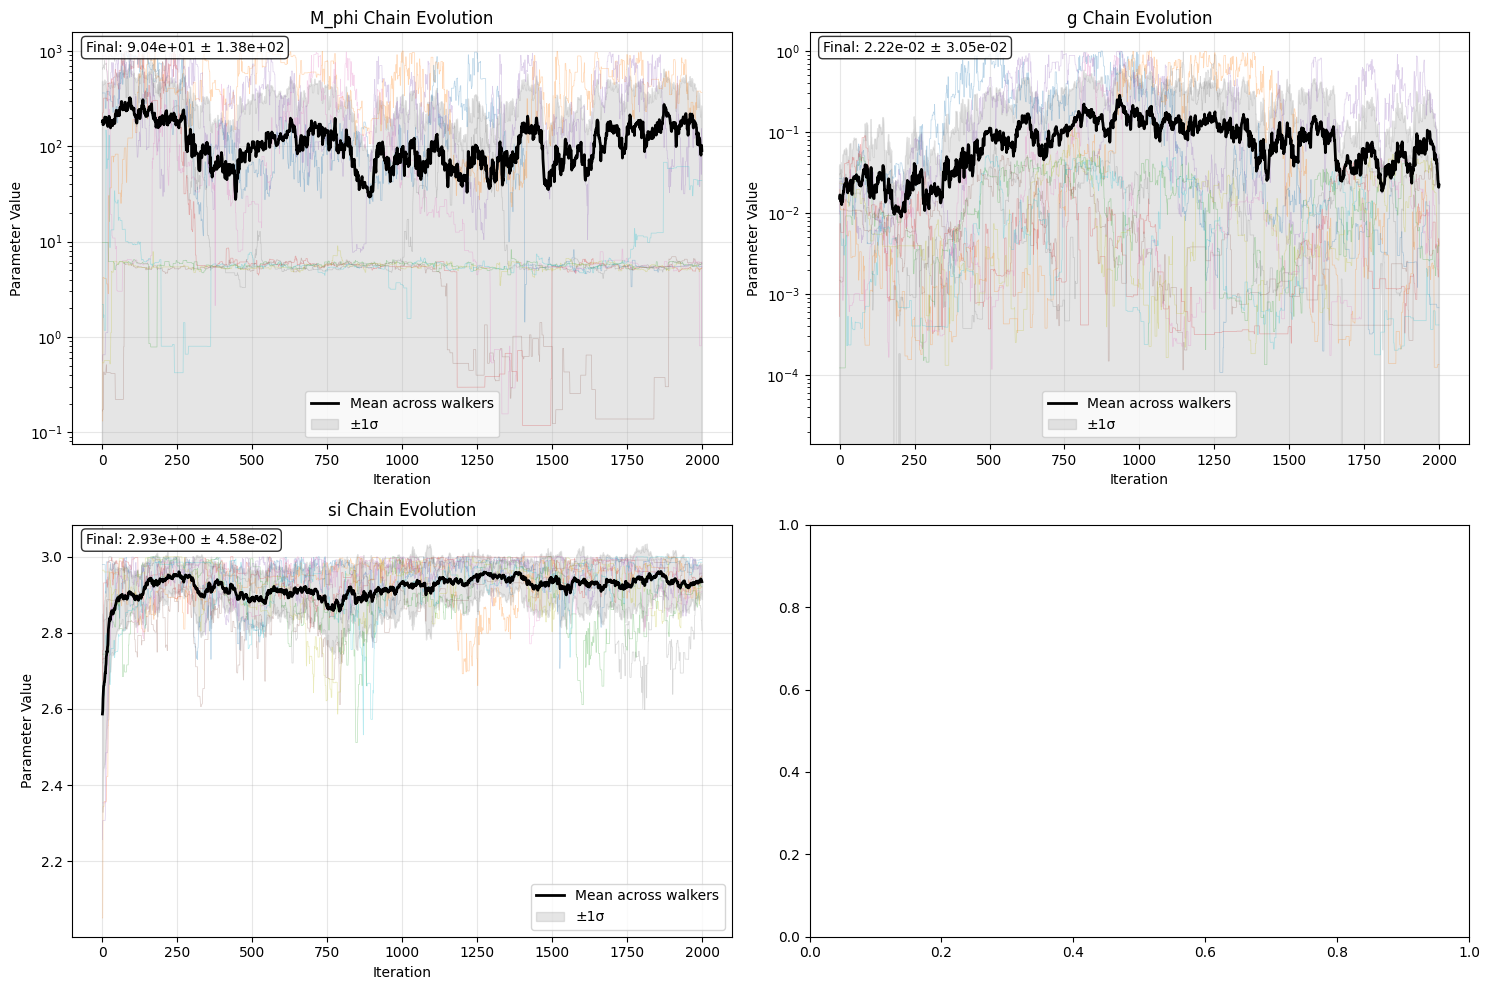

  Corner plot saved to 'plots/bayesian_fitting/2000steps_15walkers/mcmc_corner_plot.png'


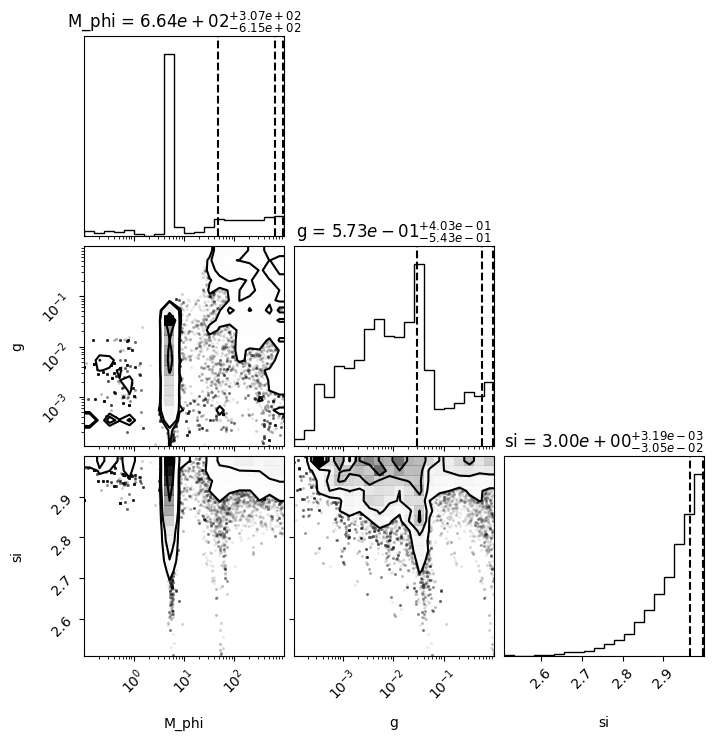

log prob shape (2000, 15)
Infinite log probabilities: 0/30000 (0.0%)
mean log prob [-59.2640145756969 -58.70240290842519 -52.82697591400636 ...
 -33.2736523173727 -33.28470642508067 -33.31182518581753]
  Likelihood evolution plot saved to 'plots/bayesian_fitting/2000steps_15walkers/mcmc_likelihood_evolution.png'


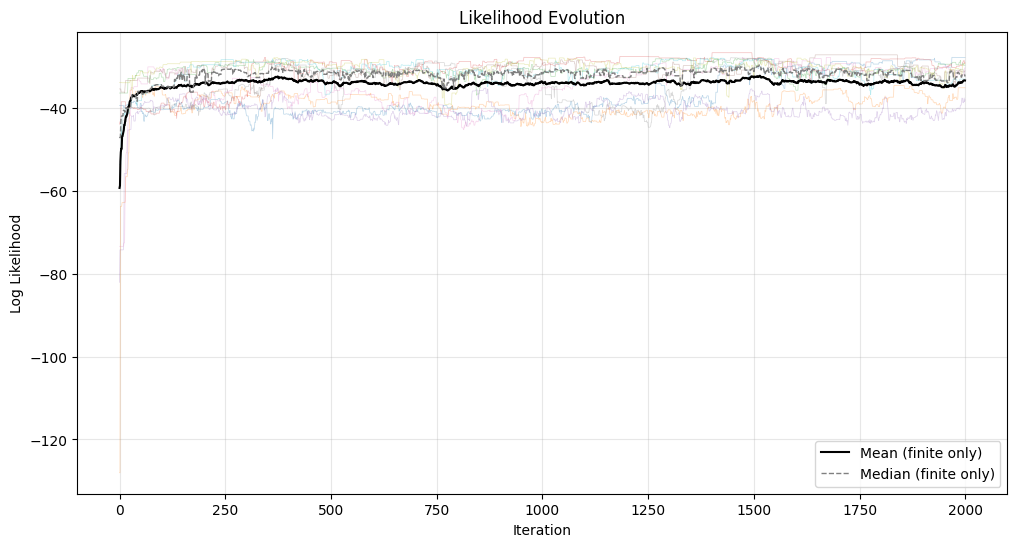

  Acceptance rate distribution saved to 'plots/bayesian_fitting/2000steps_15walkers/mcmc_acceptance_distribution.png'


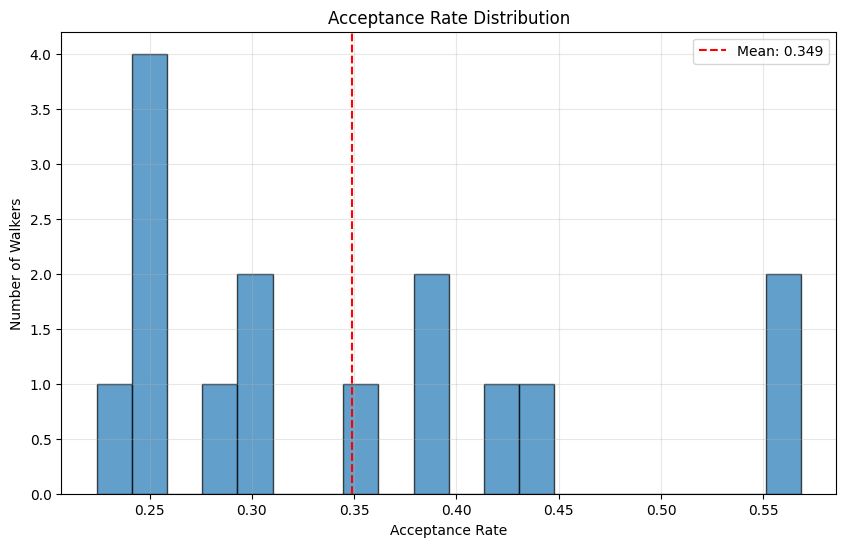

In [15]:
exec(open('analyze_completed_mcmc.py').read())
folder = 'plots/bayesian_fitting/2000steps_15walkers'
results = analyze_completed_mcmc(sampler, save_results=True, folder_name=folder)
plot_comprehensive_results(sampler, folder_name=folder)

5000 iterations, 17 walkers, poissonian likelihood. Factorial term omitted.

To analyze your completed MCMC:
1. Run: results = analyze_completed_mcmc(sampler)
2. Run: plot_comprehensive_results(sampler)
3. Run: check_for_backend_files()
4. Run: print_best_fit_summary(results)

To load MCMC data from CSV files:
1. Load from parameter samples: sampler = load_sampler_from_csv('mcmc_parameter_samples.csv')
2. Load with log probability: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob.csv')
3. Then use any analysis function: results = analyze_completed_mcmc(sampler)

To load MCMC data from .npy files:
1. Load from .npy files: sampler = load_sampler_from_npy('mcmc_chain.npy', 'mcmc_log_prob_final.npy')
2. Load with just log probability .npy: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob_final.npy')
=== COMPLETED MCMC ANALYSIS ===
Final results:
  Total iterations completed: 5000
  Number of walkers: 17
  Number of parameters: 4
  Likelihood range: -inf to 353.00
  Best fit found at iteration 2415 by

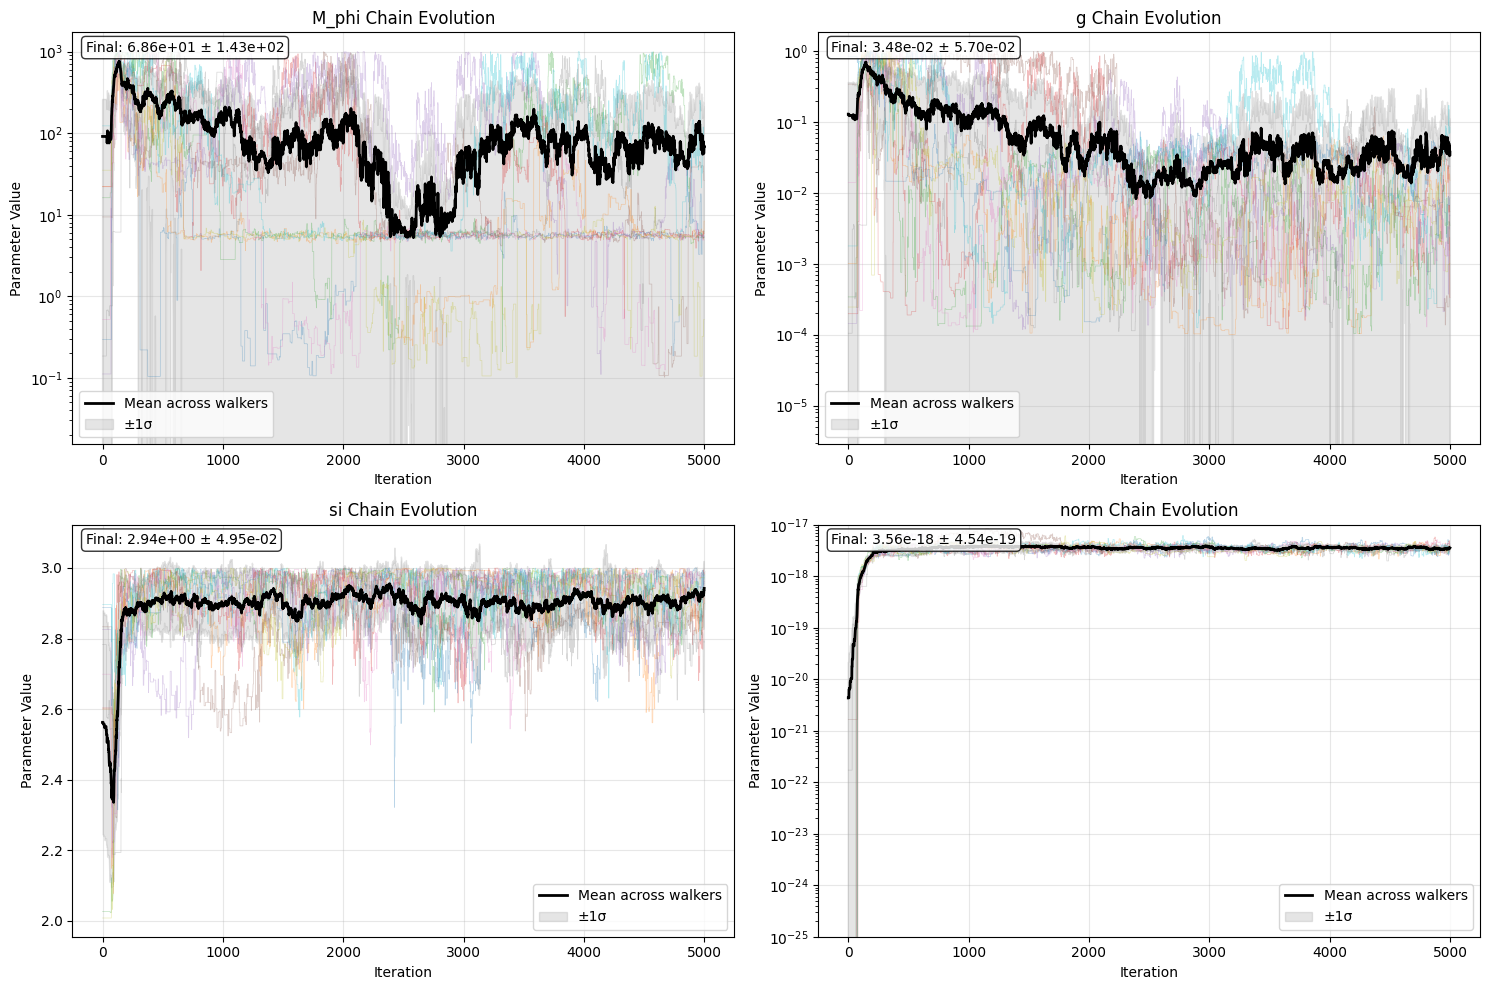

  Corner plot saved to 'mcmc_corner_plot.png'


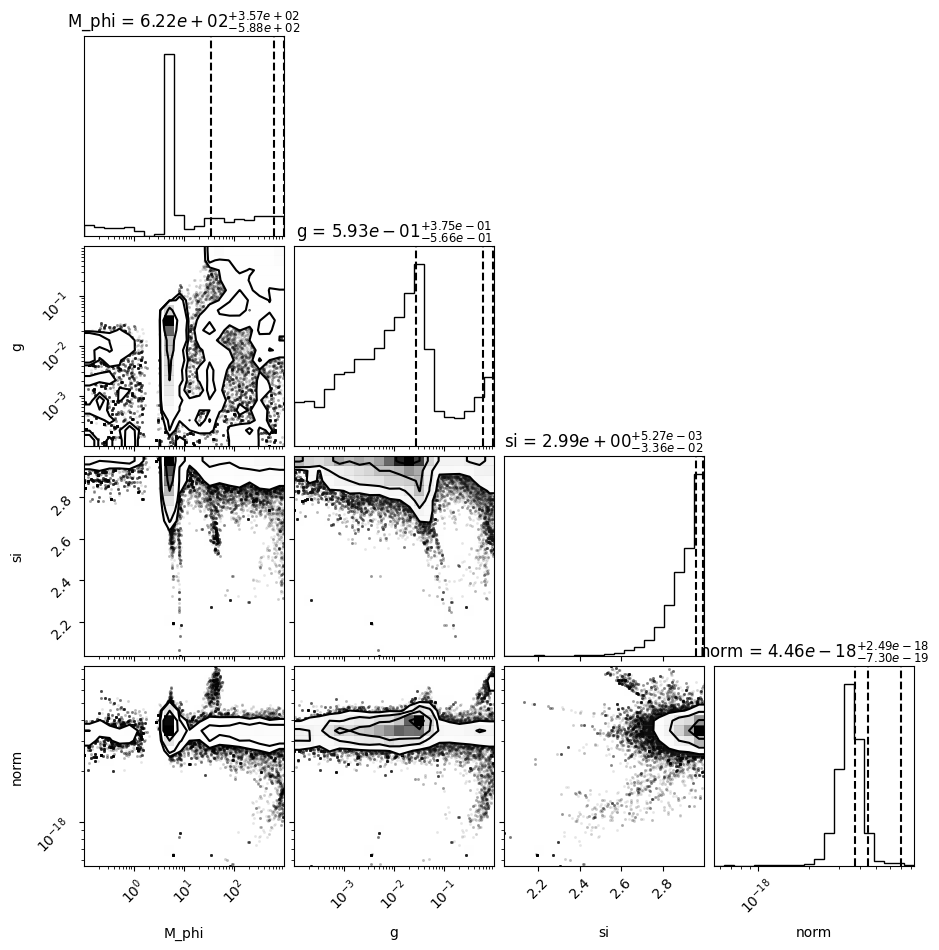

log prob shape (5000, 17)
Infinite log probabilities: 1067/85000 (1.3%)
Some walkers are exploring regions with zero likelihood
This is normal in MCMC - filtering out infinite values for mean calculation
mean log prob [-- -- -- ... 344.3779932370201 344.1712179650103 344.25084608413425]
  Likelihood evolution plot saved to 'mcmc_likelihood_evolution.png'


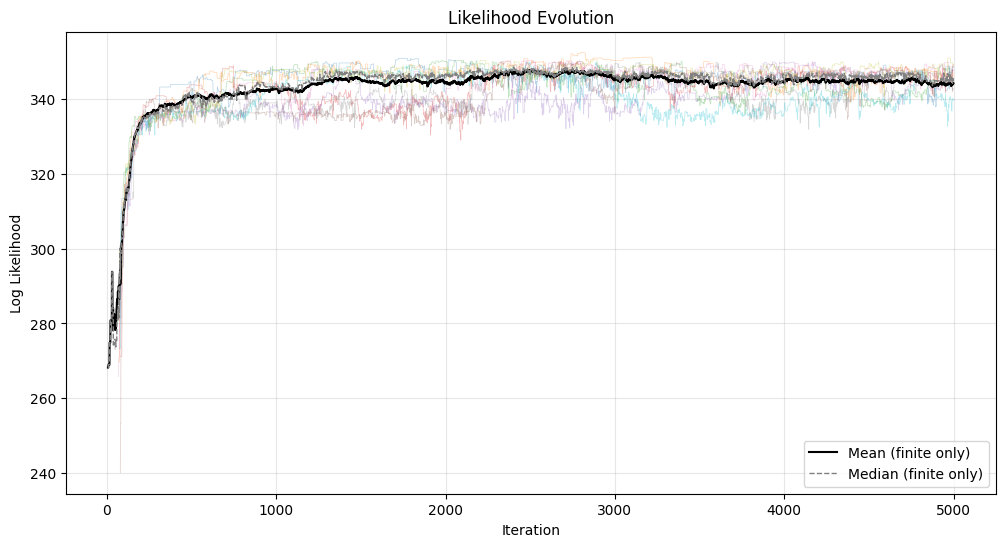

  Acceptance rate distribution saved to 'mcmc_acceptance_distribution.png'


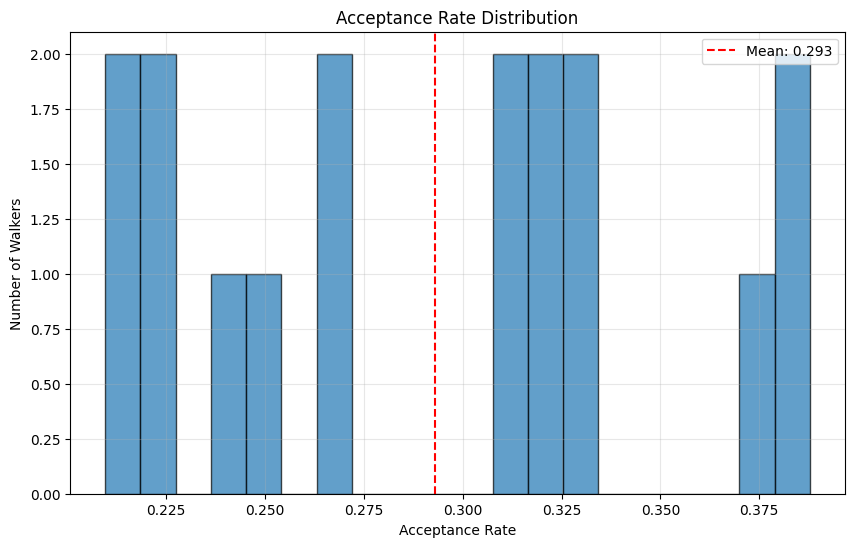

In [75]:
exec(open('analyze_completed_mcmc.py').read())

results = analyze_completed_mcmc(sampler)
plot_comprehensive_results(sampler)

To analyze your completed MCMC:
1. Run: results = analyze_completed_mcmc(sampler)
2. Run: plot_comprehensive_results(sampler)
3. Run: check_for_backend_files()
4. Run: print_best_fit_summary(results)

To load MCMC data from CSV files:
1. Load from parameter samples: sampler = load_sampler_from_csv('mcmc_parameter_samples.csv')
2. Load with log probability: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob.csv')
3. Then use any analysis function: results = analyze_completed_mcmc(sampler)

To load MCMC data from .npy files:
1. Load from .npy files: sampler = load_sampler_from_npy('mcmc_chain.npy', 'mcmc_log_prob_final.npy')
2. Load with just log probability .npy: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob_final.npy')
=== COMPLETED MCMC ANALYSIS ===
Final results:
  Total iterations completed: 1000
  Number of walkers: 17
  Number of parameters: 4
  Likelihood range: -inf to 351.11
  Best fit found at iteration 943 by 

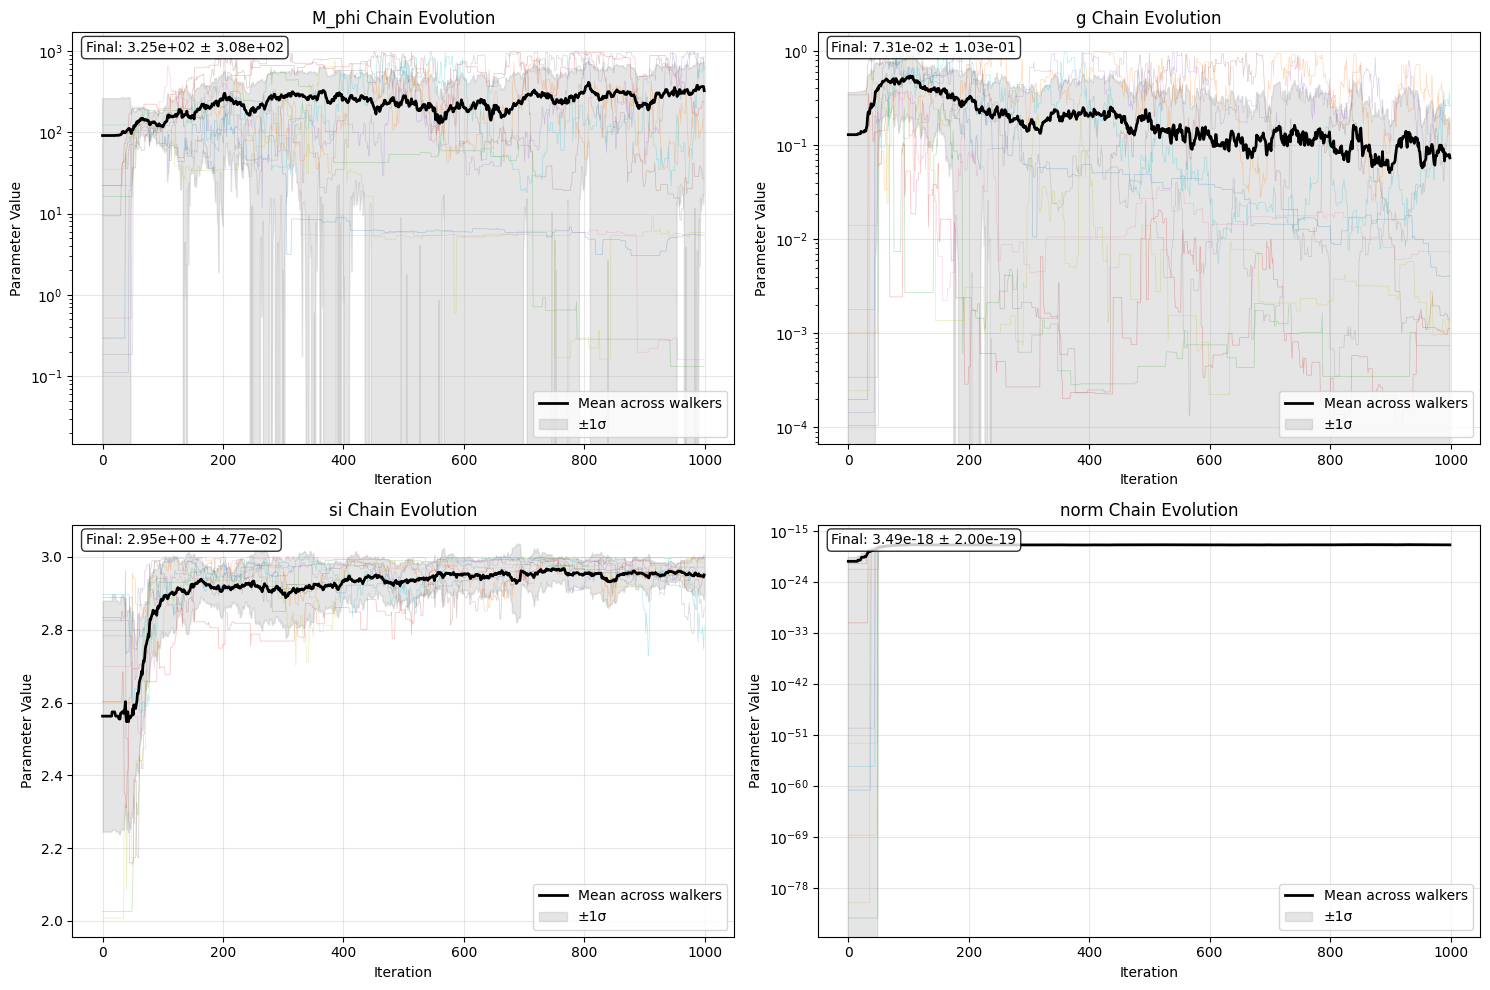

  Corner plot saved to 'mcmc_corner_plot.png'


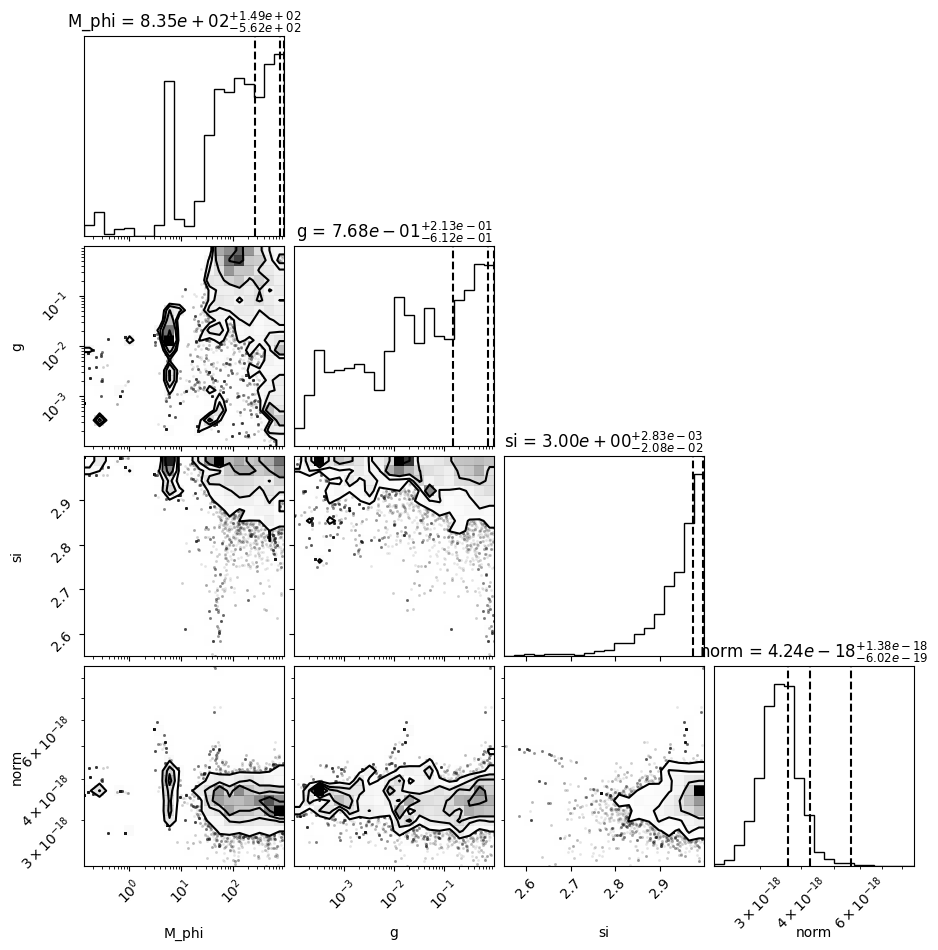

log prob shape (1000, 17)
Infinite log probabilities: 694/17000 (4.1%)
Some walkers are exploring regions with zero likelihood
This is normal in MCMC - filtering out infinite values for mean calculation
mean log prob [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 243.65626581324443
 243.65626581324443 243.65626581324443 243.65626581324443
 243.65626581324443 242.95133181248627 256.05092164108646
 256.05092164108646 256.05092164108646 256.05092164108646
 256.05092164108646 263.4195925943128 292.8644385801444 292.8644385801444
 296.3801383873552 276.9586891952558 289.96875171325087 297.1241965368452
 297.8823743778039 298.90061300173676 296.55284076549714
 296.55284076549714 287.5428657106369 291.9501455103635 293.3197554140778
 296.5376696444975 298.66697364147143 303.0069189495881 299.6214168717496
 295.8783900119996 296.2657012539758 300.7889172403472 305.6143279630511
 308.42754443479305 310.3314550993289 311.6230070979907 314.57682787394174
 317.29734789636666 317.46355606404603 3

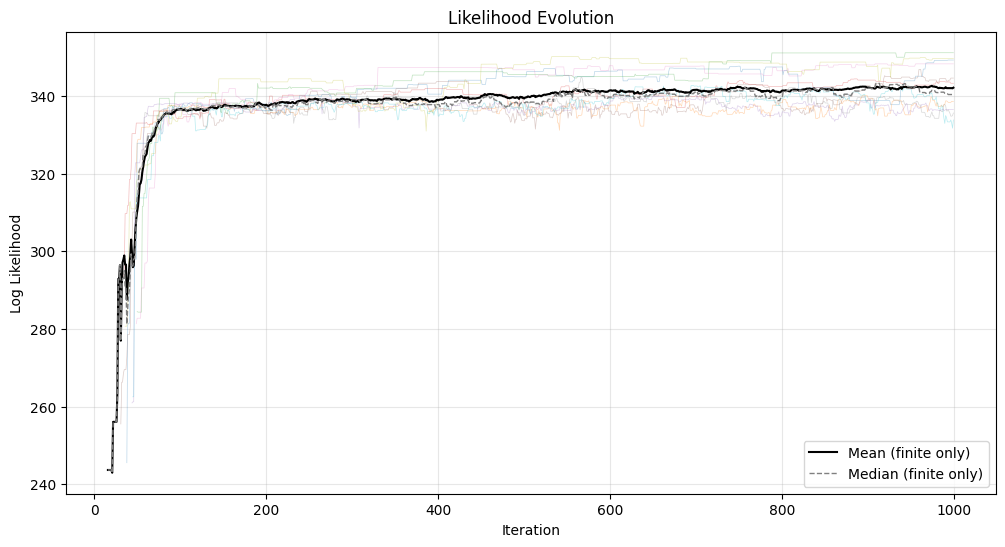

  Acceptance rate distribution saved to 'mcmc_acceptance_distribution.png'


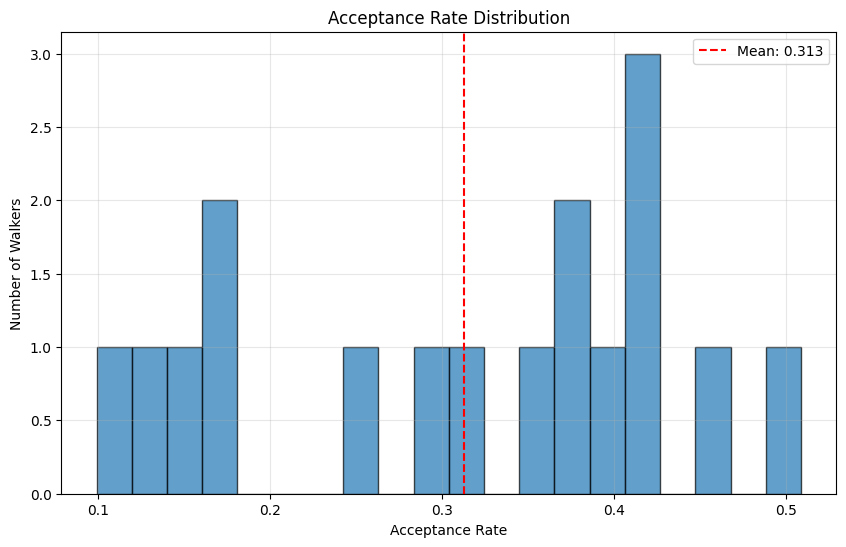

In [73]:
exec(open('analyze_completed_mcmc.py').read())

results = analyze_completed_mcmc(sampler)
plot_comprehensive_results(sampler)

In [64]:
print_best_fit_summary(results)


=== BEST FIT SUMMARY ===
Best fit parameters:
  M_phi: 9.91e+01
  g: 1.20e-02
  si: 2.94e+00
  norm: 3.15e-18
Best log-likelihood: 29.69

Parameter credible intervals (16%, 50%, 84%):
  M_phi: 3.93e+01, 2.04e+02, 5.95e+02
  g: 7.24e-02, 6.06e-01, 8.81e-01
  si: 2.48e+00, 2.80e+00, 2.94e+00
  norm: 2.27e-19, 2.52e-18, 3.55e-18


To analyze your completed MCMC:
1. Run: results = analyze_completed_mcmc(sampler)
2. Run: plot_comprehensive_results(sampler)
3. Run: check_for_backend_files()
4. Run: print_best_fit_summary(results)

To load MCMC data from CSV files:
1. Load from parameter samples: sampler = load_sampler_from_csv('mcmc_parameter_samples.csv')
2. Load with log probability: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob.csv')
3. Then use any analysis function: results = analyze_completed_mcmc(sampler)

To load MCMC data from .npy files:
1. Load from .npy files: sampler = load_sampler_from_npy('mcmc_chain.npy', 'mcmc_log_prob_final.npy')
2. Load with just log probability .npy: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob_final.npy')
=== COMPLETED MCMC ANALYSIS ===
Final results:
  Total iterations completed: 200
  Number of walkers: 17
  Number of parameters: 4
  Likelihood range: -inf to 29.69
  Best fit found at iteration 199 by wa

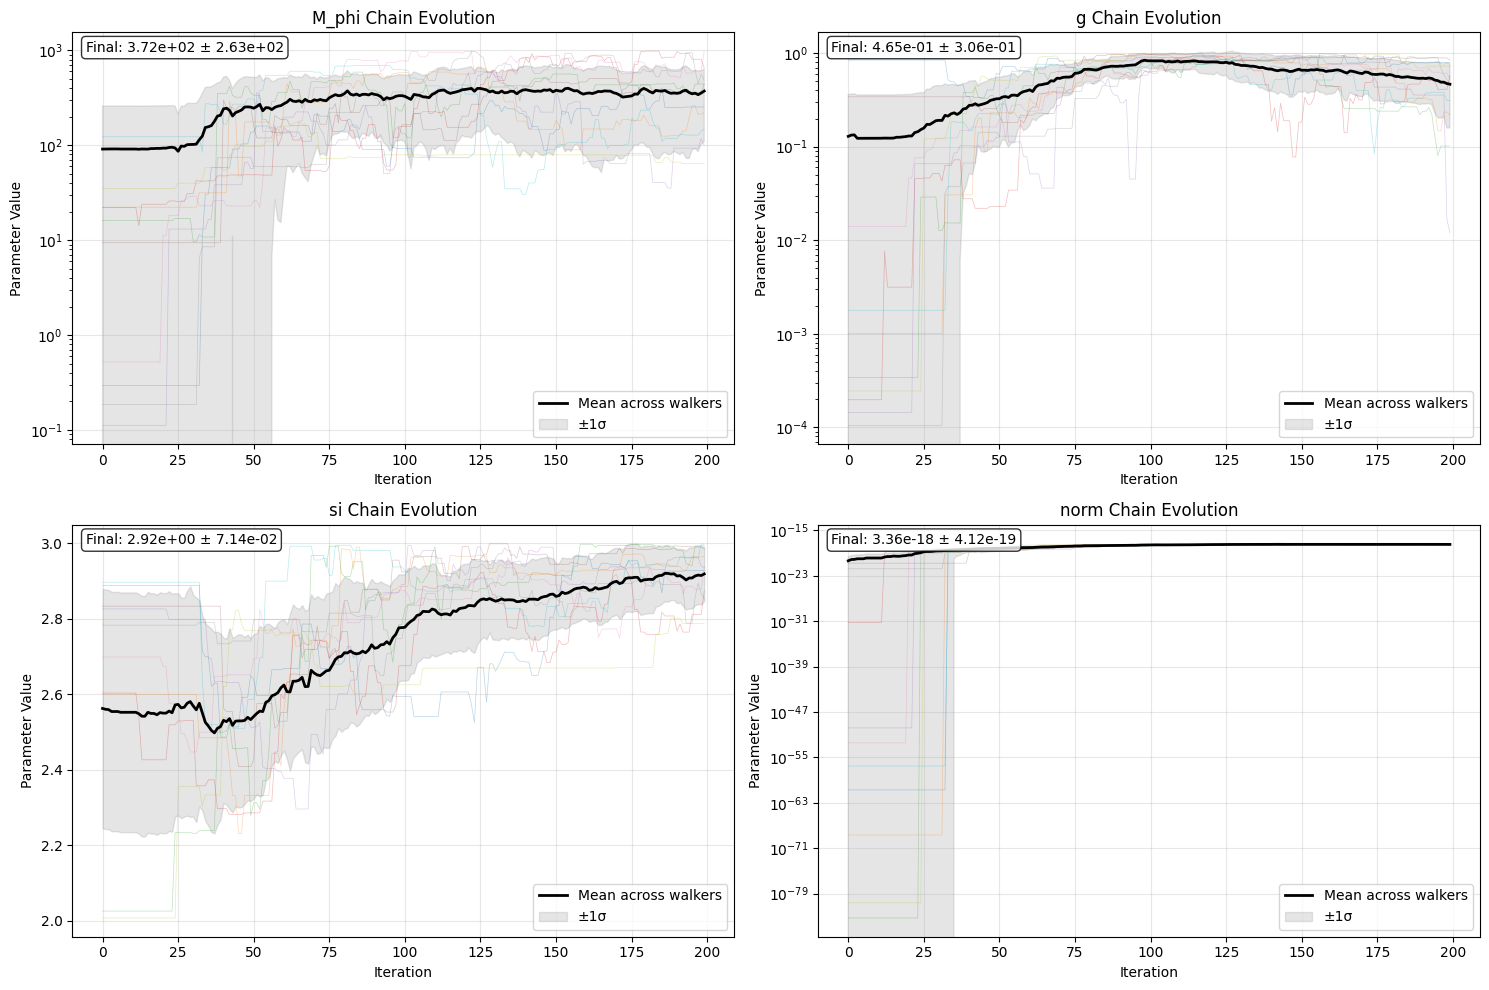

  Corner plot saved to 'mcmc_corner_plot.png'


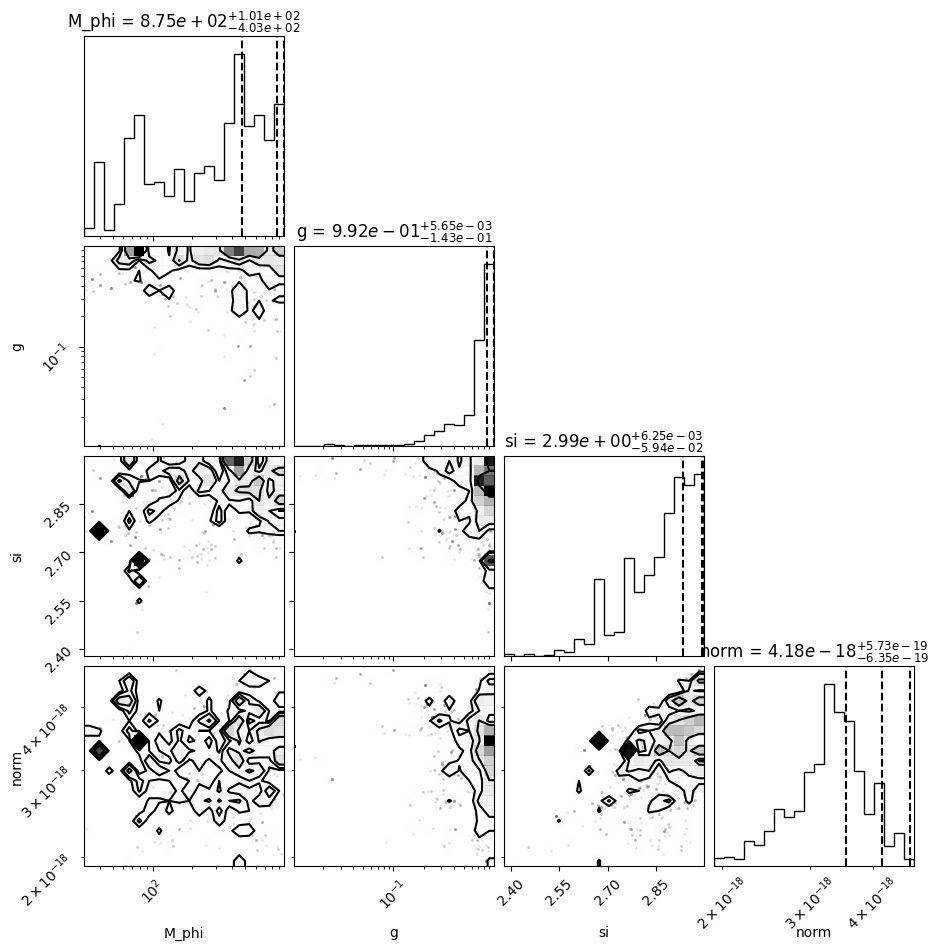

log prob shape (200, 17)
Infinite log probabilities: 456/3400 (13.4%)
Some walkers are exploring regions with zero likelihood
This is normal in MCMC - filtering out infinite values for mean calculation
mean log prob [-- -67.07094094638651 -67.11923089989901 -34.815495612749466
 -34.815495612749466 -34.815495612749466 -28.289850455209546
 -28.289850455209546 -28.289850455209546 -28.289850455209546
 -28.289850455209546 -28.289850455209546 -34.98727419044662
 -29.36986222895817 -29.36986222895817 -29.520256094056993
 -29.799074371075747 -29.799074371075747 -26.19371110663781
 -25.058761352744227 -30.421791018102358 -30.421791018102358
 -26.501134631764028 -24.26413952230707 -27.66367320863913
 -25.04253635647632 -22.871516463180093 -22.96916666149056
 -22.04018391978086 -20.317990847331732 -22.625887314678714
 -22.10367517962666 -26.023808369843504 -29.767883104428545
 -26.67399452636033 -26.14763906694487 -25.714473864755856
 -24.76794450210299 -23.479262185965393 -21.12235788449205
 -21

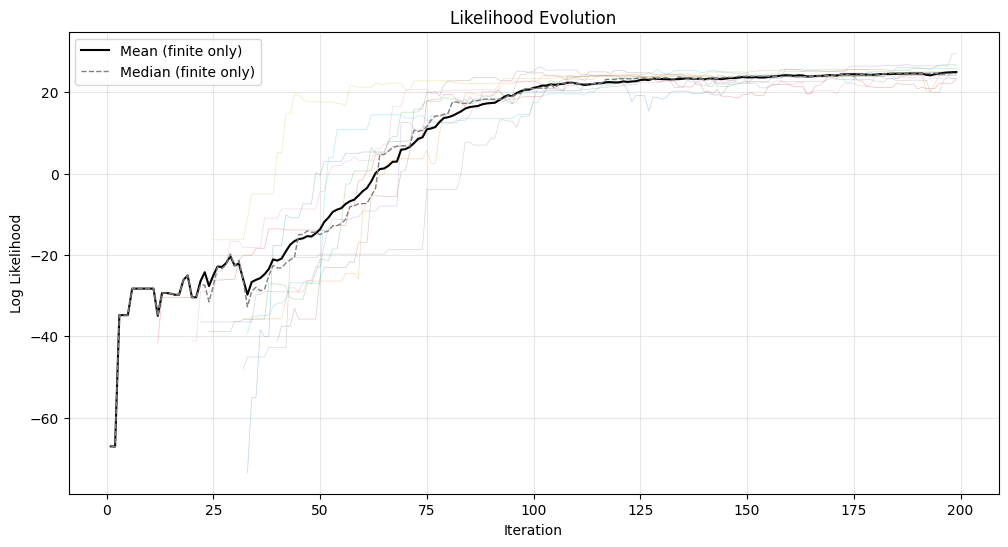

  Acceptance rate distribution saved to 'mcmc_acceptance_distribution.png'


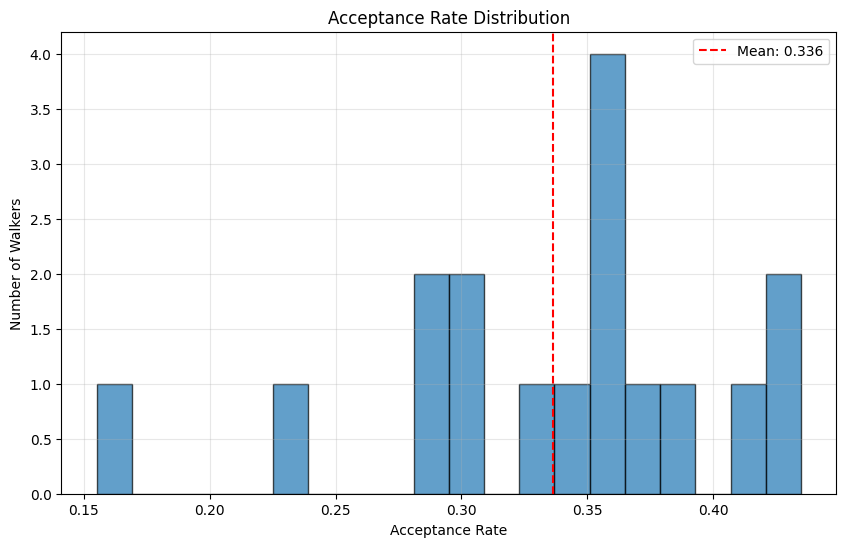

In [63]:
exec(open('analyze_completed_mcmc.py').read())

results = analyze_completed_mcmc(sampler)
plot_comprehensive_results(sampler)

In [ ]:

    
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

print("Running MCMC...")
sampler.run_mcmc(pos, 200, progress=True)



Running MCMC...


  0%|          | 0/200 [00:00<?, ?it/s]

/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 2/200 [00:02<03:53,  1.18s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 3/200 [00:04<04:53,  1.49s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 4/200 [00:06<06:18,  1.93s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▎         | 7/200 [00:09<03:46,  1.17s/it]/home/as

Testing: Mphi=17.19, g=1.08e-01, si=2.61, norm=2.36e-19
Log Prior: 42.27, Log Likelihood: -76.71


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 12%|█▎        | 25/200 [01:06<17:34,  6.02s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 13%|█▎        | 26/200 [01:19<23:51,  8.23s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: 

Testing: Mphi=245.56, g=9.62e-02, si=2.08, norm=3.14e-19
Log Prior: 39.44, Log Likelihood: -62.18


/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 14%|█▍        | 29/200 [01:50<27:20,  9.60s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 15%|█▌        | 30/200 [01:56<23:57,  8.45s/it]/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/astridaurora/miniforge3/envs/nusiprop/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: 

Testing: Mphi=320.90, g=3.27e-01, si=2.46, norm=2.73e-19
Log Prior: 38.09, Log Likelihood: -68.98


 22%|██▎       | 45/200 [06:47<1:01:01, 23.62s/it]

Testing: Mphi=439.82, g=3.98e-01, si=2.49, norm=6.10e-19
Log Prior: 36.77, Log Likelihood: -49.44


 23%|██▎       | 46/200 [07:04<56:06, 21.86s/it]  

Testing: Mphi=788.69, g=6.24e-01, si=2.63, norm=6.36e-19
Log Prior: 35.70, Log Likelihood: -49.61


 26%|██▋       | 53/200 [09:33<52:18, 21.35s/it]

Testing: Mphi=48.44, g=3.43e-02, si=2.32, norm=4.74e-19
Log Prior: 41.68, Log Likelihood: -54.49


 28%|██▊       | 56/200 [10:22<42:41, 17.79s/it]

Testing: Mphi=29.26, g=3.19e-01, si=2.28, norm=1.70e-19
Log Prior: 40.99, Log Likelihood: -78.12


 30%|███       | 60/200 [11:46<48:45, 20.89s/it]

Testing: Mphi=154.99, g=2.47e-01, si=2.59, norm=8.97e-19
Log Prior: 37.91, Log Likelihood: -39.39


 33%|███▎      | 66/200 [13:38<42:52, 19.20s/it]

Testing: Mphi=228.92, g=6.76e-01, si=2.22, norm=1.87e-18
Log Prior: 35.78, Log Likelihood: -36.63


 34%|███▍      | 69/200 [14:40<43:13, 19.79s/it]

Testing: Mphi=762.87, g=4.09e-01, si=2.43, norm=9.32e-19
Log Prior: 35.77, Log Likelihood: -38.22


 35%|███▌      | 70/200 [15:09<48:43, 22.49s/it]

Testing: Mphi=136.44, g=8.07e-01, si=2.68, norm=2.79e-18
Log Prior: 35.72, Log Likelihood: -15.24


 36%|███▌      | 71/200 [15:28<46:02, 21.42s/it]

Testing: Mphi=609.05, g=6.26e-01, si=2.58, norm=1.25e-18
Log Prior: 35.28, Log Likelihood: -30.42


 37%|███▋      | 74/200 [16:35<46:55, 22.34s/it]

Testing: Mphi=206.79, g=5.88e-01, si=2.33, norm=1.52e-18
Log Prior: 36.23, Log Likelihood: -30.94


 38%|███▊      | 76/200 [17:19<45:40, 22.10s/it]

Testing: Mphi=713.82, g=3.57e-01, si=2.30, norm=4.06e-19
Log Prior: 36.81, Log Likelihood: -58.01


 41%|████      | 82/200 [19:19<39:41, 20.18s/it]

Testing: Mphi=55.42, g=8.59e-01, si=2.41, norm=2.08e-18
Log Prior: 36.85, Log Likelihood: -20.27


 42%|████▏     | 83/200 [19:42<40:59, 21.02s/it]

Testing: Mphi=457.11, g=7.98e-01, si=2.69, norm=1.97e-18
Log Prior: 34.87, Log Likelihood: -19.18
Testing: Mphi=256.42, g=6.57e-01, si=2.50, norm=1.75e-18
Log Prior: 35.76, Log Likelihood: -24.41


 44%|████▍     | 88/200 [21:40<42:49, 22.94s/it]

Testing: Mphi=842.05, g=4.33e-02, si=2.37, norm=7.68e-19
Log Prior: 38.11, Log Likelihood: -43.05


 44%|████▍     | 89/200 [22:01<41:20, 22.35s/it]

Testing: Mphi=450.25, g=5.68e-01, si=2.83, norm=1.46e-18
Log Prior: 35.52, Log Likelihood: -26.17


 50%|█████     | 101/200 [26:21<37:07, 22.50s/it]

Testing: Mphi=75.04, g=7.07e-01, si=2.84, norm=2.41e-18
Log Prior: 36.59, Log Likelihood: -15.15


 55%|█████▍    | 109/200 [29:20<34:07, 22.50s/it]

Testing: Mphi=360.19, g=5.61e-01, si=2.97, norm=2.71e-18
Log Prior: 35.14, Log Likelihood: -11.69


 56%|█████▋    | 113/200 [30:44<31:29, 21.72s/it]

Testing: Mphi=190.98, g=9.79e-01, si=2.87, norm=3.95e-18
Log Prior: 34.84, Log Likelihood: -12.24


 58%|█████▊    | 117/200 [32:10<29:37, 21.41s/it]

Testing: Mphi=308.94, g=9.50e-01, si=2.94, norm=3.32e-18
Log Prior: 34.56, Log Likelihood: -10.19


 60%|██████    | 121/200 [33:41<29:09, 22.14s/it]

Testing: Mphi=834.56, g=7.95e-01, si=2.88, norm=2.68e-18
Log Prior: 33.96, Log Likelihood: -12.34
Testing: Mphi=407.26, g=8.07e-01, si=2.77, norm=2.34e-18
Log Prior: 34.80, Log Likelihood: -15.44


 62%|██████▏   | 124/200 [34:45<28:01, 22.12s/it]

Testing: Mphi=667.19, g=9.28e-01, si=2.97, norm=3.18e-18
Log Prior: 33.86, Log Likelihood: -10.06
Testing: Mphi=197.26, g=9.12e-01, si=2.91, norm=3.50e-18
Log Prior: 35.00, Log Likelihood: -10.62


 66%|██████▌   | 132/200 [37:39<24:19, 21.46s/it]

Testing: Mphi=293.99, g=6.98e-01, si=2.90, norm=3.76e-18
Log Prior: 34.80, Log Likelihood: -11.19
Testing: Mphi=660.52, g=6.92e-01, si=2.90, norm=3.43e-18
Log Prior: 34.09, Log Likelihood: -10.68


 67%|██████▋   | 134/200 [38:16<21:52, 19.89s/it]

Testing: Mphi=610.01, g=6.47e-01, si=2.78, norm=3.03e-18
Log Prior: 34.36, Log Likelihood: -13.02


 71%|███████   | 142/200 [40:58<18:28, 19.12s/it]

Testing: Mphi=472.98, g=8.85e-01, si=2.92, norm=3.00e-18
Log Prior: 34.31, Log Likelihood: -10.89


 72%|███████▏  | 143/200 [41:16<17:47, 18.74s/it]

Testing: Mphi=337.33, g=8.20e-01, si=2.91, norm=3.28e-18
Log Prior: 34.64, Log Likelihood: -10.55


 74%|███████▎  | 147/200 [42:24<15:00, 16.98s/it]

Testing: Mphi=585.67, g=2.99e-01, si=2.94, norm=4.40e-18
Log Prior: 34.80, Log Likelihood: -12.77


 74%|███████▍  | 148/200 [42:45<15:38, 18.06s/it]

Testing: Mphi=460.08, g=8.95e-01, si=2.94, norm=3.15e-18
Log Prior: 34.28, Log Likelihood: -10.34


 77%|███████▋  | 154/200 [44:53<15:58, 20.85s/it]

Testing: Mphi=98.44, g=6.34e-01, si=2.88, norm=3.09e-18
Log Prior: 36.19, Log Likelihood: -11.17


 78%|███████▊  | 155/200 [45:14<15:31, 20.70s/it]

Testing: Mphi=334.14, g=3.58e-01, si=2.95, norm=4.49e-18
Log Prior: 35.16, Log Likelihood: -12.98


 78%|███████▊  | 156/200 [45:35<15:15, 20.81s/it]

Testing: Mphi=212.34, g=8.86e-01, si=2.70, norm=3.46e-18
Log Prior: 34.97, Log Likelihood: -15.67
Testing: Mphi=618.80, g=7.19e-01, si=2.83, norm=3.36e-18
Log Prior: 34.14, Log Likelihood: -11.88


 79%|███████▉  | 158/200 [46:09<13:08, 18.76s/it]

Testing: Mphi=697.64, g=5.54e-01, si=2.94, norm=3.52e-18
Log Prior: 34.23, Log Likelihood: -10.25
Testing: Mphi=464.20, g=8.90e-01, si=2.94, norm=3.20e-18
Log Prior: 34.26, Log Likelihood: -10.27
Testing: Mphi=844.41, g=5.12e-01, si=2.95, norm=3.69e-18
Log Prior: 34.07, Log Likelihood: -10.28


 82%|████████▏ | 163/200 [47:42<10:51, 17.62s/it]

Testing: Mphi=186.92, g=6.35e-01, si=2.85, norm=2.96e-18
Log Prior: 35.59, Log Likelihood: -11.78


 85%|████████▌ | 170/200 [49:49<08:59, 17.97s/it]

Testing: Mphi=847.39, g=5.14e-01, si=2.95, norm=3.69e-18
Log Prior: 34.06, Log Likelihood: -10.28


 88%|████████▊ | 177/200 [51:56<06:51, 17.89s/it]

Testing: Mphi=115.69, g=7.78e-01, si=2.83, norm=3.08e-18
Log Prior: 35.82, Log Likelihood: -11.79


 90%|█████████ | 180/200 [52:52<06:13, 18.68s/it]

Testing: Mphi=596.03, g=9.09e-01, si=2.89, norm=3.64e-18
Log Prior: 33.86, Log Likelihood: -11.19


 92%|█████████▏| 183/200 [53:44<05:05, 17.96s/it]

Testing: Mphi=397.09, g=6.25e-01, si=2.99, norm=3.66e-18
Log Prior: 34.64, Log Likelihood: -9.73


 92%|█████████▏| 184/200 [54:09<05:21, 20.08s/it]

Testing: Mphi=685.22, g=6.78e-01, si=2.92, norm=3.65e-18
Log Prior: 34.01, Log Likelihood: -10.65


 93%|█████████▎| 186/200 [54:44<04:25, 18.94s/it]

Testing: Mphi=214.15, g=7.78e-01, si=2.94, norm=3.56e-18
Log Prior: 35.06, Log Likelihood: -10.19


 95%|█████████▌| 190/200 [56:04<03:11, 19.15s/it]

Testing: Mphi=543.22, g=6.96e-01, si=2.90, norm=3.37e-18
Log Prior: 34.30, Log Likelihood: -10.79


 96%|█████████▌| 192/200 [56:45<02:40, 20.00s/it]

Testing: Mphi=690.13, g=6.89e-01, si=2.87, norm=3.41e-18
Log Prior: 34.06, Log Likelihood: -11.30


 97%|█████████▋| 194/200 [57:24<01:57, 19.56s/it]

Testing: Mphi=47.06, g=2.36e-01, si=2.77, norm=3.40e-18
Log Prior: 37.82, Log Likelihood: -13.25
Testing: Mphi=347.92, g=2.46e-02, si=2.99, norm=2.88e-18
Log Prior: 38.24, Log Likelihood: -10.83


 99%|█████████▉| 198/200 [58:38<00:36, 18.19s/it]

Testing: Mphi=130.18, g=8.05e-01, si=2.82, norm=2.93e-18
Log Prior: 35.72, Log Likelihood: -12.27


100%|██████████| 200/200 [59:20<00:00, 17.80s/it]


NameError: name 'mcmc_diagnostics' is not defined

In [45]:
print_best_fit_summary(results)


=== BEST FIT SUMMARY ===
Best fit parameters:
  M_phi: 3.21e+02
  g: 7.67e-02
  si: 2.94e+00
  norm: 3.49e-18
Best log-likelihood: -10.23

Parameter credible intervals (16%, 50%, 84%):
  M_phi: 1.89e-01, 1.86e+01, 2.98e+02
  g: 4.42e-03, 4.96e-02, 3.38e-01
  si: 2.14e+00, 2.55e+00, 2.79e+00
  norm: 4.40e-19, 1.24e-18, 7.73e-18


To analyze your completed MCMC:
1. Run: results = analyze_completed_mcmc(sampler)
2. Run: plot_comprehensive_results(sampler)
3. Run: check_for_backend_files()
4. Run: print_best_fit_summary(results)

To load MCMC data from CSV files:
1. Load from parameter samples: sampler = load_sampler_from_csv('mcmc_parameter_samples.csv')
2. Load with log probability: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob.csv')
3. Then use any analysis function: results = analyze_completed_mcmc(sampler)

To load MCMC data from .npy files:
1. Load from .npy files: sampler = load_sampler_from_npy('mcmc_chain.npy', 'mcmc_log_prob_final.npy')
2. Load with just log probability .npy: sampler = load_sampler_with_log_prob('mcmc_parameter_samples.csv', 'mcmc_log_prob_final.npy')
Loading MCMC data from plots/bayesian_fitting/uniform_300steps_15walkers/mcmc_parameter_samples.csv...
Loaded chain with shape: (300, 15, 4)
Number of steps: 300
Number of walkers: 15
Number of parameters

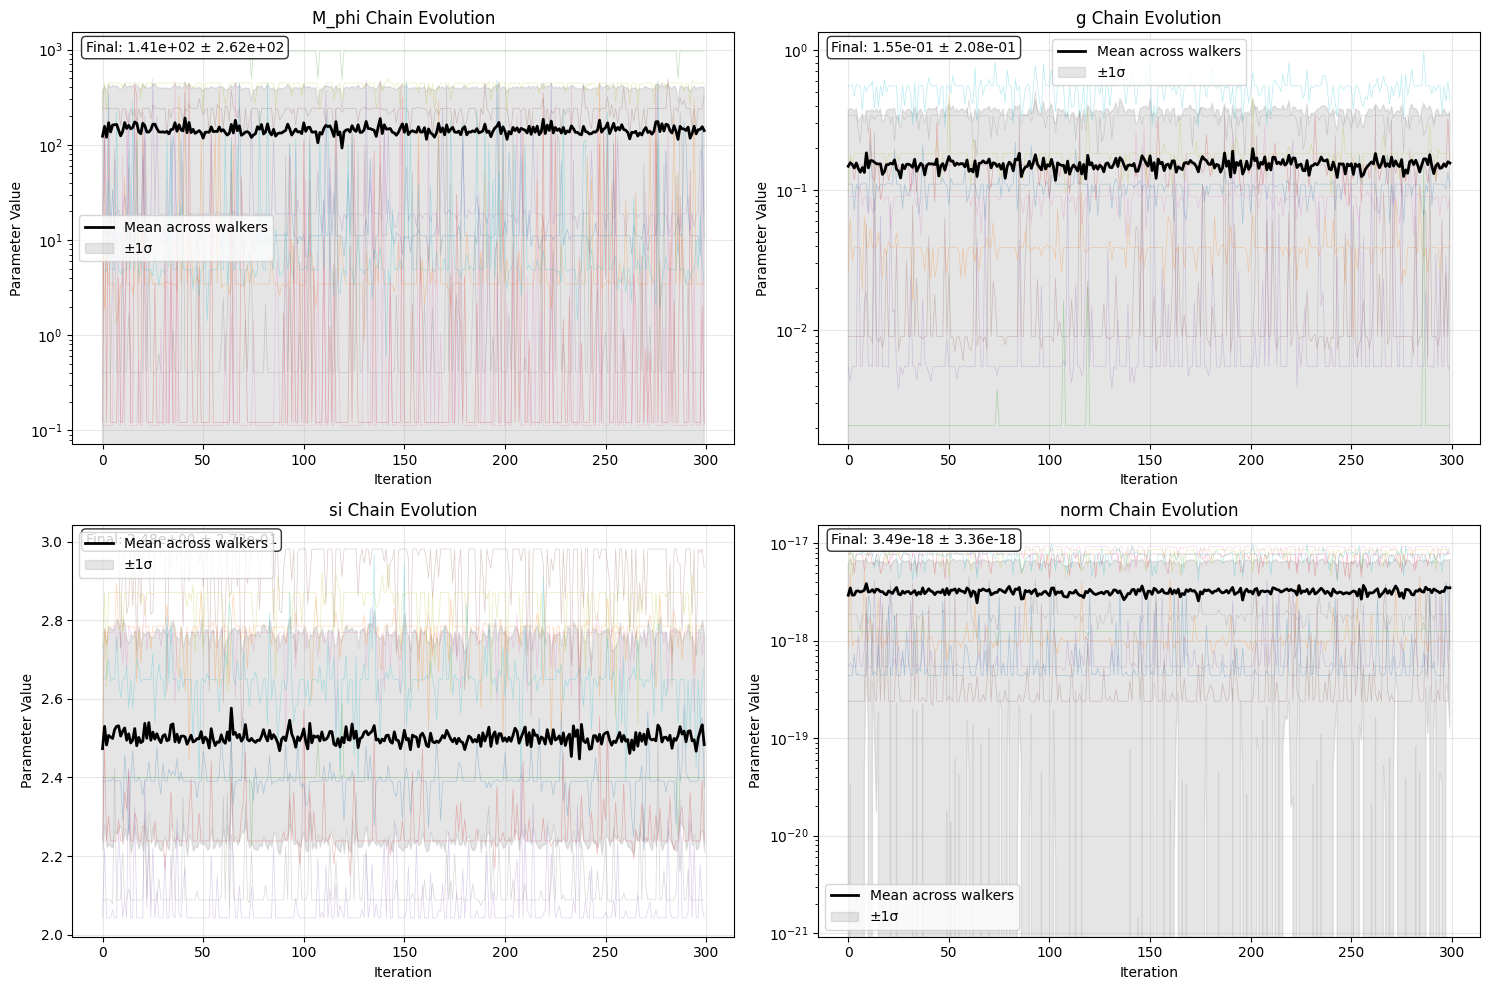

  Corner plot saved to 'mcmc_corner_plot.png'


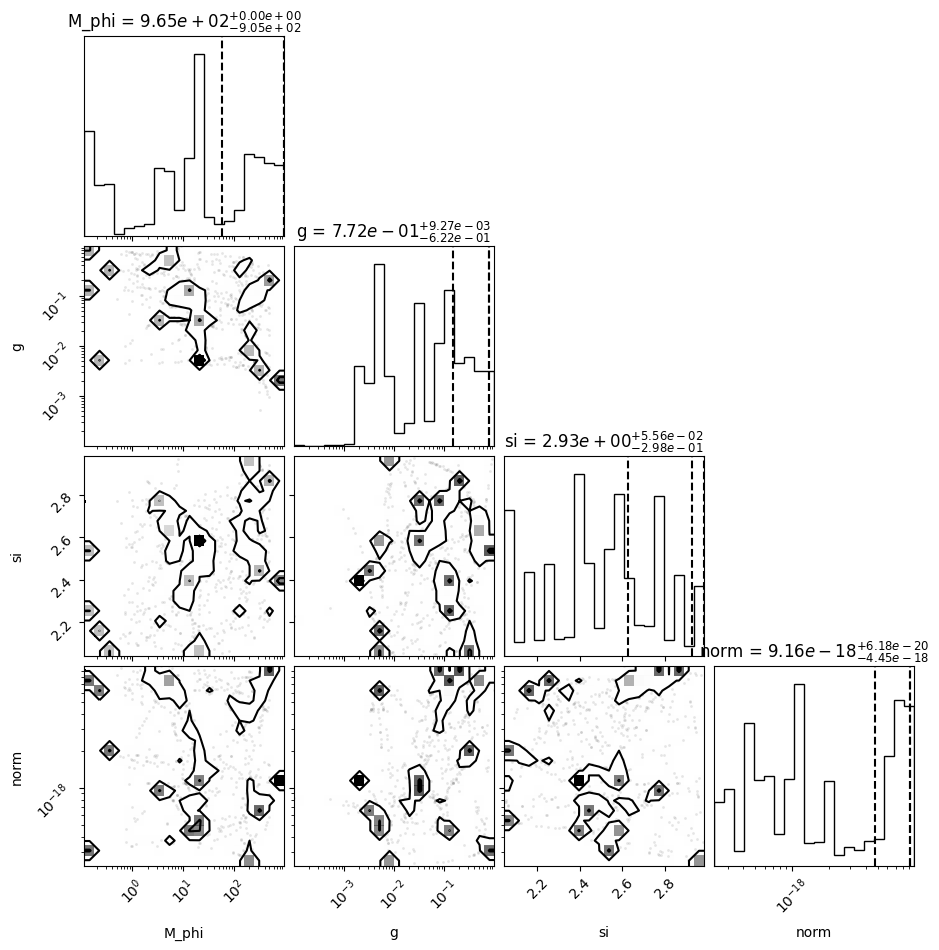

log prob shape (300, 15)
Infinite log probabilities: 1383/4500 (30.7%)
Some walkers are exploring regions with zero likelihood
This is normal in MCMC - filtering out infinite values for mean calculation
mean log prob [-56.41282535371364 -67.06817527282784 -56.87035393335685
 -54.50167403886667 -61.7715491374278 -63.40729968166302
 -61.14727290482332 -59.69299576570179 -65.0254612610316
 -59.95071701150108 -60.71001585083668 -67.12181530508435
 -59.714297242568364 -60.06538447575691 -59.98990341686566
 -46.93689801360474 -62.98481745361562 -57.97793840134057
 -70.13725652178653 -50.87919782255241 -60.81964949633709
 -54.47841776046558 -58.67819909864487 -63.89188266058158
 -52.43557220577704 -62.31325722651252 -67.3477583111665
 -61.24176663833131 -70.22891054342712 -65.57015063914017
 -71.57884944887063 -60.488191756839726 -43.804354513575575
 -60.77766755777348 -50.90428143465595 -72.7704080259328
 -57.23408811135979 -64.57165440765885 -56.56933346068661
 -50.529396620024166 -50.29704

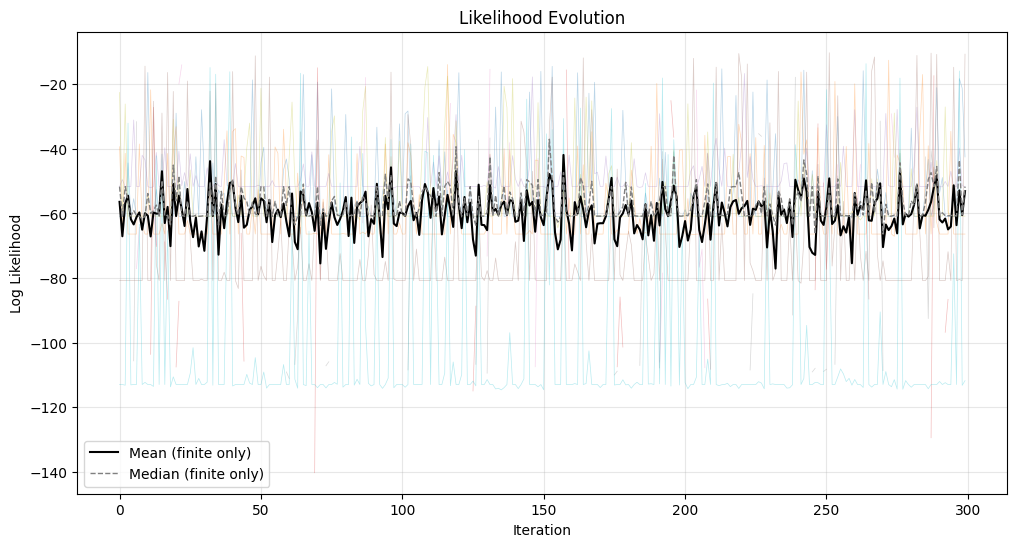

In [44]:
samples_file = "plots/bayesian_fitting/uniform_300steps_15walkers/mcmc_parameter_samples.csv"
log_prob_file = "plots/bayesian_fitting/uniform_300steps_15walkers/mcmc_log_prob_final.npy"
exec(open('analyze_completed_mcmc.py').read())

sampler = load_sampler_with_log_prob(samples_file, log_prob_file, n_walkers=15)

results = analyze_completed_mcmc(sampler)
plot_comprehensive_results(sampler)
#plot_corrected_chains(sampler)